# Import

In [260]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
from ipyparallel import Client
import traceback
from itertools import product, combinations
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from math import comb
from datetime import datetime

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

prospective_preexpert_animals = ['DS_16','BS_85','BS_95','BS_113']#BS_50

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023

stdfont = 14
stdyfrac = 0.06

In [261]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#,'AE_267']))

In [262]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

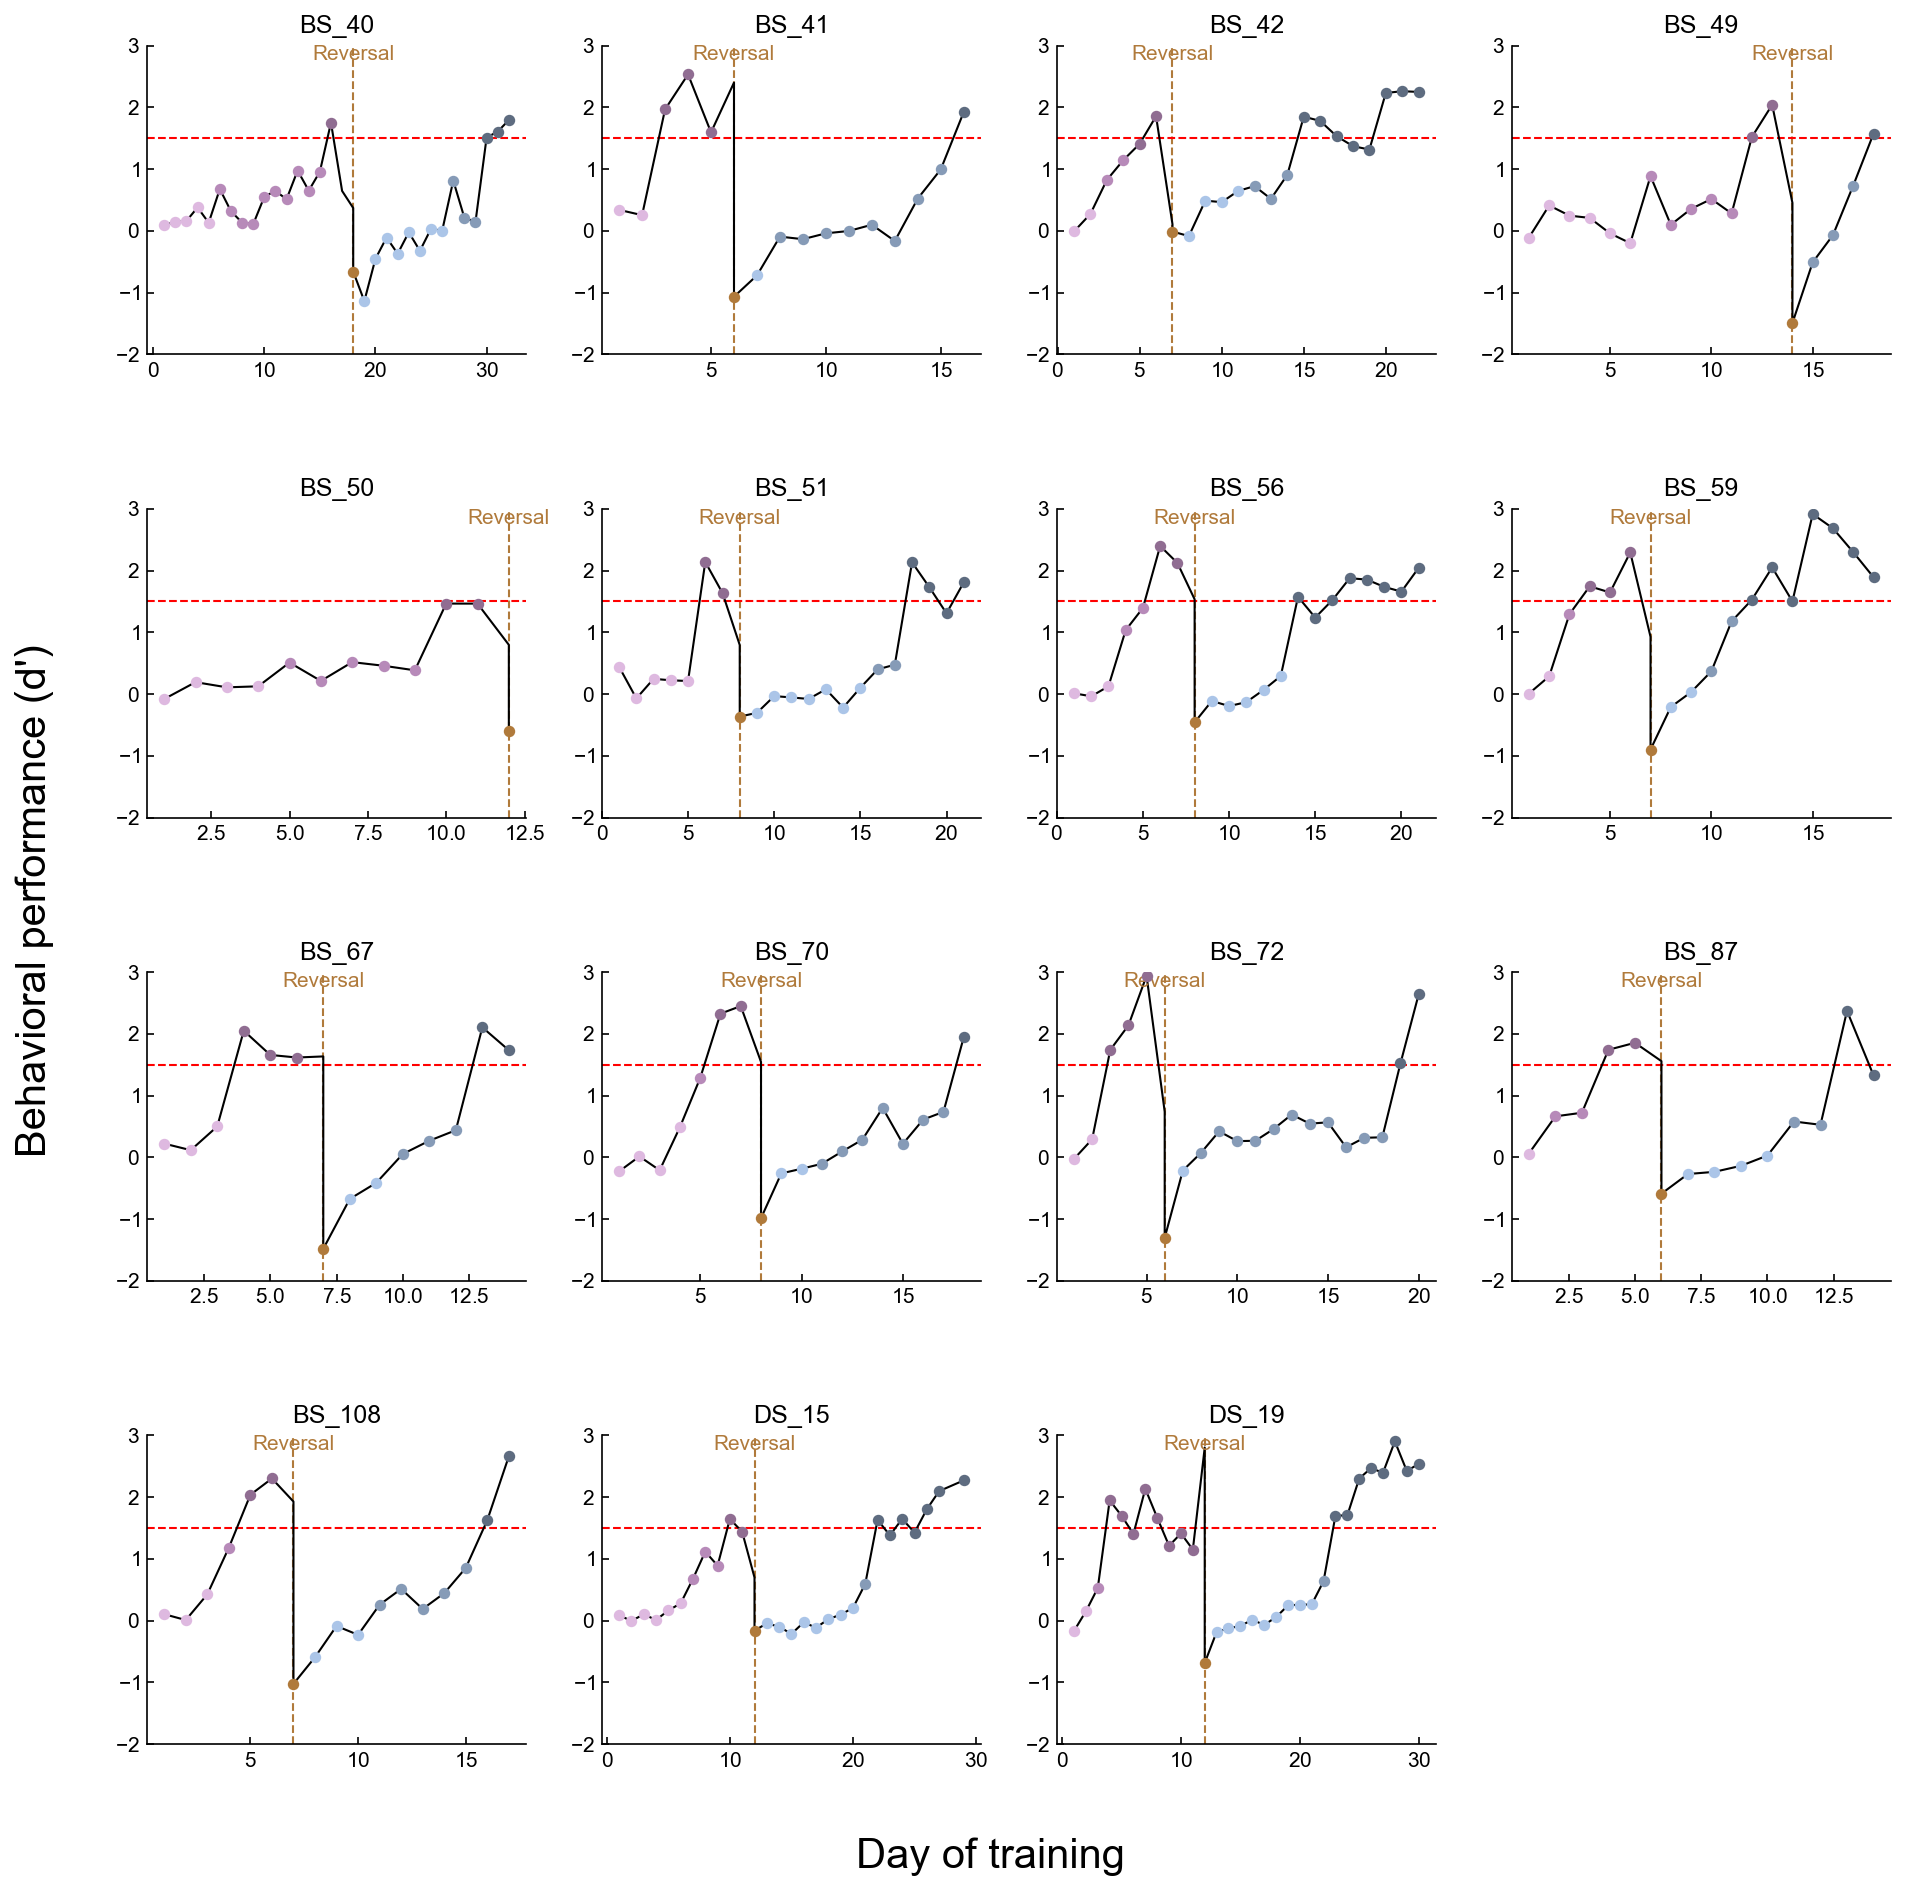

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


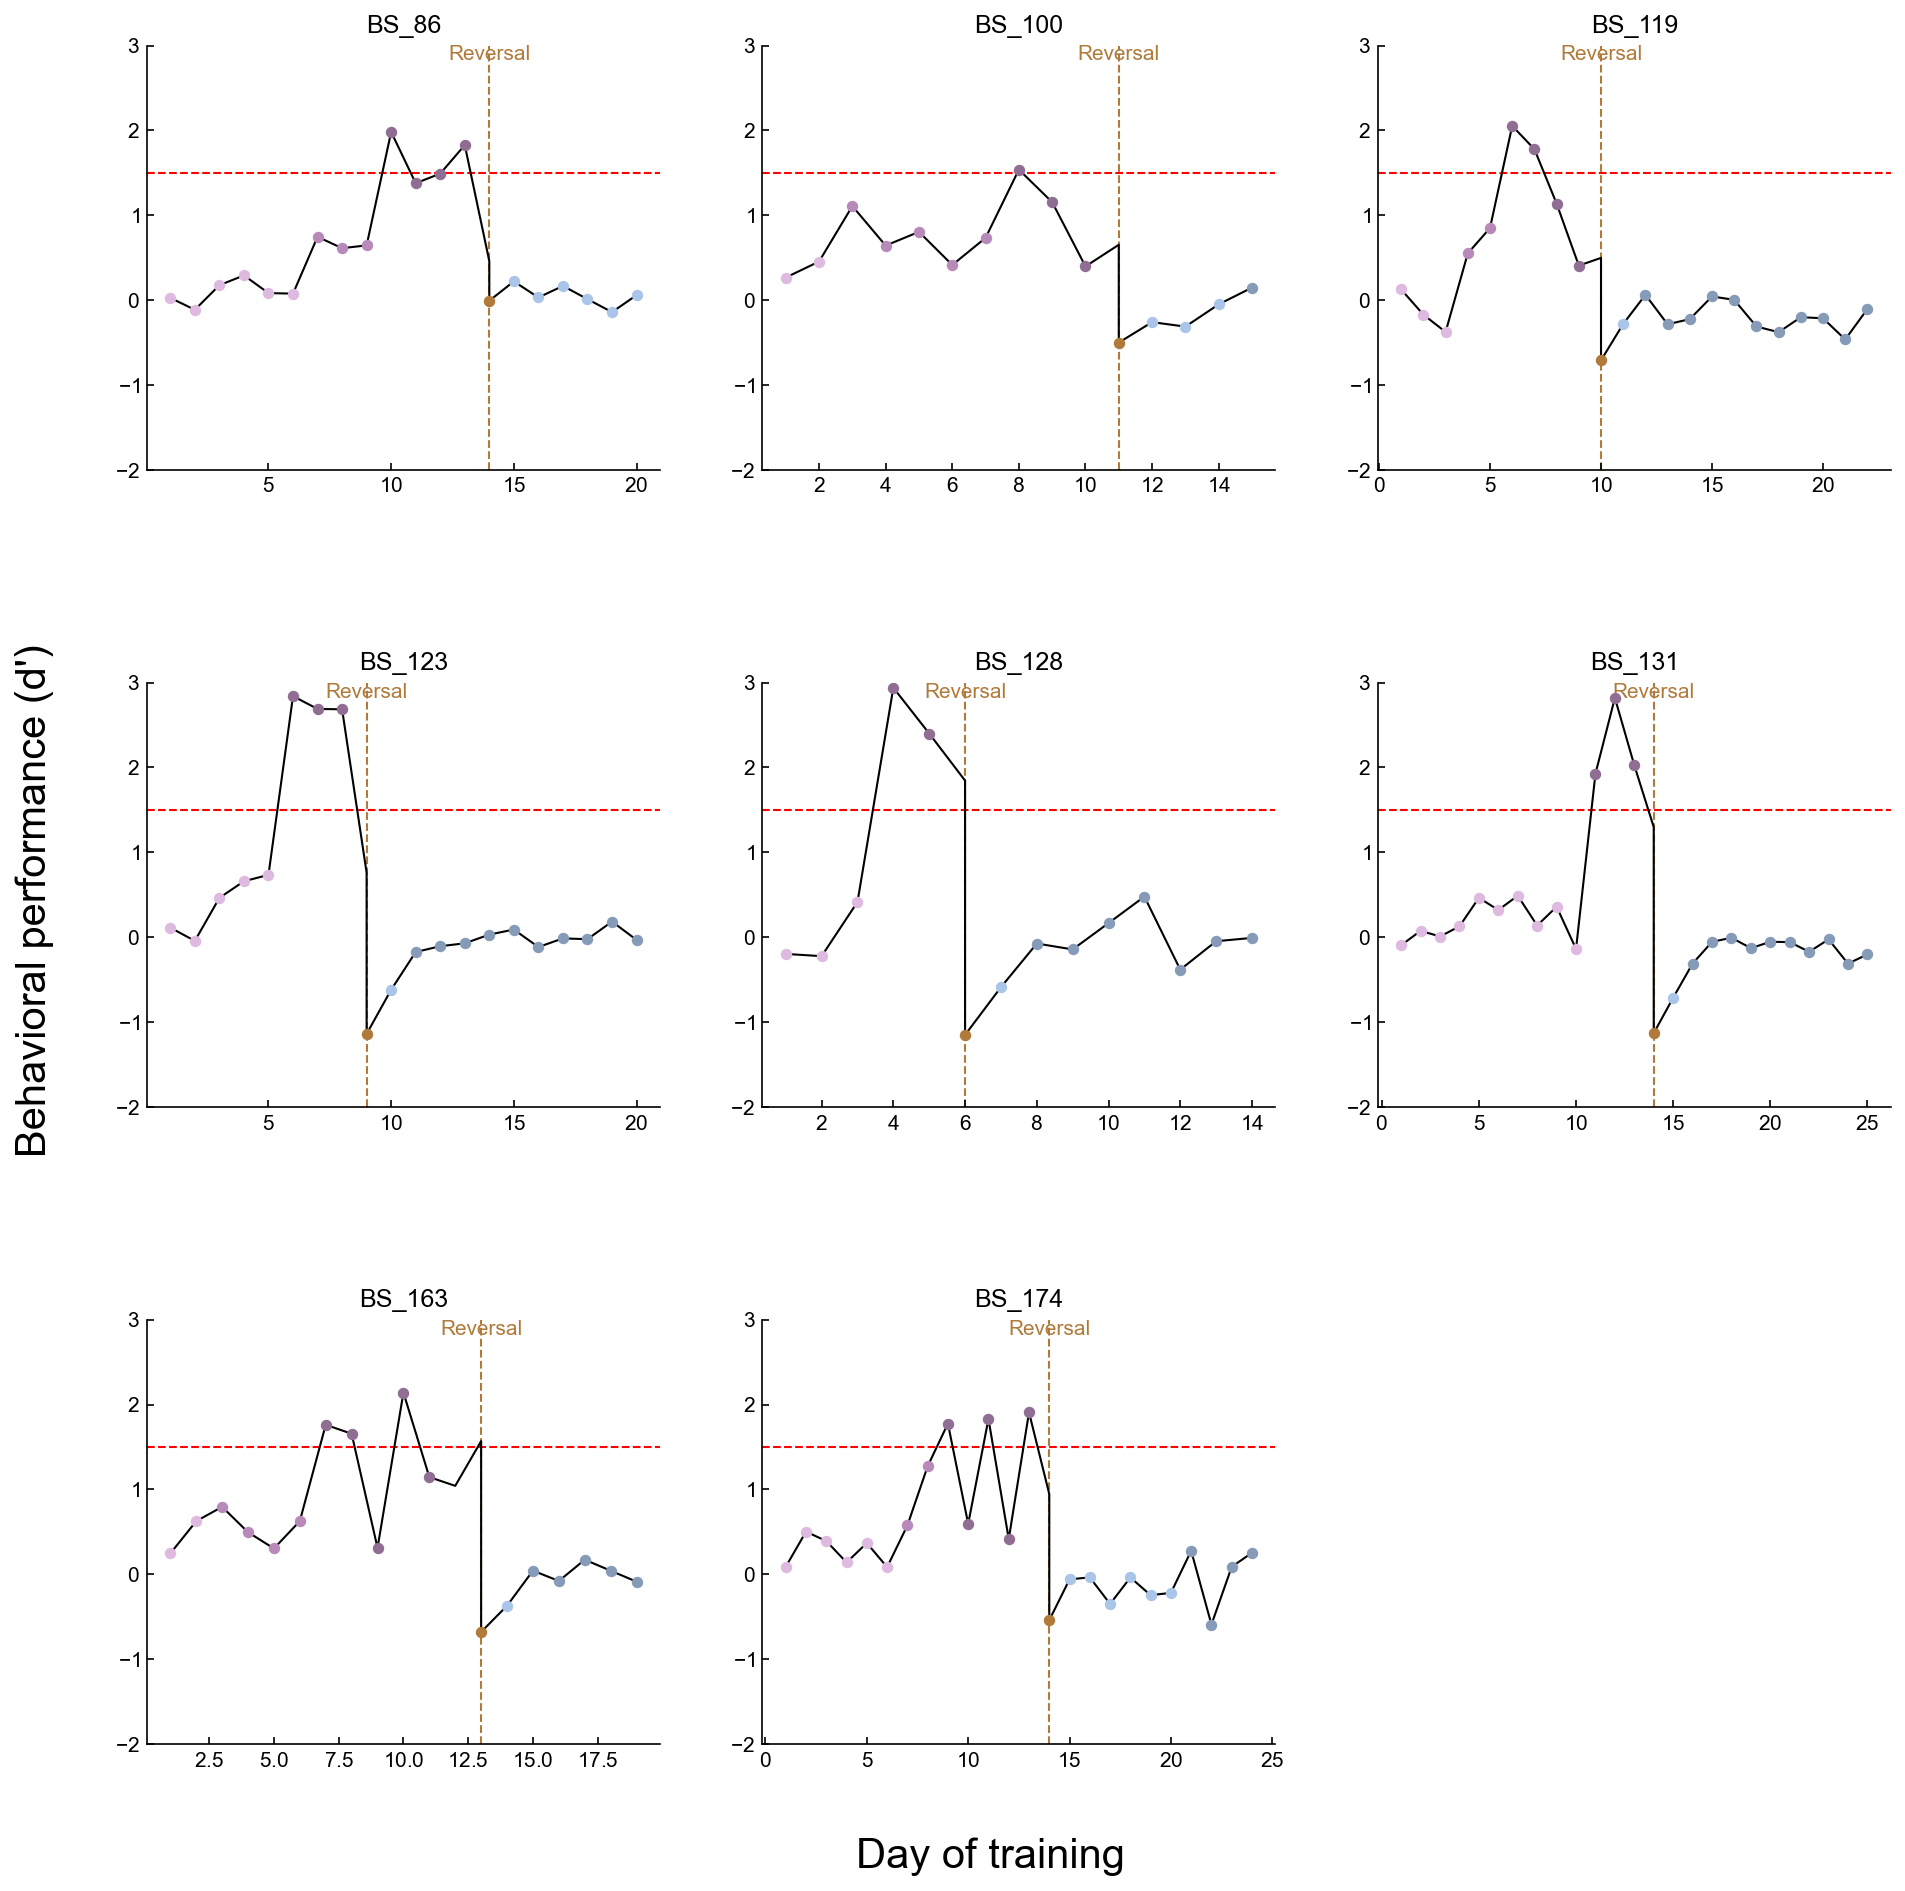

In [263]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True,noTrim=False)
learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
for d in learning_phases2:
    learning_phases[d] = learning_phases2[d]

In [289]:
EnumSessionOps = []
# EnumClust = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in did_not_learn:
        continue
        
    if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue
    
    EnumSessionOps.append(session)
    
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)

100%|██████████| 167/167 [00:02<00:00, 59.63it/s]


In [352]:
EILphasesOps = np.full_like(EnumSessionOps,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionOps)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        rev_day = animalBehaviors[sessionfile.meta.animal].reversal
        day_relative_to_rev = day - rev_day
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphasesOps[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesOps[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesOps[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesOps[idx] = 'pre expert'

#         elif day_relative_to_rev in [1,2]:
#             EILphasesOps[idx] = 'post early'          #CR
#         elif day_relative_to_rev in [3,4]:
#             EILphasesOps[idx] = 'post late'
#         elif day_relative_to_rev >= 5:
#             EILphasesOps[idx] = 'post expert'
            
        elif day_relative_to_rev in [1,2,3,4]:
            EILphasesOps[idx] = 'post early'          #NCR
        elif day_relative_to_rev in [5,6,7]:
            EILphasesOps[idx] = 'post late'
        elif day_relative_to_rev >= 8:
            EILphasesOps[idx] = 'post expert'
    except Exception as e:
#         print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        print(e)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 52/52 [00:00<00:00, 74.91it/s] 

errors for: []


In [298]:
EnumSession = []
# EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    EnumSession.append(session)
    
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)

100%|██████████| 740/740 [00:09<00:00, 79.53it/s] 


In [299]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 144/144 [00:01<00:00, 100.47it/s]

errors for: []


In [268]:
sessionfile.clusters.good

array([15, 18, 53, 56, 57, 62, 68], dtype=int64)

In [269]:
sessionfile.meta

namespace(directory='D:\\DualRecording\\DS_19\\DS_19 9\\AC\\',
          region='AC',
          animal='DS_19',
          probe=6928,
          date='05/04/2021',
          depth=1300,
          task='reversal',
          day_of_training=19,
          day_of_recording=9,
          day_of_reversal=8,
          length_in_samples=99398253.0,
          files=['May 4 2021 Dual DS_19_9001',
                 'May 4 2021 Dual DS_19_9002',
                 'May 4 2021 Dual DS_19_9003',
                 'May 4 2021 Dual DS_19_9004',
                 'May 4 2021 Dual DS_19_9005'],
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0,
          lickdelayrelativetotone=-0.1,
          fs=30000,
          length_in_seconds=3313.2751,
          length_in_minutes=55.22125166666667,
          length_in_trials=661)

In [11]:
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)
rates = get_separable_rates(sessionfile,sessionfile.clusters.good,'all_trials',bin_length_msec=50,trialsPerDayLoaded=trialsPerDayLoaded,pre_stim_padding_sec=0.2)

NameError: name 'get_separable_rates' is not defined

In [12]:
len(np.concatenate(rates[0]))

NameError: name 'rates' is not defined

In [13]:
float(np.cov(np.concatenate(rates[0])))

NameError: name 'rates' is not defined

In [14]:
a = np.concatenate(rates[0])
b = np.concatenate(rates[17])

NameError: name 'rates' is not defined

In [ ]:
a

In [ ]:
b

In [ ]:
c = np.vstack((a,b))

In [ ]:
d = np.cov(c)

In [ ]:
d.shape == (2,2)

In [ ]:
print('loaded')

# Function Definitions

In [270]:
# sq_vars = []
# sq_covars = []
# pred_covars = []
# covars = []

# def calculate_avg_sq_var(directory,session):

#     sessionfile = ilep.loadSessionCached(directory,session)
#     ensemble = sessionfile.clusters.good
#     n_clust = len(ensemble)
#     if (n_clust < 2):
#         return np.nan,np.nan,np.nan
    
#     with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
#         trialsPerDayLoaded = pickle.load(f)
#     rates = ilep.flatten_rates(sessionfile,ensemble,'all_trials',bin_length_msec=50,trialsPerDayLoaded=trialsPerDayLoaded,pre_stim_padding_sec=0.2)
#     cov_mat = np.cov(rates)
    
#     variances = cov_mat[np.eye(n_clust,n_clust,dtype='bool')]
#     covariances = cov_mat[~np.eye(n_clust,n_clust,dtype='bool')]

#     avg_sq_vars = np.mean(variances**2)
#     avg_sq_covars = np.mean(covariances**2)
#     covars.append(np.mean(covariances))
#     avg_pred_covars = np.mean(np.outer(variances,variances)[~np.eye(n_clust,n_clust,dtype='bool')])
    
#     return avg_sq_vars,avg_sq_covars,avg_pred_covars

# for session in tqdm(EnumSession):
#     try:
#         a,b,c = calculate_avg_sq_var(act_directory,session)        
#         sq_vars.append(a)
#         sq_covars.append(b)
#         pred_covars.append(c)
#     except Exception as e:
#         print(f"{session} error: {e}")

In [271]:
def get_separable_rates(sessionfile,clusts,cond,bin_length_msec=50,pre_stim_padding_sec = 0.2,trialsPerDayLoaded=None):
    if type(clusts) == int or type(clusts) == float:
        clusts = [clusts]
    assert type(clusts) == list or type(clusts) == np.ndarray
    
    #allConds = ilep.getAllConditions(sessionfile,None,trialsPerDayLoaded=trialsPerDayLoaded)
    #trials = allConds[cond].trials
    trials = range(sessionfile.meta.length_in_trials)
    
    n_clusts = len(clusts)
    n_trials = len(trials)
    n_bins = int((sessionfile.meta.triallength+pre_stim_padding_sec)*1000 / bin_length_msec)
    
    rates_per_clust = dict()
    rates_per_clust['trials'] = trials
    for clust in clusts:
        rates_per_clust[clust] = []
    
    for clust in clusts:
        clust_rates = []
        clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
        
        for trial_idx,trial in enumerate(trials):
            trial_rates = np.full(n_bins,np.nan)
            for bin_idx,bin in enumerate(range(n_bins)):
                bin_start = sessionfile.trials.starts[trial] - pre_stim_padding_sec * sessionfile.meta.fs + bin*(bin_length_msec/1000*sessionfile.meta.fs)
                bin_end = bin_start + bin_length_msec/1000*sessionfile.meta.fs
                spike_times = ilep.getSpikeTimes(sessionfile,starttime=bin_start,endtime=bin_end,cachedtimes=clust_spikes)
                trial_rates[bin_idx] = len(spike_times) / bin_length_msec * 1000
            clust_rates.append(trial_rates)
        rates_per_clust[clust] = clust_rates
    return rates_per_clust

In [272]:
def get_trimmed_cov_mat(sessionfile,independent_trial_threshold=100,paired_trial_threshold=100):
    clusts = sessionfile.clusters.good
    with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)
    
    #Calculate variances
    rates = get_separable_rates(sessionfile,clusts,'all_trials',bin_length_msec=50,trialsPerDayLoaded=trialsPerDayLoaded,pre_stim_padding_sec=0.2)
    cov_mat = np.full((len(clusts),len(clusts)),np.nan)
    for clust_idx,clust in enumerate(clusts):
        clust_rates = np.array(rates[clust])
        trials = ilep.getAllConditions(sessionfile,clust)['all_trials'].trials
        if len(trials) < independent_trial_threshold:
            cov_mat[clust_idx,clust_idx] = np.nan
            continue
        clust_rates = np.concatenate(clust_rates[trials])
        cov_mat[clust_idx,clust_idx] = float(np.cov(clust_rates))
    
    #Calculate pairwise covariances -- trim according to paired cells
    for i,clust_i in enumerate(clusts):
        for j,clust_j in enumerate(clusts):
            if i==j:
                continue
            
            #Remove covariances between cells with no overlapping firing
            allConds = ilep.getAllConditions(sessionfile,[clust_i,clust_j])
            if len(allConds['all_trials'].trials) < paired_trial_threshold:
                cov_mat[i,j] = np.nan
                cov_mat[j,i] = np.nan
                continue
            
            #Extract paired rates
            trials_involved = allConds['all_trials'].trials
            clust_i_rates = np.array(rates[clust_i])
            clust_i_rates = np.concatenate(clust_i_rates[trials_involved])
            clust_j_rates = np.array(rates[clust_j])
            clust_j_rates = np.concatenate(clust_j_rates[trials_involved])
            paired_rates = np.vstack((clust_i_rates,clust_j_rates))
            
            #Calculate paired covariances
            paired_cov_mat = np.cov(paired_rates)
            assert paired_cov_mat.shape == (2,2)
            assert paired_cov_mat[0,1] == paired_cov_mat[1,0]
            cov_mat[i,j] = paired_cov_mat[0,1]
            cov_mat[j,i] = paired_cov_mat[0,1]
            
    return cov_mat

In [273]:
def calculate_cov_mats(directory,session):

    sessionfile = ilep.loadSessionCached(directory,session)
    ensemble = sessionfile.clusters.good
    n_clust = len(ensemble)
    if (n_clust < 2):
        return np.nan,np.nan,np.nan
    
    with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)
        
    cov_mat = get_trimmed_cov_mat(sessionfile)
#     rates = ilep.flatten_rates(sessionfile,ensemble,'all_trials',bin_length_msec=50,trialsPerDayLoaded=trialsPerDayLoaded,pre_stim_padding_sec=0.2)
#     cov_mat = np.cov(rates)
    
    FRmods = [sessionfile.responsiveness[clust]['all_trials'].FRmodulation for clust in ensemble]
    mask_CR = np.greater_equal(FRmods,3.5)
    mask_NCR = np.less(FRmods,3.5)
    
    cov_mat_CR = np.array([c[mask_CR] for c in cov_mat[mask_CR]])
    cov_mat_NCR = np.array([c[mask_NCR] for c in cov_mat[mask_NCR]])
    
    return cov_mat,cov_mat_CR,cov_mat_NCR
    
def calculate_dimm(cov_mat):
    assert cov_mat.shape[0] == cov_mat.shape[1]
    n_clust = cov_mat.shape[0]

    variances = cov_mat[np.eye(n_clust,n_clust,dtype='bool')]
    covariances = cov_mat[~np.eye(n_clust,n_clust,dtype='bool')]

    avg_sq_vars = np.mean(variances**2)
    avg_sq_covars = np.mean(covariances**2)
    avg_pred_covars = np.mean(np.outer(variances,variances)[~np.eye(n_clust,n_clust,dtype='bool')])
    
    d_var = (1+(n_clust-1)*(avg_pred_covars / avg_sq_vars))         /          (1+(n_clust-1)*0)
    d_cov = (1+(n_clust-1)*1)                                       /          (1+(n_clust-1)*(avg_sq_covars / avg_sq_vars))
    d_GT  = (1+(n_clust-1)*(avg_pred_covars / avg_sq_vars))         /          (1+(n_clust-1)*(avg_sq_covars / avg_sq_vars))
    
    return avg_sq_vars,avg_sq_covars,avg_pred_covars

# for session in tqdm(EnumSession):
#     try:
#         a,b,c = calculate_avg_sq_var(act_directory,session)        
#         sq_vars.append(a)
#         sq_covars.append(b)
#         pred_covars.append(c)
#     except Exception as e:
#         print(f"{session} error: {e}"

In [274]:
def trad_stats_num_den(cov_mats_1,cov_mats_2):
    
    all_vars1 = []
    all_covars1 = []
    for cov in cov_mats_1:
        if type(cov) is float:
            continue
        cov = np.array(cov)
        if len(cov.shape) < 2:
            continue
        assert cov.shape[0] == cov.shape[1]
        n_clust = cov.shape[0]

        this_vars1 = cov[np.eye(n_clust,n_clust,dtype='bool')]
        this_covars1 = cov[~np.eye(n_clust,n_clust,dtype='bool')]
        all_vars1.append(this_vars1)
        all_covars1.append(this_covars1)
    all_vars1 = np.concatenate(all_vars1)
    all_covars1 = np.abs(np.concatenate(all_covars1))
#     n = len(all_vars1)
#     sq_covars1 = (all_covars1**2)
#     pred_covars1 = (np.outer(all_vars1,all_vars1)[~np.eye(n,n,dtype='bool')])
    
    all_vars2 = []
    all_covars2 = []
    for cov in cov_mats_2:
        if type(cov) is float:
            continue
        cov = np.array(cov)
        if len(cov.shape) < 2:
            continue
        assert cov.shape[0] == cov.shape[1]
        n_clust = cov.shape[0]

        this_vars2 = cov[np.eye(n_clust,n_clust,dtype='bool')]
        this_covars2 = cov[~np.eye(n_clust,n_clust,dtype='bool')]
        all_vars2.append(this_vars2)
        all_covars2.append(this_covars2)
    all_vars2 = np.concatenate(all_vars2)
    all_covars2 = np.abs(np.concatenate(all_covars2))
#     n = len(all_vars2)
#     sq_covars2 = (all_covars2**2)
#     pred_covars2 = (np.outer(all_vars2,all_vars2)[~np.eye(n,n,dtype='bool')])

#     print(f"condition 1 has {len(all_covars1)} data points, {np.sum(np.isfinite(all_covars1))} non-nan, mean = {np.nanmean(all_covars1)}, SEM = {sem(ilep.rmnan(all_covars1))}")
#     print(f"condition 2 has {len(all_covars2)} data points, {np.sum(np.isfinite(all_covars2))} non-nan, mean = {np.nanmean(all_covars2)}, SEM = {sem(ilep.rmnan(all_covars2))}")
#     print()
    
    _,p1 = ttest_ind(ilep.rmnan(all_vars1),ilep.rmnan(all_vars2))
#     _,p1 = ttest_ind(ilep.rmnan(pred_covars1),ilep.rmnan(pred_covars2))
    _,p2 = ttest_ind(ilep.rmnan(all_covars1),ilep.rmnan(all_covars2))
    return p1,p2
#     d_GT = avg_pred_covars/avg_sq_covars

In [365]:
def bootstrap_pc_NCR_test_split(cov_mats_1,cov_mats_2,B=250000,n_frac=1):
    
    d_GT_list_1 = []
    d_num_list_1 = []
    d_den_list_1 = []
    for idx_B in range(B):
        try:
            n = len(cov_mats_1)
            sample = np.random.choice(cov_mats_1,n)

            all_vars = []
            all_covars = []
            for cov in sample:
                if type(cov) is float:
                    continue
                cov = np.array(cov)
                if len(cov.shape) < 2:
                    continue
                assert cov.shape[0] == cov.shape[1]
                n_clust = cov.shape[0]

                new_n = int(n_clust*n_frac)
                if new_n < 1:
                    continue
                mask = range(new_n)
                cov= np.array([c[mask] for c in cov[mask]])

                this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
                this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
                all_vars.append(this_vars)
                all_covars.append(this_covars)
            all_vars = np.concatenate(all_vars)
            all_covars = np.concatenate(all_covars)
            
            n = len(all_vars)
            avg_sq_vars = np.nanmean(all_vars**2)
            avg_sq_covars = np.nanmean(all_covars**2)
            avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
            
            d_GT = avg_pred_covars/avg_sq_covars
            d_GT_list_1.append(d_GT)
            d_num_list_1.append(avg_pred_covars)
            d_den_list_1.append(avg_sq_covars)
        except Exception as e:
            print(f"L: {e}")
            d_GT_list_1.append(np.nan)
            d_num_list_1.append(np.nan)
            d_den_list_1.append(np.nan)
    
    d_GT_list_2 = []
    d_num_list_2 = []
    d_den_list_2 = []
    for idx_B in range(B):
        try:
            n = len(cov_mats_2)
            sample = np.random.choice(cov_mats_2,n)

            all_vars = []
            all_covars = []
            for cov in sample:
                if type(cov) is float:
                    continue
                cov = np.array(cov)
                if len(cov.shape) < 2:
                    continue
                assert cov.shape[0] == cov.shape[1]
                n_clust = cov.shape[0]

                new_n = int(n_clust*n_frac)
                if new_n < 1:
                    continue
                mask = range(new_n)
                cov= np.array([c[mask] for c in cov[mask]])

                this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
                this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
                all_vars.append(this_vars)
                all_covars.append(this_covars)
            all_vars = np.concatenate(all_vars)
            all_covars = np.concatenate(all_covars)

            n = len(all_vars)
            avg_sq_vars = np.nanmean(all_vars**2)
            avg_sq_covars = np.nanmean(all_covars**2)
            avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])

            d_GT = avg_pred_covars/avg_sq_covars
            d_GT_list_2.append(d_GT)
            d_num_list_2.append(avg_pred_covars)
            d_den_list_2.append(avg_sq_covars)
        except:
            d_GT_list_2.append(np.nan)
            d_num_list_2.append(np.nan)
            d_den_list_2.append(np.nan)
        
        
        
    #Two-sided test
    X,Y = ilep.paired_rmnan(d_GT_list_1,d_GT_list_2)
    diffs = (np.array(X) - np.array(Y))
    pY = 1 - np.mean(np.greater(diffs,0))
    pX = 1 - np.mean(np.less(diffs,0))
    pboot1 = min(pX,pY)*2
    
    X,Y = ilep.paired_rmnan(d_num_list_1,d_num_list_2)
    diffs = (np.array(X) - np.array(Y))
    pY = 1 - np.mean(np.greater(diffs,0))
    pX = 1 - np.mean(np.less(diffs,0))
    pboot2 = min(pX,pY)*2
    
    X,Y = ilep.paired_rmnan(d_den_list_1,d_den_list_2)
    diffs = (np.array(X) - np.array(Y))
    pY = 1 - np.mean(np.greater(diffs,0))
    pX = 1 - np.mean(np.less(diffs,0))
    pboot3 = min(pX,pY)*2
    return pboot1,pboot2,pboot3

In [276]:
def bootstrap_dimensionality_all_vars(cov_mats,n_frac=0.5,B=200):
    d_GT_list = []
    d_num_list = []
    d_denom_list = []
    
    for idx_B in range(B):
        n = len(cov_mats)
        sample = np.random.choice(cov_mats,n)
#         sample = cov_mats
        
        all_vars = []
        all_covars = []
        for cov in sample:
            if type(cov) is float:
                continue
            cov = np.array(cov)
            if len(cov.shape) < 2:
                continue
            assert cov.shape[0] == cov.shape[1]
            n_clust = cov.shape[0]
            
            new_n = int(n_clust*n_frac)
            if new_n < 1:
                continue
            mask = range(new_n)
            cov= np.array([c[mask] for c in cov[mask]])

            this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
            this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
            all_vars.append(this_vars)
            all_covars.append(this_covars)
        all_vars = np.concatenate(all_vars)
        all_covars = np.concatenate(all_covars)

        n = len(all_vars)
        avg_sq_vars = np.nanmean(all_vars**2)
        avg_sq_covars = np.nanmean(all_covars**2)
        avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
        
#         d_GT = calc_dim(n,avg_pred_covars/avg_sq_vars,avg_sq_covars/avg_sq_vars)
        d_GT = avg_pred_covars/avg_sq_covars
        d_GT_list.append(d_GT)
        d_num_list.append(avg_pred_covars)
        d_denom_list.append(avg_sq_covars)
        
    d_GT_list = ilep.rmnan(d_GT_list)
    d_GT_estimate = np.mean(d_GT_list)
    SEM_d_GT_estimate = sem(d_GT_list)# / np.sqrt(B)
    
#     d_num_list = ilep.rmnan(d_num_list)
#     d_num_estimate = np.mean(d_num_list)
#     SEM_d_num_estimate = np.std(d_num_list)
    
#     d_denom_list = ilep.rmnan(d_denom_list)
#     d_denom_estimate = np.mean(d_denom_list)
#     SEM_d_denom_estimate = np.std(d_denom_list)

    all_vars = []
    all_covars = []
    for cov in cov_mats:
        if type(cov) is float:
            continue
        cov = np.array(cov)
        if len(cov.shape) < 2:
            continue
        assert cov.shape[0] == cov.shape[1]
        n_clust = cov.shape[0]

        new_n = int(n_clust*n_frac)
        if new_n < 1:
            continue
        mask = range(new_n)
        cov= np.array([c[mask] for c in cov[mask]])

        this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
        this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
        all_vars.append(this_vars)
        all_covars.append(this_covars)
    all_vars = np.concatenate(all_vars)
    all_covars = np.concatenate(all_covars)
        
    all_vars = ilep.rmnan(all_vars)
    all_covars = ilep.rmnan(np.abs(all_covars)) #abs because only the squared value matters for the calculation
        
    return d_GT_estimate,SEM_d_GT_estimate,  np.mean(all_vars),sem(all_vars),   np.mean(all_covars),sem(all_covars)

In [277]:
def bootstrap_dimensionality(cov_mats,n_frac=0.5,B=200):
    d_GT_list = []
    d_num_list = []
    d_denom_list = []
    
    for idx_B in range(B):
        n = len(cov_mats)
        sample = np.random.choice(cov_mats,n)
#         sample = cov_mats
        
        all_vars = []
        all_covars = []
        for cov in sample:
            if type(cov) is float:
                continue
            cov = np.array(cov)
            if len(cov.shape) < 2:
                continue
            assert cov.shape[0] == cov.shape[1]
            n_clust = cov.shape[0]
            
            new_n = int(n_clust*n_frac)
            if new_n < 1:
                continue
            mask = range(new_n)
            cov= np.array([c[mask] for c in cov[mask]])

            this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
            this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
            all_vars.append(this_vars)
            all_covars.append(this_covars)
        all_vars = np.concatenate(all_vars)
        all_covars = np.concatenate(all_covars)

        n = len(all_vars)
        avg_sq_vars = np.nanmean(all_vars**2)
        avg_sq_covars = np.nanmean(all_covars**2)
        avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
        
#         d_GT = calc_dim(n,avg_pred_covars/avg_sq_vars,avg_sq_covars/avg_sq_vars)
        d_GT = avg_pred_covars/avg_sq_covars
        d_GT_list.append(d_GT)
        d_num_list.append(avg_pred_covars)
        d_denom_list.append(avg_sq_covars)
        
    d_GT_list = ilep.rmnan(d_GT_list)
    d_GT_estimate = np.mean(d_GT_list)
    SEM_d_GT_estimate = np.std(d_GT_list)# / np.sqrt(B)
    
    d_num_list = ilep.rmnan(d_num_list)
    d_num_estimate = np.mean(d_num_list)
    SEM_d_num_estimate = np.std(d_num_list)
    
    d_denom_list = ilep.rmnan(d_denom_list)
    d_denom_estimate = np.mean(d_denom_list)
    SEM_d_denom_estimate = np.std(d_denom_list)
        
    return d_GT_estimate,SEM_d_GT_estimate,  d_num_estimate,SEM_d_num_estimate,   d_denom_estimate,SEM_d_denom_estimate

In [366]:
def bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac=0.5,B=200):
    d_GT_list = []
    d_num_list = []
    d_denom_list = []
    
    for idx_B in range(B):
        n = len(cov_mats)
        sample = np.random.choice(cov_mats,n)
#         sample = cov_mats
        
        all_vars = []
        all_covars = []
        for cov in sample:
            if type(cov) is float:
                continue
            cov = np.array(cov)
            if len(cov.shape) < 2:
                continue
            assert cov.shape[0] == cov.shape[1]
            n_clust = cov.shape[0]
            
            new_n = int(n_clust*n_frac)
            if new_n < 1:
                continue
            mask = range(new_n)
            cov= np.array([c[mask] for c in cov[mask]])

            this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
            this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
            all_vars.append(this_vars)
            all_covars.append(this_covars)
        all_vars = np.concatenate(all_vars)
        all_covars = np.concatenate(all_covars)

        n = len(all_vars)
        avg_sq_vars = np.nanmean(all_vars**2)
        avg_sq_covars = np.nanmean(all_covars**2)
        avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
        
#         d_GT = calc_dim(n,avg_pred_covars/avg_sq_vars,avg_sq_covars/avg_sq_vars)
        d_GT = avg_pred_covars/avg_sq_covars
        d_GT_list.append(d_GT)
        d_num_list.append(avg_pred_covars)
        d_denom_list.append(avg_sq_covars)
        
    d_GT_list = ilep.rmnan(d_GT_list)
    d_GT_estimate = np.median(d_GT_list)
    d_GT_Q1_estimate = np.percentile(d_GT_list,25)
    d_GT_Q3_estimate = np.percentile(d_GT_list,75)
    SEM_d_GT_estimate = sem(d_GT_list)# / np.sqrt(B)

    all_vars = []
    all_covars = []
    for cov in cov_mats:
        if type(cov) is float:
            continue
        cov = np.array(cov)
        if len(cov.shape) < 2:
            continue
        assert cov.shape[0] == cov.shape[1]
        n_clust = cov.shape[0]

        new_n = int(n_clust*n_frac)
        if new_n < 1:
            continue
        mask = range(new_n)
        cov= np.array([c[mask] for c in cov[mask]])

        this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
        this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
        all_vars.append(this_vars)
        all_covars.append(this_covars)
    all_vars = np.concatenate(all_vars)
    all_covars = np.concatenate(all_covars)
        
    all_vars = ilep.rmnan(all_vars)
    all_covars = ilep.rmnan(np.abs(all_covars)) #abs because only the squared value matters for the calculation
    
#     print(f"{np.mean(d_GT_estimate)} +/- {np.std(d_GT_estimate)}")
#     print(f"{d_GT_Q1_estimate} +/- {d_GT_Q3_estimate}")
        
    return d_GT_estimate,d_GT_Q1_estimate,d_GT_Q3_estimate,  np.median(all_vars),np.percentile(all_vars,25),np.percentile(all_vars,75),   np.median(all_covars),np.percentile(all_covars,25),np.percentile(all_covars,75)

In [264]:
cov_mats = []
cov_mats_CR = []
cov_mats_NCR = []

for session in tqdm(EnumSession):
    try:
        a,b,c = calculate_cov_mats(act_directory,session)        
        cov_mats.append(a)
        cov_mats_CR.append(b)
        cov_mats_NCR.append(c)
    except Exception as e:
        print(f"{session} error: {e}")
        raise e

 49%|████▊     | 70/144 [52:37<08:30,  6.90s/it]   

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

 49%|████▉     | 71/144 [52:40<07:12,  5.93s/it]

session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [12, 4] tried to load saved active trials but failed. Error: 22


100%|██████████| 144/144 [1:36:03<00:00, 40.03s/it] 


In [266]:
Data = SimpleNamespace()
Data.cov_mats = cov_mats
Data.cov_mats_CR = cov_mats_CR
Data.cov_mats_NCR = cov_mats_NCR
with open('D:\\Cov_Mats.pickle', 'wb') as f:
    pickle.dump(Data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [267]:
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)

In [268]:
Data

namespace(cov_mats=[array([[ 54.3010501 ,  14.76378243,   1.62717022,  11.80107435,
                             15.93916708,  11.50370718],
                           [ 14.76378243, 243.47746986, -39.80829682,  20.92873032,
                             23.24896966,  12.92538967],
                           [  1.62717022, -39.80829682, 233.68896348,  25.50449647,
                              6.04873731,  37.80288612],
                           [ 11.80107435,  20.92873032,  25.50449647, 113.81034555,
                             14.84761198,  19.76285685],
                           [ 15.93916708,  23.24896966,   6.04873731,  14.84761198,
                            149.37404918,  26.40776699],
                           [ 11.50370718,  12.92538967,  37.80288612,  19.76285685,
                             26.40776699, 272.9239442 ]]),
                    array([[137.47946799,          nan,   7.21304285,   5.15684464],
                           [         nan,          nan,          na

In [269]:
sessionfile.clusters.good

array([  0,  17,  32,  33,  46,  58,  63,  83,  84,  94, 113, 119, 167,
       169, 173, 174, 186, 188, 194, 222, 227, 238, 246, 253, 261, 288,
       318, 327, 338, 342, 345, 346, 352, 354, 359, 360, 361, 363],
      dtype=int64)

In [111]:
EnumSession[24]

'BS_41_1_AC.pickle'

In [117]:
cov = Data.cov_mats[24]
for i,row in enumerate(cov):
    for j,col in enumerate(row):
        if col == 1323.1471545130914:
            print(f"{i},{j}")

8,36
36,8


In [123]:
print(sessionfile.clusters.good[8])
print(sessionfile.clusters.good[36])

84
361


In [125]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_41_1_AC.pickle')
print(sessionfile.responsiveness[84]['all_trials'].FRmodulation)
print(sessionfile.responsiveness[361]['all_trials'].FRmodulation)

13.47865576748412
30.554041780199807


In [337]:
all_vars = []
for cov in Data.cov_mats:
    if type(cov) is float:
        continue
    cov = np.array(cov)
    if len(cov.shape) < 2:
        continue
    assert cov.shape[0] == cov.shape[1]
    n_clust = cov.shape[0]
    
    this_vars = cov[np.eye(n_clust,n_clust,dtype='bool')]
    all_vars.append(this_vars)
all_vars = np.concatenate(all_vars)

all_covars = []
for idx,cov in enumerate(Data.cov_mats):
    if type(cov) is float:
        continue
    cov = np.array(cov)
    if len(cov.shape) < 2:
        continue
    assert cov.shape[0] == cov.shape[1]
    n_clust = cov.shape[0]
    
    this_covars = cov[~np.eye(n_clust,n_clust,dtype='bool')]
    all_covars.append(this_covars)
all_covars = np.concatenate(all_covars)

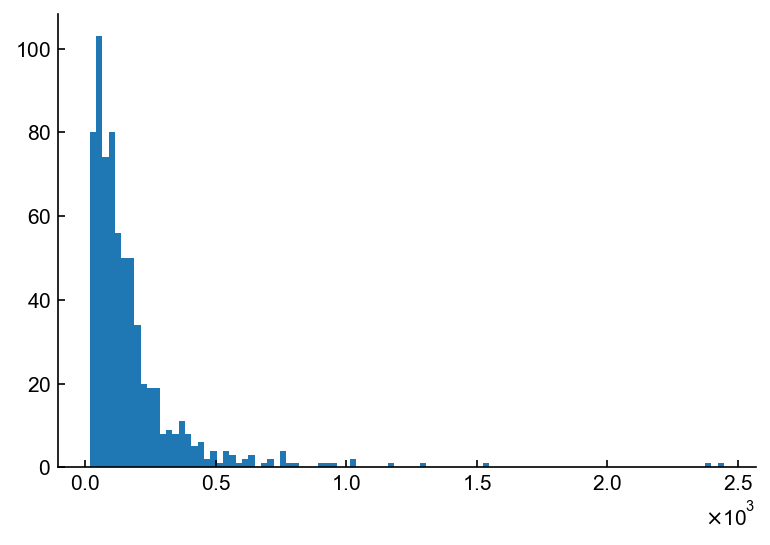

In [294]:
# CR
plt.hist(all_vars,bins=100)
pass

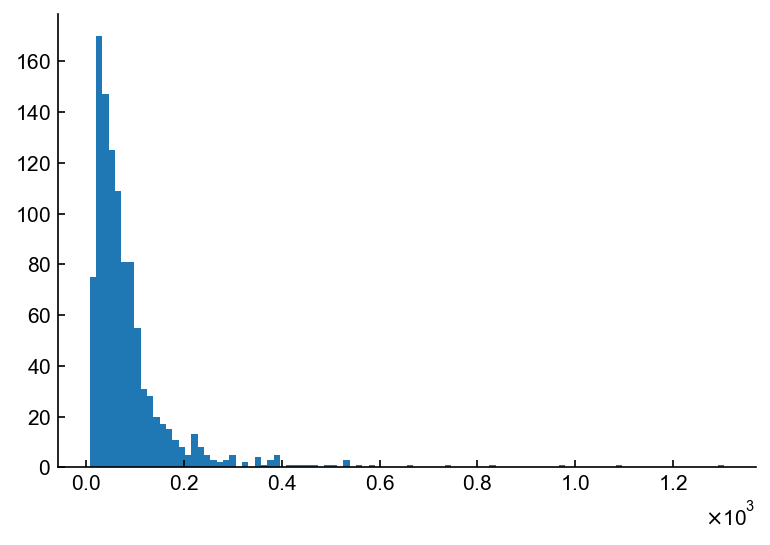

In [296]:
# NCR
plt.hist(all_vars,bins=100)
pass

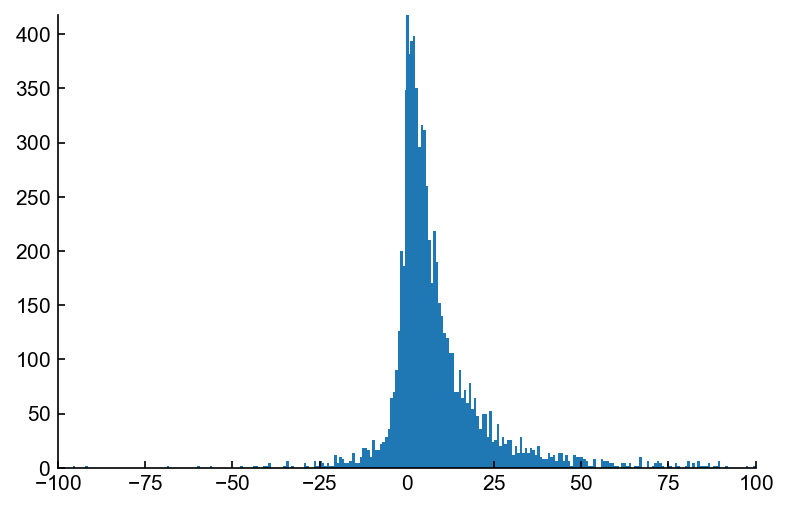

In [301]:
plt.hist(all_covars,bins=1000)
plt.xlim([-100,100])
plt.axvline(0)
pass

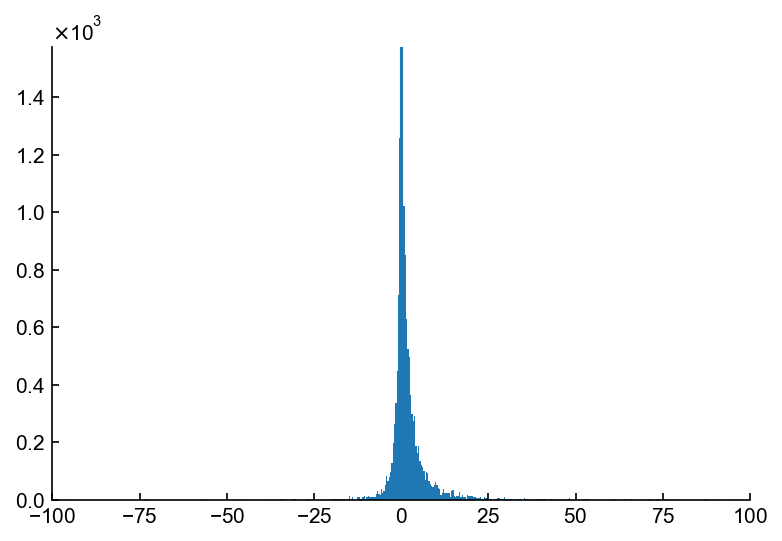

In [303]:
plt.hist(all_covars,bins=1000)
plt.xlim([-100,100])
plt.axvline(0)
pass

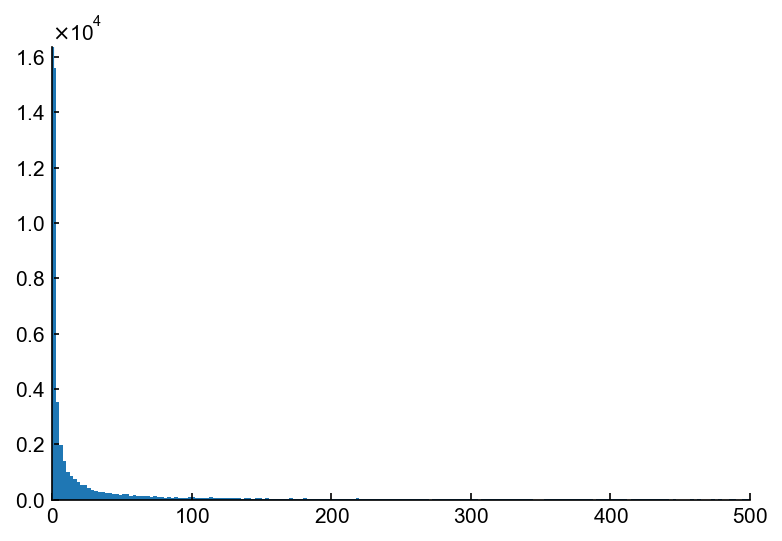

In [273]:
a = np.power(all_covars,2)
a = a[np.less(a,2500)]

plt.hist(a,bins=1000)
plt.xlim([0,500])
plt.axvline(0)
pass

In [274]:
max(np.abs(all_covars))

621.5088503606352

In [275]:
621.5088503606352*621.5088503606352

386273.2510765984

In [276]:
max((all_covars))

621.5088503606352

In [ ]:
def calc_dim(n,a,b):
    num = 1+(n-1)*a
    den = 1+(n-1)*b
    return num/den

In [655]:
bootstrap_dimensionality(Data.cov_mats,B=1,n_frac=1)

<ipython-input-654-75c52dcf62b5>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice(cov_mats,n)


(76.26891351013406, 0.0, 13047.176768482028, 0.0, 171.0680822370495, 0.0)

In [428]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase in phases:
    print(f"{phase}: {np.sum(np.char.equal(EILphases,phase))} sessions")

pre early: 6 sessions
pre late: 17 sessions
pre expert: 11 sessions
post early: 33 sessions
post late: 32 sessions
post expert: 29 sessions


In [438]:
len(EnumSession)

144

In [439]:
len(np.array(Data.cov_mats))

<ipython-input-439-1a0103305414>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len(np.array(Data.cov_mats))


144

In [452]:
vals = []
SEMs = []
n_fracs = np.linspace(0.3,1,80)
for n_frac in tqdm(n_fracs):
    M,SEM = bootstrap_dimensionality(Data.cov_mats,n_frac = n_frac,B=25)
    vals.append(M)
    SEMs.append(SEM)

  0%|          | 0/80 [00:00<?, ?it/s]<ipython-input-447-39f6816f83dd>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice(cov_mats,n)
100%|██████████| 80/80 [00:35<00:00,  2.28it/s]


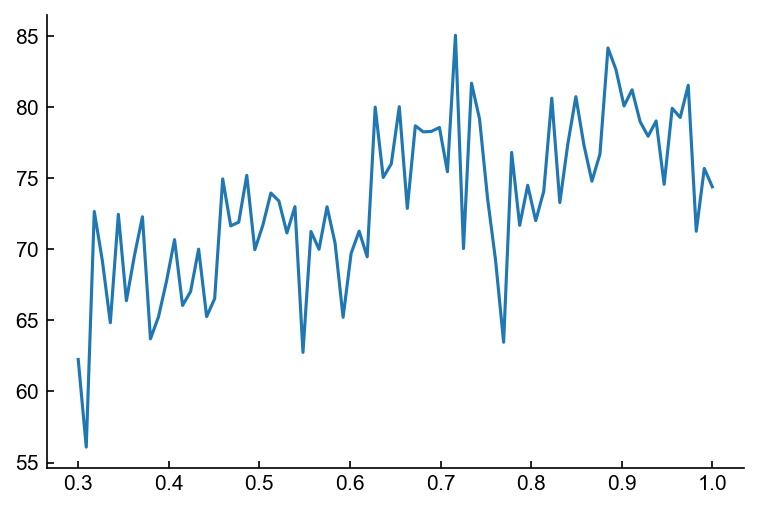

In [453]:
plt.plot(n_fracs,vals)

<ipython-input-459-378dac8ad671>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
100%|██████████| 80/80 [00:00<00:00, 107.09it/s]
<ipython-input-459-378dac8ad671>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
  0%|          | 0/80 [00:00<?, ?it/s]<ipython-input-447-39f6816f83dd>:34: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
 40%|████      | 32/80 [00:00<00:00, 131.12it/s]

L


100%|██████████| 80/80 [00:00<00:00, 99.53it/s] 
<ipython-input-459-378dac8ad671>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
  0%|          | 0/80 [00:00<?, ?it/s]<ipython-input-447-39f6816f83dd>:34: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-447-39f6816f83dd>:35: RuntimeWarning: Mean of empty slice
  avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
100%|██████████| 80/80 [00:00<00:00, 131.30it/s]
<ipython-input-459-378dac8ad671>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

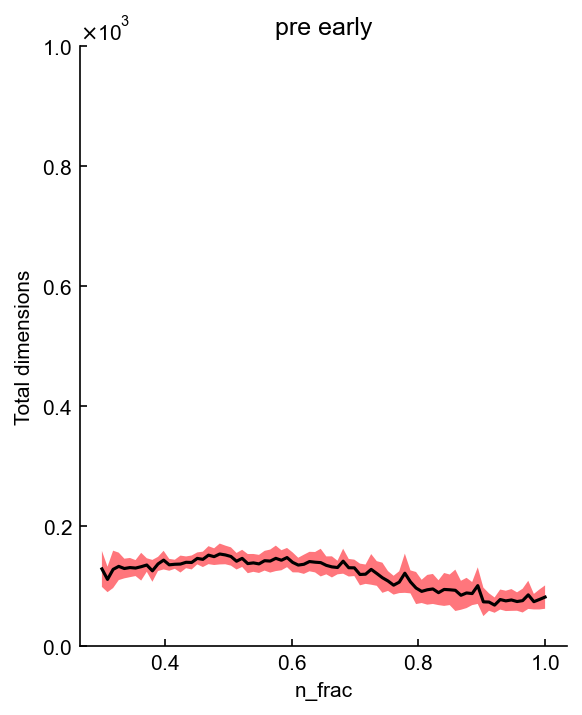

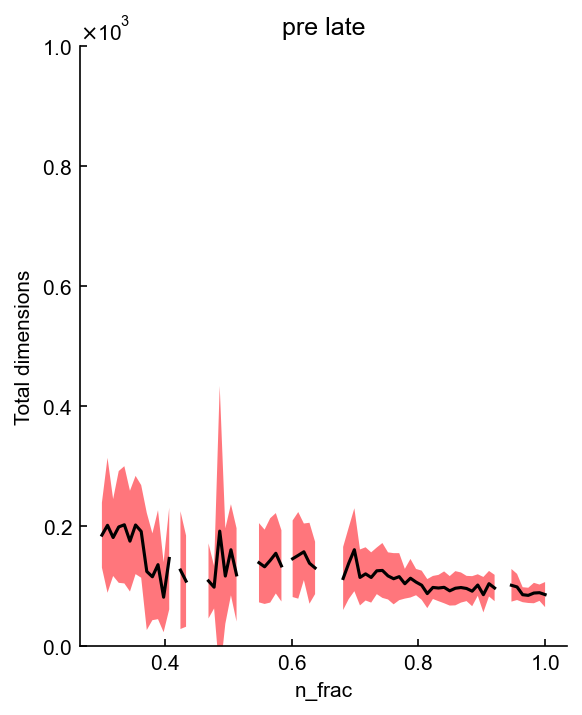

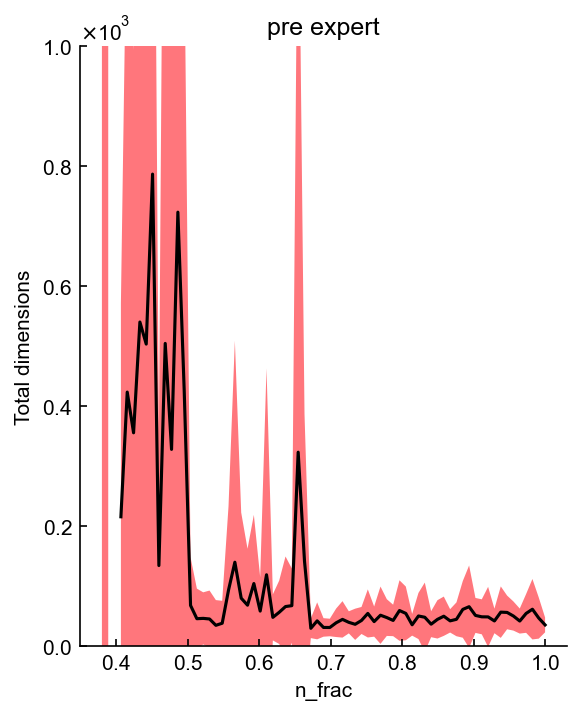

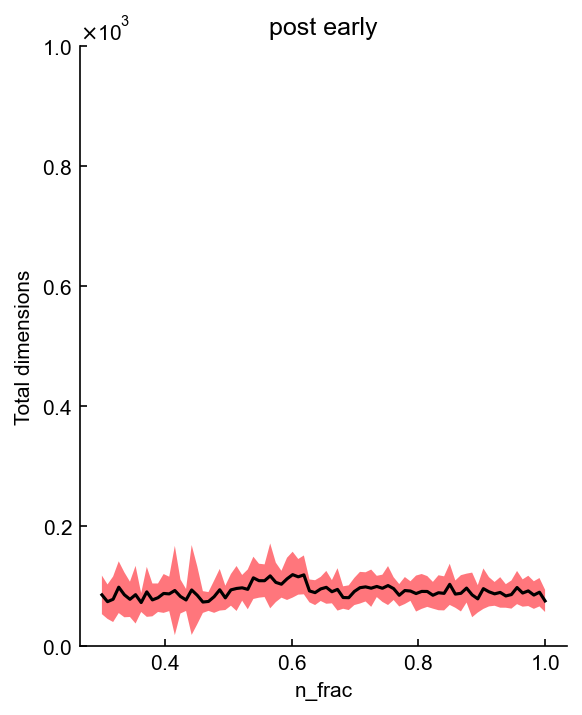

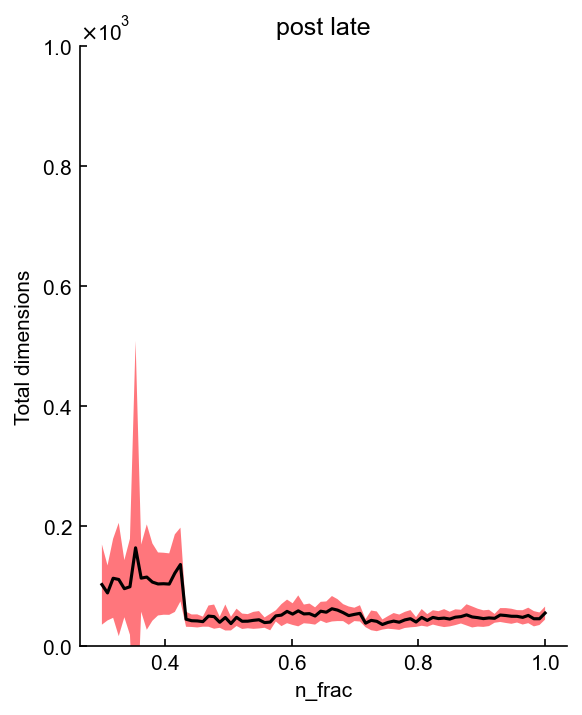

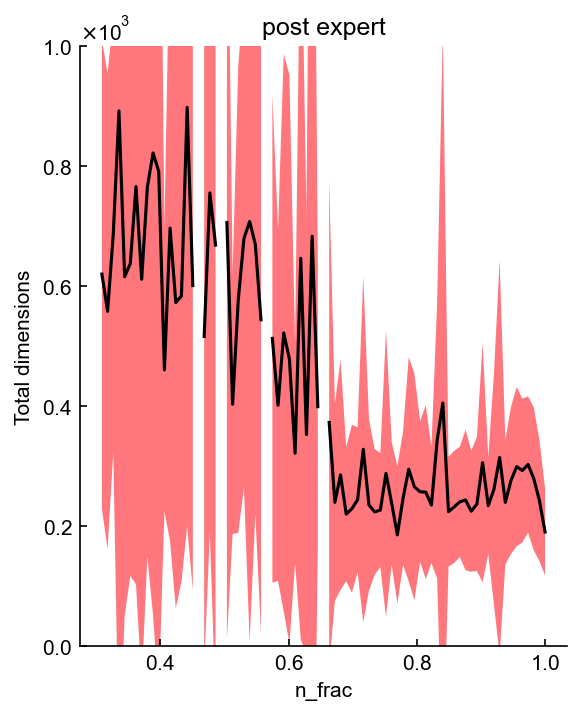

In [459]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase in phases:
    
    phase_mask = np.char.equal(EILphases,phase)
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    
    vals = []
    SEMs = []
    n_fracs = np.linspace(0.3,1,80)
    for n_frac in tqdm(n_fracs):
        try:
            M,SEM = bootstrap_dimensionality(cov_mats,n_frac = n_frac,B=25)
            vals.append(M)
            SEMs.append(SEM)
        except:
            print('L')
            vals.append(np.nan)
            SEMs.append(np.nan)
    
    fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
    ax.plot(n_fracs,vals,c='k')
    ax.fill_between(n_fracs,np.array(vals)-np.array(SEMs),np.array(vals)+np.array(SEMs),fc=NCR_COLOR,lw=0)
    ax.set_xlabel('n_frac')
    ax.set_ylim([0,1000])
    ax.set_ylabel('Total dimensions')
    ax.set_title(phase)
    
    artists = []
    fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level per phase '+phase+' CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

# Logged Dimm and Log Ratios

In [361]:
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)

## All cells

<ipython-input-17-5c77cbf80727>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats)[phase_mask]


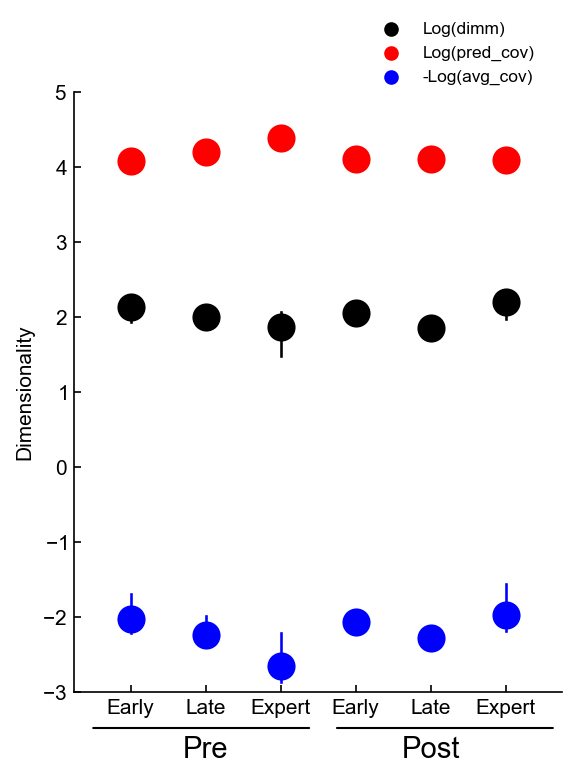

In [17]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [714]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 2500#0
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p1,pp1,ppp1 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p2,pp2,ppp2 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p3,pp3,ppp3 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)


phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p4,pp4,ppp4 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p5,pp5,ppp5 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p6,pp6,ppp6 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)






pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Total')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Numerator')
print(pp_corr)

pppvals = [ppp1,ppp2,ppp3,ppp4,ppp5,ppp6]
_,ppp_corr = pg.multicomp(pppvals,method='fdr_bh')
print('Denominator')
print(ppp_corr)

<ipython-input-714-c9ce6832ec52>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask1]
<ipython-input-714-c9ce6832ec52>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask2]
<ipython-input-714-c9ce6832ec52>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Total
[0.596  0.5784 0.5632 0.3264 0.3264 0.596 ]
Numerator
[0.7648 0.5352 0.3072 0.9368 0.9368 0.9368]
Denominator
[0.5464 0.4068 0.384  0.384  0.384  0.5464]


In [736]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[1.13752340e-057 1.02750576e-063 6.16023502e-232 3.85208695e-002
 3.62646651e-009 5.72830283e-006]
Denominator
[7.25859695e-05 5.89570775e-07 2.78868106e-13 8.09354723e-04
 1.25340813e-03 1.20564071e-01]


<ipython-input-736-7c7779ad4283>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask1]
<ipython-input-736-7c7779ad4283>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask2]
<ipython-input-736-7c7779ad4283>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

## CRs

<ipython-input-704-f2c77f5b4c39>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


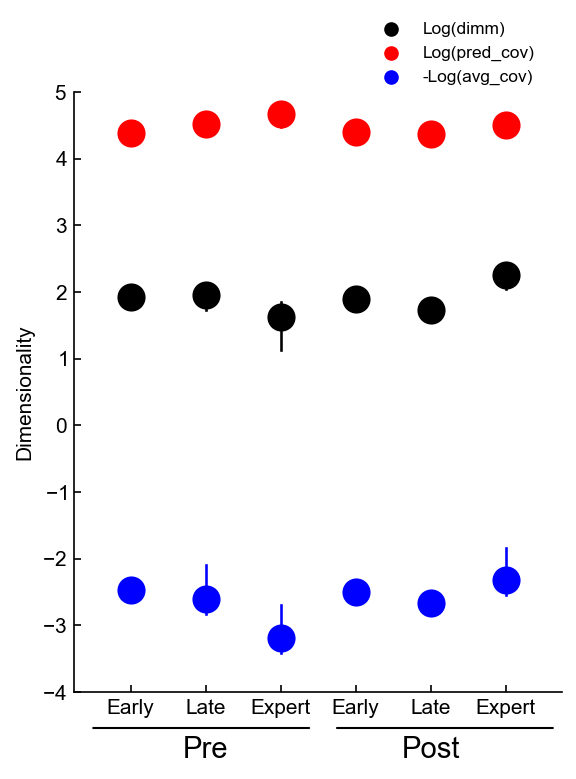

In [704]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [715]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 2500#0
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p1,pp1,ppp1 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p2,pp2,ppp2 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p3,pp3,ppp3 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)


phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p4,pp4,ppp4 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p5,pp5,ppp5 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p6,pp6,ppp6 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)






pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Total')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Numerator')
print(pp_corr)

pppvals = [ppp1,ppp2,ppp3,ppp4,ppp5,ppp6]
_,ppp_corr = pg.multicomp(pppvals,method='fdr_bh')
print('Denominator')
print(ppp_corr)

<ipython-input-715-cd7ea218ed92>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-715-cd7ea218ed92>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
<ipython-input-715-cd7ea218ed92>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

Total
[0.7168  0.28512 0.28512 0.28512 0.096   0.228  ]
Numerator
[0.59424 0.59424 0.59424 0.9208  0.59424 0.59424]
Denominator
[0.5376  0.3552  0.3552  0.44352 0.3552  0.3552 ]


In [737]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[5.88853048e-24 6.30415163e-19 1.15441097e-80 4.02261135e-01
 6.10547960e-26 8.70213368e-20]
Denominator
[4.11279951e-01 1.40938682e-07 5.18508921e-09 8.82004301e-03
 1.91794429e-03 8.82004301e-03]


<ipython-input-737-3a565925fa4c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-737-3a565925fa4c>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
<ipython-input-737-3a565925fa4c>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

## NCRs

<ipython-input-362-01299c0539a3>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
<ipython-input-362-01299c0539a3>:45: RuntimeWarning: invalid value encountered in log10
  ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)


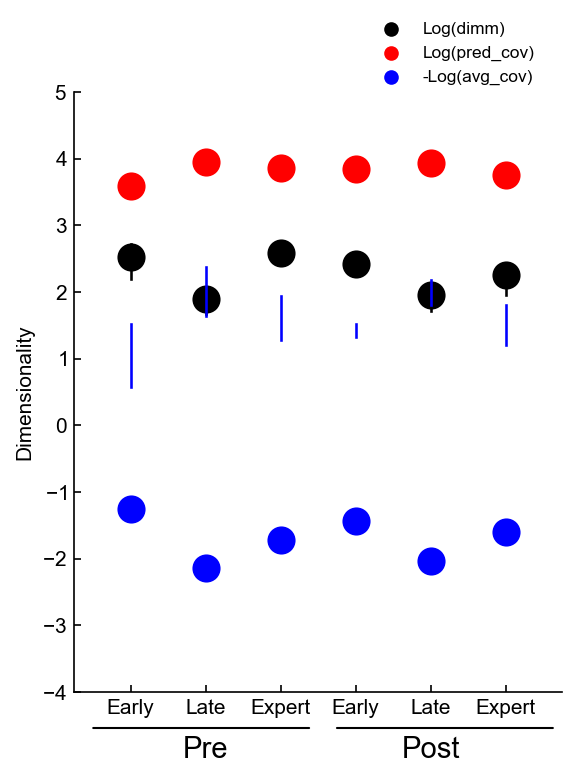

In [362]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[np.log10(Mden-SEMden),np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

<ipython-input-363-28b8f6465c58>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-363-28b8f6465c58>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-345-c8eccb632ddf>:36: RuntimeWarning: Mean of empty slice
  avg_sq_vars = np.nanmean(all_vars**2)
<ipython-input-345-c8eccb632ddf>:37: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-345-c8eccb632ddf>:38: RuntimeWarning: Mean of empty

0.9507980319212769
0.049201968078723124


<ipython-input-363-28b8f6465c58>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-363-28b8f6465c58>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-345-c8eccb632ddf>:83: RuntimeWarning: Mean of empty slice
  avg_sq_vars = np.nanmean(all_vars**2)
<ipython-input-345-c8eccb632ddf>:84: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-345-c8eccb632ddf>:85: RuntimeWarning: Mean of emp

0.09662705557556117
0.9033729444244388


<ipython-input-363-28b8f6465c58>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-363-28b8f6465c58>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]


0.5743948789757951
0.4256051210242049


<ipython-input-363-28b8f6465c58>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-363-28b8f6465c58>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]


0.99072
0.009279999999999955


<ipython-input-363-28b8f6465c58>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-363-28b8f6465c58>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]


0.12124000000000001
0.87876


<ipython-input-363-28b8f6465c58>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-363-28b8f6465c58>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]


0.83236
0.16764
Total
[0.29521181 0.36372    0.85121024 0.11136    0.36372    0.402336  ]
Numerator
[0.28288    0.65418317 0.28288    0.509088   0.28288    0.509088  ]
Denominator
[0.08736    0.44844556 0.65896    0.08736    0.30176    0.65896   ]


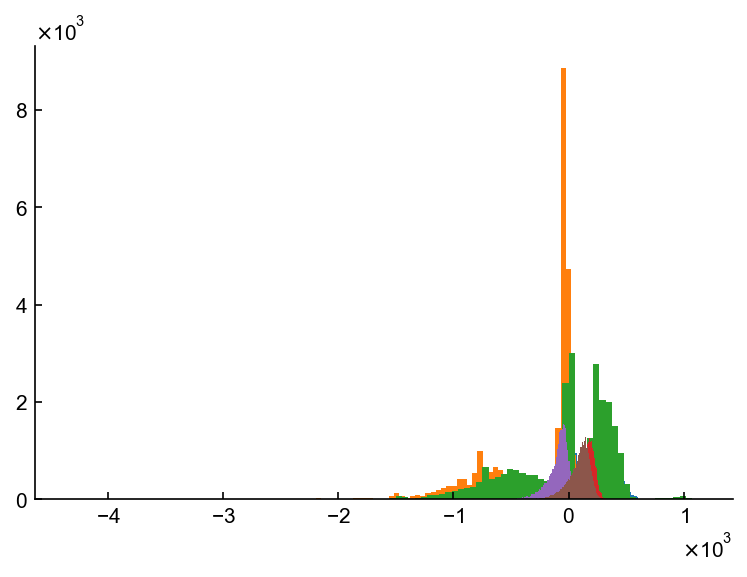

In [363]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 25000
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p1,pp1,ppp1 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p2,pp2,ppp2 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p3,pp3,ppp3 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)


phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p4,pp4,ppp4 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p5,pp5,ppp5 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p6,pp6,ppp6 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)






pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Total')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Numerator')
print(pp_corr)

pppvals = [ppp1,ppp2,ppp3,ppp4,ppp5,ppp6]
_,ppp_corr = pg.multicomp(pppvals,method='fdr_bh')
print('Denominator')
print(ppp_corr)

In [69]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[0.10192216 0.7677971  0.10192216 0.36476261 0.16590088 0.33950765]
Denominator
[4.24947838e-22 2.57138391e-06 5.67565514e-04 1.38566143e-23
 2.28028332e-07 2.01357196e-01]


<ipython-input-69-c1fad3d08660>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-69-c1fad3d08660>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-69-c1fad3d08660>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

## CR - NCRs

<ipython-input-789-ada0b4f08470>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CRNCR)[phase_mask]
<ipython-input-654-75c52dcf62b5>:36: RuntimeWarning: Mean of empty slice
  avg_sq_vars = np.nanmean(all_vars**2)
<ipython-input-654-75c52dcf62b5>:38: RuntimeWarning: Mean of empty slice
  avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])


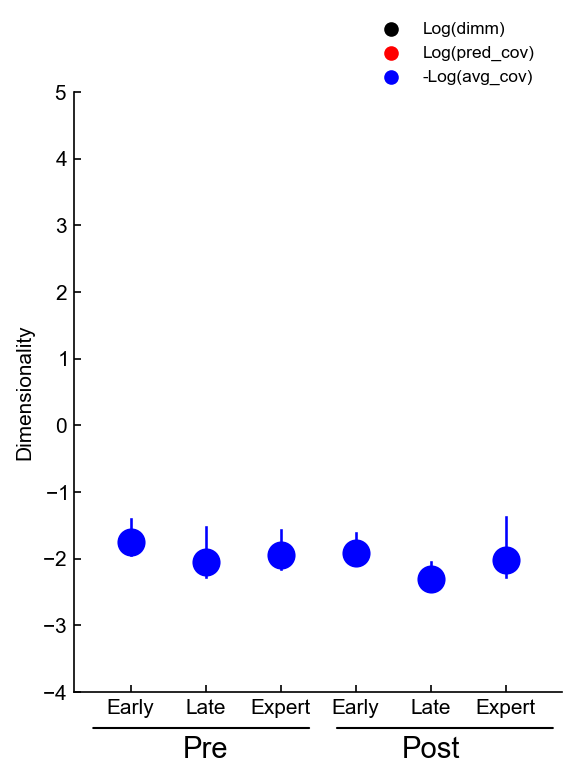

In [789]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CRNCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component CRNCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [790]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[nan nan nan nan nan nan]
Denominator
[0.02020465 0.7881895  0.1016858  0.02020465 0.1422949  0.75830552]


<ipython-input-790-52ee7c89e01e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CRNCR)[phase_mask1]
<ipython-input-790-52ee7c89e01e>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CRNCR)[phase_mask2]
<ipython-input-790-52ee7c89e01e>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

# Per-phase Dimensionality - asymptotic

<ipython-input-507-afbcbbef1af3>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
<ipython-input-507-afbcbbef1af3>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


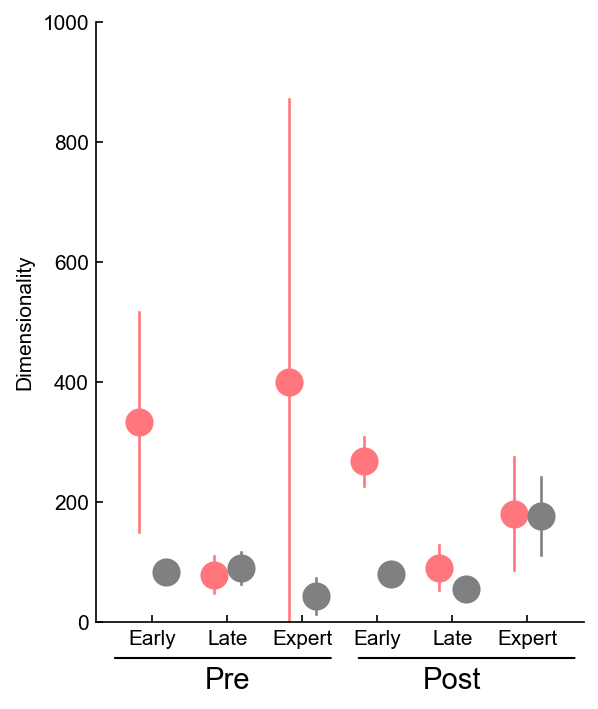

In [507]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx-offset,M,c=NCR_COLOR,s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c=NCR_COLOR,lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)
    
ax.set_ylim([0,1000])
ax.set_ylabel('Dimensionality')
ax.set_yticks([0,200,400,600,800,1000])
ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    
artists = [t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level across phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [487]:
def bootstrap_pc_NCR_test(cov_mats_1,cov_mats_2,B=250000):
    
    d_GT_list_1 = []
    for idx_B in range(B):
        n = len(cov_mats_1)
        sample = np.random.choice(cov_mats_1,n)
        
        all_vars = []
        all_covars = []
        for cov in sample:
            if type(cov) is float:
                continue
            cov = np.array(cov)
            if len(cov.shape) < 2:
                continue
            assert cov.shape[0] == cov.shape[1]
            n_clust = cov.shape[0]
            
            new_n = int(n_clust*n_frac)
            if new_n < 1:
                continue
            mask = range(new_n)
            cov= np.array([c[mask] for c in cov[mask]])

            this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
            this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
            all_vars.append(this_vars)
            all_covars.append(this_covars)
        all_vars = np.concatenate(all_vars)
        all_covars = np.concatenate(all_covars)

        n = len(all_vars)
        avg_sq_vars = np.nanmean(all_vars**2)
        avg_sq_covars = np.nanmean(all_covars**2)
        avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
        
        d_GT = avg_pred_covars/avg_sq_covars
        d_GT_list_1.append(d_GT)
    
    
    d_GT_list_2 = []
    for idx_B in range(B):
        n = len(cov_mats_2)
        sample = np.random.choice(cov_mats_2,n)
        
        all_vars = []
        all_covars = []
        for cov in sample:
            if type(cov) is float:
                continue
            cov = np.array(cov)
            if len(cov.shape) < 2:
                continue
            assert cov.shape[0] == cov.shape[1]
            n_clust = cov.shape[0]
            
            new_n = int(n_clust*n_frac)
            if new_n < 1:
                continue
            mask = range(new_n)
            cov= np.array([c[mask] for c in cov[mask]])

            this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
            this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
            all_vars.append(this_vars)
            all_covars.append(this_covars)
        all_vars = np.concatenate(all_vars)
        all_covars = np.concatenate(all_covars)

        n = len(all_vars)
        avg_sq_vars = np.nanmean(all_vars**2)
        avg_sq_covars = np.nanmean(all_covars**2)
        avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
        
        d_GT = avg_pred_covars/avg_sq_covars
        d_GT_list_2.append(d_GT)
        
    #Two-sided test
    diffs = (np.array(d_GT_list_1) - np.array(d_GT_list_2))
    pY = 1 - np.mean(np.greater(diffs,0))
    pX = 1 - np.mean(np.less(diffs,0))
    pboot = min(pX,pY)*2
    return pboot

In [491]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 25000
    
phase_mask = np.char.equal(EILphases,'pre early')
cov1 = np.array(Data.cov_mats_CR)[phase_mask]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
p1 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p1)
    
phase_mask = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
p2 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p2)
    
phase_mask = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
p3 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p3)
    
phase_mask = np.char.equal(EILphases,'post early')
cov1 = np.array(Data.cov_mats_CR)[phase_mask]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
p4 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p4)
    
phase_mask = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
p5 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p5)
    
phase_mask = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
p6 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p6)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print(p_corr)

<ipython-input-491-22877cadee85>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-491-22877cadee85>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask]


0.05231999999999992


<ipython-input-491-22877cadee85>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-491-22877cadee85>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask]


0.67808


<ipython-input-491-22877cadee85>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-491-22877cadee85>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask]
<ipython-input-487-3510b40262b3>:71: RuntimeWarning: Mean of empty slice
  avg_sq_vars = np.nanmean(all_vars**2)
<ipython-input-487-3510b40262b3>:72: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-487-3510b40262b3>:73: RuntimeWarning: Mean of empty 

0.07255999999999996


<ipython-input-491-22877cadee85>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-491-22877cadee85>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask]


0.00015999999999993797


<ipython-input-491-22877cadee85>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-491-22877cadee85>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask]


0.2170399999999999


<ipython-input-491-22877cadee85>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-491-22877cadee85>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask]


0.9121600000000001
[0.14512  0.813696 0.14512  0.00096  0.32556  0.91216 ]


In [506]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 25000
    
phase_mask = np.char.equal(EILphases,'pre early')
cov1 = np.array(Data.cov_mats)[phase_mask]
phase_mask = np.char.equal(EILphases,'pre late')
cov2 = np.array(Data.cov_mats)[phase_mask]
p1 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p1)

phase_mask = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats)[phase_mask]
phase_mask = np.char.equal(EILphases,'pre expert')
cov2 = np.array(Data.cov_mats)[phase_mask]
p2 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p2)

phase_mask = np.char.equal(EILphases,'pre early')
cov1 = np.array(Data.cov_mats)[phase_mask]
phase_mask = np.char.equal(EILphases,'pre expert')
cov2 = np.array(Data.cov_mats)[phase_mask]
p3 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p3)

phase_mask = np.char.equal(EILphases,'post early')
cov1 = np.array(Data.cov_mats)[phase_mask]
phase_mask = np.char.equal(EILphases,'post late')
cov2 = np.array(Data.cov_mats)[phase_mask]
p4 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p4)

phase_mask = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats)[phase_mask]
phase_mask = np.char.equal(EILphases,'post expert')
cov2 = np.array(Data.cov_mats)[phase_mask]
p5 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p5)

phase_mask = np.char.equal(EILphases,'post early')
cov1 = np.array(Data.cov_mats)[phase_mask]
phase_mask = np.char.equal(EILphases,'post expert')
cov2 = np.array(Data.cov_mats)[phase_mask]
p6 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p6)


pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print(p_corr)

<ipython-input-506-ac9b0a892ba3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-506-ac9b0a892ba3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask]


0.59552


<ipython-input-506-ac9b0a892ba3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-506-ac9b0a892ba3>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask]


0.4059999999999999


<ipython-input-506-ac9b0a892ba3>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-506-ac9b0a892ba3>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-487-3510b40262b3>:33: RuntimeWarning: Mean of empty slice
  avg_sq_vars = np.nanmean(all_vars**2)
<ipython-input-487-3510b40262b3>:34: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-487-3510b40262b3>:35: RuntimeWarning: Mean of empty slice
 

0.2587999999999999


<ipython-input-506-ac9b0a892ba3>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-506-ac9b0a892ba3>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask]


0.10095999999999994


<ipython-input-506-ac9b0a892ba3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-506-ac9b0a892ba3>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask]


0.10431999999999997


<ipython-input-506-ac9b0a892ba3>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask]
<ipython-input-506-ac9b0a892ba3>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask]


0.56088
[0.59552 0.59552 0.5176  0.31296 0.31296 0.59552]


In [516]:
len(EnumSessionOps)

52

In [522]:
len(Data_On.sessions)

59

In [532]:
for s in Data_On.sessions:
    if s not in EnumSessionOps:
        print(s)

In [581]:
EILphasesOps == 'post late'

array([False, False, False, False, False, False,  True, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])

In [628]:
lateSessions = np.array(EnumSessionOps)[EILphasesOps == 'post late']
print(lateSessions)

['BS_119_6_opto_AC.pickle' 'BS_123_6_opto_AC.pickle'
 'BS_123_7_opto_AC.pickle' 'BS_128_10_opto_AC.pickle'
 'BS_128_8_opto_AC.pickle' 'BS_128_9_opto_AC.pickle'
 'BS_131_6_opto_AC.pickle' 'BS_131_7_opto_AC.pickle'
 'BS_131_8_opto_AC.pickle' 'BS_86_6_opto_AC.pickle']


In [606]:
print(sessionfile.clusters.good)
print([int(sessionfile.responsiveness[c]['laser_on'].FRmodulation) for c in sessionfile.clusters.good])

[  0  44  45  48  50  60  75  91  92  96 101 113 123 124 132 133 141]
[2, 2, 2, 2, 2, 1, 2, 3, 3, 2, 0, 1, 5, 2, 2, 0, 0]


In [605]:
sessionfile = ilep.loadSessionCached(ops_directory,'BS_86_6_opto_AC.pickle')

In [646]:
lateSessions = np.array(EnumSessionOps)[EILphasesOps == 'post late']
print(lateSessions)

['BS_119_6_opto_AC.pickle' 'BS_123_6_opto_AC.pickle'
 'BS_123_7_opto_AC.pickle' 'BS_128_10_opto_AC.pickle'
 'BS_128_8_opto_AC.pickle' 'BS_128_9_opto_AC.pickle'
 'BS_131_6_opto_AC.pickle' 'BS_131_7_opto_AC.pickle'
 'BS_131_8_opto_AC.pickle' 'BS_86_6_opto_AC.pickle']


In [651]:
d_list = []
n_list = []
for targetSession in lateSessions:#= 'BS_86_6_opto_AC.pickle'
    idx = int(np.where(np.char.equal(Data_On.sessions,targetSession))[0])

    cov = Data_On.cov_mats[idx]
    if not hasattr(cov,'shape'):
        continue
    assert cov.shape[0] == cov.shape[1]
    n = cov.shape[0]
    this_vars = cov[np.eye(n,n,dtype='bool')]
    this_covars = cov[~np.eye(n,n,dtype='bool')]
    avg_sq_covars = np.nanmean(this_covars**2)
    avg_pred_covars = np.nanmean(np.outer(this_vars,this_vars)[~np.eye(n,n,dtype='bool')])

    d_GT = avg_pred_covars/avg_sq_covars
    d_list.append(d_GT)
    n_list.append(n)

<ipython-input-651-13b0b8766b8e>:13: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(this_covars**2)
<ipython-input-651-13b0b8766b8e>:14: RuntimeWarning: Mean of empty slice
  avg_pred_covars = np.nanmean(np.outer(this_vars,this_vars)[~np.eye(n,n,dtype='bool')])


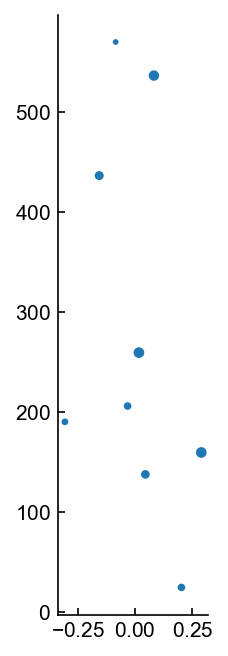

In [652]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(1, 4, left=.3, bottom=.3, right=0, top=0)
X,Y = ilep.violin(d_list)
ax.scatter(X,Y,s=n_list)

# Opto On vs. Off

In [617]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)

<ipython-input-616-1ca28b5a250b>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-616-1ca28b5a250b>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-616-1ca28b5a250b>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

[Text(0, 0, 'Early'), Text(1, 0, 'Late'), Text(2, 0, 'Expert')]

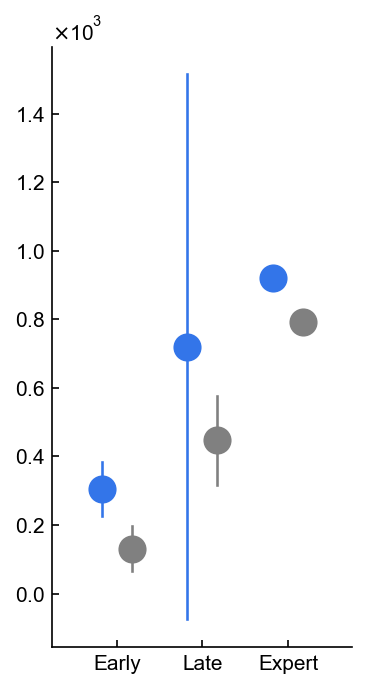

In [616]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data_On.cov_mats)[phase_mask]
    M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx-offset,M,c=LASER_COLOR,s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c=LASER_COLOR,lw=s_wid)
    
    cov_mats = np.array(Data_Off.cov_mats)[phase_mask]
    M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)
    
# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
# labels = ['Early','Late','Expert','Early','Late','Expert']
# ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
# ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    
# artists = [t1,t2]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level across phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

<ipython-input-575-371f7561e9be>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-575-371f7561e9be>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-575-371f7561e9be>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

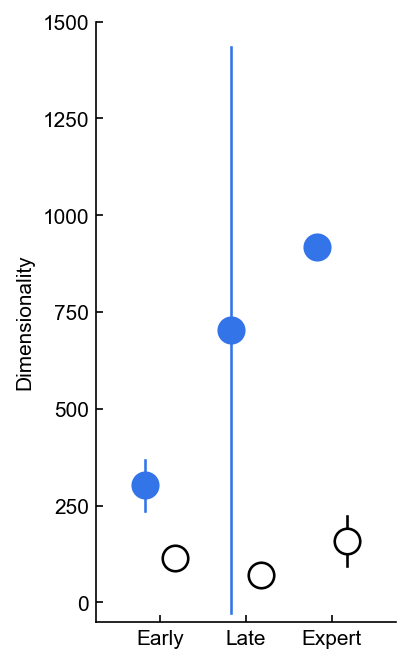

In [575]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data_On.cov_mats)[phase_mask]
    M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=25000)
    ax.scatter(idx-offset,M,c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
    ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c=LASER_COLOR,lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats)[phase_mask_control]
    M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=25000)
    ax.scatter(idx+offset,M,ec='k',fc='white',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
ax.set_ylim([-50,1500])
ax.set_ylabel('Dimensionality')
ax.set_yticks([0,250,500,750,1000,1250,1500])
ax.set_yticklabels([str(s) for s in [0,250,500,750,1000,1250,1500]])
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
# labels = ['Early','Late','Expert','Early','Late','Expert']
# ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
# ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality opto network-level across phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [576]:
phases = ['post early','post late','post expert']
B = 250000
    
phase_mask = np.char.equal(EILphasesOps,'post early')
cov1 = np.array(Data_On.cov_mats)[phase_mask]
phase_mask_control = np.char.equal(EILphases,'post early')
cov2 = np.array(Data.cov_mats)[phase_mask_control]
p1 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p1)

phase_mask = np.char.equal(EILphasesOps,'post late')
cov1 = np.array(Data_On.cov_mats)[phase_mask]
phase_mask_control = np.char.equal(EILphases,'post late')
cov2 = np.array(Data.cov_mats)[phase_mask_control]
p2 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p2)

phase_mask = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats)[phase_mask]
phase_mask_control = np.char.equal(EILphases,'post expert')
cov2 = np.array(Data.cov_mats)[phase_mask_control]
p3 = bootstrap_pc_NCR_test(cov1,cov2,B=B)
print(p3)


pvals = [p1,p2,p3]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print(p_corr)

<ipython-input-576-7d61fc32eacf>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask_control]


0.0011600000000000499


<ipython-input-576-7d61fc32eacf>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask_control]
<ipython-input-487-3510b40262b3>:34: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)


0.0042320000000000135


<ipython-input-576-7d61fc32eacf>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask_control]


0.0
[0.00174  0.004232 0.      ]


# Opto Logged Dimm and Log Ratios

## On

### Total

<ipython-input-750-fd7dfcce381a>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-750-fd7dfcce381a>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-750-fd7dfcce381a>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is d

69.03523548306828
29.207708930572345
129.4353584877828
87.24926864752898
92.52610416241158
1.4210854715202004e-14


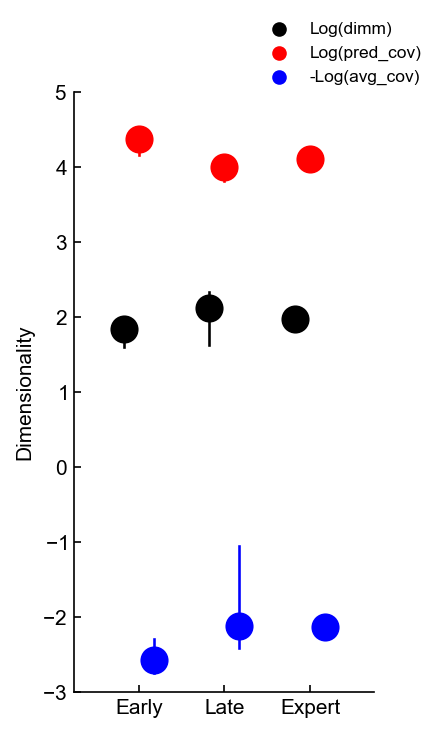

In [750]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats_CR = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats_NCR = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data_On.cov_mats)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    print(M)
    print(SEM)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    if SEMnum > Mnum:
        ax.plot([idx-0*offset,idx-0*offset],[-3,np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    else:
        ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
    
artists = [lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component Opto On V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [762]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post late')
cov1 = np.array(Data_On.cov_mats)[phase_mask1]
cov2 = np.array(Data_On.cov_mats)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphasesOps,'post late')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats)[phase_mask1]
cov2 = np.array(Data_On.cov_mats)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats)[phase_mask1]
cov2 = np.array(Data_On.cov_mats)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[1.64845939e-28 1.43437834e-09 3.43425950e-08]
Denominator
[4.10580395e-02 2.99949339e-01 1.29899970e-05]


### CR

<ipython-input-764-4cdb632e8ea7>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-764-4cdb632e8ea7>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-764-4cdb632e8ea7>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is d

52.08696546852829
25.770465597533285
115.53484122662411
79.15633105080003
56.439284726553666
2.1316282072803006e-14


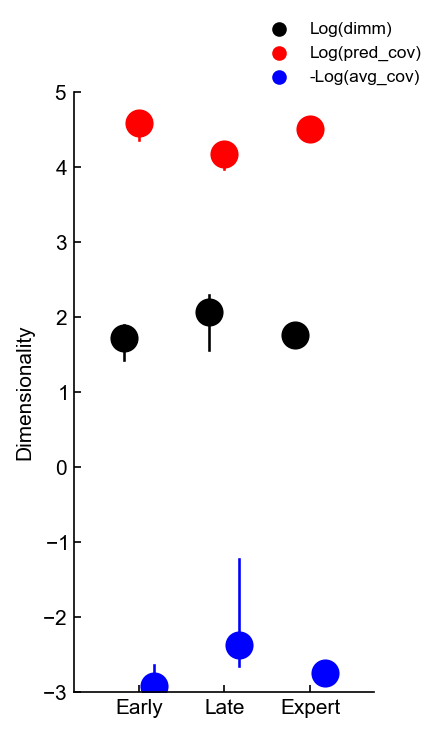

In [764]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats_CR = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats_NCR = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data_On.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    print(M)
    print(SEM)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    if SEMnum > Mnum:
        ax.plot([idx-0*offset,idx-0*offset],[-3,np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    else:
        ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
    
artists = [lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component Opto On CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [765]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post late')
cov1 = np.array(Data_On.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_CR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphasesOps,'post late')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_CR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_CR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[1.53222166e-12 1.16223762e-30 7.26446654e-01]
Denominator
[0.44807115 0.01531685 0.7637895 ]


### NCR

<ipython-input-766-b4d28e49d2a0>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-766-b4d28e49d2a0>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-766-b4d28e49d2a0>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is d

300.8222915805491
60.83079780967203


<ipython-input-654-75c52dcf62b5>:37: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)


681.1860594816687
552.0916533822855
919.0753269337473
1.1368683772161603e-13


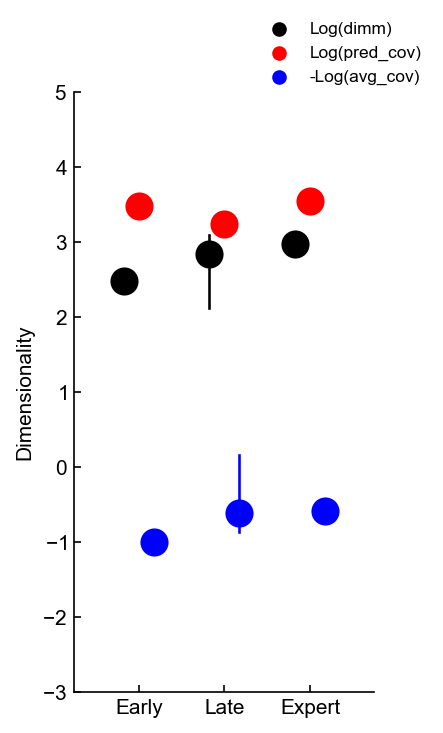

In [766]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats_CR = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats_NCR = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data_On.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    print(M)
    print(SEM)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    if SEMnum > Mnum:
        ax.plot([idx-0*offset,idx-0*offset],[-3,np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    else:
        ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
    
artists = [lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component Opto On NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [767]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post late')
cov1 = np.array(Data_On.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_NCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphasesOps,'post late')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_NCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data_On.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_NCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[1.64845939e-28 1.43437834e-09 3.43425950e-08]
Denominator
[4.10580395e-02 2.99949339e-01 1.29899970e-05]


## Control

<ipython-input-769-bea8eee39227>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-769-bea8eee39227>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-769-bea8eee39227>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

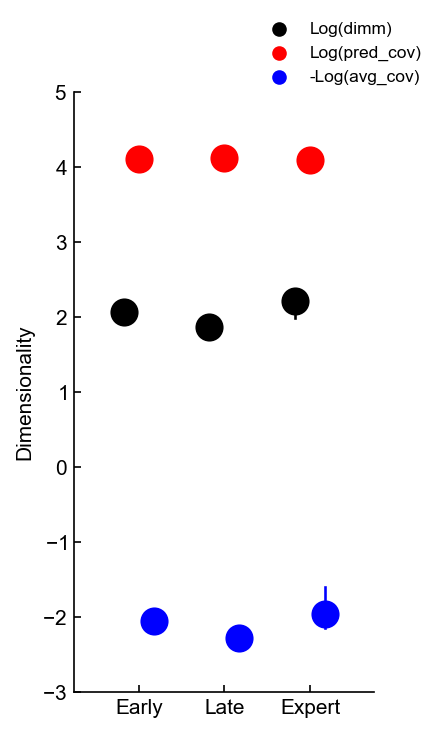

In [769]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data.cov_mats)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
#     print(SEM)
#     print(SEMnum)
#     print(SEMden)
#     print()
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
    
artists = [lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component Opto Control V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [770]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[3.85208695e-02 7.25293301e-09 7.16037854e-06]
Denominator
[0.00156676 0.00156676 0.12056407]


<ipython-input-770-6fc8da50ddc3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask1]
<ipython-input-770-6fc8da50ddc3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask2]
<ipython-input-770-6fc8da50ddc3>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

<ipython-input-771-e24b7a298e65>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-771-e24b7a298e65>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-771-e24b7a298e65>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

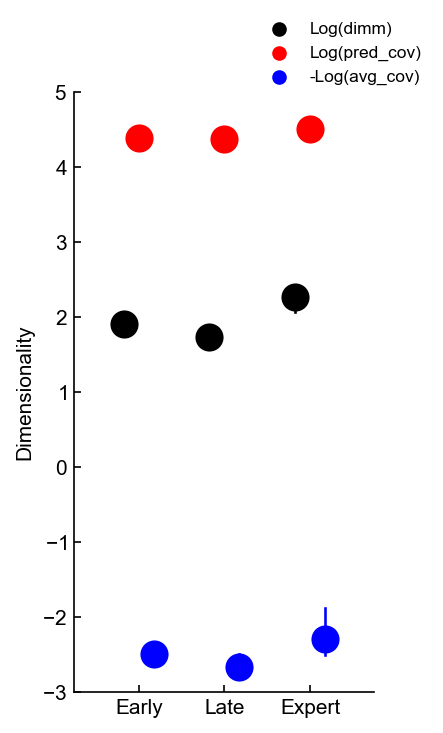

In [771]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
#     print(SEM)
#     print(SEMnum)
#     print(SEMden)
#     print()
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
    
artists = [lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component Opto Control CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [772]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[4.02261135e-01 6.10547960e-26 8.70213368e-20]
Denominator
[0.00735004 0.00287692 0.00735004]


<ipython-input-772-b6c27cfa13f6>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-772-b6c27cfa13f6>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
<ipython-input-772-b6c27cfa13f6>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

<ipython-input-773-c9f7cf4cc319>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-773-c9f7cf4cc319>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-773-c9f7cf4cc319>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

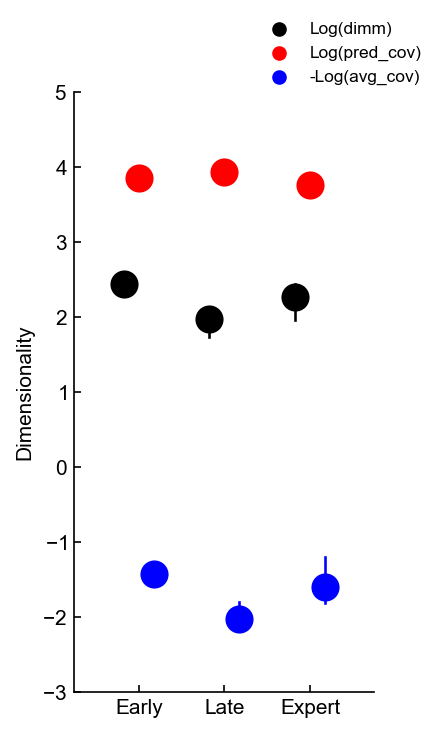

In [773]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)
with open('D:\\Cov_Mats_Opto_Off.pickle', 'rb') as f:
    Data_Off = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_CR)[np.isin(Data_Off.sessions,EnumSessionOps)]
Data_Off.cov_mats = np.array(Data_Off.cov_mats_NCR)[np.isin(Data_Off.sessions,EnumSessionOps)]
    
phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
#     print(SEM)
#     print(SEMnum)
#     print(SEMden)
#     print()
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')
    
labels = ['Early','Late','Expert']
ax.set_xlim([-0.75,2.75])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
    
artists = [lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component Opto Control NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [774]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[1.87081519e-087 3.50468900e-112 5.67362151e-071]
Denominator
[1.69568204e-07 1.89223005e-02 7.44483344e-02]


<ipython-input-774-c8d89da3eaac>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-774-c8d89da3eaac>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-774-c8d89da3eaac>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nd

# Bin width

## 25ms

In [794]:
with open('D:\\Cov_Mats_25.pickle', 'rb') as f:
    Data = pickle.load(f)

### All cells

<ipython-input-795-1779316d96b7>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats)[phase_mask]


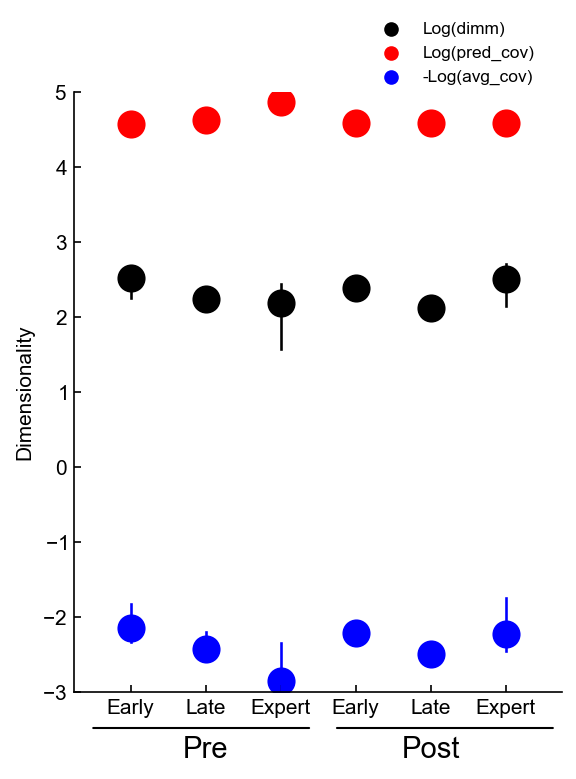

In [795]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component 25ms V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [796]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[1.51735200e-024 3.55169689e-123 1.18115421e-242 4.53669622e-003
 9.49440510e-001 6.08027445e-002]
Denominator
[5.73903605e-07 1.13696153e-05 5.49650268e-12 1.44121373e-04
 6.59400810e-03 6.85173558e-01]


<ipython-input-796-7c7779ad4283>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask1]
<ipython-input-796-7c7779ad4283>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask2]
<ipython-input-796-7c7779ad4283>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

### CRs

<ipython-input-797-620075696a07>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
<ipython-input-797-620075696a07>:45: RuntimeWarning: invalid value encountered in log10
  ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)


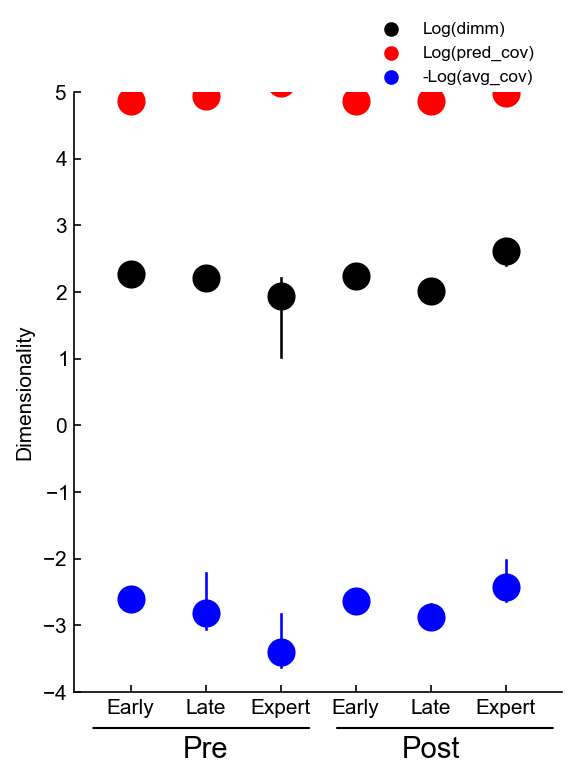

In [797]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component CR 25ms V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [798]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[3.40790575e-11 1.02149710e-33 5.26215356e-81 7.49819660e-01
 6.98762269e-33 1.17102741e-23]
Denominator
[6.35942070e-02 7.42699729e-06 4.58493005e-08 9.56081000e-05
 7.89476795e-04 3.41675253e-03]


<ipython-input-798-3a565925fa4c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-798-3a565925fa4c>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
<ipython-input-798-3a565925fa4c>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

### NCRs

<ipython-input-799-e015f3f1423c>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
<ipython-input-799-e015f3f1423c>:45: RuntimeWarning: invalid value encountered in log10
  ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)


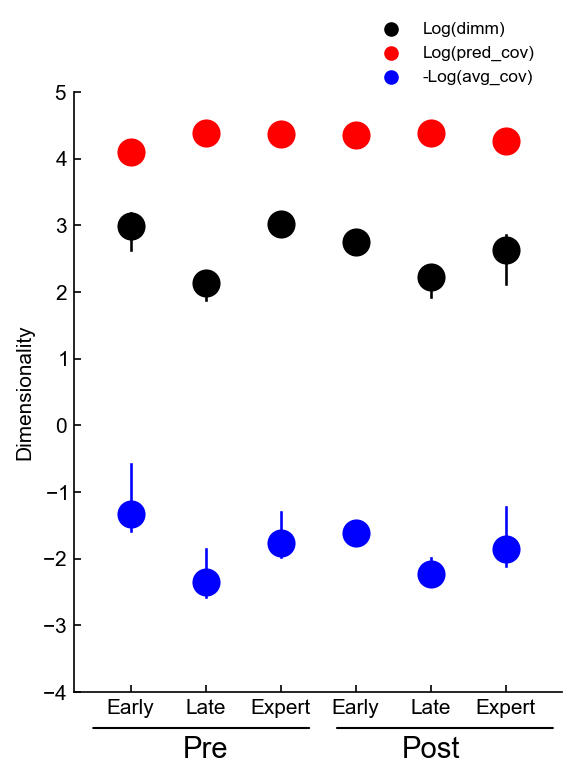

In [799]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component NCR 25ms V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [800]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[4.77421725e-65 9.23393568e-01 1.20330055e-91 1.21697443e-28
 4.98869554e-83 6.54528487e-61]
Denominator
[1.65742930e-05 3.31637922e-01 1.76614951e-06 3.61320863e-07
 2.69341081e-02 2.69341081e-02]


<ipython-input-800-c1fad3d08660>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-800-c1fad3d08660>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-800-c1fad3d08660>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nd

## 100ms

In [808]:
with open('D:\\Cov_Mats_100.pickle', 'rb') as f:
    Data = pickle.load(f)

### All cells

<ipython-input-802-4619766ad7b7>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats)[phase_mask]


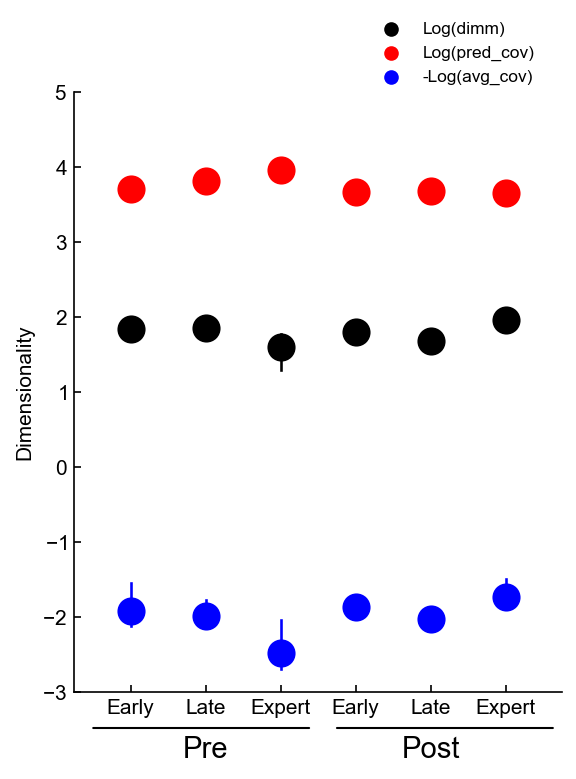

In [802]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-3,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component 100ms V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [803]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats)[phase_mask1]
cov2 = np.array(Data.cov_mats)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[7.31520171e-050 2.10922730e-026 1.39068410e-138 4.55360941e-007
 7.06451998e-016 9.22742846e-008]
Denominator
[2.91340357e-02 6.38834199e-09 3.16933456e-11 8.26321054e-03
 7.94810220e-04 8.34991452e-03]


<ipython-input-803-7c7779ad4283>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats)[phase_mask1]
<ipython-input-803-7c7779ad4283>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats)[phase_mask2]
<ipython-input-803-7c7779ad4283>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

### CRs

<ipython-input-804-7c106ed7deaa>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


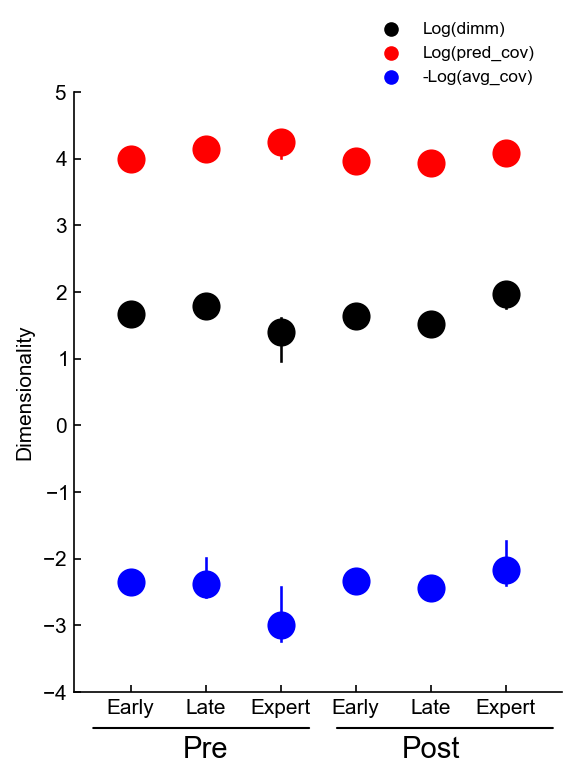

In [804]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component CR 100ms V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [805]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[3.76127739e-21 1.43618464e-07 3.69578966e-48 8.92629582e-03
 5.14708321e-30 2.71199818e-21]
Denominator
[6.30303679e-01 5.40553917e-08 5.96565733e-08 1.19600775e-01
 9.38620287e-03 2.40966350e-02]


<ipython-input-805-3a565925fa4c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-805-3a565925fa4c>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
<ipython-input-805-3a565925fa4c>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

### NCRs

<ipython-input-806-21cafd63db0b>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
<ipython-input-654-75c52dcf62b5>:36: RuntimeWarning: Mean of empty slice
  avg_sq_vars = np.nanmean(all_vars**2)
<ipython-input-654-75c52dcf62b5>:37: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-654-75c52dcf62b5>:38: RuntimeWarning: Mean of empty slice
  avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
<ipython-input-806-21cafd63db0b>:45: RuntimeWarning: invalid value encountered in log10
  ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)


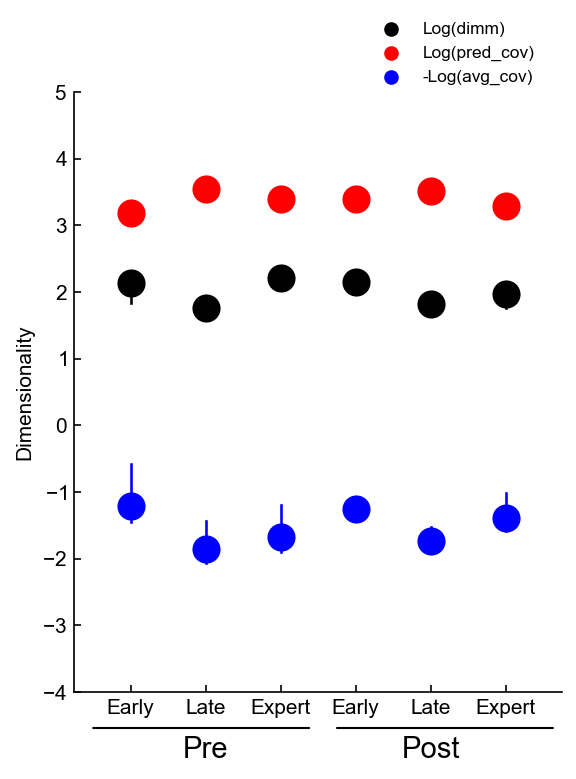

In [806]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
    ax.scatter(idx+offset,-np.log10(Mden),c='b',s=sz,lw=s_wid)
    ax.plot([idx+offset,idx+offset],[-np.log10(Mden-SEMden),-np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

ax.scatter([],[],c='k',label='Log(dimm)')
ax.scatter([],[],c='r',label='Log(pred_cov)')
ax.scatter([],[],c='b',label='-Log(avg_cov)')
lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([-4,5])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
artists = [lgd,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level by component NCR 100ms V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [807]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)



phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[9.85732850e-057 9.68117004e-004 1.69020229e-044 5.60766972e-133
 1.71530646e-123 2.94289302e-072]
Denominator
[4.24043218e-06 9.08950960e-01 5.32853557e-07 5.32853557e-07
 2.51376203e-02 2.20624893e-01]


<ipython-input-807-c1fad3d08660>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-807-c1fad3d08660>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-807-c1fad3d08660>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nd

# NCR Var vs Covar

In [359]:
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)

<ipython-input-354-5d017088bd69>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]


357.7525947938608 +/- 0.0
122.60409656783679 +/- 447.74023111686563
357.7525947938608
1.4260722101921115

75.06701814577696 +/- 0.0
55.67256611348688 +/- 97.46930424557222
75.06701814577696
1.4260722101921115

116.91526713419783 +/- 0.0
106.83959953763875 +/- 699.612079380956
116.91526713419783
1.4260722101921115

268.12590652888093 +/- 0.0
241.23081992830032 +/- 295.2483671349888
268.12590652888093
1.4260722101921115

83.76950311217684 +/- 0.0
68.39497634188447 +/- 106.48585503848304
83.76950311217684
1.4260722101921115

152.69343629115568 +/- 0.0
117.12938826490287 +/- 221.50122171453188
152.69343629115568
1.4260722101921115



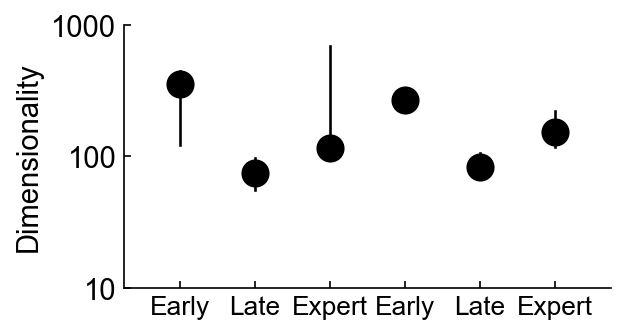

In [354]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     excluded_sessions = ['DS_19_1_AC.pickle']
#     EnumSessionExcluded = np.array(EnumSession)
#     EnumSessionExclusionMask = np.isin(EnumSessionExcluded,excluded_sessions)
#     phase_mask = np.logical_and(phase_mask,np.logical_not(EnumSessionExclusionMask))
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
#     M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(Q1),np.log10(Q3)],c='k',lw=s_wid)
    
    print(M)
    print(SEM)
    print()
    
#     ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
#     ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
#     ax.scatter(idx+offset,np.log10(Mden),c='b',s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[np.log10(Mden-SEMden),np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([1,3])
ax.set_yticks([1,2,3])
ax.set_yticklabels(['10','100','1000'])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1200])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000,1200])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000,1200]])

# ax.set_ylim([0,800])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [ ]:
# Var alone

<ipython-input-159-741fc9df82a8>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]


1.5518603726049942
0.06877619878409781
4.4532949323715805
0.24636525180148025
3.2297936364192346
0.522558208415508
2.6266010737105723
0.06396787561996502
4.218047388001883
0.1734221267252399
2.542607595196138
0.15116533978776653


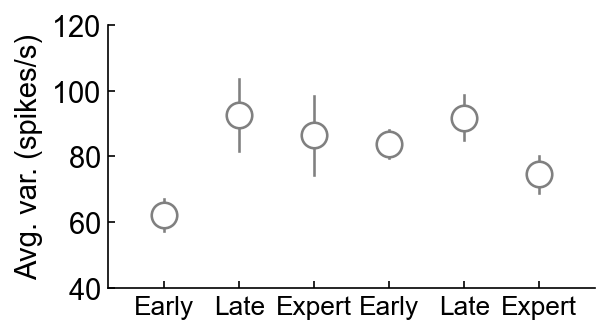

In [159]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
#     ax.scatter(idx-0*offset,np.log10(Mnum),c='gray',s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    ax.scatter(idx+offset,(Mnum),fc='white',ec='gray',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mnum-SEMnum),(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,3])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(['1','10','100','1000'])
# ax.set_ylabel('|Avg. var. & covar.| (spikes/s)')
ax.set_ylim([40,120])
ax.set_yticks([40,60,80,100,120])
ax.set_ylabel('Avg. var. (spikes/s)')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality variance network-level NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [ ]:
# Covar alone

<ipython-input-160-e5f67d888ae9>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]


1.5518603726049942
0.06877619878409781
4.4532949323715805
0.24636525180148025
3.2297936364192346
0.522558208415508
2.6266010737105723
0.06396787561996502
4.218047388001883
0.1734221267252399
2.542607595196138
0.15116533978776653


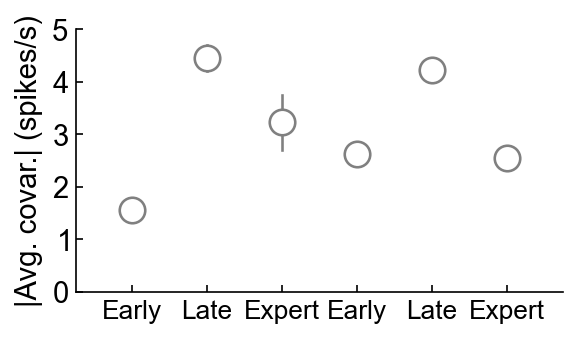

In [160]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
#     ax.scatter(idx-0*offset,np.log10(Mnum),c='gray',s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    ax.scatter(idx+offset,(Mden),fc='white',ec='gray',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mden-SEMden),(Mden+SEMden)],c='gray',lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,3])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(['1','10','100','1000'])
# ax.set_ylabel('|Avg. var. & covar.| (spikes/s)')
ax.set_ylim([0,5])
ax.set_yticks([0,1,2,3,4,5])
ax.set_ylabel('|Avg. covar.| (spikes/s)')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality covariance network-level NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [ ]:
# Var & Covar together

<ipython-input-282-0850c8ee72ec>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]


1.5518603726049942
0.06877619878409781
4.4532949323715805
0.24636525180148025
3.2297936364192346
0.522558208415508
2.6266010737105723
0.06396787561996502
4.218047388001883
0.1734221267252399
2.542607595196138
0.15116533978776653


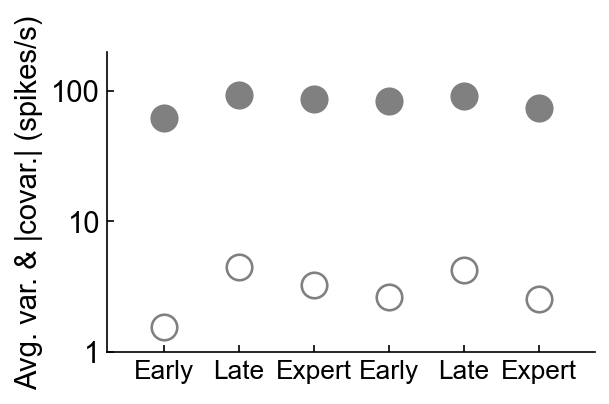

In [282]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 2, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='gray',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    ax.scatter(idx+offset,np.log10(Mden),fc='white',ec='gray',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[np.log10(Mden-SEMden),np.log10(Mden+SEMden)],c='gray',lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,3])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(['1','10','100','1000'])
# ax.set_ylabel('|Avg. var. & covar.| (spikes/s)')
ax.set_ylim([0,np.log10(200)])
ax.set_yticks([0,1,2])
ax.set_yticklabels(['1','10','100'])
ax.set_ylabel('Avg. var. & |covar.| (spikes/s)')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality var & covar network-level NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [360]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[0.10192216 0.7677971  0.10192216 0.36476261 0.16590088 0.33950765]
Denominator
[3.41533670e-31 1.00077391e-01 1.05895971e-09 3.77095400e-23
 1.43315067e-09 5.60409227e-01]


<ipython-input-360-5a1514b1c133>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-360-5a1514b1c133>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
<ipython-input-360-5a1514b1c133>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nd

# CR Var vs Covar

In [300]:
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)

<ipython-input-301-e13bb4482c0e>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


80.39425174982674
21.082531185878295



<ipython-input-278-ca2e24383eea>:37: RuntimeWarning: Mean of empty slice
  avg_sq_covars = np.nanmean(all_covars**2)
<ipython-input-278-ca2e24383eea>:38: RuntimeWarning: Mean of empty slice
  avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])


94.0536611909761
24.96256307407924

34.62816654739587
20.938809358601446

77.31066501620612
23.13011164205635

53.346604368806396
14.560568342000323

170.67008503633562
81.76885761713089



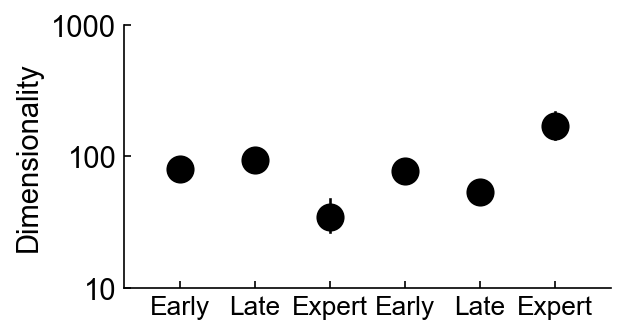

In [301]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     excluded_sessions = ['DS_19_1_AC.pickle']
#     EnumSessionExcluded = np.array(EnumSession)
#     EnumSessionExclusionMask = np.isin(EnumSessionExcluded,excluded_sessions)
#     phase_mask = np.logical_and(phase_mask,np.logical_not(EnumSessionExclusionMask))
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
    M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(Q1),np.log10(Q3)],c='k',lw=s_wid)
    
    print(M)
    print(Q3-Q1)
    print()
    
#     ax.scatter(idx-0*offset,np.log10(Mnum),c='r',s=sz,lw=s_wid)
#     ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='r',lw=s_wid)
    
#     ax.scatter(idx+offset,np.log10(Mden),c='b',s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[np.log10(Mden-SEMden),np.log10(Mden+SEMden)],c='b',lw=s_wid)
    
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

ax.set_ylim([1,3])
ax.set_yticks([1,2,3])
ax.set_yticklabels(['10','100','1000'])
ax.set_ylabel('Dimensionality')

# ax.set_ylim([0,1200])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000,1200])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000,1200]])

# ax.set_ylim([0,800])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality network-level CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [ ]:
# Var only

<ipython-input-171-9c66c5a6a42a>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


11.071357942673597
0.39975563978352274
10.547347978353812
0.4631921177598168
18.375733893908357
2.3383513191679097
10.390064648308762
0.26117864424508036
12.792520181143017
0.613781689721106
7.435139205386671
0.4814330546166829


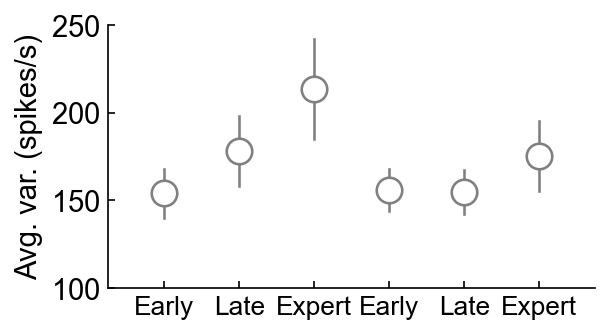

In [171]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
#     ax.scatter(idx-0*offset,np.log10(Mnum),c='gray',s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    ax.scatter(idx+offset,(Mnum),fc='white',ec='gray',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mnum-SEMnum),(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,3])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(['1','10','100','1000'])
# ax.set_ylabel('|Avg. var. & covar.| (spikes/s)')
# ax.set_ylim([40,120])
# ax.set_yticks([40,60,80,100,120])
# ax.set_ylabel('Avg. var. (spikes/s)')

ax.set_ylim([100,250])
ax.set_ylabel('Avg. var. (spikes/s)')
ax.set_yticks([100,150,200,250])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality variance network-level CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [ ]:
# Covar only

<ipython-input-172-741e98c43a93>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


11.071357942673597
0.39975563978352274
10.547347978353812
0.4631921177598168
18.375733893908357
2.3383513191679097
10.390064648308762
0.26117864424508036
12.792520181143017
0.613781689721106
7.435139205386671
0.4814330546166829


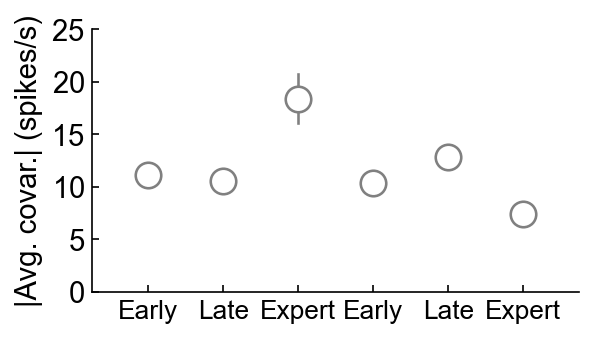

In [172]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
#     ax.scatter(idx-0*offset,np.log10(Mnum),c='gray',s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='gray',lw=s_wid)
    
    ax.scatter(idx+offset,(Mden),fc='white',ec='gray',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mden-SEMden),(Mden+SEMden)],c='gray',lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,3])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(['1','10','100','1000'])
# ax.set_ylabel('|Avg. var. & covar.| (spikes/s)')
# ax.set_ylim([0,5])
# ax.set_yticks([0,1,2,3,4,5])
# ax.set_ylabel('|Avg. covar.| (spikes/s)')

ax.set_ylim([0,25])
ax.set_ylabel('|Avg. covar.| (spikes/s)')
ax.set_yticks([0,5,10,15,20,25])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality covariance network-level CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

<ipython-input-201-64c03e2b431b>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask]


11.071357942673597
0.39975563978352274
10.547347978353812
0.4631921177598168
18.375733893908357
2.3383513191679097
10.390064648308762
0.26117864424508036
12.792520181143017
0.613781689721106
7.435139205386671
0.4814330546166829


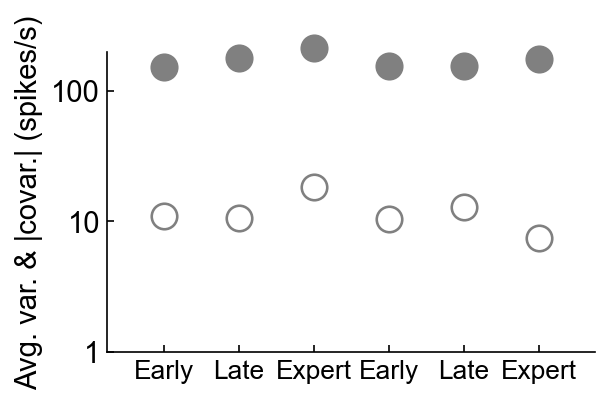

In [201]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(3.25, 2, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0#.175
switch_offset=0
        
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphases,phase)
    
#     cov_mats = np.array(Data.cov_mats)[phase_mask]
#     M,SEM = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,M,c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[M-SEM,M+SEM],c='k',lw=s_wid)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    
#     ax.scatter(idx-offset,np.log10(M),c='k',s=sz,lw=s_wid)
#     ax.plot([idx-offset,idx-offset],[np.log10(M-SEM),np.log10(M+SEM)],c='k',lw=s_wid)
    
    ax.scatter(idx-0*offset,np.log10(Mnum),c='gray',s=sz,lw=s_wid,zorder=10,clip_on=False)
    ax.plot([idx-0*offset,idx-0*offset],[np.log10(Mnum-SEMnum),np.log10(Mnum+SEMnum)],c='gray',lw=s_wid,clip_on=False)
    
    ax.scatter(idx+offset,np.log10(Mden),fc='white',ec='gray',s=sz,lw=s_wid,zorder=10,clip_on=False)
    ax.plot([idx+offset,idx+offset],[np.log10(Mden-SEMden),np.log10(Mden+SEMden)],c='gray',lw=s_wid,clip_on=False)
    
    print(Mden)
    print(SEMden)
    
#     cov_mats = np.array(Data.cov_mats_CR)[phase_mask]
#     M,SEM,_,_,_,_ = bootstrap_dimensionality(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx+offset,M,c=CR_COLOR,s=sz,lw=s_wid)
#     ax.plot([idx+offset,idx+offset],[M-SEM,M+SEM],c=CR_COLOR,lw=s_wid)

# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# ax.scatter([],[],c='b',label='-Log(avg_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,3])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(['1','10','100','1000'])
# ax.set_ylabel('|Avg. var. & covar.| (spikes/s)')
ax.set_ylim([0,np.log10(200)])
ax.set_yticks([0,1,2])
ax.set_yticklabels(['1','10','100'])
ax.set_ylabel('Avg. var. & |covar.| (spikes/s)')

# ax.set_ylim([0,1000])
# ax.set_ylabel('Dimensionality')
# ax.set_yticks([0,200,400,600,800,1000])
# ax.set_yticklabels([str(s) for s in [0,200,400,600,800,1000]])
    
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Dimensionality var & covar network-level CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [168]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    
phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre late')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'pre early')
phase_mask2 = np.char.equal(EILphases,'pre expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p4,pp4 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p5,pp5 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p6,pp6 = trad_stats_num_den(cov1,cov2)

pvals = [p1,p2,p3,p4,p5,p6]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Numerator')
print(p_corr)

ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Numerator
[0.49002192 0.49002192 0.220253   0.9539283  0.49002192 0.49002192]
Denominator
[3.90870606e-01 2.55525064e-07 2.55525064e-07 8.01245372e-05
 2.64349887e-09 1.40605704e-05]


<ipython-input-168-6d2915879f69>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-168-6d2915879f69>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
<ipython-input-168-6d2915879f69>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

In [305]:
len(Data.cov_mats)

144

In [306]:
len(EnumSession)

144

# Opto On vs Control NCRs

## Dimm

<ipython-input-370-ff7d803b0565>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]


90.3732240574754
70.23888317215055
174.10425818002165



<ipython-input-370-ff7d803b0565>:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask_control]


269.5154582248763
240.8763411205863
294.3865521512265

415.07825819721904
381.30931272893224
452.1702701923885

83.35989625121883
66.94672874187245
103.18711879015783

775.9798270611692
775.9798270611692
775.9798270611692

152.89287231580548
116.79371902979753
213.6278912913661



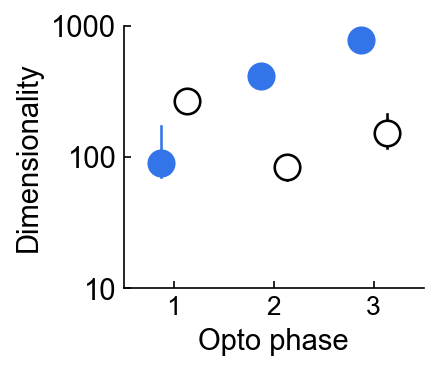

In [370]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.13
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]

################################################################################################################################################################

phases = ['post early','post late','post expert']
# phases = ['post late']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)

    cov_mats = np.array(Data_On.cov_mats_NCR)[phase_mask]
    
#     print(len(cov_mats))
#     for mat in cov_mats:
#         if type(mat) == float:
#             continue
#         n = len(mat)
#         if n < 2:
#             continue
#         covs = mat[~np.eye(n,n,dtype='bool')]
#         print(f"{np.mean(covs)} +/- {np.std(covs)}")
    
    
    #[~np.eye(n,n,dtype='bool')]
    
    M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac = 1,B=2000)
    
    print(M)
    print(Q1)
    print(Q3)
    print()
    
    ax.scatter(idx-offset,np.log10(M),c=LASER_COLOR,s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(Q1),np.log10(Q3)],c=LASER_COLOR,lw=s_wid)

    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask_control]
    M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,np.log10(M),fc='white',ec='k',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[np.log10(Q1),np.log10(Q3)],c='k',lw=s_wid)
    
    print(M)
    print(Q1)
    print(Q3)
    print()
    
# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,1])
# ax.set_yticks([0,np.log10(2),np.log10(4),np.log10(6),np.log10(8),1])
# ax.set_yticklabels(['1','2','4','6','8','10'])
ax.set_ylim([1,3])
ax.set_yticks([1,2,3])
ax.set_yticklabels(['10','100','1000'])
ax.set_ylabel('Dimensionality')
    
labels = ['1','2','3']
ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.set_xlabel('Opto phase')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opto vs Control dimensionality NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [371]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 250000

with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]

phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphases,'post early')
cov1 = np.array(Data_On.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p1,pp1,ppp1 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphasesOps,'post late')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data_On.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p2,pp2,ppp2 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphasesOps,'post expert')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data_On.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data.cov_mats_NCR)[phase_mask2]
p3,pp3,ppp3 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)


pvals = [p1,p2,p3]
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Total')
print(p_corr)

# ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
# _,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
# print('Numerator')
# print(pp_corr)

# pppvals = [ppp1,ppp2,ppp3,ppp4,ppp5,ppp6]
# _,ppp_corr = pg.multicomp(pppvals,method='fdr_bh')
# print('Denominator')
# print(ppp_corr)

<ipython-input-371-7087a73f6ded>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-371-7087a73f6ded>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-371-7087a73f6ded>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

Total
[0.110856   0.00348036 0.000408  ]


## Var Covar

<ipython-input-357-13026ac86473>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]


2.7231858397719804
0.13350563178548241


<ipython-input-357-13026ac86473>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask_control]


2.0163447150711082
0.12261855919952876
1.3470001507232445
0.06920145315370876


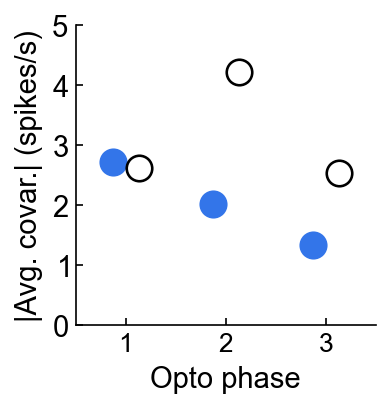

In [357]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 2, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.13
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]

################################################################################################################################################################

phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data_On.cov_mats_NCR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx-offset,(Mden),c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
    ax.plot([idx-offset,idx-offset],[(Mden-SEMden),(Mden+SEMden)],c=LASER_COLOR,lw=s_wid)
#     M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,np.log10(Mden),c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-offset,idx-offset],[np.log10(Q1den),np.log10(Q3den)],c=LASER_COLOR,lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
    cov_mats = np.array(Data.cov_mats_NCR)[phase_mask_control]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,(Mden),ec='k',fc='white',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mden-SEMden),(Mden+SEMden)],c='k',lw=s_wid)
    
# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,1])
# ax.set_yticks([0,np.log10(2),np.log10(4),np.log10(6),np.log10(8),1])
# ax.set_yticklabels(['1','2','4','6','8','10'])
ax.set_ylim([0,5])
ax.set_yticks([0,1,2,3,4,5])
ax.set_ylabel('|Avg. covar.| (spikes/s)')
    
labels = ['1','2','3']
ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.set_xlabel('Opto phase')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opto vs Control Avg Sq Covar NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [358]:
phases = ['post early','post late','post expert']
B = 2500#0

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post early')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_NCR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphasesOps,'post late')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_NCR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post expert')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_NCR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)

ppvals = [pp1,pp2,pp3]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Denominator
[4.66339134e-01 1.74635080e-05 9.52611999e-07]


<ipython-input-358-ced4dad3d3a7>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-358-ced4dad3d3a7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_NCR)[phase_mask1]
<ipython-input-358-ced4dad3d3a7>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

# Opto On vs Control CRs

## Dimm

<ipython-input-337-685f5ec4a7cd>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]


39.22889500600395 +/- 0.0
29.565967093982774 +/- 52.29379764949598


<ipython-input-337-685f5ec4a7cd>:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask_control]


76.73905724663261 +/- 0.0
66.77227903239137 +/- 90.37580867462619
60.731028217424196 +/- 0.0
34.867973231800065 +/- 150.32803024780628
52.90849634165964 +/- 0.0
46.322594997588496 +/- 60.33993083783293
46.019743484740374 +/- 0.0
42.92282140219128 +/- 49.9665882625977
169.6589134555001 +/- 0.0
132.89907928827614 +/- 213.0767630897607


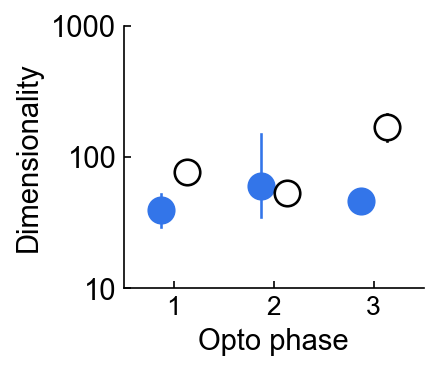

In [337]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 1.75, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.13
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]

################################################################################################################################################################

phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)

    cov_mats = np.array(Data_On.cov_mats_CR)[phase_mask]
    
    
#     print(len(cov_mats))
#     for mat in cov_mats:
#         if type(mat) == float:
#             continue
#         n = len(mat)
#         if n < 2:
#             continue
#         covs = mat[~np.eye(n,n,dtype='bool')]
#         print(f"{np.mean(covs)} +/- {np.std(covs)}")
#     print()
#     print()
#     print()
    
    
    M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx-offset,np.log10(M),c=LASER_COLOR,s=sz,lw=s_wid)
    ax.plot([idx-offset,idx-offset],[np.log10(Q1),np.log10(Q3)],c=LASER_COLOR,lw=s_wid)
    
    
#     print(len(cov_mats))
#     for mat in cov_mats:
#         if type(mat) == float:
#             continue
#         n = len(mat)
#         if n < 2:
#             continue
#         covs = mat[~np.eye(n,n,dtype='bool')]
#         print(f"{np.mean(covs)} +/- {np.std(covs)}")
#     print()
#     print()
#     print()

    cov_mats = np.array(Data.cov_mats_CR)[phase_mask_control]
    M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars_median_IQR(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,np.log10(M),fc='white',ec='k',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[np.log10(Q1),np.log10(Q3)],c='k',lw=s_wid)
    
# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,1])
# ax.set_yticks([0,np.log10(2),np.log10(4),np.log10(6),np.log10(8),1])
# ax.set_yticklabels(['1','2','4','6','8','10'])
ax.set_ylim([1,3])
ax.set_yticks([1,2,3])
ax.set_yticklabels(['10','100','1000'])
ax.set_ylabel('Dimensionality')
    
labels = ['1','2','3']
ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.set_xlabel('Opto phase')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opto vs Control dimensionality CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

<ipython-input-349-2f25f73c5166>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-349-2f25f73c5166>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-349-2f25f73c5166>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

0.05400000000000005
0.946


<ipython-input-349-2f25f73c5166>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]


0.5711999999999999
0.42879999999999996


<ipython-input-349-2f25f73c5166>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2 = np.array(Data.cov_mats_CR)[phase_mask2]


0.05479999999999996
0.9452
[0.1080000000000001, 0.8575999999999999, 0.10959999999999992]
Total
[0.1644 0.8576 0.1644]


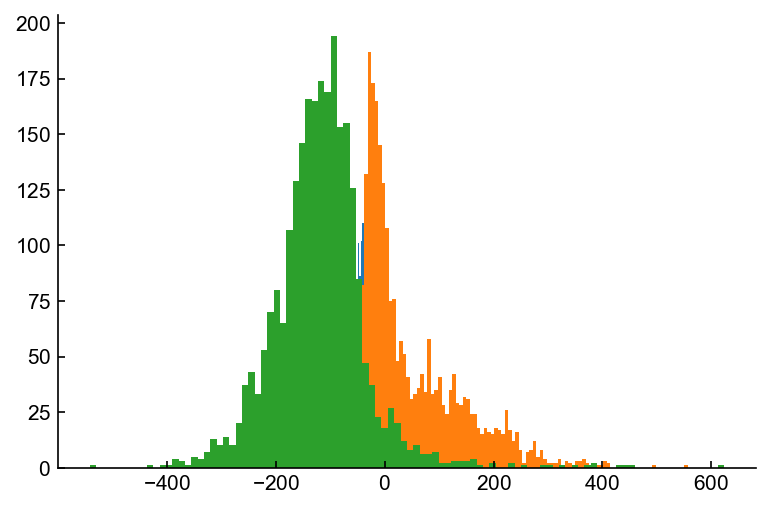

In [349]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
B = 2500

with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats = np.array(Data_On.cov_mats)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
Data_On.cov_mats_NCR = np.array(Data_On.cov_mats_NCR)[np.isin(Data_On.sessions,EnumSessionOps)]

phase_mask1 = np.char.equal(EILphasesOps,'post early')
phase_mask2 = np.char.equal(EILphases,'post early')
cov1 = np.array(Data_On.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p1,pp1,ppp1 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphasesOps,'post late')
phase_mask2 = np.char.equal(EILphases,'post late')
cov1 = np.array(Data_On.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p2,pp2,ppp2 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)

phase_mask1 = np.char.equal(EILphasesOps,'post expert')
phase_mask2 = np.char.equal(EILphases,'post expert')
cov1 = np.array(Data_On.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data.cov_mats_CR)[phase_mask2]
p3,pp3,ppp3 = bootstrap_pc_NCR_test_split(cov1,cov2,B=B)
# print(p3)

pvals = [p1,p2,p3]
print(pvals)
_,p_corr = pg.multicomp(pvals,method='fdr_bh')
print('Total')
print(p_corr)

# ppvals = [pp1,pp2,pp3,pp4,pp5,pp6]
# _,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
# print('Numerator')
# print(pp_corr)

# pppvals = [ppp1,ppp2,ppp3,ppp4,ppp5,ppp6]
# _,ppp_corr = pg.multicomp(pppvals,method='fdr_bh')
# print('Denominator')
# print(ppp_corr)

## Var Covar

<ipython-input-350-319a6a0f1c7d>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]


10.747084430799488
0.4467393182628698


<ipython-input-350-319a6a0f1c7d>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask_control]


12.344979840148117
0.9832990126763125
10.679931653076459
0.7284162952031096


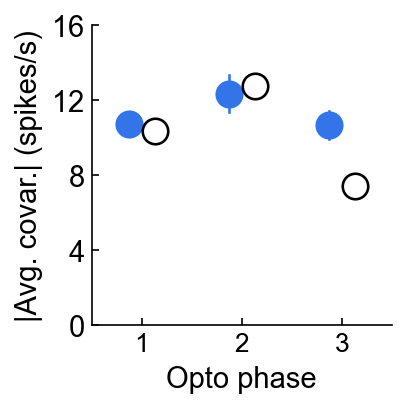

In [350]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(2, 2, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.13
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]

################################################################################################################################################################

phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data_On.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx-offset,(Mden),c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
    ax.plot([idx-offset,idx-offset],[(Mden-SEMden),(Mden+SEMden)],c=LASER_COLOR,lw=s_wid)
#     M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,np.log10(Mden),c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-offset,idx-offset],[np.log10(Q1den),np.log10(Q3den)],c=LASER_COLOR,lw=s_wid)
    
    print(Mden)
    print(SEMden)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask_control]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,(Mden),ec='k',fc='white',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mden-SEMden),(Mden+SEMden)],c='k',lw=s_wid)
    
# ax.scatter([],[],c='k',label='Log(dimm)')
# ax.scatter([],[],c='r',label='Log(pred_cov)')
# lgd = ax.legend(frameon=False,loc=(0.6,1))

# ax.set_ylim([0,1])
# ax.set_yticks([0,np.log10(2),np.log10(4),np.log10(6),np.log10(8),1])
# ax.set_yticklabels(['1','2','4','6','8','10'])
ax.set_ylim([0,16])
ax.set_yticks([0,4,8,12,16])
ax.set_ylabel('|Avg. covar.| (spikes/s)')
    
labels = ['1','2','3']
ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.set_xlabel('Opto phase')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opto vs Control Avg Sq Covar CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [351]:
phases = ['post early','post late','post expert']
B = 2500#0

phase_mask1 = np.char.equal(EILphases,'post early')
phase_mask2 = np.char.equal(EILphasesOps,'post early')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_CR)[phase_mask2]
p1,pp1 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post late')
phase_mask2 = np.char.equal(EILphasesOps,'post late')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_CR)[phase_mask2]
p2,pp2 = trad_stats_num_den(cov1,cov2)

phase_mask1 = np.char.equal(EILphases,'post expert')
phase_mask2 = np.char.equal(EILphasesOps,'post expert')
cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
cov2 = np.array(Data_On.cov_mats_CR)[phase_mask2]
p3,pp3 = trad_stats_num_den(cov1,cov2)

ppvals = [pp1,pp2,pp3]
_,pp_corr = pg.multicomp(ppvals,method='fdr_bh')
print('Denominator')
print(pp_corr)

Denominator
[0.70536041 0.70536041 0.00153767]


<ipython-input-351-53b0cc50b538>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-351-53b0cc50b538>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov1 = np.array(Data.cov_mats_CR)[phase_mask1]
<ipython-input-351-53b0cc50b538>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

<ipython-input-187-8ddbb3a5cade>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]
<ipython-input-187-8ddbb3a5cade>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_CR)[phase_mask_control]


10.390064648308762
0.26117864424508036
12.792520181143017
0.613781689721106
7.435139205386671
0.4814330546166829


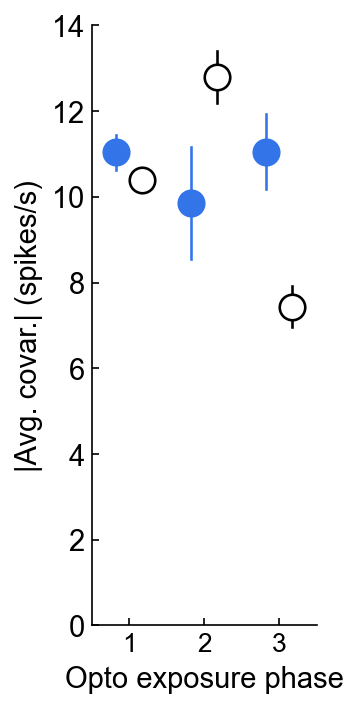

In [187]:
with open('D:\\Cov_Mats_Opto_On.pickle', 'rb') as f:
    Data_On = pickle.load(f)    
with open('D:\\Cov_Mats.pickle', 'rb') as f:
    Data = pickle.load(f)
    
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')
        
fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
sz=150
s_wid=1.25
offset=0.175
switch_offset=0
        
#Remove Cloudy data
np.isin(Data_On.sessions,EnumSessionOps)
Data_On.cov_mats_CR = np.array(Data_On.cov_mats_CR)[np.isin(Data_On.sessions,EnumSessionOps)]

################################################################################################################################################################

phases = ['post early','post late','post expert']
for idx,phase in enumerate(phases):
    phase_mask = np.char.equal(EILphasesOps,phase)
    phase_mask_control = np.char.equal(EILphases,phase)
    
    cov_mats = np.array(Data_On.cov_mats_CR)[phase_mask]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx-offset,(Mden),c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
    ax.plot([idx-offset,idx-offset],[(Mden-SEMden),(Mden+SEMden)],c=LASER_COLOR,lw=s_wid)
#     M,Q1,Q3,Mnum,Q1num,Q3num,Mden,Q1den,Q3den = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
#     ax.scatter(idx-offset,np.log10(Mden),c=LASER_COLOR,s=sz,lw=s_wid,zorder=10)
#     ax.plot([idx-offset,idx-offset],[np.log10(Q1den),np.log10(Q3den)],c=LASER_COLOR,lw=s_wid)
    
#     print(Mden)
#     print(SEMden)
    
    cov_mats = np.array(Data.cov_mats_CR)[phase_mask_control]
    M,SEM,Mnum,SEMnum,Mden,SEMden = bootstrap_dimensionality_all_vars(cov_mats,n_frac = 1,B=2000)
    ax.scatter(idx+offset,(Mden),ec='k',fc='white',s=sz,lw=s_wid,zorder=10)
    ax.plot([idx+offset,idx+offset],[(Mden-SEMden),(Mden+SEMden)],c='k',lw=s_wid)
    
    print(Mden)
    print(SEMden)

ax.set_ylim([0,14])
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_ylabel('|Avg. covar.| (spikes/s)')
    
labels = ['1','2','3']
ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.set_xlabel('Opto exposure phase')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
    
artists = []
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opto vs Control Avg Sq Covar CR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=artists, bbox_inches='tight')

In [68]:
B = [100.79815462023895, 96.23770273948034, 435.449041925484, 466.25770020551164, 454.9268943658974, 639.9341110485949, 121.46460896568234, 402.24542687225664, 535.1730172848387, 512.5510721231265, 513.6451838269513, 304.2396006484623, 314.5703521936799, 120.85050531368414, 100.24177136769696, 360.0714157363594, 123.05893006054234, 447.74023111686563, 446.5466231513476, 511.3982529004347, 102.46079577551006, 347.8828659046903, 96.19108819702954, 360.07141573635937, 462.97243184554577, 638.1446864236779, 530.6991253204808, 120.85050531368411, 151.10921198002347, 365.41193223422874, 606.4454905805079, 598.7167235091132, 236.49611148836738, 565.9693952666904, 482.30932887583134, 314.439921485882, 319.0184847035122, 870.4678670500356, 513.6451838269512, 120.74750900563889, 402.24542687225664, 502.32835512933724, 469.6454775601069, 338.41928829208524, 339.88094338179013, 435.7108195845337, 360.599297751098, 338.4192882920852, 125.30657307247358, 419.2022176395477, 111.16062988295812, 326.5138735988087, 377.42848596113737, 403.340346864056, 466.058257733151, 294.1449403337029, 404.42887774462815, 462.1867348982338, 111.36629759045775, 360.58397410781765, 89.94789823388132, 105.99134612043031, 530.6991253204808, 462.1867348982338, 482.46388320733104, 91.60040076120883, 338.4192882920852, 110.82489230005908, 360.599297751098, 499.59444144556676, 438.3365228201841, 357.7525947938608, 377.5465314888749, 429.5214393872075, 97.5137957132243, 111.3480263211261, 578.9019184971123, 274.5724113741668, 346.2987833245419, 433.81749910812863, 97.51379571322431, 324.4380574746661, 405.77004722971606, 148.19687560691173, 123.54018868947193, 600.4779283076384, 512.5510721231265, 566.2954135469951, 364.5561870062167, 338.41928829208524, 104.04649504141965, 111.18047721061475, 346.298783324542, 382.10940525870893, 447.7402311168657, 125.30657307247358, 314.57035219368, 504.41398605984676, 136.75473265053785, 304.2396006484623, 137.91716468555373, 93.59091875102891, 119.13277933777503, 513.6451838269512, 482.1528677541011, 111.93008537186942, 107.49159540215952, 110.82489230005905, 323.11574474079913, 112.38383468027158, 360.0714157363594, 111.5473972852743, 112.56782577409767, 95.00694526796613, 346.29878332454194, 638.3203016578653, 402.24542687225653, 540.1138202078386, 556.2935627138463, 111.36629759045775, 339.6567056822204, 111.3480263211261, 587.6357196185219, 98.74278131954965, 393.4099381435982, 382.10940525870893, 310.82789048956676, 345.3402731687518, 482.46388320733104, 382.33144322704396, 404.42887774462815, 331.1064015248732, 120.25432915625862, 403.340346864056, 436.9514313308816, 127.22183260913448, 111.32789343420828, 517.7443746049906, 462.1867348982338, 546.2060393675454, 402.2454268722566, 364.55618700621676, 438.33652282018414, 365.4119322342287, 538.9607264557869, 293.78211002804323, 324.4380574746661, 124.17954988613398, 111.36629759045773, 360.07141573635937, 110.908199512133, 135.06667671680796, 387.47481623279356, 457.2216007928119, 110.82489230005908, 377.66446860158356, 328.07009036369533, 392.1694358431859, 331.48465742427715, 105.99134612043031, 124.96687144361015, 110.77866685275679, 448.3511842397143, 102.46079577551012, 339.8809433817901, 111.54739728527426, 448.3511842397143, 331.4846574242771, 119.71913216220067, 581.9685671426023, 457.22160079281184, 104.04649504141966, 110.65085657875582, 137.91716468555373, 436.9514313308816, 429.6300959553877, 96.23770273948034, 306.5073423557117, 502.32835512933747, 466.2577002055115, 111.97502560648473, 499.5944414455669, 870.4678670500355, 360.58397410781765, 447.18992078402385, 85.81985548063007, 404.5000667750301, 95.00694526796613, 435.94661712446987, 417.5959013591084, 360.59929775109794, 123.78861866163119, 353.9605387991017, 110.65085657875579, 297.6700496491846, 454.9268943658974, 297.25279705165883, 584.8766098597322, 324.43805747466615, 402.71533266505764, 283.85823042857027, 126.34053689286242, 121.53992842098204, 327.8677912633612, 520.961431516216, 368.29955520821954, 512.5510721231266, 529.868379975963, 98.74278131954966, 120.3094235374275, 331.10640152487326, 581.9685671426024, 335.4684530911274, 529.8683799759631, 556.0848794111575, 110.65085657875582, 478.5942206245913, 430.63923944114566, 101.4780705086047, 99.62735186046854, 304.2396006484623, 377.66446860158356, 381.8911926880344, 387.21497080439514, 529.7489652771912, 304.2396006484623, 401.20936380589313, 100.79815462023893, 297.6700496491846, 346.07940650075835, 98.74278131954965, 435.4490419254839, 477.2967682416008, 314.5703521936799, 132.55789765287284, 123.05893006054234, 436.9514313308816, 482.46388320733104, 130.70955898162134, 482.30932887583134, 314.439921485882, 579.4339724615461, 501.6845606566145, 560.8235640749026, 304.2396006484623, 447.7402311168656, 501.52088818154243, 95.0069452679661, 404.42887774462815, 120.80568421164597, 309.3961426606963, 307.28015474267335, 435.44904192548404, 108.96670097674631, 99.8621168113867, 328.07009036369533, 112.62995973694028, 535.1730172848388, 469.645477560107, 429.63009595538773, 346.2987833245419, 390.5360670794589, 417.5959013591084, 103.3219090764459, 131.17843783829818, 326.51387359880863, 104.04649504141966, 129.05384157904987, 326.5138735988087, 359.5049665993085, 538.9607264557869, 531.4794313327269, 121.46460896568236, 364.5561870062168, 110.77866685275679, 123.78861866163119, 120.2543291562586, 139.58600297212425, 417.59590135910844, 556.1995339157891, 96.41468079519028, 360.599297751098, 102.46079577551009, 368.2995552082196, 637.1414273544333, 95.00694526796613, 106.6617791812172, 377.66446860158356, 112.56782577409766, 331.48465742427715, 309.3961426606964, 566.295413546995, 123.05893006054232, 304.2396006484623, 482.1528677541011, 393.40993814359825, 638.6104856647928, 99.89206002772427, 119.13277933777503, 110.99362229390059, 417.5959013591083, 512.5510721231266, 338.0917356938327, 482.3093288758313, 547.091925740084, 401.5195823898701, 393.40993814359837, 144.8009060535016, 530.6991253204808, 387.99116099020694, 407.13555798527085, 110.82489230005909, 402.24542687225653, 382.33144322704396, 360.0714157363594, 110.82489230005909, 469.6454775601069, 436.95143133088175, 129.87452137699364, 520.961431516216, 402.71533266505753, 638.3203016578653, 123.78861866163118, 462.8383165339326, 390.53606707945886, 102.48022691094526, 103.25571497786872, 1071.7599458668637, 528.5478885692447, 111.32789343420826, 1067.5858297771058, 636.962263876597, 314.57035219368, 435.449041925484, 538.960726455787, 466.0582577331511, 111.36629759045773, 314.439921485882, 499.5944414455669, 587.635719618522, 482.463883207331, 482.15286775410124, 598.7167235091132, 558.898207632333, 490.0560719758354, 112.56782577409764, 105.99134612043031, 448.3511842397144, 419.2022176395476, 101.4780705086047, 331.10640152487326, 309.2144557760949, 110.82489230005908, 502.9900022929526, 347.045661014555, 116.31898381829424, 110.06086322867282, 110.06086322867282, 435.7108195845337, 105.41292527809229, 511.3982529004347, 110.99362229390059, 289.29457422239665, 387.4748162327936, 430.43976256217036, 489.9213335732717, 98.5090125583262, 491.69715079789194, 100.79815462023895, 140.09653894936062, 127.22183260913445, 304.2396006484623, 331.4846574242771, 110.99362229390059, 135.87934350309507, 335.4684530911274, 564.0490692140957, 86.19321278473423, 120.80568421164597, 85.81985548063005, 364.55618700621676, 314.439921485882, 121.46460896568236, 348.7909363900222, 382.10940525870893, 435.7108195845338, 128.20854766120755, 96.41468079519029, 502.32835512933747, 113.78109905609904, 462.5227773739223, 636.593609945904, 144.7777584546548, 469.6454775601069, 463.8392759836688, 120.25432915625862, 133.36789809034255, 513.6451838269513, 95.05221468953694, 402.8689405322642, 91.46497929067873, 91.46497929067876, 324.43805747466615, 314.439921485882, 152.63709607615297, 637.1414273544334, 365.41193223422863, 494.14097881965216, 448.3511842397143, 110.77866685275679, 462.6796711081395, 482.30932887583134, 120.2543291562586, 98.50901255832619, 491.69715079789177, 102.48022691094526, 360.0714157363594, 102.46079577551006, 110.31602194999863, 112.56782577409767, 387.47481623279356, 359.5049665993085, 339.6567056822204, 607.7244138953561, 584.8766098597322, 110.82489230005908, 360.599297751098, 314.5703521936799, 121.20884642323962, 462.9724318455457, 106.25299510646968, 513.6451838269512, 447.18992078402385, 390.53606707945886, 532.2124035368021, 142.52471470236154, 542.5795457051886, 448.35118423971426, 98.74278131954966, 512.5510721231265, 294.14494033370283, 274.5724113741668, 403.340346864056, 297.6700496491846, 446.5466231513476, 106.25299510646964, 314.57035219368, 135.41205202008095, 504.4139860598467, 405.77004722971594, 461.367246563234, 478.5942206245913, 111.12465468432593, 328.07009036369533, 122.13565571596303, 323.11574474079913, 488.3357579563512, 130.70955898162134, 323.1157447407991, 521.0983202669723, 137.91716468555373, 328.07009036369533, 301.54353974195374, 429.6300959553878, 314.5703521936799, 402.7153326650576, 1105.6981017993912, 482.1528677541011, 404.42887774462815, 99.89206002772421, 112.5678257740977, 556.2935627138463, 124.17954988613398, 133.36789809034255, 95.00694526796613, 365.41193223422863, 531.4794313327269, 347.88286590469016, 560.8235640749026, 419.2022176395476, 93.59091875102888, 113.78109905609905, 404.42887774462815, 357.7525947938608, 129.8745213769936, 508.21584315498336, 384.82575382921465, 529.7489652771912, 360.0714157363594, 360.0714157363594, 97.39484526814529, 289.2945742223967, 94.22752925136902, 359.5049665993085, 338.4192882920852, 377.66446860158356, 447.18992078402385, 327.5017194687177, 542.5795457051886, 99.86211681138663, 381.8911926880343, 566.2954135469951, 120.8505053136841, 402.24542687225664, 111.3480263211261, 359.5049665993085, 118.58550829559293, 142.73078960823028, 368.29955520821954, 462.50218646733185, 469.6454775601069, 110.99362229390059, 324.43805747466615, 335.4684530911274, 429.63009595538773, 556.2935627138465, 1105.6981017993912, 335.4684530911275, 109.99870963155263, 475.4615780917099, 431.7796400401486, 297.6700496491846, 111.93008537186942, 382.3314432270441, 556.3682886875532, 337.10497383638915, 353.26224518262643, 102.46079577551012, 96.41468079519028, 128.20854766120758, 133.36789809034255, 110.82489230005908, 529.7489652771912, 331.1064015248734, 111.9300853718694, 102.46079577551012, 335.4684530911274, 335.4684530911274, 111.97502560648473, 402.24542687225664, 512.5510721231266, 100.79815462023895, 529.7489652771912, 1071.7599458668642, 462.52277737392217, 454.9268943658975, 560.0958437445768, 309.2144557760949, 407.13555798527096, 501.6845606566146, 365.41193223422874, 382.10940525870893, 120.70464221650049, 512.5510721231266, 314.57035219368, 466.0582577331511, 138.29630576754812, 528.5478885692447, 140.09653894936056, 120.85050531368411, 382.33144322704396, 106.54850228049573, 402.24542687225664, 131.17843783829818, 103.25571497786873, 363.81620817901603, 345.3402731687519, 105.99134612043031, 122.13565571596303, 347.3104153938424, 331.10640152487326, 331.10640152487326, 566.2954135469952, 338.41928829208524, 419.2022176395477, 446.54662315134766, 330.9957724866326, 135.41205202008095, 435.7108195845337, 144.77775845465482, 96.41468079519026, 346.2987833245419, 347.3104153938424, 111.9300853718694, 105.31895809219135, 517.7443746049905, 331.10640152487326, 137.20082548779615, 123.78861866163118, 409.6573560451769, 382.10940525870893, 112.77755177289599, 511.3982529004347, 309.3961426606964, 138.29630576754812, 556.2935627138462, 110.06086322867282, 363.81620817901603, 462.52277737392217, 123.54018868947193, 427.39901041337686, 110.06086322867282, 482.3093288758313, 112.56782577409764, 100.79815462023893, 111.54739728527426, 294.2196811588789, 309.2144557760949, 461.367246563234, 448.3511842397143, 314.439921485882, 102.46079577551006, 297.6700496491846, 364.5561870062167, 531.4794313327269, 331.1064015248732, 144.7777584546548, 407.1355579852709, 121.20884642323962, 530.6991253204808, 447.18992078402385, 429.6300959553877, 429.63009595538773, 553.1712302560849, 324.4380574746661, 96.76638040301107, 532.2124035368021, 328.07009036369533, 125.70784219032574, 364.55618700621676, 404.42887774462804, 120.80568421164597, 309.3961426606963, 382.10940525870893, 460.68780642321474, 530.6991253204807, 111.16062988295812, 538.9607264557869, 466.2577002055115, 98.74278131954966, 528.5478885692447, 490.0560719758353, 309.2144557760949, 103.25571497786873, 427.3990104133769, 504.41398605984676, 97.51379571322431, 446.54662315134766, 638.144686423678, 110.99362229390059, 486.5454994266608, 482.15286775410124, 430.63923944114566, 403.34034686405596, 432.6276098723635, 319.39663566356245, 94.74964300073127, 454.9268943658973, 405.77004722971594, 390.53606707945886, 133.36789809034255, 387.47481623279356, 116.31898381829421, 461.36724656323406, 475.4615780917099, 488.3357579563512, 1024.1621360316353, 364.5561870062167, 489.9213335732717, 353.9605387991017, 120.70464221650049, 638.1446864236779, 462.5227773739222, 581.9685671426023, 137.91716468555373, 598.7167235091132, 556.2935627138462, 353.9605387991017, 99.86211681138668, 328.0700903636953, 920.0004389779002, 108.96670097674628, 301.5435397419538, 462.1867348982338, 427.6028084177555, 536.9746950511304, 289.29457422239676, 102.48022691094526, 368.2995552082196, 462.52277737392217, 638.3203016578653, 600.4779283076384, 122.13565571596304, 103.25571497786873, 482.463883207331, 107.4915954021595, 1067.5858297771056, 447.18992078402385, 97.39484526814527, 393.4099381435982, 446.54662315134766, 84.3845611394372, 346.2987833245419, 111.93008537186942, 419.50538906008353, 390.53606707945886, 360.0714157363594, 133.36789809034255, 345.3402731687518, 331.4846574242771, 347.8828659046902, 331.1064015248732, 360.58397410781765, 390.53606707945886, 125.30657307247358, 360.0714157363594, 284.71700561919585, 407.13555798527085, 335.4684530911274, 538.960726455787, 96.41468079519028, 478.3970607099448, 102.48022691094526, 530.6991253204808, 138.77798683068946, 98.5090125583262, 419.50538906008353, 140.09653894936062, 382.10940525870893, 346.298783324542, 1123.3146674078757, 486.5454994266608, 407.13555798527085, 135.06667671680796, 365.41193223422874, 114.72496399275639, 346.2987833245419, 462.8202660274133, 103.25571497786873, 96.23770273948034, 417.5959013591084, 1091.6758552257502, 110.32227501890763, 324.43805747466615, 103.98381028569878, 110.90819951213301, 417.5959013591084, 105.41292527809232, 359.5049665993085, 338.4192882920852, 430.4397625621706, 542.5795457051886, 328.0700903636953, 314.439921485882, 120.2543291562586, 314.439921485882, 119.13277933777502, 521.0983202669725, 466.058257733151, 414.50549547574343, 448.3511842397143, 360.0714157363594, 404.5000667750301, 125.30657307247358, 326.5138735988086, 360.0714157363594, 347.3104153938424, 339.6567056822204, 432.6276098723636, 377.66446860158356, 127.22183260913448, 328.0700903636953, 360.0714157363594, 387.21497080439514, 102.48022691094526, 99.62735186046854, 121.53992842098204, 84.38456113943721, 111.54739728527429, 338.4192882920852, 116.31898381829421, 103.3852188653974, 102.48022691094526, 392.1694358431859, 402.24542687225664, 101.01217506736317, 641.4426744132354, 382.3314432270441, 438.3365228201842, 478.3970607099448, 466.0582577331511, 387.99116099020694, 324.43805747466615, 110.99362229390056, 419.2022176395476, 339.6567056822203, 486.5454994266608, 490.05607197583544, 135.87934350309504, 382.10940525870893, 123.78861866163119, 111.93008537186942, 125.3065730724736, 561.5206402440446, 137.20082548779615, 109.19446084088128, 528.5478885692447, 110.00528780166984, 482.15286775410124, 377.4284859611373, 461.9694148195761, 123.78861866163119, 475.4615780917099, 448.3511842397143, 331.10640152487326, 110.31602194999863, 466.0582577331511, 486.5454994266608, 359.5049665993085, 360.599297751098, 105.31895809219132, 598.7167235091132, 542.5795457051885, 114.54596747664394, 114.72496399275636, 314.57035219368, 407.13555798527085, 359.50496659930843, 531.479431332727, 122.13565571596303, 417.59590135910844, 136.81716406878976, 430.7177112451669, 331.1064015248733, 236.49611148836738, 110.908199512133, 112.77755177289599, 556.1995339157891, 105.31895809219135, 360.0714157363594, 345.3402731687518, 531.4794313327269, 337.10497383638915, 556.3682886875532, 478.3970607099448, 327.1538954568799, 122.76024351846135, 111.18047721061475, 419.20221763954777, 346.29878332454194, 401.20936380589325, 121.53992842098204, 482.30932887583134, 493.34510411279814, 382.10940525870893, 111.18047721061477, 446.5466231513478, 435.94661712446987, 112.77755177289599, 504.9335479049094, 364.55618700621676, 111.3480263211261, 110.65085657875582, 377.54653148887485, 486.54549942666074, 360.0714157363594, 382.10940525870893, 345.3402731687518, 120.25432915625862, 113.6278876702813, 490.05607197583544, 118.78459203077654, 457.22160079281196, 577.695364280574, 98.74278131954965, 390.5360670794588, 498.43247577008725, 347.045661014555, 513.6451838269513, 1037.6711244152327, 446.54662315134766, 297.25279705165883, 101.47807050860467, 109.99870963155263, 377.66446860158356, 338.0917356938327, 402.8689405322642, 447.74023111686563, 301.5435397419537, 404.42887774462815, 511.3982529004347, 110.65085657875579, 144.80090605350156, 359.5049665993084, 100.79815462023893, 436.95143133088163, 466.2577002055116, 110.908199512133, 387.99116099020694, 360.0714157363594, 466.2577002055116, 493.3451041127979, 482.30932887583134, 140.95132025297184, 530.6991253204808, 111.9300853718694, 430.7177112451669, 429.63009595538756, 560.0958437445765, 328.07009036369533, 100.79815462023895, 360.0714157363594, 298.2871018583896, 331.10640152487326, 110.99362229390059, 486.54549942666074, 556.1995339157891, 482.30932887583134, 103.25571497786872, 337.10497383638915, 407.13555798527096, 105.07907129616794, 347.0456610145549, 377.4284859611373, 129.8745213769936, 580.1267475947988, 95.00694526796613, 89.94789823388128, 382.331443227044, 120.85050531368411, 110.99362229390059, 490.0560719758353, 347.0456610145549, 93.57413153181626, 414.42878000127376, 96.23770273948031, 579.7902746911705, 478.39706070994475, 88.87283708903354, 564.0490692140958, 117.93374043496854, 121.46460896568234, 556.2935627138463, 112.56782577409764, 498.43247577008714, 447.74023111686563, 331.4846574242771, 110.6508565787558, 114.54596747664397, 110.82489230005908, 314.57035219368, 435.4490419254839, 365.4119322342287, 382.10940525870893, 448.3511842397143, 407.13555798527085, 110.06086322867282, 490.05607197583544, 600.4779283076384, 360.5839741078176, 368.2995552082196, 430.63923944114566, 462.50218646733174, 111.5473972852743, 345.3402731687518, 123.78861866163118, 461.9694148195761, 108.52643234855516, 123.54018868947193, 111.36629759045773, 447.7402311168657, 551.7113362561752, 435.44904192548404, 466.2577002055115, 482.15286775410124, 382.10940525870893, 482.15286775410124, 512.5510721231266, 283.85823042857027, 85.81985548063005, 505.35219912290523, 429.5214393872075, 427.3990104133768, 112.77755177289599, 111.9300853718694, 130.7095589816213, 403.34034686405596, 327.8677912633612, 97.51379571322433, 435.44904192548404, 430.7177112451669, 109.99870963155263, 338.0917356938327, 511.3982529004347, 127.22183260913448, 337.1049738363892, 120.25432915625862, 101.01217506736315, 133.36789809034255, 117.93374043496854, 131.47751993643982, 110.82489230005908, 409.657356045177, 99.89206002772423, 417.5959013591084, 85.27078269172102, 100.79815462023895, 592.3684427768546, 430.63923944114566, 368.2995552082195, 111.97502560648473, 427.3990104133768, 338.41928829208524, 113.62788767028127, 556.2935627138462, 377.42848596113737, 118.78459203077654, 477.2967682416007, 140.95132025297184, 88.07623356635555, 511.3982529004347, 128.20854766120755, 123.05893006054234, 404.42887774462804, 96.23770273948035, 466.058257733151, 105.99134612043028, 110.908199512133, 110.82489230005908, 377.5465314888749, 360.599297751098, 407.13555798527085, 546.9287066637446, 502.32835512933735, 105.31895809219132, 359.5049665993084, 327.86779126336126, 359.5049665993084, 407.135557985271, 403.340346864056, 566.295413546995, 403.34034686405596, 403.340346864056, 345.3402731687518, 314.439921485882, 457.22160079281196, 360.599297751098, 132.39035298723925, 359.50496659930843, 513.6451838269512, 326.5138735988086, 133.36789809034255, 111.12465468432592, 110.90819951213302, 404.42887774462815, 920.0004389778999, 136.81716406878974, 357.7525947938608, 289.2945742223967, 430.7177112451669, 129.05384157904987, 108.96670097674628, 105.31895809219135, 110.99362229390059, 547.091925740084, 447.74023111686563, 596.8872119457769, 112.56782577409764, 417.5959013591083, 117.93374043496856, 469.6454775601069, 306.5073423557117, 556.3682886875532, 127.2218326091345, 119.71913216220067, 553.171230256085, 475.4615780917099, 462.83831653393236, 387.4748162327935, 309.3961426606964, 123.78861866163118, 360.599297751098, 482.3093288758313, 307.2801547426734, 504.93354790490946, 112.56782577409766, 346.29878332454194, 596.8872119457769, 121.46460896568236, 92.52397217824202, 119.71913216220067, 111.93008537186942, 461.9694148195761, 404.5000667750301, 477.29676824160066, 110.99362229390059, 382.10940525870893, 520.961431516216, 402.7153326650576, 99.86211681138668, 432.6276098723635, 377.66446860158356, 360.0714157363594, 360.0714157363594, 600.4779283076384, 405.47734769502193, 324.43805747466615, 390.53606707945886, 96.41468079519026, 129.05384157904987, 1024.1621360316353, 114.7249639927564, 435.4490419254839, 138.77798683068946, 95.00694526796613, 89.94789823388128, 382.10940525870893, 532.6614614297575, 556.0848794111575, 123.02349295485386, 478.5942206245914, 493.3451041127979, 114.72496399275639, 540.1138202078386, 120.00634431127095, 486.54549942666074, 490.05607197583544, 368.29955520821954, 360.0714157363594, 111.18047721061475, 382.1094052587089, 338.4192882920852, 448.3511842397143, 531.4794313327269, 120.74750900563892, 337.1049738363891, 293.78211002804323, 347.0456610145549, 360.59929775109794, 462.50218646733174, 110.82489230005908, 405.77004722971594, 123.54018868947193, 346.29878332454194, 544.0656197082926, 360.599297751098, 500.20513656882645, 359.50496659930855, 462.50218646733185, 122.76024351846137, 107.18994230614285, 131.05447715575747, 357.7525947938608, 331.10640152487326, 108.96670097674631, 636.2109136287681, 111.34802632112607, 430.7177112451669, 102.46079577551006, 91.46497929067874, 98.74278131954965, 120.85050531368411, 579.7902746911705, 367.09836338293707, 119.13277933777502, 119.13277933777502, 436.9514313308816, 112.56782577409764, 417.5959013591084, 517.7443746049905, 920.0004389778998, 339.88094338179, 330.9957724866326, 475.4615780917099, 110.31602194999863, 121.53992842098205, 98.50901255832622, 330.9957724866325, 461.9694148195761, 110.99362229390059, 99.8621168113867, 556.3682886875532, 436.95143133088163, 92.52397217824202, 148.1968756069117, 556.1995339157891, 123.54018868947193, 404.5000667750301, 331.10640152487326, 84.38456113943721, 314.439921485882, 538.960726455787, 137.20082548779612, 447.74023111686563, 448.3511842397143, 491.69715079789194, 84.3845611394372, 511.39825290043484, 123.78861866163119, 546.2060393675454, 447.74023111686563, 131.05447715575747, 462.50218646733185, 577.0705888321445, 579.433972461546, 331.4846574242771, 96.41468079519025, 382.1094052587089, 427.39901041337686, 360.599297751098, 111.34802632112611, 417.5959013591084, 404.5000667750301, 128.20854766120758, 328.07009036369533, 511.3982529004347, 404.42887774462815, 111.32789343420826, 109.99870963155263, 435.44904192548404, 129.0538415790499, 346.29878332454194, 360.5839741078176, 131.05447715575747, 447.18992078402385, 538.9607264557869, 111.18047721061477, 128.20854766120755, 324.43805747466615, 142.52471470236154, 556.199533915789, 363.81620817901603, 377.5465314888749, 307.2801547426734, 431.7796400401485, 365.4119322342287, 110.99362229390059, 512.5510721231266, 579.7902746911703, 338.41928829208524, 435.94661712446987, 529.7489652771912, 556.2935627138462, 105.99134612043031, 347.0456610145549, 88.07623356635553, 538.960726455787, 482.30932887583134, 104.04649504141966, 113.78109905609904, 338.4192882920852, 448.3511842397143, 96.23770273948035, 435.7108195845335, 347.045661014555, 121.53992842098205, 124.17954988613398, 556.2935627138462, 402.7153326650576, 331.10640152487326, 430.7177112451669, 577.695364280574, 324.43805747466615, 368.29955520821954, 124.17954988613398, 297.2527970516589, 110.908199512133, 427.3990104133769, 404.42887774462815, 110.82489230005909, 502.32835512933747, 128.06153775734379, 529.7489652771912, 482.30932887583134, 130.70955898162134, 96.41468079519029, 98.74278131954965, 135.87934350309507, 103.25571497786873, 447.7402311168657, 125.30657307247358, 314.43992148588194, 638.6104856647928, 110.82489230005909, 337.10497383638915, 95.05221468953694, 121.53992842098204, 123.78861866163118, 109.99870963155263, 309.3961426606964, 346.2987833245419, 110.32227501890765, 360.599297751098, 477.2967682416006, 460.68780642321474, 393.4099381435982, 148.19687560691173, 337.1049738363892, 553.1712302560849, 513.6451838269513, 482.1528677541011, 106.54850228049574, 579.7902746911705, 347.3104153938424, 102.46079577551005, 304.2396006484623, 538.960726455787, 365.41193223422874, 364.55618700621676, 360.59929775109794, 482.30932887583134, 558.8982076323332, 98.74278131954966, 326.51387359880863, 405.77004722971594, 430.7177112451669, 402.2454268722566, 125.55946652181709, 338.41928829208524, 448.35118423971426, 293.78211002804323, 498.43247577008725, 579.4339724615461, 360.58397410781765, 490.0560719758353, 1071.759945866864, 110.65085657875579, 560.8235640749025, 501.6845606566146, 337.10497383638915, 491.69715079789177, 387.99116099020694, 461.9694148195761, 123.05893006054232, 110.65085657875579, 584.8766098597322, 520.961431516216, 382.10940525870893, 436.9514313308816, 387.99116099020694, 404.42887774462815, 438.3365228201842, 540.1138202078386, 110.82489230005908, 331.4846574242771, 363.81620817901603, 95.00694526796615, 482.463883207331, 493.34510411279814, 123.05893006054232, 99.89206002772423, 382.10940525870893, 365.4119322342287, 461.9694148195761, 331.48465742427715, 108.96670097674631, 314.57035219367987, 113.56875778739872, 124.17954988613396, 339.88094338179013, 96.41468079519026, 346.29878332454194, 110.06086322867282, 95.00694526796613, 505.3521991229052, 124.96687144361015, 113.78109905609905, 462.83831653393247, 381.8911926880344, 546.9287066637446, 435.44904192548387, 111.12465468432589, 387.991160990207, 347.31041539384233, 556.2935627138463, 592.3684427768547, 529.7489652771912, 382.3314432270441, 579.7902746911705, 137.20082548779612, 106.66177918121714, 429.5214393872075, 530.6991253204808, 390.53606707945875, 532.2124035368021, 446.5466231513478, 98.50901255832623, 448.3511842397143, 466.058257733151, 564.0490692140958, 414.5054954757436, 363.81620817901603, 367.0983633829371, 346.29878332454194, 475.4615780917099, 100.79815462023895, 98.74278131954966, 390.53606707945886, 409.657356045177, 381.8911926880344, 339.88094338179013, 294.14494033370283, 103.32190907644586, 236.49611148836738, 346.29878332454194, 110.65085657875579, 402.8689405322644, 110.77866685275679, 89.94789823388128, 504.93354790490935, 121.53992842098205, 402.71533266505753, 357.7525947938608, 430.4397625621706, 133.36789809034255, 309.3961426606964, 553.1712302560849, 100.79815462023895, 401.20936380589325, 402.2454268722566, 339.88094338179, 402.71533266505753, 556.2935627138465, 129.0538415790499, 360.07141573635937, 403.34034686405596, 130.70955898162134, 561.5206402440447, 508.2158431549835, 93.59091875102891, 381.8911926880343, 338.0917356938327, 98.74278131954965, 123.54018868947193, 140.0965389493606, 318.6332615024414, 529.8683799759631, 435.44904192548404, 327.1538954568799, 101.93129544811103, 346.29878332454194, 365.41193223422874, 381.8911926880343, 501.52088818154243, 499.59444144556676, 377.66446860158356, 454.9268943658974, 111.9300853718694, 553.1712302560849, 414.4287800012737, 402.7153326650576, 103.25571497786873, 377.66446860158356, 535.9982427800797, 513.6451838269512, 477.2967682416008, 402.86894053226433, 404.42887774462815, 347.88286590469033, 111.36629759045773, 120.8505053136841, 339.6567056822204, 365.4119322342287, 111.97502560648475, 102.48022691094526, 339.65670568222026, 1169.708143887326, 331.1064015248734, 393.4099381435982, 327.5017194687177, 360.07141573635937, 110.82489230005908, 84.38456113943721, 367.0983633829371, 364.5561870062168, 114.54596747664398, 338.41928829208524, 462.1867348982338, 113.78109905609904, 309.3961426606964, 123.05893006054237, 102.46079577551006, 96.98562450979529, 132.55789765287284, 327.8677912633612, 580.1267475947988, 404.42887774462815, 1024.1621360316353, 122.13565571596303, 553.1712302560849, 531.4794313327269, 447.7402311168656, 497.3256277963859, 466.0582577331511, 405.47734769502193, 110.99362229390059, 314.57035219368, 346.29878332454194, 120.85050531368411, 131.17843783829815, 407.13555798527085, 401.51958238987, 89.18081086221726, 102.95143560670428, 338.41928829208524, 346.0794065007584, 360.59929775109794, 314.5703521936799, 401.5195823898701, 124.17954988613398, 93.59091875102891, 110.9936222939006, 409.6573560451769, 482.463883207331, 304.2396006484623, 293.7821100280433, 338.09173569383273, 339.88094338179013, 110.65085657875582, 130.70955898162134, 512.5510721231265, 580.1267475947988, 338.4192882920852, 97.39484526814529, 466.0582577331511, 106.25299510646964, 347.3104153938424, 110.65085657875579, 390.53606707945886, 367.0983633829371, 105.99134612043031, 488.3357579563512, 491.69715079789177, 360.0714157363594, 97.5137957132243, 298.28710185838963, 360.0714157363594, 326.51387359880863, 482.46388320733104, 490.0560719758354, 111.9300853718694, 105.31895809219135, 355.53390049630787, 319.0184847035123, 96.19108819702953, 469.645477560107, 120.85050531368411, 108.35939886820728, 407.13555798527096, 346.29878332454194, 489.9213335732718, 581.9685671426023, 338.4192882920852, 110.82489230005908, 104.04649504141966, 404.5000667750301, 641.4426744132355, 512.5510721231266, 497.3256277963859, 121.46460896568234, 384.82575382921465, 353.96053879910176, 254.09139127636405, 417.5959013591083, 581.9685671426024, 382.3314432270441, 382.1094052587089, 324.43805747466615, 360.599297751098, 131.47751993643985, 114.54596747664397, 530.6991253204808, 390.53606707945875, 307.2801547426734, 446.5466231513476, 580.1267475947988, 100.53438785384628, 482.1528677541011, 118.78459203077654, 297.6700496491845, 103.25571497786873, 430.63923944114566, 106.54850228049574, 110.77866685275679, 97.51379571322428, 556.2935627138465, 102.95143560670428, 310.82789048956676, 110.9936222939006, 402.24542687225664, 429.5214393872075, 110.82489230005905, 310.82789048956676, 364.55618700621676, 345.3402731687519, 127.32580825000747, 382.5674274538844, 542.5795457051886, 1105.6981017993912, 297.25279705165894, 120.7046422165005, 430.4397625621705, 92.523972178242, 110.82489230005909, 531.479431332727, 493.345104112798, 404.42887774462804, 436.95143133088163, 112.98375231537587, 407.13555798527096, 124.17954988613396, 365.4119322342287, 101.53380483253983, 328.07009036369533, 123.05893006054232, 131.17843783829818, 490.05607197583544, 429.63009595538773, 512.5510721231266, 482.30932887583134, 553.1712302560849, 327.5017194687176, 328.07009036369533, 556.1995339157891, 404.5000667750302, 91.46497929067876, 409.657356045177, 579.7902746911705, 478.3970607099448, 293.78211002804323, 100.79815462023893, 125.70784219032574, 414.5054954757434, 121.46460896568232, 323.11574474079913, 91.46497929067873, 132.61712181404727, 402.8689405322643, 105.31895809219135, 502.32835512933735, 114.54596747664397, 89.18081086221726, 326.51387359880863, 466.058257733151, 323.11574474079913, 337.10497383638915, 308.3428931325976, 86.19321278473424, 110.99362229390059, 96.19108819702954, 121.53992842098205, 111.34802632112607, 448.3511842397143, 427.3990104133768, 598.7167235091132, 499.5944414455669, 111.9300853718694, 289.2945742223967, 108.35939886820725, 113.56875778739871, 417.5959013591083, 401.5195823898701, 377.546531488875, 314.57035219368, 110.82489230005909, 546.2060393675453, 478.3970607099448, 101.47807050860467, 404.42887774462815, 112.56782577409764, 331.10640152487326, 122.13565571596304, 499.59444144556676, 289.2945742223967, 105.99134612043031, 113.78109905609904, 324.4380574746662, 331.4846574242771, 482.30932887583134, 118.58550829559292, 314.439921485882, 365.4119322342287, 97.39484526814525, 635.4100405094015, 120.2543291562586, 499.5944414455669, 120.85050531368411, 513.6451838269513, 307.2801547426734, 96.98562450979533, 91.46497929067873, 96.41468079519028, 404.42887774462815, 436.9514313308817, 346.0794065007584, 86.19321278473421, 491.69715079789177, 304.2396006484623, 435.44904192548404, 461.367246563234, 584.8766098597323, 377.54653148887485, 297.25279705165883, 478.3970607099448, 148.1968756069117, 482.15286775410124, 387.21497080439514, 353.9605387991017, 97.39484526814529, 581.9685671426024, 96.19108819702956, 531.4794313327269, 512.5510721231266, 123.78861866163118, 580.1267475947988, 486.54549942666074, 382.331443227044, 359.5049665993084, 136.75473265053785, 454.9268943658974, 121.53992842098208, 128.06153775734376, 447.7402311168656, 120.2543291562586, 110.77866685275679, 471.75667135459616, 512.5510721231265, 368.29955520821966, 393.4099381435983, 314.57035219367987, 364.5561870062167, 592.3684427768546, 338.41928829208524, 502.9900022929525, 96.41468079519026, 314.439921485882, 1024.1621360316356, 436.9514313308816, 346.29878332454194, 403.34034686405596, 129.8745213769936, 491.69715079789177, 578.9019184971123, 461.9694148195762, 530.6991253204808, 512.5510721231265, 132.39035298723923, 331.10640152487326, 414.50549547574354, 138.29630576754812, 124.96687144361016, 499.5944414455669, 1067.5858297771056, 404.5000667750301, 108.52643234855515, 360.59929775109794, 447.18992078402385, 430.4397625621705, 105.31895809219132, 407.13555798527085, 125.55946652181709, 331.10640152487326, 430.7177112451669, 281.93703855385934, 466.2577002055116, 337.1049738363891, 491.69715079789177, 98.74278131954965, 364.55618700621676, 360.59929775109794, 89.27922815481857, 122.13565571596303, 114.72496399275636, 139.7492898878909, 110.99362229390059, 475.46157809170984, 392.1694358431859, 328.07009036369533, 91.46497929067874, 360.5839741078176, 538.960726455787, 405.770047229716, 326.51387359880863, 137.20082548779612, 502.9900022929525, 309.2144557760949, 124.96687144361015, 129.8745213769936, 101.01217506736316, 447.1899207840238, 531.4794313327269, 427.3990104133768, 96.23770273948034, 478.39706070994475, 114.54596747664395, 99.62735186046854, 581.9685671426023, 460.68780642321474, 96.23770273948034, 111.34802632112607, 96.19108819702952, 110.65085657875579, 596.8872119457768, 402.7153326650576, 99.62735186046854, 111.36629759045773, 306.5073423557116, 360.58397410781765, 97.39484526814526, 1024.1621360316353, 448.35118423971437, 404.42887774462815, 357.7525947938608, 482.15286775410124, 477.2967682416007, 419.20221763954765, 101.01217506736317, 403.34034686405596, 109.19446084088128, 1067.5858297771056, 636.593609945904, 502.9900022929526, 338.09173569383273, 482.463883207331, 111.54739728527429, 119.71913216220067, 309.3961426606963, 102.48022691094526, 360.0714157363594, 466.2577002055116, 432.6276098723636, 501.5208881815424, 123.05893006054237, 461.36724656323406, 584.8766098597322, 638.3203016578653, 584.8766098597322, 113.62788767028128, 123.05893006054232, 339.6567056822204, 482.463883207331, 118.78459203077652, 502.32835512933735, 360.5839741078176, 360.0714157363594, 327.5017194687176, 368.29955520821954, 345.3402731687518, 347.3104153938424, 427.39901041337674, 86.19321278473421, 360.07141573635937, 283.8582304285703, 331.10640152487326, 96.23770273948031, 490.05607197583544, 404.42887774462815, 503.70425332217326, 96.41468079519028, 309.2144557760949, 382.10940525870893, 365.41193223422863, 99.62735186046852, 360.58397410781765, 109.99870963155263, 104.04649504141969, 532.2124035368021, 304.2396006484623, 404.5000667750302, 359.50496659930843, 493.34510411279814, 461.9694148195762, 482.463883207331, 346.07940650075847, 130.7095589816213, 584.8766098597323, 116.31898381829421, 98.5090125583262, 407.13555798527085, 331.10640152487326, 382.56742745388436, 110.82489230005908, 360.0714157363594, 331.10640152487326, 360.0714157363594, 110.99362229390059, 462.50218646733185, 384.82575382921465, 326.5138735988086, 339.6567056822204, 429.5214393872075, 446.54662315134766, 132.55789765287287, 101.47807050860467, 346.29878332454194, 359.5049665993084, 598.7167235091133, 326.5138735988087, 104.04649504141966, 88.87283708903352, 357.75259479386074, 97.51379571322431, 130.70955898162134, 363.81620817901603, 435.94661712446987, 118.78459203077657, 430.4397625621706, 643.8759225504924, 587.6357196185219, 643.8759225504924, 274.5724113741668, 401.20936380589325, 364.55618700621676, 504.93354790490946, 382.10940525870893, 482.30932887583134, 508.21584315498336, 377.4284859611373, 314.57035219368, 119.13277933777502, 96.41468079519025, 430.63923944114566, 429.63009595538756, 345.3402731687518, 598.7167235091132, 482.1528677541011, 105.31895809219132, 111.3480263211261, 447.18992078402385, 404.42887774462815, 447.7402311168656, 124.17954988613398, 100.53438785384628, 96.41468079519029, 377.66446860158356, 477.2967682416007, 560.8235640749025, 538.960726455787, 95.00694526796613, 556.1995339157891, 461.9694148195761, 338.4192882920852, 111.16062988295812, 407.1355579852709, 390.53606707945886, 120.8505053136841, 138.29630576754812, 102.48022691094526, 417.5959013591084, 119.71913216220067, 530.6991253204808, 122.13565571596303, 1067.5858297771056, 448.3511842397144, 111.7047959084223, 404.42887774462815, 110.82489230005908, 89.2792281548186, 435.4490419254839, 120.805684211646, 433.3714503550641, 110.65085657875579, 114.54596747664397, 553.1712302560849, 368.29955520821966, 314.439921485882, 306.5073423557117, 429.63009595538756, 531.4794313327269, 504.93354790490935, 121.53992842098204, 482.3093288758313, 110.31602194999861, 529.7489652771912, 360.599297751098, 353.9605387991017, 500.20513656882645, 429.5214393872075, 513.6451838269513, 110.65085657875579, 297.25279705165894, 123.54018868947193, 471.75667135459605, 462.1867348982339, 307.2801547426734, 641.4426744132355, 308.34289313259774, 429.63009595538784, 301.5435397419537, 498.43247577008714, 131.47751993643985, 639.9341110485949, 1123.3146674078757, 359.5049665993084, 347.0456610145549, 123.78861866163119, 331.1064015248732, 99.86211681138668, 145.50458735057848, 417.5959013591084]

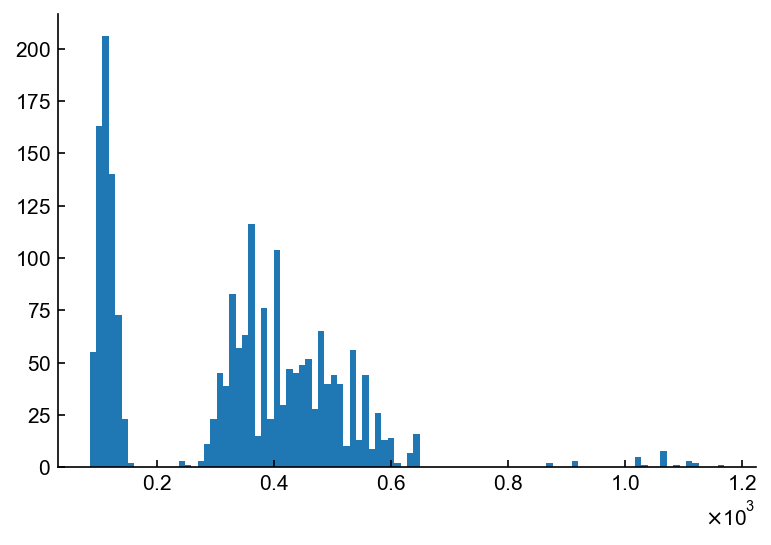

In [77]:
plt.hist(B,bins=100)
pass

In [71]:
C = [73.21377108925617, 111.16890812471236, 86.92701351586278, 55.919488131399724, 52.45422691393827, 63.426039538549595, 63.40664071922673, 75.48867829159457, 42.69749801110265, 106.56842669928972, 112.71436660461391, 81.89240395009163, 90.53584479969898, 141.9740810064959, 29.503469542480584, 66.89540916720459, 45.73505161571556, 45.62200340512468, 94.70161952162472, 83.00082059720577, 62.86587037349269, 49.47418491259361, 69.04128713444543, 70.68080097382723, 73.27404968287, 45.435013760756014, 28.37019413366845, 77.8492426432766, 102.03969014475273, 55.12364244251657, 141.3334792954551, 45.131527749847464, 98.12115557344151, 38.98186528013544, 62.04888816543511, 90.9376599190289, 48.061737485342164, 114.68723299209933, 153.08998675533638, 83.91226677866112, 70.46916808548222, 93.4034162962828, 89.09536783699969, 79.77386617233557, 66.21973640520373, 58.534585062934504, 43.63499249806583, 56.276058895259176, 49.79508108930058, 83.17998476614933, 59.34502352061756, 80.42136431521213, 77.3011759401298, 67.90610746824169, 65.47275786576368, 46.56904061337649, 93.47977424186912, 66.17731093629965, 73.14031511335794, 114.73802920945616, 114.76617655199865, 86.03452633018631, 59.21642997077835, 115.46093425451505, 50.52451342529238, 85.14297209496266, 29.269632736375986, 61.298115901730206, 57.98122895941421, 43.84449881077826, 63.80633539746914, 134.0266093559502, 89.10933215980089, 81.69650169581425, 70.93127000020444, 62.65523981204462, 77.96046557317814, 83.92177688324247, 61.454668639203874, 61.2039092037931, 104.27532707842632, 88.22732403043173, 57.10218325098708, 29.229059928927768, 78.03543779218336, 57.23368133959384, 78.18008256365661, 118.48578071939546, 37.568750651732195, 100.14408077723431, 44.059321390641244, 104.5837634602037, 113.19758641809102, 59.996763493609116, 67.94741511546323, 141.8689894101193, 81.00174042763922, 45.05896594158225, 77.03305282041123, 77.80189772714942, 67.68875962800062, 100.80470926675373, 31.589764608644543, 73.74532630213648, 72.30662317255981, 155.68685938422186, 70.89019049689531, 153.98716824534011, 57.79610975264742, 72.34212054379184, 75.1160291665023, 101.46042752050609, 167.06862508319486, 74.75245006335393, 68.61323213142704, 40.41438107357751, 63.43566466130505, 39.57135743894351, 54.46744464267259, 122.04573706560349, 68.43591209393986, 49.43964706609995, 70.36052437096288, 85.68111234812989, 166.51799806286323, 116.80407854574099, 37.00566800376628, 109.11146699834323, 142.81701700681722, 44.193071826892485, 98.47482035708686, 49.509012147736186, 70.46957238261895, 48.34785507946748, 40.91207720955828, 87.67131755115629, 81.89014191135384, 62.000513460248634, 94.28226400573725, 78.1902798272813, 42.76007309050307, 53.074011355997236, 74.86100805837256, 63.61099077891948, 97.32967886072616, 60.52770246693136, 84.35964599296318, 115.86318667886631, 54.82850598075399, 73.25616525006333, 53.08940687463629, 99.27778631467176, 27.698682761617853, 78.63930559194173, 66.16139401836645, 62.88294989000803, 79.56285083894755, 57.2292374086997, 109.65842279019952, 57.21891240323547, 61.46703264561299, 70.8481670893501, 60.32932273312809, 43.89552638423099, 60.01158848641662, 42.20432993017686, 58.26100884072354, 67.19163999588012, 55.39484900471137, 56.91040112953607, 77.94805183416409, 142.14024107537003, 52.80041275769437, 46.720202233899826, 182.56236961786138, 194.1004238619359, 59.377439780786396, 61.52496128821346, 89.04124157256881, 60.22372722396163, 104.89824180984144, 24.459264420059878, 94.98325786841244, 152.73044784120842, 83.19486246334377, 35.18680234370748, 69.98062947189082, 85.94694831154659, 130.02693545408317, 35.5941931413604, 109.42218609465375, 123.0997938414532, 52.136022447355636, 71.91800833293081, 62.42657459046759, 149.46794008661828, 83.08219876702536, 93.03466184813085, 84.16974005994015, 110.50026645517868, 105.22632121517076, 67.94489516915496, 50.566604446347085, 47.80653501941384, 100.38651042221171, 84.30425092619988, 46.81740623016958, 29.291751738150325, 72.10639711092719, 50.19121628928521, 48.3012017054342, 114.34892087735315, 82.54361380291016, 66.65450089525734, 136.94714766643233, 24.75712132591707, 83.5623620544424, 92.47300068432556, 132.50542352896252, 97.51809023543537, 118.05673478409516, 114.65081503046325, 156.1488180913252, 154.13388681426574, 55.74529646451776, 35.19759986775202, 51.76095931002416, 189.04888412239177, 94.43286300101907, 92.37776196408214, 100.95270627759523, 115.9039476528226, 46.85165889106815, 82.43741503004416, 65.65131445258602, 182.4664831730408, 77.83991782561579, 51.62644608423313, 82.0517080755162, 77.95999512287486, 149.300911931686, 80.75518626049605, 72.21936584513324, 81.3369279836647, 111.13732969887946, 108.76917401447507, 107.98598282048529, 57.142988366325504, 113.90223525600473, 106.58585289661902, 65.99660777394814, 72.80352166662134, 72.54064674081475, 106.97010978054189, 85.16309088458526, 79.08651287304626, 97.10118942147223, 124.86577206994839, 71.94309015407657, 42.231178124143014, 54.705693464342275, 57.0991215999354, 102.3948852992201, 119.42267708115857, 74.98824105033256, 59.87688556340574, 60.34237180613094, 82.87645329854737, 76.55574113516536, 39.426907018721614, 48.84353285364772, 70.97065058294166, 59.32885989302802, 58.385781585778616, 100.6772645552805, 62.04548209134026, 97.05890185826163, 69.71166499061054, 71.52603062688529, 41.902881508181956, 73.71209920319, 41.023463680875174, 47.01251500261961, 129.45629920535262, 138.4483914356644, 77.81163429870978, 33.94070631038584, 93.18656434667149, 71.76660654130445, 67.51044296121505, 71.66210347118515, 68.58259430061783, 73.98818555272031, 70.98492133973004, 81.10536380552219, 89.97653747591221, 22.6371535361765, 46.9566426411727, 35.56474861997804, 105.04223921907607, 105.63712115158175, 63.90155967240879, 91.14056301085942, 64.07605681268939, 129.42451120284628, 84.65444919804818, 55.4595164337294, 90.78394713078264, 161.51464380175835, 166.77152717714455, 33.855951168071364, 71.77120919371633, 39.11344147473848, 101.6590628490458, 24.820055103793226, 28.7790880126055, 75.72976129485524, 35.79722275984086, 165.00921540749604, 108.81467175690308, 64.7942445678652, 83.9060667654824, 57.88283456808197, 41.47140568582991, 73.28652536491343, 95.7781245959627, 64.00082221144778, 108.06929901302384, 69.52805219665402, 75.63432796239844, 29.39721036905782, 69.80295879977312, 38.217952738865904, 69.41405116168569, 64.28132391619634, 78.66740763269492, 49.155118652249925, 48.640796346768745, 67.54705931972109, 128.80783980911448, 31.993500001980802, 53.726180951045585, 43.65982269182224, 100.51954485476838, 39.51913011112698, 134.91472584785583, 124.666938639905, 63.37770036832956, 78.01382544361701, 93.11575415339017, 112.58498993050821, 94.48704755077767, 77.24364553824469, 82.9595732479353, 66.7067233906495, 46.46322489690862, 158.84196600301564, 133.9150136661701, 92.5011242379277, 93.64918811124696, 91.08882704180773, 89.44621386620216, 44.826415643123774, 61.78238294426665, 83.33394331243198, 52.90426542353959, 89.99232462551802, 62.494305416462545, 134.98595200482748, 118.19981383587101, 40.56499275809978, 129.0497912355434, 32.40086914462649, 64.24950751317405, 67.44686693501146, 45.216303868962115, 81.67842063689078, 50.63425642496757, 78.11533217555856, 77.48748949170202, 71.95950105611851, 89.00465176110603, 74.09454216087775, 83.88846220223935, 111.67966240399254, 71.01912254960645, 126.64695970291166, 97.15012779856018, 91.47901141318366, 37.97764933629839, 114.07429723500483, 32.255281641283105, 149.3026249645244, 155.91189050703196, 70.14474620842594, 169.4437731188868, 62.98275938342755, 28.604013107368086, 65.91830759751917, 90.86691451229511, 162.2593619833216, 99.2898653498213, 101.67398471365009, 95.04951993106873, 72.06507023306251, 69.97197888318958, 88.9937478039001, 96.22123132029976, 52.83190240578446, 32.337772656182416, 73.31310838380324, 54.17086476305154, 88.81440875886729, 51.36454038724123, 83.8640925978038, 73.98235453612861, 108.0248656657308, 80.62651467672933, 64.4473749569334, 35.26841239221756, 200.45672273747695, 72.64822513143382, 102.63114526233755, 57.531207557299425, 120.84335385262817, 57.416439811986066, 76.85680359465343, 27.858290180133213, 79.46326792273888, 49.76668871900111, 59.316142650606885, 51.26654207353161, 46.19849315056224, 90.2630989948218, 71.77485208865163, 114.74235234603745, 61.09077813533547, 107.73425515592284, 83.78442848555426, 124.283147355303, 55.468817750698236, 68.69614481220783, 80.42775737967098, 95.86508828610488, 66.71135949281363, 135.71140982749122, 84.69894848349983, 73.5610017588624, 88.93609241193467, 86.4888899723192, 30.513578879987023, 44.7956779922117, 97.78218156186563, 44.92288001623862, 43.02300987295433, 77.3867416776554, 79.53545437588234, 47.291187840766256, 100.31797734278928, 79.92558665931577, 76.74163507276458, 70.96392944551569, 115.50654019163447, 123.17657204050889, 124.73736644416623, 62.36040293235716, 69.56432285891096, 62.08864873773491, 131.42652571346792, 155.01581841830034, 33.14015573022197, 100.25883581968387, 97.6038677407919, 56.91516947330943, 88.23151015342346, 74.84707378222163, 65.82572499841322, 168.50099378731196, 64.27871315938478, 72.32989416005454, 101.0251165920903, 101.04487650570391, 102.5945027286336, 75.55178830797425, 130.63337273986298, 69.06345726282382, 102.92481605105196, 59.01875524902207, 52.370959042788485, 43.74207687749273, 60.53510810528309, 68.3224455688002, 128.05152099843602, 144.9122407738592, 99.80725102835346, 63.91969608436606, 87.25131603920192, 58.64840023236508, 196.64386244649864, 92.06781427210744, 55.089248394428424, 35.252449157823776, 142.131337744744, 69.58701210518892, 65.82627457259338, 102.70680364797106, 99.10685078010412, 19.881304900481148, 77.49258558686995, 105.49348692569566, 82.45767484234334, 49.05760920102761, 169.40042243850596, 94.5040845380805, 73.47073833107345, 65.76983080729552, 130.02509284054045, 46.23224543029352, 48.75549225239433, 59.96619654790993, 52.84136613458172, 131.20980519108906, 47.608936879393994, 74.8543253429969, 52.64554360467106, 82.0924681467428, 119.19898483979169, 91.17694438698605, 45.43670852693713, 95.21367200104795, 39.89772463349535, 74.21463359337052, 69.87359947570596, 97.92983809427074, 67.3393627212273, 82.30453370099728, 68.7416601534388, 77.80504112987494, 77.13725273458057, 72.67131994178169, 101.46925949365611, 92.86604993236958, 23.222383098477493, 32.268117259321606, 57.59648104138363, 174.76924083519714, 98.49233247110053, 33.42991257170522, 112.86009008099968, 65.87786916482618, 56.32479649240798, 80.13686122555926, 144.7520595103694, 75.61706682052977, 71.57100214529385, 59.26054511682017, 109.05706367426335, 86.8941559377529, 73.60905268495665, 154.42723865672568, 37.21763329599149, 107.02494308333317, 70.0341213207943, 107.4757582869541, 121.71730251385286, 51.29365809547202, 53.331227897599184, 66.3333211147088, 77.77117244075373, 109.50084602526454, 65.08994634373772, 22.45099858146673, 92.81912414803786, 88.00589872464805, 50.7640601225903, 56.990286293767824, 64.03681321120199, 91.80865689306916, 58.38589025602744, 92.82731271178235, 57.78703459617588, 127.06059397073275, 187.5209588935724, 77.06265374033012, 100.85084625007934, 59.22075339353846, 92.27887472517219, 33.93466481021327, 100.73058053890412, 37.15608454683234, 102.35570104596869, 196.9114513483497, 80.31697412785147, 70.10139686753158, 176.88055763967014, 25.352710305814522, 51.6101676223983, 36.11848916165225, 64.84731020321657, 78.54819813881029, 53.07637695633616, 96.92148496449627, 46.4653344624497, 87.60203135444414, 81.35986331942644, 73.62887175590008, 48.034940148322946, 45.36249202458444, 42.378386672104966, 148.49279006387295, 75.25004343886978, 122.5198700969098, 70.68598309068203, 145.3813661877373, 77.46268259257128, 54.35742187665731, 62.158000554319045, 138.16745224159834, 81.64154993941246, 38.34936677547143, 68.08536990667709, 47.20622842085814, 111.75263920836316, 66.30474016347857, 72.39606506518017, 121.27647221915343, 46.558771043785065, 103.16531162020165, 158.54117762946328, 61.4126824597147, 93.9965680952152, 90.82453175474946, 84.81481660819986, 94.25772106962553, 42.02198862437321, 84.38816151307601, 29.4319175138706, 72.68540516486554, 59.56741570629798, 71.82802423301638, 170.59518902982734, 76.94505884976267, 54.813185144945415, 65.31633700428138, 72.94632119554055, 75.07433230368862, 72.92856097510311, 98.22214139837041, 56.40087312025719, 115.76658379310445, 81.98714594277124, 78.02780426232687, 71.61740382022917, 83.50990644546015, 65.13955875820048, 71.54349693836244, 39.02939676882265, 49.51421791351761, 104.75306529469819, 38.10961656597575, 117.24195823287033, 88.46996869178108, 76.86553084869158, 179.18451537098147, 97.25308911663792, 188.51675438895546, 93.99299739405132, 67.09604936174271, 72.03538790965172, 67.00414772312698, 43.24922604703797, 55.9654687245517, 84.36309984530436, 123.84264537788286, 82.37508866800202, 83.16120653933237, 162.1843718161033, 153.8826597955831, 86.11786913075099, 128.6152846351284, 64.91092289047326, 148.8191073701725, 39.84442500890296, 146.93159899106038, 66.04321029389287, 92.0816294045753, 84.20778639237535, 40.575727262869705, 86.18208689334116, 30.433643257994053, 83.17814607723075, 50.30387416004563, 81.62868964702963, 151.98440075455628, 117.19230762364441, 39.483591024691194, 50.41711649073549, 118.22825067876643, 53.23614671725741, 96.35647575709137, 31.975215078823673, 75.4599429658347, 73.68783167846549, 63.14689459668095, 97.09792151553742, 95.46977607915417, 31.54877210288899, 46.884147958797215, 70.10795465886268, 59.20514007748342, 124.66228241363177, 131.2851160747114, 52.07326242025887, 113.40577297915415, 49.94546784915068, 69.47105139417559, 63.07119915152315, 33.84606469574295, 121.917406904801, 85.94291174096449, 88.68097546237426, 93.73708870595406, 102.91648625350996, 116.8954869825896, 49.59764358130555, 61.6379238289944, 85.09106989494606, 127.84749380997287, 103.60587171807904, 57.95738295108081, 92.13226335953435, 71.98681928674637, 94.87417874896063, 74.92521950552857, 47.16541732737608, 157.9985199708922, 80.18318595673472, 76.3092545778956, 51.32999592413976, 83.62689614809318, 70.97653512445014, 204.07813625008086, 67.5892996197811, 31.24595359740319, 37.37092626740836, 66.01321653163946, 60.383294664115624, 64.95457933529092, 21.325034290654212, 69.66728536991536, 47.567006817358056, 77.34073713826224, 94.49743031285203, 89.28455413440734, 98.4521260000384, 69.23747365271353, 70.06413917039761, 27.911345206215614, 113.92309447284985, 84.11948967024564, 65.21494838529925, 83.05992199894214, 82.8770928623201, 70.17309701486906, 100.03858421618375, 116.97491447019159, 47.49189783454193, 85.14921909686211, 150.1358205021587, 50.79591982624798, 67.80675823177893, 93.86516952135257, 58.454514593501735, 84.90196981288344, 51.31369449866897, 148.90869068580025, 102.26353569025241, 75.9253571515769, 45.33945584999846, 106.38689018237338, 26.703269043570085, 99.04828354817703, 138.25549059141852, 50.60291315018321, 87.599754703381, 55.312507597594546, 58.944754562498105, 32.65702856484038, 62.66526129986317, 57.46030548831674, 43.6538753339688, 120.66159072990204, 53.26174486467434, 56.505756705345064, 106.66512762134893, 68.61996008344074, 40.76288940943075, 67.85448235842077, 48.93467485800565, 75.7219813908246, 42.9298168474656, 139.38100411136296, 54.97069253271537, 95.09285777113345, 51.589835290145196, 26.00121517230856, 58.20923471684406, 66.11317980346483, 123.7137486301394, 96.50936367916066, 131.53479223883855, 101.79663320096881, 66.05194813496331, 123.06541246133983, 97.77079939587281, 67.00629695493804, 68.15549414251802, 64.08149029426242, 50.824307154565915, 82.27239506364184, 86.67748029884994, 119.16880573362309, 41.474762602835625, 88.90731048169032, 90.25413692630516, 83.78733127770381, 62.528663945430544, 59.41674767707175, 114.77298116201952, 18.75270037367001, 83.35484817938979, 57.15436058871489, 63.61526027046344, 167.48722673662581, 94.3088057526364, 50.81624082585179, 51.319402235553284, 55.658644372716466, 63.01283767897632, 34.66229150693313, 94.95874489480701, 139.086955346643, 75.85400740913683, 68.8955288267508, 78.85775179655596, 35.994029296495235, 40.99857043056005, 49.38643609043555, 61.94123105344712, 86.21959401921653, 35.10939685471697, 116.00069849309894, 66.15330828505189, 42.34285200060415, 85.00411209211784, 50.00003567726197, 69.51901293694064, 99.26717827120973, 112.08179113213582, 47.49806024250548, 43.095676328847624, 64.51071799006179, 68.25884984965657, 63.91340241640146, 81.37405858819164, 44.85271788957644, 72.23369102603705, 64.94060109598703, 71.61114652753464, 70.38503488675244, 64.66496658116395, 43.43631866187198, 94.67949538997416, 37.75742118536439, 114.49697099568412, 79.59693288722129, 87.7600192466596, 69.3611064208406, 101.0479900923196, 53.27087762504604, 58.966263135804454, 76.18972104610457, 118.34063001288165, 116.3536635989223, 96.64403269774014, 98.84321523616332, 124.14276231634923, 174.049474316855, 172.10055076404447, 87.38298807965377, 96.24544374014066, 83.17485720863078, 50.73957435904437, 49.00712250789057, 90.5888231971229, 46.07984370590039, 38.985404509864296, 69.73709741881963, 87.89640906530246, 67.03577245955888, 68.87121609832225, 42.43370543932904, 63.65397020835964, 57.129576875390434, 54.451582520789096, 90.29105127675803, 71.29340211957019, 89.64619781991664, 118.65512975629987, 73.66587698773108, 70.1383627577053, 111.36521791321266, 121.35116819554054, 28.46396166960934, 123.4107039739117, 49.641608986002204, 74.10098656328462, 54.293120571352276, 83.1272144692209, 86.6194156165686, 124.15210904469522, 80.83587613375953, 87.44700738338766, 92.30573896284073, 86.18695474306753, 58.96953887522939, 63.84232891910875, 65.28536549410256, 44.456697426820085, 70.2555784781407, 74.85249555037677, 63.03989482423462, 55.43127352904649, 60.183287596063316, 73.1334286256633, 86.97394113005653, 81.03747814440301, 49.3814233687417, 76.7549557916106, 87.09760175071763, 98.31186240015737, 55.778429657083365, 69.08276994751861, 54.76158515301433, 70.47374361099169, 35.021653434816564, 79.24884540454889, 87.30907201999126, 93.86412061341993, 161.55711484311612, 28.684060823320717, 121.94370696680173, 64.45778516206963, 37.410041103004055, 60.586257424924575, 47.79289220949352, 40.28170989319052, 73.73086514374067, 73.87901056345751, 144.93043225618393, 67.80948883796128, 96.94952775436468, 56.51681657506835, 47.06279716412118, 62.81999873126584, 91.58342048558139, 43.71816868055536, 59.5358073170064, 143.89021184883987, 156.655046415564, 64.24609280552973, 72.67210294920629, 47.70126628924218, 65.87701952248277, 36.7183565121031, 63.76301150551976, 79.70580360364505, 56.568676631664225, 56.96031609823203, 100.64858162987602, 69.0068423248571, 64.38547820588889, 36.46235749562665, 50.78630303983026, 155.22820922833378, 37.33649468007411, 51.97642661738374, 121.87591094373924, 59.972202754516495, 64.57393316170004, 120.02104354476629, 112.6725017576634, 146.1465614135301, 85.44300758777149, 58.43970680664257, 51.51623472977365, 34.65194036981342, 55.266560851239454, 52.00592651120575, 87.54128391468431, 84.10594017810917, 47.7091307393979, 63.989878343096606, 64.53995129671213, 48.9626954805259, 82.80853135662979, 92.05342351251905, 45.08428209145088, 57.529448174522535, 98.88937951033154, 48.53606880457539, 121.46088379326311, 55.07055820749787, 57.740303427590014, 41.396158630552236, 70.80753593012408, 39.35087358443479, 79.94001110357617, 86.78575580605765, 69.29231926476858, 17.997253107374814, 47.03248654060014, 136.83969003571352, 105.56966134159457, 121.48225607208148, 98.1866645011909, 31.186686876310578, 62.157141791131494, 52.78262592640965, 59.806144371243974, 35.62787914460187, 81.59742730064208, 88.87658892972952, 36.286669214675044, 55.98807698588085, 65.9945386129712, 111.71253935870415, 34.895175382720296, 64.15204617806414, 103.1133306846729, 38.15666863746835, 71.86546053912362, 140.87053836729652, 37.75873534022058, 69.58297561542817, 95.28741234812897, 66.84463987076964, 38.50015834577076, 44.262103817836554, 69.34139290121676, 71.52481662618625, 65.66995161967081, 62.95660868468779, 99.30664130401873, 128.2213744396996, 74.71671647766935, 59.00658771003313, 98.0933499138445, 102.64944945972502, 48.940555374970806, 191.07244468973198, 94.44393407359918, 79.04138880225068, 98.96501168051601, 43.315983882964886, 117.18108105160987, 44.67610023989555, 161.0021886086391, 75.14094813182335, 85.18502724457049, 57.185485413156805, 79.83623437037305, 58.63284447547332, 71.15960127523745, 79.49193985068403, 93.85787699036959, 155.73721072101887, 26.284271844833654, 82.66254869736159, 62.062370289340244, 88.23190101033451, 48.03424486710384, 38.8388549296955, 83.18157881669859, 106.78549948097168, 86.40221353187248, 58.77838225697146, 124.82513027881984, 35.914738439102244, 81.94019076767513, 38.296031649394145, 42.20928599298821, 142.37843833904236, 47.45178651223385, 57.2673939362437, 93.77873460289403, 87.51413410530463, 70.9006896001849, 69.21565307809078, 66.43701845733038, 46.39658465737359, 122.79620880451388, 41.38386080354929, 71.29608110992271, 53.26946131411678, 68.57987662133247, 129.17001926166643, 120.01365513319938, 57.61448078846453, 88.81061825140108, 101.47709617786242, 102.66983925205302, 113.06876287868945, 91.59868138463193, 41.62660064330318, 42.11516916800283, 76.06413986584113, 37.515174833819515, 89.97355808731427, 92.01804539305914, 39.446149486426826, 51.2497233199781, 114.23475705760463, 105.7475393619361, 85.03768246019578, 110.83542414928203, 42.90555134445311, 28.02572060634346, 36.3507293951872, 72.08910326837076, 84.87929391468997, 97.10753528665845, 40.03378417875707, 45.96391860047691, 42.914858642095496, 87.08942264756772, 47.33788567909623, 87.46942026563235, 82.98897057841587, 92.11453508313046, 64.89859840770262, 92.78878230861902, 64.67734330409367, 39.953773572309444, 41.62258351407066, 141.332107345455, 63.572108481258205, 74.88801943100296, 28.219144854850793, 98.1481186389243, 75.99768153054053, 26.926195599971784, 48.52956601815242, 71.62192939530324, 69.06065010565794, 87.64281445733089, 63.13463548282639, 78.15043360673188, 69.62909836019927, 106.92869762308142, 51.889593547840136, 79.8174994358359, 60.73133836649485, 63.29485160244062, 113.18429197766054, 116.89845713937392, 195.80271166620423, 87.13070907418728, 85.74934078673559, 157.0749388309218, 117.47201952445302, 72.89097552821165, 133.52888675032372, 131.33189068480317, 76.54659996785672, 44.41068192415516, 58.99235484691139, 43.347686656766456, 58.97179895434052, 18.10690429969665, 71.89884141850874, 77.8399178256158, 152.13204269086214, 46.983934496852335, 200.6501867649193, 116.33917609901563, 96.0749631006386, 58.39031644287196, 38.27293488795855, 115.5715564714603, 84.78072092974024, 51.62330114264064, 78.6955369914759, 46.28693733290946, 90.84727926315594, 78.75962239712979, 58.6011382320977, 61.5054575557548, 64.11694018795501, 40.505410203243514, 60.26492290391601, 155.6420949910164, 35.1821458797577, 101.66305716345256, 102.16969762994512, 72.65681627668168, 49.48016712160479, 108.80000180934152, 69.565021629134, 68.56924837321162, 113.24619699224142, 73.78124868210298, 180.87054725246765, 28.965883638478694, 76.64185826817348, 31.244159406825283, 53.06042058728334, 62.59300340786638, 42.38592501151784, 93.26972742660655, 153.0441993692295, 69.61400533049374, 31.32325284591187, 77.87788296239628, 52.33222236446778, 57.518366139496464, 114.08256564045644, 59.59959787856308, 94.52536724680397, 87.67043163369024, 48.10638230866037, 94.71280241296105, 100.2917831822301, 76.32436393187052, 84.87966911379668, 118.02143332701, 76.42665063034177, 141.33882228498123, 113.41017737602868, 77.99141558075645, 73.31791909347436, 32.32962172383785, 74.29801623165683, 110.08847205347966, 63.084942851993326, 66.64391696833506, 99.33791774268722, 122.47858072596289, 44.15964353823558, 63.90039625720416, 54.17771396680137, 57.44053379737301, 75.84565961875961, 97.56150131960615, 55.98486212514079, 44.45293466945967, 79.7541366032244, 75.34427428652141, 130.54132268444553, 102.37728373099306, 43.93728584960351, 80.44796305781558, 74.03261965605668, 76.5175428617071, 83.69508117495197, 109.60331068637707, 111.21206917785047, 37.97322845746652, 60.89999029022773, 112.02915628901565, 89.96859031604185, 56.71805164938477, 85.38466192070595, 18.297713504554427, 70.92437164058518, 81.27788376777545, 75.2424154488829, 59.278419995238075, 59.84174243279364, 64.2162842152263, 52.912817571302085, 115.04371689112813, 84.7135554429341, 195.09707580254775, 44.347751233530595, 136.5130768933832, 140.17363108939566, 49.52740277497087, 84.81732915444954, 66.40550893286887, 58.13297457023788, 41.23583050822587, 37.60559720651502, 83.19254662765078, 84.87123617770347, 44.69456937026733, 96.68996724397591, 100.61727348743685, 56.304724024090156, 104.48375084744512, 50.38476238649915, 98.99533000396535, 45.554218865802476, 77.51699002598028, 73.66178461249984, 75.8302171639914, 71.96659158818971, 37.26546037424676, 98.98613859432834, 110.04673844667622, 62.93893882449574, 54.02558622569209, 107.70073539673666, 25.36139537866885, 76.46549565778713, 47.50381613194438, 88.05522784291276, 178.07692560186115, 117.25078082790287, 55.21984516999932, 100.79154685780925, 58.76283539586884, 101.07902885524963, 62.71203910556422, 126.23261033260425, 66.02979220516667, 102.13816271490683, 74.55438680783783, 120.80196887131946, 76.63301701860651, 86.07154199919621, 66.07516092496436, 115.38854857503118, 66.82869438896586, 63.06385026770976, 68.79171725587291, 61.69343849207994, 44.801302145530066, 31.417170491907612, 80.03530699719153, 159.94000774027785, 69.7340314297675, 27.27271306910918, 93.85630543233128, 41.03344366503519, 73.48688122173346, 68.470085857508, 61.964012488644784, 66.64338499829475, 87.95313991904321, 105.4105085529981, 71.28645557167965, 106.55891871402423, 89.17728229476849, 32.53141479985193, 68.4254535965351, 81.53089854893385, 48.31101042592024, 82.70862288131228, 67.26203398284306, 140.1858953456821, 53.734816663934176, 52.92241662806489, 74.15752307347611, 80.12679371759118, 64.11773689310759, 47.07526355874156, 76.94807756505314, 68.47767819157714, 101.04940296741808, 82.7184287526888, 76.02587024652223, 60.68625617137471, 101.25361152415613, 87.64386209824455, 109.91142610747562, 118.53636751365408, 100.47281642575055, 86.41963234331527, 37.80940071745615, 78.38956325254527, 177.46198360324126, 72.96934373374089, 72.23374406521417, 107.63638105753058, 98.85950971605213, 21.02168767122475, 100.25191839372033, 28.61985800090823, 96.43263596670651, 84.41158401556665, 85.79155603006667, 158.55212964299997, 85.27823987178915, 42.899259150873156, 62.770190261622176, 103.05554797872244, 53.89292749366363, 77.06451663615726, 71.85145742981823, 187.5039927856277, 78.24927855684574, 81.69384469086805, 80.90029538596343, 41.06234076657583, 64.53463002954956, 51.492370687797056, 64.45167091553554, 45.12936284368542, 79.15164188376203, 61.695409714424585, 56.92179917770996, 193.87012499860847, 89.36432240416936, 70.77977861495954, 107.9424108696119, 90.2707175834719, 82.386577445482, 162.12571343415405, 122.05671866857791, 90.88291876415828, 50.09215062535702, 77.55493794232271, 86.70501995766277, 77.92510768793612, 82.57034660926229, 48.44991512332145, 47.09177683280672, 103.93157615249939, 158.68887910374474, 71.42481082083808, 40.1271820853027, 83.46259937678062, 113.40378032579726, 78.81095152131934, 72.46498608066095, 113.78249750311969, 101.49965248782931, 73.3967309119576, 92.76591879755989, 53.94184240489808, 83.71342198801392, 117.0530697211246, 56.389212650667886, 57.053713807797344, 84.07533028198871, 60.36512716359456, 120.06234745001622, 92.36802823648407, 80.10106556629299, 51.78486174992203, 130.1034936628158, 55.22033513729723, 83.98970167501878, 86.13511500358811, 182.14303569455345, 86.81660093001848, 102.80163690011887, 31.312056323193744, 39.47887615016286, 90.91031966135681, 84.07480996705596, 43.73904232701756, 117.17449489043868, 82.49685203477227, 52.02056355754921, 51.41250264930737, 63.49613547800979, 52.600567747195505, 29.005066041681737, 107.44564410763613, 64.29069342411974, 65.26354896748467, 98.08839362784846, 100.7387594891568, 82.04136349322819, 101.44640399320114, 87.6356630436334, 121.3049641661951, 45.374660122911656, 73.33855179188818, 42.820683694356404, 56.641253941245814, 50.84789139827577, 73.15563040632365, 75.56014514404416, 47.94473633499666, 88.66757237983987, 82.82044370602206, 61.51618106385236, 63.33967718933118, 72.85334858891324, 70.20983357207538, 60.287324551936706, 100.1249205400997, 39.81673882218302, 81.91163092398614, 57.777105300584374, 34.039945831268, 152.39194087658404, 188.10841343894413, 73.75428578455356, 41.420802099678674, 79.98094639037618, 78.92937628453834, 60.13967424013777, 46.01053676234007, 117.28356138358085, 107.90501109549635, 89.18207553535734, 95.12573492684692, 46.36937909338376, 118.62302078579692, 113.66319070010081, 90.2829504569026, 99.7963671196812, 66.76844881575036, 24.60577351518558, 55.20859778632616, 78.76941926989126, 171.88691064443674, 65.1973632469909, 121.6673165838353, 80.11419339742443, 115.50787429146489, 70.23332119738052, 52.976488270557724, 80.78076249006719, 47.278869153527076, 77.70458805199674, 119.63037377573154, 129.37953297683734, 110.87302679248769, 87.56864605370124, 56.78446624655853, 65.83176494490844, 32.91105654076625, 75.97119450153458, 40.69661857314099, 166.23854904378402, 90.15751111321174, 46.31496144623506, 105.82617874480225, 69.70820342363585, 68.19032494953895, 102.97711762188153, 102.44937248969936, 83.47689103336761, 49.51037305571522, 42.24148485005576, 77.84714211067013, 97.49573495722608, 76.00049633567299, 47.00057762124038, 61.46194022713056, 99.62921391752525, 71.39636705451136, 80.00892857258012, 49.421394324684094, 84.75778920533273, 113.36682301179151, 95.61473542467243, 66.94681902322301, 42.296126916204734, 66.13233595708029, 84.56558410564247, 45.556276416095734, 129.87628578139814, 82.21955341178003, 48.01230708908479, 70.46627827856652, 75.4852356025887, 78.79074627954, 78.4449198967597, 93.2618076752825, 53.34600935782061, 136.95027326934652, 68.71066285371934, 61.61298473249835, 43.62086018339535, 73.20433837051749, 56.48406107569515, 163.95837353873176, 47.33844976940394, 77.06378303116169, 46.70157023306557, 45.63436634600744, 83.83560252525454, 103.91619544211052, 87.57333864821483, 56.094993559324664, 96.70357627992009, 83.7046371528133, 121.8009327677805, 81.73289269881973, 66.13218934106101, 83.35204750318636, 110.67440896440738, 108.22178701489675, 65.27986811317578, 70.56756949850393, 65.10266585691055, 52.8362648438657, 42.348243925914836, 79.0847308540506, 146.2071161476118, 45.382530099652875, 60.58743673685973, 107.49210861771192, 99.6224607772508, 93.54555225371497, 80.919691243747, 76.50977319887483, 113.15073036192364, 54.89839231782098, 46.42487098065643, 57.747881713473106, 112.39540824894337, 39.32627098919863, 78.84787332678184, 58.57234569593715, 98.33115616692179, 18.46210944794634, 67.50375725959641, 54.55569840009206, 173.83506006263735, 88.65877154824983, 69.30747902311106, 102.94410896749048, 109.28600339506245, 100.11277878620083, 62.327828991795485, 69.53685863546897, 144.25575443091628, 34.47789089454336, 45.470448077587214, 96.97298763115364, 55.377594547208815, 87.33993750986188, 36.4679267680534, 133.95894158617975, 49.057225429202376, 107.70283576747156, 84.75407608103986, 104.99774666955891, 71.84605350900058, 171.92903759652282, 113.0054572834026, 74.82850348817084, 64.92494057521789, 75.0297890427569, 168.42122998550064, 68.94752342261933, 41.291498468647866, 110.00269774062369, 49.9558543971091, 139.81564105767418, 74.6410119371347, 68.9387433352047, 90.31654565025126, 95.23430153228362, 105.3683228496966, 39.890921201528776, 186.22831206509133, 83.5933696541404, 45.13438752653724, 74.62813809232402, 67.89249221342712, 76.17615624188053, 59.04451089404595, 86.82488642908817, 74.28816296098341, 142.25049057521449, 84.08418910222096, 111.81576950284, 71.91999495805024, 94.97355754991722, 117.92993537754982, 45.907549837428455, 57.67566297735726, 41.335519271268794, 116.23915180908158, 44.564076683237175, 115.05953214984565, 43.57169177164485, 117.80860005434633, 79.2667158190104, 67.95432848234334, 145.58562763381192, 101.70024447860422, 47.57116416840871, 91.25250298303571, 65.07755222701722, 78.76073391052525, 67.05754636622376, 99.55375313158359, 74.22770706654907, 46.82626827342762, 43.05877636072872, 26.444269876275833, 48.61638704532234, 104.93956464807937, 42.09177460607587, 158.93375069443013, 165.090923632452, 78.36318864669624, 105.3405965805197, 52.146823268208834, 36.04846457391654, 48.98946051111831, 88.47544565768723, 67.89327188062762, 89.42448930341263, 105.17378208451291, 66.28306090736862, 63.19883968654804, 36.22037937554356, 98.92035753105537, 92.87361914769494, 125.63622666291994, 134.78707822506541, 92.58827513144989, 138.5816248669522, 48.42464568467543, 112.39270641869962, 77.48586508968042, 93.54546403575957, 58.21063869231554, 98.6297843051945, 71.81906133900969, 94.52103810069931, 88.5410534174337, 100.29915575724083, 95.21006980877618, 74.64309785150229, 45.726538158706795, 144.9199939033613, 85.51888481959345, 76.27842818874024, 172.61925349093394, 56.95215728396302, 98.7416463815618, 164.94168718061516, 54.3924151004775, 88.75803934096595, 75.60792599850532, 57.80992393078544, 68.65082500021697, 62.61130801482095, 47.24327836427131, 91.46342522000856, 60.183066321326514, 65.53374526919919, 62.51308379484046, 63.70602456700395, 78.31341960240334, 56.45924489958626, 52.95832819490075, 34.68766915927722, 59.33373298467961, 55.751167108950625, 60.22484951245787, 153.99854034809385, 85.8020228975338, 105.80667338333726, 61.03006446690932, 55.42162483239686, 83.54376488987641, 164.68632073605445, 61.45753039757973, 60.93020186036721, 57.09463308391006, 84.30700576138882, 149.85516507764888, 70.62514942217197, 74.52489147584147, 62.95780377320258, 46.867353404722365, 61.3908295067564, 132.1991209181478, 64.22639824643007, 100.58916836929924, 90.62782549557612, 76.93381165426932, 92.23790737288145, 98.14718962823761, 92.12332086004682, 130.363320113155, 71.16019282235776, 43.43245503853381, 58.47874850189709, 45.29593840714969, 27.24980301129864, 19.941064516276118, 53.359478239584256, 47.674257077820506, 74.49424268201841, 58.45309330594716, 105.07403461841812, 44.356320238812195, 60.68006906425748, 36.85572707173518, 82.57826741308199, 113.46417845384356, 81.02309662204635, 67.67319657101423, 40.81781156805826, 85.34997765631891, 65.0242159878359, 35.65962789874295, 55.96567638328101, 59.302883131852454, 49.56862418937978, 96.98755300382554, 165.94095267592172, 53.719504960922286, 57.921877405181164, 126.93670138312994, 106.36313882453432, 83.06632706122446, 74.58904908253344, 87.67639227906744, 26.209322169446544, 106.06792599830874, 69.46147231052751, 50.468157508616656, 64.02974096768965, 84.84205997035255, 73.063113406823, 25.198719699965952, 116.5079966555321, 71.92304833367936, 95.71206729550076, 119.31623316823132, 77.09318623155389, 54.26823926505657, 100.23395122514752, 64.56580353765311, 102.79740822641104, 72.6301695612816, 80.99483151990121, 143.648038903131, 20.620545381393843, 109.86353876092932, 86.07493369242307, 107.21524886582445, 95.49522875905869, 55.49689871386192, 52.98748845675057, 81.52485119207383, 149.7723803103277, 94.50538887176585, 27.482939612917907, 58.29833092635104, 85.44390606240037, 43.08990439814224, 90.53820445911384, 104.68780430359304, 51.3345040145347, 124.67933354467658, 80.63316534589114, 17.747323897818664, 84.77383909898855, 69.75486431888946, 92.39331834366209, 63.99702726219659, 85.94148234222594, 44.563670018002824, 47.957858872407016, 83.27711047946501, 33.58763282105226, 112.64378308565931, 77.97157530056153, 119.0049177705543, 64.21329471012913, 58.83060352010062, 44.54452240685803, 61.216099926795245, 106.71104951047768, 80.4910786098378, 98.23049168793592, 83.58780250802727, 48.522689061434924, 105.1527596968443, 93.9456106097415, 114.123702425812, 48.5187498227726, 46.290870113183516, 60.0410474782107, 72.2935071769579, 47.36350839896729, 98.20208388797312, 100.01360313278902, 217.11553344394093, 33.778455866584274, 76.09509958765982, 47.46720925509399, 74.72640191077761, 64.7915983817323, 34.68821217928666, 43.34195177755633, 70.34142933576258, 72.36736666949687, 55.291442444431624, 56.1328231826755, 73.89441085652895, 89.18959339681234, 77.05822821120208, 43.04071709796753, 64.8435758221821, 67.92883513072006, 96.25349946820772, 65.94062231457565, 99.14646877342653, 68.50505499724169, 66.51844562548992, 94.88239288346381, 96.80794982744324, 41.04248392367565, 101.57116040736965, 76.53817997018552, 100.60891673610806, 77.11230441438927, 75.32518841113676, 65.36160094977794, 47.746289263878886, 81.85123213379637, 81.78374217331714, 70.32123955066602, 39.095353862360206, 75.79202569234978, 73.89806522831599, 41.04101646472948, 54.887142224911614, 60.95110748531489, 54.109306046246246, 48.247003706910256, 44.50267773145575, 74.07582120943995, 113.8984491796548, 133.86921205986224, 76.67937928899049, 98.54832024264766, 71.70807644477397, 107.44482171342639, 62.41679827304201, 31.59720022665915, 68.5458894349463, 63.41414819733427, 69.09101081204193, 92.95044103260418, 158.28954828158396, 49.65916399420635, 60.35894388129626, 100.04096781289832, 101.46369732161523, 90.03913235683284, 66.36853372006516, 106.99866891934235, 66.3826145693217, 41.123694017221126, 64.31632631638288, 61.32438284743457, 68.07636007012752, 61.96807091025662, 45.03271659101049, 64.86869375442201, 105.39186923370517, 207.34236180016322, 77.57064059130933, 51.51954905286768, 35.26022534494925, 70.35462724681562, 127.9801139378329, 92.9075043838403, 105.90328953867328, 45.89791657825468, 143.03928201457535, 60.00919163644556, 63.299504252034765, 17.389941058527995, 63.96146199667923, 61.76057056606593, 149.8760436894421, 75.80337645899417, 130.11991775345015, 113.20607294732481, 72.0303295065112, 41.116756689802735, 126.185611590158, 58.897230673387796, 109.85833688812723, 56.61324287009247, 101.9113804219463, 42.230394394409004, 24.165294306804636, 42.969786192893444, 132.69065239916304, 170.61569117466692, 78.07708732005473]

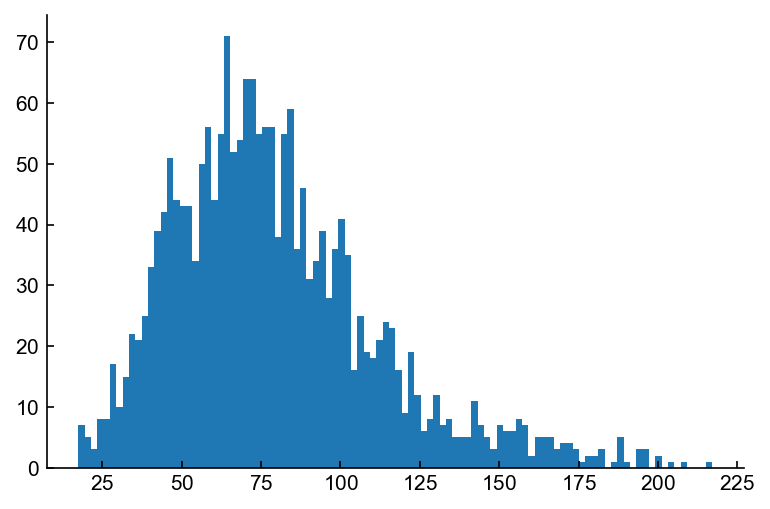

In [76]:
plt.hist(C,bins=100)
pass

In [150]:
ilep.getAllConditions(sessionfile,None)

{'all_trials': namespace(trials=array([ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
                          50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
                          63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
                          76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
                          89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
                         102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
                         115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
                         128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
                         141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
                         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                         167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [153]:
sessionfile.trials.go[ilep.getAllConditions(sessionfile,None)['all_trials'].trials]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,

In [149]:
sessionfile = ilep.loadSessionCached(act_directory,'DS_19_1_AC.pickle')

In [107]:
sessionfile.clusters.good

array([  1,   3,  11,  12,  14,  15,  41,  43,  65,  68,  88,  90,  91,
        96, 106], dtype=int64)

In [152]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_72_1_AC.pickle')

In [112]:
sessionfile.clusters.good

array([ 0,  5, 16, 18, 20, 24, 26, 27, 29, 30, 31, 32, 38, 41, 51, 54, 58,
       59, 67], dtype=int64)

In [142]:
np.array(EnumSession)[phase_mask]

array(['BS_49_1_AC.pickle', 'BS_49_2_AC.pickle', 'BS_49_4_AC.pickle',
       'BS_49_5_AC.pickle', 'BS_50_2_AC.pickle', 'BS_50_3_AC.pickle'],
      dtype='<U18')

In [141]:
phase_mask = np.char.equal(EILphases,'pre early')
cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]

for cov in cov_mats:
    if type(cov) is float:
        print('0')
        continue
    cov = np.array(cov)
    if len(cov.shape) < 2:
        print('1')
        continue
    assert cov.shape[0] == cov.shape[1]
    n_clust = cov.shape[0]
    print(n_clust)

39
11
8
2
11
2


<ipython-input-141-fcbac8dd8d96>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]


In [137]:
def bootstrap_dimensionality_DEBUG(cov_mats,n_frac=0.5,B=200):
    d_GT_list = []
    d_num_list = []
    d_denom_list = []
    
    for idx_B in range(B):
        n = len(cov_mats)
        sample = np.random.choice(cov_mats,n)
        
        all_vars = []
        all_covars = []
        cov_ns = []
        for cov in sample:
            if type(cov) is float:
                continue
            cov = np.array(cov)
            if len(cov.shape) < 2:
                continue
            assert cov.shape[0] == cov.shape[1]
            n_clust = cov.shape[0]
            cov_ns.append(n_clust)
            
            new_n = int(n_clust*n_frac)
            if new_n < 1:
                continue
            mask = range(new_n)
            cov= np.array([c[mask] for c in cov[mask]])

            this_vars = cov[np.eye(new_n,new_n,dtype='bool')]
            this_covars = cov[~np.eye(new_n,new_n,dtype='bool')]
            all_vars.append(this_vars)
            all_covars.append(this_covars)
        all_vars = np.concatenate(all_vars)
        all_covars = np.concatenate(all_covars)

        n = len(all_vars)
        avg_sq_vars = np.nanmean(all_vars**2)
        avg_sq_covars = np.nanmean(all_covars**2)
        avg_pred_covars = np.nanmean(np.outer(all_vars,all_vars)[~np.eye(n,n,dtype='bool')])
        
#         d_GT = calc_dim(n,avg_pred_covars/avg_sq_vars,avg_sq_covars/avg_sq_vars)
        d_GT = avg_pred_covars/avg_sq_covars
        d_GT_list.append(d_GT)
        d_num_list.append(avg_pred_covars)
        d_denom_list.append(avg_sq_covars)
        
        print(d_GT)
        print(cov_ns)
        print()
        
    return d_GT_list

In [147]:
phase_mask = np.char.equal(EILphases,'pre early')

# excluded_sessions = ['BS_49_1_AC.pickle']
# excluded_sessions = ['DS_19_1_AC.pickle']
EnumSessionExcluded = np.array(EnumSession)
EnumSessionExclusionMask = np.isin(EnumSessionExcluded,excluded_sessions)
phase_mask = np.logical_and(phase_mask,np.logical_not(EnumSessionExclusionMask))

cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]
# print(cov_mats)
dlist = bootstrap_dimensionality_DEBUG(cov_mats,n_frac = 1,B=2000)

<ipython-input-147-5c28b83f1086>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_mats = np.array(Data.cov_mats_NCR)[phase_mask]


114.54596747664397
[2, 8, 2, 2, 11, 2]

135.87934350309507
[11, 11, 2, 2, 11, 2]

314.5703521936799
[11, 2, 11, 39, 8, 11]

987.3141047652841
[2, 2, 2, 8, 2, 8]

392.1694358431859
[11, 11, 39, 39, 11, 11]

327.86779126336126
[11, 2, 2, 11, 11, 39]

132.55789765287284
[2, 2, 11, 11, 11, 11]

328.07009036369533
[11, 8, 39, 2, 11, 8]

110.99362229390059
[2, 2, 11, 11, 2, 8]

490.0560719758354
[2, 11, 39, 39, 2, 8]

447.18992078402385
[11, 11, 39, 39, 2, 11]

129.05384157904987
[11, 2, 2, 11, 11, 11]

512.5510721231266
[39, 2, 11, 8, 39, 2]

430.4397625621706
[39, 11, 11, 11, 39, 2]

488.3357579563512
[39, 2, 11, 2, 8, 39]

404.42887774462815
[11, 8, 2, 2, 39, 2]

497.3256277963859
[2, 2, 2, 2, 39, 11]

120.74750900563892
[8, 2, 8, 11, 11, 11]

598.7167235091132
[2, 39, 2, 8, 39, 39]

331.10640152487326
[11, 2, 11, 39, 8, 11]

99.86211681138667
[2, 2, 2, 11, 8, 2]

120.2543291562586
[11, 11, 2, 11, 2, 8]

447.74023111686563
[2, 8, 11, 39, 11, 39]

540.1138202078386
[39, 2, 8, 2, 2, 2]

86.

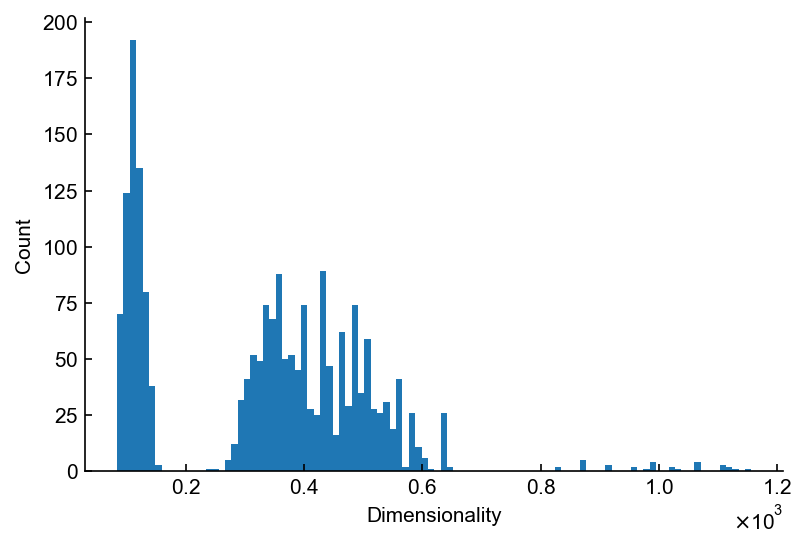

In [148]:
plt.hist(dlist,bins=100)
plt.xlabel('Dimensionality')
plt.ylabel('Count')
pass

In [127]:
A = [126.76065891268927, 650.5560465435448, 759.0733820488292, 99.85902552368084, 125.18669842882186, 804.313171516992, 132.01403488132814, 120.65920055371495, 2272.081168589525, 967.1332844704273, 833.4859643535534, 91.68527433490745, 830.3839266460299, 120.05429055388022, 114.23072659048769, 108.92310243546041, 109.9232747666821, 108.39124350329183, 103.43802571559381, 96.23452284453118, 119.31152440522018, 114.43828999722153, 117.55822309531469, 118.34514409758907, 768.1519715078467, 1155.0822258110659, 102.86682233300412, 111.06668908721352, 118.45261223141866, 107.9998304842207, 129.36844142634982, 124.02732322916093, 105.70262652713012, 106.34395971910388, 116.28434687449361, 106.847489370321, 101.88423815261596, 104.0860274245764, 1128.38652355211, 689.6975727445138, 101.98708580221621, 646.0454504625638, 844.5891800859553, 111.11369732523227, 110.24917159409468, 727.1790012984735, 1431.5502499019053, 4298.795004150751, 107.45334748544437, 105.2302794812973, 104.14387965815642, 103.6242311519301, 116.8759675114664, 97.35560789724913, 106.52896964874859, 101.76671257023908, 1122.042916813844, 3375.4515500246534, 784.6079699528841, 95.10708550197137, 130.03342164791619, 120.83030979961795, 99.95983245356028, 113.14952657306405, 112.99036523173237, 107.63864469652411, 116.88756668454869, 107.54831523527575, 96.42168949474427, 105.15309625872787, 564.7460085859213, 919.9592807327542, 106.84748937032101, 1149.408861127084, 102.62938104195298, 105.43189471962762, 103.11618130687162, 695.8123445891048, 114.43828999722153, 108.42100436453364, 107.78287999408205, 105.23027948129729, 634.9872795919662, 561.6563439285435, 105.23027948129729, 114.53189573535867, 122.43709651980753, 109.3473220388967, 108.52380181459496, 115.58773071472875, 109.8405489755377, 691.5344608705403, 102.00825551773886, 780.8942428129657, 102.97482716626733, 105.15309625872787, 111.79752461488071, 112.95552149350762, 1362.8935077051772, 1290.1318804361456, 564.7460085859216, 115.90481822655427, 109.40295638198774, 102.93813688598952, 102.93813688598954, 109.46868391001412, 647.991387426456, 110.4742106316906, 1001.1950213182614, 118.96161089219746, 113.101737706623, 1160.1373192876501, 1204.5229471615955, 118.86728254503114, 604.3175827881809, 132.602958358828, 500.08501203643334, 105.38485584838055, 108.91214689731675, 800.5807556714609, 113.87180516297599, 1005.644797504505, 911.0972537235116, 124.89499452898549, 651.6144638972851, 115.58773071472875, 109.55415867264672, 854.187437261203, 121.73715407157673, 1001.1950213182616, 99.85902552368084, 836.1406683357566, 105.25613143679332, 957.6524697508593, 105.80714001582868, 104.14256703430208, 551.8096897102977, 645.941980206643, 3530.247924981846, 105.25613143679331, 623.8557494526016, 1235.019044856982, 108.47147260716689, 117.58459839638236, 1193.1621121835594, 113.14952657306405, 109.9232747666821, 120.61587621697409, 831.1282353297272, 118.36974044897381, 108.90440840254527, 864.7500854729707, 118.57150826508531, 832.6323837972913, 824.116980148303, 935.3760473100206, 114.3859011927841, 613.2050738547453, 98.6413257587903, 107.78287999408205, 105.37472441151034, 852.290542963526, 115.34705031374536, 118.97854181531612, 116.85786969558637, 122.24594029616792, 93.96556147708671, 122.81541660877882, 762.6481300892076, 818.6877287482258, 422.2025148134085, 496.1053768066404, 119.21594041648565, 860.62449494895, 830.3024909541685, 125.14733362310308, 423.21216720877504, 836.1406683357568, 1153.2095958992268, 93.42259673152641, 559.342257289322, 114.3859011927841, 122.67546907928728, 102.76185848305016, 105.66590048976963, 857.8829391278032, 119.81034695357148, 1408.886398966251, 119.81034695357148, 118.02024781095078, 102.25101447319858, 129.87179316488277, 1176.896226438436, 107.07812531424457, 1962.892700543009, 755.6169833657647, 106.25772227456173, 112.5106764135734, 122.1792886653579, 119.01799416805906, 110.62613808694998, 105.70262652713009, 122.34220850107486, 107.77190380566957, 116.88756668454867, 611.5770804233649, 110.19790344100551, 130.81595937286517, 879.2693522002627, 1122.042916813844, 110.92704399078613, 106.847489370321, 109.89193553176989, 110.15345118079338, 976.2610742032301, 115.24186397443388, 1765.0601994954427, 103.54846923971904, 107.45334748544438, 810.3681611696632, 630.7587009845225, 3065.6303976586096, 803.7182535370798, 891.4842579648255, 119.31152440522018, 647.9913874264563, 2025.0731353349797, 1286.8935368182688, 110.97825132588824, 3375.4515500246553, 860.6244949489499, 101.98582498888858, 127.50298282024006, 705.2542184112342, 115.66383381306149, 111.63618360316305, 105.24432499826922, 96.779391213476, 734.4244098288335, 106.14317500830124, 94.05314028840775, 1560.7661157406912, 101.1894081912065, 97.55272504372208, 109.40295638198774, 104.76800915006231, 920.3438970524836, 123.4963324991799, 1041.8263118327052, 106.10821491383054, 746.236675689953, 110.98930819559041, 112.3958636926805, 124.16063675500341, 843.8952287229744, 851.5735146775962, 112.76293050719087, 1807.9190069135586, 114.01165577631834, 101.76977488474343, 112.9700159786194, 1005.5787737445999, 113.23082719873611, 113.56071608169316, 98.78502904630999, 1056.0400938006926, 113.99989138530958, 1241.4952176241695, 847.2620866004288, 805.0542221898042, 103.03092172052096, 111.25058095577938, 100.27694883826236, 120.9765136314756, 865.2724086904009, 983.3673127121527, 644.0022625459154, 97.27844565753516, 118.60228526538668, 845.1449291731225, 954.3943191610597, 957.6524697508593, 105.72707532319964, 1199.7324829171353, 132.29145128483444, 110.02005939708572, 108.60342165271629, 106.04362639462582, 1290.1318804361456, 101.82635344546496, 116.59621943387579, 3530.247924981846, 102.26793669705353, 97.80191878592093, 676.3491907937395, 799.765502993856, 113.51133595244953, 1235.019044856982, 89.4344150601468, 116.89562789314219, 119.81034695357151, 116.93490637525345, 117.13817067517455, 111.04059807379512, 122.81541660877885, 105.66590048976968, 119.9149449705571, 113.22764288700176, 120.84974693105657, 107.66966739496475, 104.45940513453256, 105.9155720815403, 109.1459411947917, 113.90281126933948, 1229.8075655236642, 106.14317500830124, 1029.3429881138402, 1265.984008835569, 113.41810199999115, 114.34580599726355, 106.85750881333358, 113.50905521395121, 126.43087186555411, 554.4057299478893, 104.0068669548421, 118.74562711368417, 102.86682233300411, 99.44505585576918, 112.96541958439418, 713.2966049922494, 106.57098422124456, 830.3839266460297, 631.8138950418966, 1004.5551347034753, 730.7305716197359, 104.57485949869569, 123.97555649774341, 315.6725423102459, 95.87492497244564, 113.67178287636115, 103.4749577232948, 129.17669868091983, 559.9352005432469, 1021.0878509720404, 513.3549444050495, 106.84748937032101, 116.47925184512401, 88.32181512840204, 852.9606076490933, 138.4084731533156, 808.0754512412921, 833.9640375236299, 112.9746638213143, 124.83234833087202, 101.03601313530899, 103.54846923971907, 111.06668908721348, 110.98513654646545, 771.3892008470757, 101.88423815261594, 128.03871034103662, 488.7078355244277, 99.23684977960711, 919.959280732754, 123.9755564977434, 836.1406683357565, 113.85280475149865, 110.23840320943434, 874.5155090324479, 107.4395328562898, 101.03601313530899, 107.12176729731358, 111.11369732523225, 119.81034695357151, 122.95257810747556, 110.19790344100547, 98.59170590965647, 744.8857311446361, 695.8123445891048, 113.85280475149865, 113.78332236327905, 106.57098422124456, 132.00320504759637, 105.2561314367933, 104.0860274245764, 988.3936433616392, 612.207418893769, 102.80574450100455, 101.84030924264222, 134.2920424931643, 101.7318389824534, 106.31866039086881, 507.5811414402458, 109.82728357200075, 115.2418639744339, 108.92310243546041, 104.61686874207066, 103.54846923971904, 118.96161089219748, 671.909568322696, 107.5675108554664, 550.6573778952098, 830.3839266460297, 804.3131715169918, 109.90857487086785, 1166.5354305258213, 115.31811439567488, 126.96672624428716, 127.11147278558583, 109.76612127567442, 106.14317500830123, 120.0623092760412, 93.68622590407766, 107.71512733755499, 102.42200039535294, 95.10708550197135, 105.40089047609789, 972.5999795046874, 116.96369419108345, 93.68622590407769, 113.90281126933947, 115.58773071472875, 852.2905429635259, 813.4880063707278, 881.6146035645642, 105.31233729373038, 601.9536495341875, 653.591407725053, 100.51135973137822, 879.2693522002629, 105.70262652713012, 423.212167208775, 814.6958381006955, 528.5463406182093, 715.9026506645099, 106.847489370321, 102.47252908636283, 670.4586974764399, 106.86868113734405, 108.71499173583078, 806.7998208838463, 108.21689661497354, 147.03004261954447, 103.02668142464911, 107.71272295641711, 104.58711203657258, 807.7090938858836, 105.23027948129729, 107.34802613817197, 109.40295638198774, 905.0534654082327, 108.42100436453367, 836.5027357965373, 114.39462183227478, 99.1065763395422, 122.64119603680801, 123.73332440983859, 879.2693522002628, 113.05207873342073, 111.58313608198547, 114.53189573535866, 101.97219400909532, 836.5027357965376, 109.73196533323132, 120.61587621697409, 95.4685804338483, 122.3422085010749, 97.41913526264916, 112.46688844472517, 799.7655029938561, 100.87952687770775, 107.3547901610408, 99.44505585576918, 110.50717140615755, 118.34514409758906, 551.6696853837154, 833.4859643535534, 784.0311031264857, 730.7305716197359, 113.51133595244954, 118.16138629729438, 100.70616686117776, 814.3691447823419, 112.55046270084033, 728.9533048903997, 116.82501519806539, 112.97001597861936, 1528.345181751026, 100.31054843148272, 109.02117977231673, 1139.7822208393502, 121.95861143558102, 115.24186397443388, 604.3175827881809, 105.86950368493791, 108.45650182921673, 108.92310243546041, 102.80574450100453, 107.19244106426903, 101.79483811191533, 1546.0059984948955, 111.91864435172769, 130.03342164791624, 130.41391728294056, 104.08917392770542, 402.93981050394285, 1867.0345628120003, 122.64119603680804, 122.5295458506747, 615.7340514151156, 98.8398901092489, 1160.1373192876504, 836.1406683357568, 102.04738632388424, 920.3605751730593, 105.37472441151033, 113.14952657306405, 118.34514409758907, 697.184216876582, 102.93813688598951, 944.3431605425878, 98.20596583307172, 110.77938012083315, 102.87479682604702, 101.06163613908556, 123.73332440983859, 100.99914507899113, 110.97825132588828, 113.12496369925861, 110.35463493656647, 100.3344543153662, 125.13465671392517, 559.9352005432468, 113.78332236327903, 116.8759675114664, 104.00766730210417, 120.97651363147563, 1059.1169320699673, 688.5672636729157, 480.79062239573284, 598.9260407349138, 105.15309625872787, 135.34735462879075, 117.82452594033919, 660.2652906511074, 110.19599495526833, 106.79318793793753, 847.4907754792264, 122.6669762520004, 118.74562711368418, 101.88423815261596, 119.81034695357148, 113.87180516297599, 100.27694883826233, 1057.6457713876853, 819.4014983866289, 554.9521926122586, 115.03490755468137, 760.9999488912713, 897.9082512633163, 110.5790421469214, 111.2701747405286, 106.11583301611134, 102.64602541478114, 109.55780906705564, 107.9998304842207, 120.61587621697409, 836.1406683357566, 83.37700467558241, 726.5485975576288, 605.9311913546567, 116.96369419108345, 114.23072659048772, 863.3163302966594, 634.9872795919661, 1034.410471657205, 114.84523355599809, 818.6877287482257, 841.143136843342, 125.67888427180216, 128.03871034103662, 102.1069918857884, 101.4953182040573, 471.26736307628573, 115.28827960883929, 113.88845692751865, 104.98247739826348, 1375.7294504991492, 126.36322758590144, 118.753239458671, 119.9530233436796, 116.5156859500009, 109.9232747666821, 821.1200164898071, 963.502028380012, 113.0776271310859, 100.7309176023164, 116.47925184512404, 129.87179316488275, 113.871805162976, 610.8859018076542, 104.00892969668057, 103.80103568002943, 118.049139079495, 127.77945130383272, 1201.403123499943, 109.55415867264672, 843.5992679686341, 890.2025882564083, 110.50717140615755, 870.7505347760781, 107.45334748544438, 108.71499173583076, 107.66966739496473, 598.9260407349138, 104.0860274245764, 112.714646137974, 844.6207385854339, 129.81981693360586, 122.81541660877885, 123.72271035433685, 803.7182535370799, 1568.356228308208, 107.07161206041901, 112.55046270084033, 107.61527352598041, 128.04139062853812, 122.3422085010749, 1329.6133953699136, 1528.3451817510263, 101.9364235702564, 119.9530233436796, 119.55312306088572, 954.3943191610597, 107.24443694814948, 818.3568455863433, 107.2940525934834, 98.8398901092489, 623.8557494526013, 2768.8432320515594, 822.5225738727328, 859.2255664341719, 111.90527245511569, 106.52896964874857, 762.8164599907083, 107.99983048422072, 107.81646573050683, 111.63248817905061, 106.14317500830123, 750.5541025556969, 109.53677663557237, 98.09655653138915, 118.40130209174335, 131.45114926382044, 103.10386572641059, 613.2050738547453, 674.3378575635762, 117.78307439209676, 604.317582788181, 956.9322282674797, 100.3344543153662, 117.30829156030106, 108.79588843957987, 105.41965596119061, 129.96505921715757, 908.3096247067576, 101.06483971176026, 108.48197873359139, 1290.1318804361456, 107.43953285628986, 1026.6725959987305, 101.89279676045979, 112.56548890662945, 692.0206352414865, 874.5155090324479, 109.18328989626778, 105.37733645236436, 105.80961983633746, 112.99036523173234, 424.9920130080374, 104.72885351101287, 889.0677875076904, 108.42100436453367, 117.54688726673496, 114.39462183227478, 103.2156972726674, 126.662018733694, 824.116980148303, 119.06114790883619, 103.07345637673635, 604.3175827881809, 890.2025882564083, 104.08917392770542, 112.15332308415132, 120.2332205796352, 105.24786564034771, 108.9231024354604, 105.20141822409177, 123.97555649774337, 99.23684977960711, 102.49912112362533, 822.7953445308664, 98.59170590965647, 99.01890284127674, 101.06163613908556, 1153.426486106484, 104.0382099315082, 103.65389574946202, 116.47925184512401, 131.37560955458213, 634.987279591966, 737.8679981446649, 478.4422946572204, 102.45222919668227, 114.81082533422935, 114.16025905599253, 128.03871034103662, 766.3396073445979, 852.2905429635261, 104.02512819887316, 123.42094824404658, 700.5316197995594, 118.45261223141864, 889.6027198128302, 123.3110375197427, 101.7441574595944, 116.26685989528573, 1573.6476708353089, 559.342257289322, 109.3816728744905, 1026.5428434729479, 111.3466895243288, 108.42100436453367, 1568.356228308208, 113.47165652766648, 103.10386572641058, 116.00050503097857, 109.58004328800912, 1016.3159676972998, 687.0547714817617, 716.135430733745, 100.27694883826236, 95.87492497244568, 941.202438631749, 1375.4422620756377, 113.56906307834505, 118.34514409758906, 107.71512733755496, 100.62335967431312, 723.5376687890024, 608.2382783099712, 103.0675977346984, 101.79025152208087, 126.96672624428716, 119.27819312573861, 376.4618418449058, 105.20141822409177, 106.11583301611134, 99.85902552368083, 101.49531820405731, 103.11618130687161, 106.11583301611134, 118.10742186636844, 120.33243332820393, 465.93281732886794, 115.28827960883928, 100.00259347098712, 623.8557494526013, 116.00050503097857, 939.9035764070642, 122.6832614256804, 500.08501203643317, 128.43365637535632, 98.5822811165983, 932.3508955323894, 676.3491907937396, 124.02732322916091, 98.6842756017091, 115.65656397933667, 830.3024909541687, 94.34805821285038, 111.11369732523228, 836.1406683357567, 800.5807556714609, 797.0843361001673, 98.97760993720586, 818.3568455863432, 112.39635805812635, 710.7886964221897, 829.4332559857548, 109.84054897553773, 103.28319513041376, 859.225566434172, 106.11583301611134, 120.59541625693228, 126.38286970934352, 111.48621880231545, 141.20022605279044, 680.3707831598499, 107.37045754771484, 108.56357291279227, 104.85932948874411, 107.9998304842207, 109.88059250046273, 124.83234833087204, 102.10658077213772, 102.36890151582202, 847.4907754792263, 1005.8439951376425, 122.81541660877885, 91.68527433490748, 1396.6848681535198, 95.46858043384832, 111.1333260624164, 719.5435399975693, 119.49183953159704, 89.20727971980013, 112.45889112339148, 126.65292909599859, 852.9606076490933, 285.81440947789247, 113.85280475149868, 117.38975775096046, 114.45188519677136, 116.26685989528568, 871.5132705483367, 109.09599333024876, 101.53724507194083, 105.23027948129729, 602.4246646529482, 106.85750881333357, 432.77804931905445, 104.32707167546465, 101.76977488474344, 114.84523355599808, 948.7127954612108, 110.19599495526836, 122.43709651980753, 97.46369014639735, 111.48621880231545, 122.55741107734892, 113.41810199999112, 871.5132705483368, 611.5770804233648, 990.2025842373007, 135.7379367020176, 132.60295835882798, 1419.1957726068126, 852.290542963526, 106.70210365034046, 120.05429055388021, 103.17695552852285, 96.80264553698072, 103.06759773469842, 103.65389574946207, 115.28827960883929, 1573.647670835309, 118.32401106117821, 97.09834281545558, 675.2383435076983, 108.92310243546038, 997.9433471370324, 100.99914507899113, 105.99177822835836, 119.81034695357145, 99.87966683220978, 112.72642577445802, 789.5401428604863, 114.84523355599809, 791.9324726388827, 545.836069438016, 559.9352005432469, 1296.8272874538231, 795.9869629435102, 109.88059250046273, 108.79588843957983, 600.8128993798562, 98.08670103651717, 110.91295789266393, 567.2258247710455, 122.43709651980754, 105.76917370863232, 105.66590048976964, 110.9893081955904, 99.44505585576918, 766.4591587442028, 874.5155090324479, 881.6146035645642, 135.94682809123148, 633.0255474090931, 111.2701747405286, 103.08429568041764, 119.81034695357145, 810.3681611696632, 98.78502904630996, 123.72271035433685, 128.04139062853812, 847.4907754792265, 110.61030035268723, 107.17519847585541, 129.99867435990748, 110.8786593452328, 130.0861316234792, 104.68218246677804, 123.7333244098386, 770.0997710644353, 1201.5300647308202, 107.57220153798362, 97.86313901934787, 111.88006232824318, 935.3760473100203, 126.43087186555411, 710.7886964221897, 113.06516259181228, 110.92704399078615, 1026.5428434729479, 108.48197873359138, 106.12992341476958, 764.1698738444569, 102.87479682604703, 126.10138088688866, 806.7998208838465, 115.21191921709017, 102.4725290863628, 126.6592605070889, 715.0031666240523, 104.9873400850568, 124.30571303230252, 754.6343852042593, 1043.8288426666854, 100.3344543153662, 127.61673213696855, 125.77258478827028, 114.19425094293904, 121.48013376477599, 1160.1373192876506, 122.43709651980753, 119.23928695729938, 646.1089182197927, 114.41443007732438, 119.01799416805906, 803.7182535370798, 102.86682233300411, 111.11871178151662, 107.06675511093172, 1072.6158766056005, 564.5319380748347, 123.9755564977434, 104.61686874207064, 766.4591587442027, 1576.1600105796347, 422.2025148134085, 103.10386572641058, 129.5814917631346, 102.1069918857884, 723.5376687890024, 113.51133595244951, 101.79025152208082, 100.27694883826236, 108.92310243546041, 112.99036523173237, 101.53724507194084, 968.681881541898, 106.78816341996824, 107.42357060472239, 104.20349604455406, 101.68831687532807, 939.9035764070641, 117.30829156030106, 104.00766730210417, 104.54865816822814, 107.81646573050683, 108.56357291279232, 728.615644216657, 727.1790012984733, 97.27844565753514, 113.42735315186492, 424.9920130080374, 1153.4264861064837, 760.999948891271, 104.61686874207065, 1241.4952176241695, 99.44505585576918, 106.54670316838109, 102.29995278976727, 710.8051606257457, 101.59987195811645, 135.73793670201763, 104.98247739826351, 1962.892700543009, 104.68218246677807, 112.76293050719084, 657.0623694704638, 104.2259041694365, 2500.3984945199672, 115.31811439567487, 123.42094824404658, 105.91557208154029, 111.7708329810194, 104.32707167546467, 713.2966049922495, 699.8070074437443, 744.1994355231575, 97.41913526264918, 100.00974196564572, 727.684052399668, 1093.9225849392833, 102.23885779210761, 109.40295638198775, 103.21569727266741, 805.0542221898042, 113.41810199999112, 1247.9513003369775, 102.41938727565866, 99.2596423571566, 551.8096897102979, 104.22590416943648, 1122.0429168138442, 826.3528575288292, 1256.2031886991892, 101.67736051044241, 114.89417979209001, 120.76705692812557, 109.3473220388967, 105.8173897245636, 612.2074188937689, 97.09834281545558, 889.6027198128303, 559.4620983869534, 1329.6133953699136, 98.64132575879033, 101.76977488474343, 97.8631390193479, 101.87244926655312, 111.61955562218445, 952.9176258729084, 107.99282777699156, 1139.7822208393502, 138.3025083376897, 424.9920130080374, 123.32749129034028, 1274.1168310411072, 847.4907754792265, 107.2940525934834, 107.63823873025085, 671.9095683226963, 674.2870108022133, 101.9364235702564, 983.3673127121527, 990.2025842373007, 122.73220093682806, 107.15142451089672, 110.9893081955904, 108.79588843957984, 122.55741107734895, 118.8142484565489, 846.8488203099923, 120.4846004435331, 95.99831683741843, 830.3839266460299, 105.98190373452678, 118.10742186636841, 124.61953348069198, 1006.8163266369781, 990.2025842373007, 728.9017777069256, 105.77788532208722, 99.2596423571566, 125.14733362310308, 105.25613143679331, 859.2255664341719, 109.25757594129132, 110.74637657777156, 1546.0059984948953, 787.203240082616, 1172.47230781668, 111.71769686529164, 114.23072659048772, 128.76649287076472, 130.60378203028412, 108.56226205909563, 852.2905429635261, 110.7391112604965, 741.7413325166297, 1962.8927005430096, 114.47725343988209, 100.62335967431314, 105.24487124616871, 109.88059250046271, 936.2392044177104, 119.23928695729938, 834.083170097032, 105.24432499826918, 108.6464965206084, 112.31797179583225, 643.4093506686511, 109.40295638198774, 98.64132575879032, 115.24186397443388, 96.23452284453121, 106.81256946065794, 122.55741107734895, 853.1368061168068, 691.5361261940174, 1265.9461830306225, 117.30829156030104, 799.7655029938559, 1270.160314504617, 715.1586846349554, 836.5027357965379, 743.0279674789234, 841.1431368433423, 1300.4141495691606, 132.99295980076892, 120.61603261024764, 115.26671724260672, 876.7074917428683, 122.17928866535787, 870.0215867119316, 100.87952687770773, 564.5319380748347, 104.75918752206174, 805.0542221898042, 109.41708942137717, 111.62602301174982, 101.97219400909529, 451.745600064212, 117.55822309531472, 103.6072948580958, 104.02512819887312, 100.63767161508035, 1048.589153070925, 106.70210365034043, 100.02345267263108, 568.8707726383049, 111.79752461488073, 1911.048117303112, 104.80643978873557, 107.58860369498719, 107.45334748544438, 103.98793441635257, 948.7127954612106, 106.85750881333358, 127.9266718082791, 105.19033604736198, 860.5340689251445, 100.63767161508035, 122.51313983584001, 2140.45742778602, 111.61955562218445, 488.7078355244276, 110.47421063169057, 814.3691447823419, 100.27694883826236, 102.41506792813789, 114.34580599726355, 120.51062901709545, 104.45940513453255, 111.61955562218446, 1270.160314504617, 94.61580100083967, 119.06170763550537, 106.84748937032101, 111.58313608198546, 114.84523355599806, 810.1893396279698, 1034.410471657205, 110.97825132588825, 110.19599495526833, 1431.5502499019053, 119.21594041648568, 128.05539018807295, 110.87865934523286, 1300.4141495691604, 104.84813104644746, 531.8910882563424, 770.4417470067457, 102.45222919668224, 135.87960466543174, 895.8148399708077, 1270.1603145046167, 626.3410669192334, 134.82475263410103, 102.06759440784121, 1528.3451817510263, 115.71599301137786, 127.75892331157795, 109.56308802329718, 105.45568791662602, 1098.6910496674973, 113.56906307834505, 100.73091760231641, 118.76014383616882, 104.68218246677807, 107.2940525934834, 843.5992679686341, 105.13448577022282, 1079.442149144426, 106.31866039086881, 111.6988510916117, 101.9364235702564, 109.40295638198775, 99.85902552368084, 907.4184709795776, 118.16138629729437, 121.48013376477597, 108.21689661497354, 100.27694883826236, 112.95552149350759, 104.80643978873559, 554.9521926122585, 119.29044304813353, 103.54846923971907, 634.987279591966, 117.55822309531472, 105.9155720815403, 1431.5502499019053, 106.26240597176118, 105.23027948129729, 710.7886964221898, 1068.5091629399533, 103.07345637673636, 100.27694883826236, 550.6573778952096, 106.11583301611134, 102.41506508056545, 115.3181143956749, 879.2693522002627, 124.66325280323912, 952.5527131703273, 789.5401428604863, 674.337857563576, 115.47836993230247, 111.22875585821666, 705.2707314718141, 111.1187117815166, 121.113923542055, 118.74562711368418, 1545.559101389487, 122.37636651308868, 120.05429055388021, 134.2920424931643, 124.41179381847067, 120.4846004435331, 1053.7719367583702, 97.27844565753516, 625.5188016314623, 111.6988230227838, 127.5184704276685, 876.7074917428681, 463.1126660689347, 766.4591587442028, 129.99867435990748, 100.62335967431311, 129.93794725065058, 674.3378575635762, 104.14314736233773, 1064.9824271076543, 697.7844487585544, 767.0964052002874, 105.86950368493791, 105.99177822835837, 471.2673630762858, 846.3645533425707, 821.1200164898072, 983.3673127121527, 126.43087186555411, 123.4209482440466, 693.8006966063188, 557.3750338057356, 564.7460085859215, 612.2074188937689, 113.9181209124308, 106.78816341996824, 737.7959230507315, 112.76293050719084, 608.0932476483215, 104.2602215589343, 114.79353125796673, 535.6331197839179, 112.71303250234718, 113.151291244597, 96.23452284453118, 797.0843361001673, 110.44538301581187, 106.42860568715425, 104.58711203657258, 111.29529703889018, 126.84041811848425, 113.57904088490207, 109.90968015656279, 110.66275110347166, 119.21226883036493, 109.3473220388967, 810.1893396279698, 604.3175827881809, 805.0542221898044, 691.5344608705403, 994.4814214642383, 100.27694883826236, 1172.47230781668, 108.4819787335914, 818.6877287482257, 134.20888068077053, 803.7182535370799, 980.0983487114435, 673.9898185157901, 89.20727971980013, 106.04302995107662, 119.69178324727746, 1005.8439951376423, 103.17695552852285, 101.06163613908555, 110.3730832315104, 558.1569673520942, 109.92571363390522, 113.41810199999115, 109.90857487086785, 118.97854181531616, 108.4950094078999, 465.93281732886805, 116.46913677509924, 983.3673127121527, 1130.2488874450203, 114.43828999722153, 674.2870108022136, 101.9721940090953, 480.79062239573284, 623.8557494526013, 107.78287999408208, 107.63864469652411, 104.00686695484208, 1089.1301346916216, 291.70123686985704, 113.87180516297602, 93.89746008890314, 689.697572744514, 874.5155090324481, 119.55312306088572, 110.38917954269928, 107.45334748544438, 661.2329595531204, 110.60533090748848, 1573.647670835309, 112.95552149350762, 126.91223453399977, 979.2507406925118, 111.61955562218446, 98.62486999863161, 1265.984008835569, 711.8862603789769, 101.88423815261592, 118.74562711368417, 862.8854224607741, 105.39429701400336, 112.39635805812635, 101.88423815261596, 712.654068093757, 753.6091038526662, 103.15600460720545, 118.57106873771033, 98.27991975598347, 103.11618130687162, 833.96403752363, 678.0653373837002, 117.30829156030106, 118.97854181531613, 140.35367442119465, 109.55415867264672, 117.54688726673496, 110.25443066988004, 612.51629038262, 836.1406683357566, 104.98247739826351, 103.54521774161016, 113.85280475149867, 1274.116831041107, 118.45261223141864, 713.2966049922494, 852.9606076490934, 615.7340514151156, 102.39784084786491, 107.63823873025083, 1375.7294504991496, 107.06086121053728, 763.6527555795889, 117.58459839638236, 480.9198021697754, 107.4395328562898, 108.90094552995943, 102.3269137482607, 133.98903747714758, 120.78327886577848, 116.26685989528566, 113.85280475149867, 112.07627661477187, 107.24443694814947, 116.16395714141989, 119.95302334367963, 104.67951557686426, 128.21762851307963, 945.7979732635, 682.2313947757425, 115.53154601961768, 998.1727073737381, 110.25443066988004, 108.9231024354604, 115.31689546037138, 98.59170590965653, 1282.5465144582818, 106.84251402896743, 1158.6502268491765, 1235.019044856982, 952.9176258729083, 109.5764939515451, 833.96403752363, 99.39115678540618, 847.4907754792263, 536.6170888439976, 1099.234777269179, 113.4181019999911, 610.8830522286313, 1032.0790012422333, 1229.8075655236637, 1004.62287778657, 109.41708942137717, 116.00050503097859, 110.8913399982573, 729.0187108381524, 117.54688726673493, 116.88756668454867, 1545.5591013894873, 122.43709651980753, 109.8360773250817, 685.6365871596145, 844.5891800859553, 114.43828999722153, 104.22590416943649, 108.79588843957983, 111.69777459749872, 98.27991975598347, 108.71499173583076, 553.6679266088336, 679.9106787170397, 110.60181995540074, 622.6101001795699, 105.9819037345268, 623.8557494526013, 540.7706294575158, 1026.542843472948, 119.95302334367965, 830.6017373868822, 109.57649395154515, 634.987279591966, 97.80191878592093, 580.7943049904968, 119.81034695357148, 102.41506792813792, 106.70210365034046, 113.90281126933947, 105.15309625872787, 100.87952687770776, 112.15332308415128, 111.88006232824317, 112.714646137974, 97.27844565753514, 689.6975727445139, 113.63316178272126, 123.14548107175808, 952.9176258729083, 117.29136530357704, 122.67546907928725, 103.10386572641058, 1375.4422620756384, 1243.9269009167208, 803.318379463093, 114.2774344643127, 94.61580100083968, 123.61521009503042, 113.14952657306405, 112.5106764135734, 1122.0429168138442, 107.98765579816565, 122.34220850107486, 801.402070135003, 116.46340847796407, 1962.8927005430094, 117.51791754156639, 97.59086974136734, 126.4157837753146, 112.76293050719087, 104.8593294887441, 119.87538949452963, 1185.379065325777, 2025.073135334979, 101.88423815261594, 822.7953445308664, 956.9322282674798, 730.7305716197358, 104.79312048440127, 830.3839266460297, 643.4093506686511, 950.5564719901693, 114.81082533422939, 111.69885109161174, 109.46868391001412, 106.57098422124456, 860.5340689251445, 123.9755564977434, 88.32181512840202, 1176.4475376722976, 112.42657040496286, 111.11871178151662, 123.42094824404658, 106.85750881333358, 111.1187117815166, 100.01451070515628, 130.46421713862782, 557.3750338057357, 376.4618418449058, 122.69820205477572, 127.27025671322849, 646.0454504625638, 120.65920055371495, 1070.122769201855, 1867.0345628120003, 113.07762713108595, 116.96369419108345, 120.9765136314756, 680.3707831598499, 118.40994149908519, 108.60342165271622, 105.15309625872786, 114.8108253342294, 105.20141822409175, 1568.3562283082083, 110.87865934523285, 122.51313983584, 112.5504627008403, 103.11618130687162, 105.88325036377816, 116.96369419108343, 118.97854181531616, 111.19512880844896, 110.27679389141318, 832.690562142265, 119.7591087978957, 636.1068256436466, 992.680029132595, 1308.2361027971053, 107.2940525934834, 559.7329544866811, 99.8042983594673, 110.9893081955904, 116.96369419108348, 116.85786969558637, 118.22953934718257, 105.66590048976963, 841.2456501288857, 826.1509576114316, 473.73190590719776, 107.98805162669862, 112.95552149350759, 102.34916831176412, 917.9909231643395, 106.54670316838111, 96.9181239171692, 114.43084278773513, 122.81541660877882, 105.86950368493791, 113.50905521395121, 110.24917159409468, 693.676323323419, 103.65203959603849, 109.90857487086787, 704.9283024408132, 634.9872795919663, 1229.807565523664, 104.6798907940743, 1235.019044856982, 833.779621032885, 1375.4422620756384, 101.9721940090953, 127.75892331157795, 107.01821964037313, 96.23074336376419, 107.45334748544435, 101.97219400909532, 120.65920055371494, 113.07762713108595, 810.3681611696634, 122.33343394880026, 107.12176729731355, 134.12491068899877, 109.17279908085727, 100.1057895439126, 1265.984008835569, 119.78410841684618, 111.11871178151664, 104.0860274245764, 496.43353822148015, 110.27679389141315, 1911.048117303112, 835.4315584983839, 110.8432796477916, 105.2448712461687, 837.3171614151902, 651.6144638972851, 102.24469092733868, 114.81082533422939, 120.51062901709547, 113.05207873342073, 92.9155650445091, 859.7790618303732, 116.34080189098111, 1015.846802661024, 103.54846923971904, 113.90281126933947, 770.0997710644353, 429.07159803468414, 107.4906576013452, 818.3568455863432, 888.4255638836933, 109.88059250046273, 87.45559839652172, 559.732954486681, 137.95620943329655, 103.10386572641059, 117.55822309531469, 107.17519847585541, 100.27694883826237, 750.554102555697, 101.88423815261596, 760.9999488912714, 107.45828904828464, 117.26301112907636, 108.79588843957987, 103.9689155187598, 101.06523639068516, 99.32895942573452, 2605.9829268534513, 109.26190066113297, 110.25443066988001, 108.47071207293033, 110.36792658530634, 488.70783552442754, 113.63577042527363, 2983.7342358143856, 124.6632528032391, 125.18669842882186, 112.6685393974044, 853.7020292237115, 98.78502904630999, 91.68527433490745, 646.1089182197927, 1068.509162939953, 99.67113060166223, 112.33465868213324, 105.2302794812973, 107.59242271268349, 121.78920103441686, 946.1309740207738, 114.84523355599809, 756.2423265010707, 110.9893081955904, 125.54792026271653, 108.47147260716689, 729.0187108381526, 97.51735960919576, 112.76293050719084, 103.58313670920572, 107.45334748544437, 98.35868717087118, 97.27844565753514, 106.73393232398148, 111.25058095577936, 890.2025882564083, 109.57649395154513, 1012.5600812069456, 1175.439207994077, 817.4077719131315, 109.58313486665583, 695.8123445891049, 1592.8159141523759, 1034.410471657205, 99.95983245356031, 118.42859272353866, 104.45940513453256, 147.03004261954442, 753.6091038526662, 814.6958381006955, 806.7998208838462, 103.07345637673635, 126.42444212037341, 188.55700088193385, 102.53860615324031, 113.07762713108595, 141.89981267553424, 128.04139062853815, 114.39462183227481, 708.5958646754597, 104.76800915006228, 101.59987195811645, 1012.5600812069459, 107.9066532639056, 730.7305716197359, 118.14103350954025, 99.77583621725401, 762.8164599907083, 105.79488429616687, 111.61955562218446, 1270.1603145046167, 2511.6238978350007, 1172.47230781668, 96.23074336376419, 934.1256902904092, 689.697572744514, 762.7122371148185, 113.14952657306405, 122.81541660877888, 99.44505585576916, 122.44571658110829, 119.21594041648565, 116.47925184512404, 97.80191878592093, 120.61587621697407, 102.10658077213769, 123.02208192278218, 100.27694883826236, 1130.2488874450203, 696.3611720361633, 264.06782984316504, 141.81403532104738, 119.55312306088572, 107.24443694814948, 115.28827960883926, 105.24432499826919, 113.07022523515529, 665.4310953125652, 716.3329381198964, 687.0547714817617, 118.45261223141866, 105.6933450874486, 101.88423815261596, 898.892925512683, 108.57765621613855, 952.5527131703273, 860.6244949489499, 114.84523355599809, 114.50085155028043, 647.9913874264561, 104.32707167546465, 112.39586369268052, 108.79588843957987, 832.6323837972911, 852.9606076490933, 832.6590121348734, 103.15600460720543, 106.20000596976516, 106.18541021566878, 96.42168949474426, 117.26301112907638, 128.03871034103662, 106.11583301611134, 105.86950368493791, 630.7587009845225, 125.7330278675931, 820.0261606202423, 105.8695036849379, 103.04011262872159, 623.8557494526016, 646.0454504625638, 100.68722159912848, 944.3431605425876, 108.52380181459493, 125.18669842882188, 101.569377283686, 554.9521926122584, 105.48545871080744, 97.8631390193479, 882.0692478623291, 103.9423778590029, 106.84315548366048, 104.45182215433357, 111.71769686529164, 114.19425094293902, 95.32547912445942, 810.3681611696634, 1241.7197505106585, 130.8435774402736, 105.37472441151037, 108.47071207293031, 113.59167980161604, 135.0823322933562, 983.3673127121525, 1139.7822208393502, 109.56308802329718, 118.94505730585314, 93.68622590407769, 102.4725290863628, 104.00892969668057, 860.6244949489501, 1153.4264861064842, 117.35403455522915, 92.61422879985294, 1099.2347772691787, 707.4892240802361, 736.9799802038614, 841.143136843342, 110.57904214692138, 625.5188016314625, 110.98930819559041, 716.1857452935956, 96.23452284453121, 120.65920055371495, 1573.9363963233086, 514.6744406699058, 112.12131324043845, 662.8512627388375, 423.21216720877493, 112.45889112339145, 120.61587621697409, 644.0208294504858, 123.90287493160116, 122.64119603680801, 966.1883640849832, 621.1446234918354, 91.71347751126581, 808.5569814177842, 105.79488429616687, 105.90113190898177, 101.06163613908556, 109.40295638198775, 98.5922768486361, 115.56514839371002, 126.81665121156354, 110.77938012083314, 106.62705071845815, 106.85750881333358, 112.9555214935076, 1419.1957726068124, 1375.1803524188497, 111.68140179841767, 942.8837002387787, 114.43828999722152, 665.7000402358645, 843.5541391087107, 105.66590048976964, 772.8302303046099, 123.97555649774343, 110.97825132588825, 106.1431750083012, 1375.4422620756386, 121.46064859148272, 118.42859272353864, 87.45559839652172, 99.3289594257345, 104.76243340953208, 105.99177822835837, 665.8631706829677, 713.2966049922497, 1296.8272874538234, 860.6244949489499, 123.90287493160116, 117.13817067517458, 120.07531432038697, 107.4235706047224, 122.24594029616792, 119.21594041648565, 112.55046270084027, 793.20375199205, 110.47421063169057, 121.78920103441686, 728.9017777069256, 1151.080100164124, 121.12306758489278, 118.33391225643236, 1265.9840088355688, 114.1058815159071, 797.1787668470604, 118.57150826508534, 107.34802613817197, 89.4344150601468, 100.63767161508035, 97.89527413621002, 91.71347751126582, 107.78287999408205, 1020.0378260498967, 113.93512501438614, 108.63390612590813, 102.82391569192295, 890.2025882564083, 2272.081168589525, 92.10082495588539, 116.26685989528568, 103.54846923971904, 604.317582788181, 122.73220093682804, 108.19112634544423, 835.4315584983838, 108.9231024354604, 105.921524788589, 464.8197002639721, 651.7064534968498, 102.41506792813789, 819.4014983866286, 118.80818152823817, 1201.4031234999425, 644.0022625459153, 803.7182535370798, 131.78297753310187, 120.4846004435331, 106.84748937032101, 112.51067641357336, 107.7922092002734, 108.0716054658193, 952.9176258729084, 983.3673127121527, 727.1790012984733, 96.34147412767187, 841.143136843342, 432.77804931905456, 100.3344543153662, 113.41810199999115, 118.02024781095075, 111.11871178151662, 116.34080189098111, 634.9872795919661, 121.78920103441688, 123.97555649774343, 918.6566903450968, 740.9843526226684, 114.42893267107581, 109.91190378505101, 1962.892700543009, 753.6091038526663, 127.7254675905764, 113.67178287636112, 105.84348755874113, 109.56308802329718, 118.40994149908519, 107.54831523527572, 105.73862678526775, 119.31152440522021, 122.51313983584, 111.1187117815166, 118.0451025274434, 109.18328989626778, 715.1586846349555, 1564.7819513132993, 127.75892331157795, 104.61686874207061, 130.58442215244682, 113.46902006156351, 109.40295638198775, 121.46064859148268, 734.4244098288334, 104.75918752206177, 98.64132575879032, 127.75892331157795, 814.6958381006956, 113.87180516297599, 120.58730468904709, 122.7022582454608, 2025.07313533498, 103.15600460720545, 104.68218246677807, 111.19512880844896, 559.7329544866813, 105.91557208154029, 101.63024217805619, 110.92704399078615, 108.60986530990613, 124.12785573478146, 554.9521926122585, 107.9066532639056, 645.9419802066428, 119.95302334367963, 115.3639082879306, 107.37205017271587, 120.05087063715102, 112.56548890662943, 570.3177056191124, 103.03092172052096, 1247.9513003369775, 117.36734081231153, 104.38656001816983, 109.89424853525264, 561.6563439285435, 559.9352005432469, 102.80574450100454, 116.42154429446818, 110.9893081955904, 807.7090938858836, 723.5376687890023, 115.31689546037136, 97.5582122945605, 101.33291814670413, 112.45889112339148, 97.92283454819449]

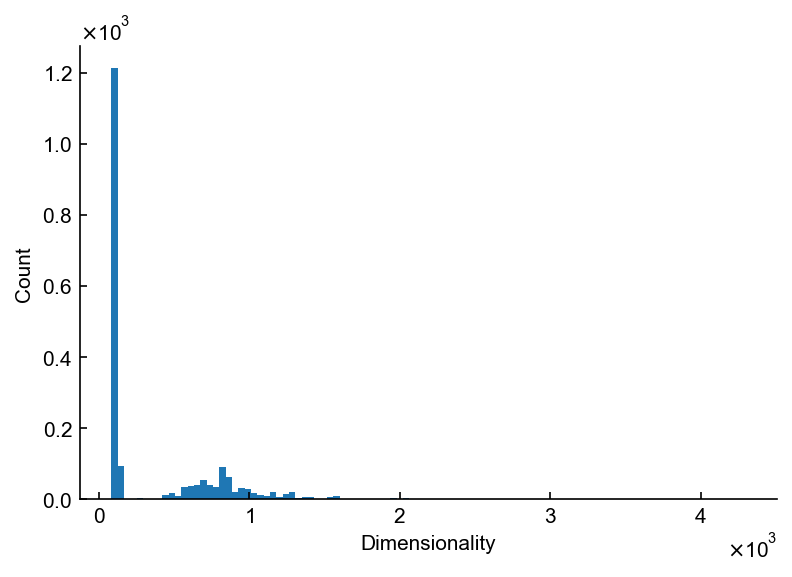

In [129]:
plt.hist(A,bins=100)
plt.xlabel('Dimensionality')
plt.ylabel('Count')
pass

In [79]:
PE = [246.79644481852714, 176.52761536982536, 257.55307862376486, 236.23839304078828, 260.1919500233338, 269.0345822532945, 299.48928202663234, 273.02636467565316, 269.08879843119604, 262.9221742433823, 220.76323358991908, 221.2817814410586, 340.54550465675027, 252.49367912108403, 219.6263295651642, 266.6167763975497, 259.47564436789514, 321.49390910358375, 318.34078782713704, 302.82388487139735, 297.8218660586108, 298.46331578008443, 276.7011030449623, 289.5179841427779, 216.031562967927, 236.87266661279122, 277.74989793547456, 298.29341970752097, 213.59690153060743, 267.24012306531296, 264.21095641919595, 277.8624264850603, 182.33970489790207, 187.869080491113, 229.6950507212419, 252.81894759840964, 244.31714220773512, 187.99557454010414, 322.8253743363903, 242.79645004195288, 274.9828713974285, 296.4071412918406, 243.466296947173, 323.88982788843254, 241.79710605353944, 228.83020960603986, 230.0468727450159, 210.77840720221977, 186.1364859981686, 322.69962536372094, 244.26579097023526, 274.9300640243033, 246.65804314165234, 278.7361554761386, 212.5359357105249, 264.89461932428253, 346.409604192154, 291.7519582055301, 231.12158021098492, 239.8820711321453, 293.2598450695744, 215.54047582967658, 234.33292561649554, 331.8318020297603, 289.52321927700837, 253.3055083379118, 259.5489959446654, 296.2033928860275, 299.170283017747, 220.8732300860801, 189.07918737931374, 281.95506724051046, 232.04032135700032, 240.64118465840684, 251.19507205607906, 292.5431934683616, 298.9119942489515, 280.53848513362743, 205.0963946043242, 232.34387372586932, 327.9850236741359, 244.33279652137608, 277.1302560281205, 240.15796629192107, 278.78847578579513, 220.07169048466614, 265.76447393512416, 299.5230795400983, 322.1352868825562, 311.4915092545503, 299.54360795064866, 327.9164018510603, 279.2652204450251, 319.0042861384939, 243.40217666619924, 279.70781774112635, 249.03751270140413, 220.02968184386035, 330.0983666396135, 247.6399447846272, 305.03572483262815, 292.3040602440407, 209.96843060353342, 327.5591829854946, 301.52659322783694, 233.35097005687692, 355.7589423345296, 251.18339629256505, 263.9444369218365, 275.0515193932093, 278.65372499955583, 302.0886378615985, 285.4208313080051, 226.55404208727526, 214.2098955820575, 188.0906092128884, 291.3799849857924, 313.7069379909121, 246.07316792661297, 287.6121564433751, 227.14898724012525, 278.98040044240537, 266.94623048119195, 293.6678038354536, 164.76397291139173, 155.7807748250857, 152.05172658651276, 316.0359034268244, 254.2477524939843, 292.5925881141473, 267.32581459885563, 299.11882569496885, 312.03885723095726, 258.5211305707348, 263.3283541359492, 255.92144847934995, 321.5555859403595, 305.8912501393163, 239.9316449810027, 295.85748206159445, 287.5309801256895, 317.90695949281263, 310.72938203445995, 240.79792252630398, 290.1569594643501, 314.0302693811213, 212.0176112697147, 275.8313289835027, 300.2026256050013, 274.16494389732065, 286.48268628508976, 315.2346506826806, 274.87262590021857, 298.99875287126605, 212.6694039907048, 208.4589851091142, 259.3095182926096, 281.90244955857275, 266.52270017206115, 300.41933179536323, 300.24975130991925, 259.55856229893755, 263.70286404555577, 174.8290825549451, 206.10037979264837, 288.55224201214315, 259.9061073768372, 255.08610372962062, 358.8209687778991, 241.80631689749777, 290.30442925048766, 291.95873772939575, 254.77165082238054, 234.2123491784477, 250.63659655966882, 267.32256418147676, 290.9100919262026, 232.55075653477402, 271.852228281372, 264.52676246711087, 257.67681922955063, 374.6232989218321, 270.1692731118682, 266.9527891315912, 222.7457693692342, 289.4963252945482, 305.7695310506245, 221.73970344174185, 331.29582042411, 233.61382295729052, 276.26025813796355, 309.8557422768184, 271.09083426170383, 288.4461884170818, 330.78156541459674, 257.2778331015628, 229.57317689236461, 202.75158544876183, 242.56020392157998, 230.30994037285214, 168.2552710425786, 218.8043633418585, 293.59448925946054, 298.0234392364997, 269.62618583087954, 334.7535944161503, 289.3198393906358, 262.5592828712704, 271.773957052864, 226.42686850395322, 191.2732910600386, 302.45232874175053, 272.3413518441871, 252.14869962809885, 231.4471669733477, 335.3585581424175, 215.76573012623234, 255.22398941346322, 274.587709679206, 204.1637372963308, 299.36807677253637, 313.75915507583994, 308.661794301501, 265.32852936020834, 261.3818140239473, 289.35118720311465, 161.28744749389134, 288.0348728193624, 250.60536535834177, 315.74203321891804, 250.83740526379518, 287.9892815727639, 193.41142723329497, 289.7669530673805, 258.7845811072637, 219.99683957454297, 297.144885629007, 258.63088569335537, 262.0889125329772, 245.61830863486986, 317.5794051178976, 201.3437362574155, 298.4579293594277, 290.08462317245494, 240.98017103319722, 287.03255104472817, 294.9235971547953, 276.31123643125954, 257.3348120034812, 279.07208252950113, 278.45122816250984, 386.9486163279087, 329.77479049740555, 256.5852150404533, 288.28520017178147, 285.1136931918992, 275.6018247417749, 259.84637727751783, 328.70471126729393, 357.54593586683694, 279.75921855347235, 241.3412591765386, 311.4350299281777, 225.17570730442947, 292.0531345080585, 283.0800071560656, 269.9062527162329, 207.42149112912634, 264.15267970698153, 210.22122178431334, 281.86533693692775, 272.99042599720576, 281.22977848108883, 265.3312412334179, 256.12762142285163, 235.71519425022913, 272.28067833315345, 277.33210616447724, 253.8657176084417, 278.7826245483418, 223.87504752260003, 248.2681518987448, 239.11394352119095, 315.7115257239071, 328.63855690927875, 317.15005583614146, 276.4580739301219, 316.40788214434724, 257.7507291599891, 241.29595083704996, 254.4739674602924, 256.33323179887867, 299.7436569996271, 314.3744680526552, 257.8293525973393, 207.90208252448053, 244.19873254983082, 220.74303066956298, 321.5477864709212, 249.41058965934863, 263.2565162331345, 284.2927131862075, 274.63501230686705, 287.9765059940309, 296.0015531925, 333.5245021915261, 290.76162010000064, 245.9500918089919, 177.75458946010107, 254.12223564631086, 244.72780569727544, 286.6883971460144, 317.514483144452, 227.34375800236103, 269.3002418936185, 286.65541385694684, 234.91219414927767, 362.0280307324518, 309.33290007032036, 233.1863933647196, 269.7047273636861, 295.0849571232561, 264.4567076005036, 302.4293207266458, 161.16680761248494, 278.9372137464707, 251.8081804222311, 346.3766008037731, 289.1436208237421, 265.6387696168162, 254.8548669568257, 229.45357617525926, 214.6100552582812, 331.7112897980843, 243.98482647074306, 296.53491796879626, 262.9337794630569, 279.3706672254671, 326.2592723968704, 203.81415064987402, 219.17389445325344, 269.03796678966035, 252.78949609896586, 247.345925349736, 265.19498841710396, 264.3430879869498, 271.50019029553056, 297.5943517772336, 281.6285481837034, 186.43627232393624, 226.0463522527368, 346.687483564499, 274.49175704446236, 276.88235378340937, 302.1036203720764, 299.8661360339071, 307.8527490968196, 290.10273324327426, 305.64889336001283, 228.78800851932232, 316.14812786536373, 274.83775012495624, 179.4818579331547, 236.64914060619566, 259.47092929126785, 291.6045712229873, 249.86123952105623, 315.14956547362743, 276.9128983863463, 281.5367805156309, 255.46626636227515, 239.4292990673473, 262.9084796568659, 247.23357863620512, 276.4703510268098, 267.63311361465566, 255.95171951579405, 175.5139779302066, 243.02162363144467, 228.5725477250965, 259.71267895966236, 240.24458668982277, 271.3768907667214, 280.4332040572135, 241.69637515380168, 275.54069490299304, 292.5196483700978, 251.1019658501067, 287.3369470756488, 255.43332132271547, 223.9221666565712, 235.085223122834, 272.8173681673317, 282.23741832540867, 282.8935386351001, 238.4825859789964, 242.44677522072809, 243.6659678369077, 325.2366964838898, 369.50129840093956, 213.02268078590726, 285.7325246213818, 260.7048594252764, 269.62855155747576, 281.9517567228762, 239.08397834371016, 252.65402612549863, 247.47501211103747, 291.42407052280987, 274.32024031378785, 230.5471133442624, 200.24474912994924, 313.8248154294424, 255.73427530349758, 257.1290826174932, 264.0737191607872, 263.75063879353416, 252.64079027691184, 255.52419595069216, 222.06115284411098, 242.9148699943069, 308.7012457309488, 308.66753348391535, 268.5388079829407, 232.68981694862885, 270.04578531876757, 259.2057607149322, 259.8294400341764, 239.1212852871483, 222.0008521988983, 187.9456077043805, 259.21172739813477, 301.6929536681276, 240.56053498422702, 295.7239469049534, 258.334138170682, 307.23419441130267, 320.9672330199482, 270.4742481282272, 280.02307579606094, 333.79262366006014, 303.07919718180176, 258.6500668989517, 184.30042022318682, 281.88802351919816, 329.35823432204074, 278.65438512177803, 247.4752862212881, 272.5047922571829, 272.5509377069276, 324.5066496297835, 248.78122424364693, 255.36397738499812, 226.23416426732197, 228.9615971301864, 220.38873944887487, 283.5257961504077, 233.49569578938528, 291.6692811556135, 282.2677865125442, 292.2413912594672, 224.96992156874504, 293.49982925951144, 215.73189234111527, 247.49401458155762, 262.1413179196957, 298.5331990333827, 334.9469442257708, 300.02209854762145, 270.9131192147937, 272.055321771195, 289.035383919139, 233.62045054216725, 179.06468919302014, 200.9615921119179, 275.9268044380175, 251.66686651324127, 287.7435056509545, 296.57519775564356, 268.04692661925003, 301.00379350601366, 226.1150251674572, 358.0336866746245, 302.75227634347107, 273.45088079495144, 292.9364363407652, 203.23262132344752, 258.15434203071885, 229.03108577825475, 320.5789513608994, 244.0904400173455, 195.21508998274345, 236.23983021660177, 251.64600856218476, 304.4043839035257, 245.82776321162325, 344.8660637840699, 317.2597586489864, 276.57382729772377, 248.94644087864506, 304.12583629523755, 262.4452654087891, 278.74074510604237, 244.2288990168561, 257.6450542019435, 297.92153177888315, 239.3769263751715, 206.79516447438678, 212.24698934858708, 289.28188552032003, 269.21863975868143, 293.1447329125251, 270.0587256722168, 316.9749488004579, 288.0362585262372, 322.06479055342794, 281.0290723209495, 265.4735640200656, 313.8612966210465, 223.11165258884483, 333.2426791158977, 250.451098691598, 262.23984422881614, 280.59593956515647, 177.6141762123434, 285.5563689571784, 250.64726321152304, 219.70043828017785, 223.97912654376, 300.12638222924767, 252.2210158967437, 184.88842946716082, 256.2831027347739, 329.048112548751, 209.31375480421664, 320.5383425048934, 266.15120683784517, 218.97051064440063, 261.6170816497853, 267.043762697232, 253.6370037284183, 314.59276206812467, 259.31634014892967, 267.5727272173258, 267.8273631670143, 198.59670045686946, 223.27516530377804, 256.01926283793426, 226.68088233985932, 210.94063731779465, 253.84688231648244, 373.3783760817771, 250.1486499662246, 317.2178667136192, 268.1800718571357, 277.53446689023644, 286.9130847982463, 297.4092036692475, 248.06935654371355, 340.939385301541, 254.77267895691028, 332.6415946613366, 293.3200432312747, 225.47064889895307, 279.9258173697753, 303.552679145373, 245.4321656858352, 345.89509267136265, 331.27230040812105, 236.01163704081978, 222.44833295866567, 264.7002018588456, 233.52154670099713, 280.9247558201663, 236.38977254086095, 258.03669664232274, 284.79398285588553, 229.6520945765677, 288.07095801337556, 239.76409348921536, 232.79596467386503, 363.04562289853425, 258.4105094575716, 227.79734010753856, 324.02334188257316, 278.5488044510726, 218.06103902161354, 233.86742685058488, 310.17361234026515, 284.2724493205232, 274.22696174489346, 298.1842462278717, 292.15537641516903, 231.91715663997982, 273.0452816773296, 275.20032620219206, 276.7296651011045, 288.98620478176076, 185.84023488252728, 284.26114912556784, 304.33850300807484, 284.7364070256713, 249.07725102259357, 250.87302112093894, 217.45941853464402, 315.1285721079288, 274.7264487014059, 294.27848829906594, 259.48280705778734, 297.68014120398, 235.94988627848758, 311.2244007202586, 282.34232219231836, 283.14157017913186, 208.73578000110024, 265.41641694390415, 218.64074757166728, 239.87615093848638, 228.89597660081444, 277.6852057956432, 257.87402565947866, 283.12345863595016, 287.79588454981547, 278.4366337728477, 249.6582924732891, 238.63835536038746, 278.45411633647245, 248.37349150563247, 270.99257609404054, 277.54438608074815, 245.88297479239492, 272.1805234837986, 281.41710271278424, 220.09579020766824, 267.48582591846167, 284.2355335100156, 280.4271444133473, 274.71070490888883, 239.85529163448172, 277.81178156810677, 310.8313011263665, 259.06304001505646, 319.8249997272541, 234.05699453161102, 314.22789474141723, 261.9603018221128, 399.0895176635374, 194.6733489330833, 371.7450910012137, 222.29690256228236, 298.5319876022447, 272.0220736478355, 245.59134981689195, 284.5880084661434, 339.3173731304199, 275.74247712087634, 239.10785876805122, 251.36292942806924, 266.9993426856487, 346.00028195966553, 217.54829117158343, 200.63393731255647, 276.5077026208519, 248.70457017723172, 231.007942311031, 275.735617674479, 223.70915635990485, 218.61422283155483, 289.1374586224864, 297.7700945749962, 295.03695100408066, 285.28859644097867, 291.22500860034955, 304.6226849668255, 219.42439623070027, 254.0739904876051, 189.1352182270811, 230.65141642328805, 182.93925640990295, 250.90205659451357, 276.64888578257876, 276.10255719710926, 228.03941987631532, 253.1105455393479, 204.08876939134436, 241.60547396128817, 234.01604041656762, 338.01484328982616, 279.3977794839873, 230.79854475911714, 275.3726472747623, 231.22000146519864, 229.4583107305524, 157.273975263096, 277.0969882299106, 260.5964781850873, 280.45283353999594, 253.24817119482574, 307.2124610688797, 317.05054867048824, 228.85086078294648, 279.43116351865024, 226.80521264018876, 285.12096255910285, 319.18705878883594, 258.6899401304209, 273.2670889947482, 288.54816568674204, 263.4064924968407, 272.52451028046784, 294.3536828292179, 266.11789077895037, 286.8495663741364, 260.96549149116703, 226.76881340338963, 256.7092511768999, 201.24397017994764, 236.98808884851087, 279.5549881669778, 278.5820349397772, 286.5532799483969, 264.003858766874, 241.92502485600735, 220.75685269613925, 317.2086329371633, 331.68174854816004, 298.7566726178088, 224.20785111612688, 272.6181421149863, 298.83736281442907, 295.4363314939678, 225.95998423235304, 268.85297008957576, 173.15001351270962, 292.9424827933123, 317.6008104732877, 248.0426534366066, 293.56126655938334, 284.05834917215145, 249.36927056213742, 241.5209042038756, 299.7260151696642, 183.41864948860487, 286.375427555149, 220.67496597373332, 224.4423027728089, 221.09694488725412, 265.4133908022231, 282.1964709493592, 226.75062709344158, 315.60568942368354, 302.8219069512197, 215.13361146602787, 321.07448063162394, 268.79479890489483, 257.626015949326, 247.68344379382776, 263.0609849061043, 243.13575999338053, 182.06532933562903, 168.24774819113722, 224.13516238805312, 259.4784839844146, 275.925936375216, 228.08353993667365, 230.7777023647236, 266.96953846544545, 235.67844602672935, 277.55517469499136, 275.0838144338969, 228.17782463462456, 254.8915852557508, 293.43826937193813, 260.0295817456108, 334.07474568767327, 281.3845202183986, 314.20643370323415, 273.03715074385093, 259.6576820492165, 257.4725035919677, 230.03230336168278, 283.0201042567784, 282.1151146998583, 282.259862732729, 275.85429410018526, 315.12537885425684, 363.2019857249626, 291.69599378895646, 252.23097936202802, 278.5388954265703, 278.30369489414767, 274.17273190959406, 242.90822107107823, 227.34607023957975, 289.6286558120198, 219.31365342600515, 323.7819796724523, 271.72467331559204, 296.3592579362232, 320.45318220819786, 284.55508485535324, 321.28512716215334, 246.45553912387655, 262.65835455185953, 216.93150168507236, 293.70599150216304, 300.825543136803, 244.2136847559052, 262.3643016830583, 255.2638180625692, 253.57400051679497, 223.63038093695351, 259.5111352909823, 250.25503537498287, 296.5433050346786, 258.2104685098477, 275.6333391932063, 312.32632084383175, 296.34739408171487, 207.56195317310656, 306.26028895712125, 254.96727825262332, 279.33670515998233, 255.3387991071499, 291.1768875345828, 262.6584390528602, 302.8815214529488, 311.17363485233153, 304.3928213344135, 211.69137829998593, 259.9384627662355, 209.25665622748338, 270.0215603198234, 288.08679076577096, 322.87178878292883, 232.52385732281112, 242.92838034037442, 217.32749898251947, 253.10419367492852, 245.2337067603113, 341.62388709745477, 246.58352649116628, 189.00418519769815, 262.2505235916734, 227.53051655789267, 269.04049624612907, 221.4698531817845, 236.40847944169636, 329.255226149592, 264.9811958408678, 272.201609277128, 267.7226415454611, 227.26292559219442, 331.7794020343925, 265.0491072794656, 300.03193164313564, 242.25292972152678, 294.6925337781578, 299.3194534698111, 240.29815798664762, 288.59054764815204, 229.76720193131985, 283.0123339571831, 249.80241976624853, 294.15263918050016, 218.42730361549263, 300.5027528734684, 278.5100502182549, 291.6193919946203, 269.3768473042912, 325.08996718027174, 254.9661036541118, 291.7220202930119, 321.8186451037406, 307.27916063781714, 297.9520182432419, 368.5779687017998, 288.14898893806196, 272.55187626849187, 286.93147332249094, 293.03048617134857, 330.57421368283906, 305.6487010837677, 274.0114127892991, 337.12918090245, 299.35461348282433, 279.167488269093, 272.58037996326743, 260.85435297654726, 271.36525004499714, 310.4195170279533, 268.6887076758943, 270.05539063549384, 266.9516213932042, 241.70527040925398, 196.8624114281464, 336.22507330330893, 196.91290747729246, 210.1070807465609, 297.92678347964704, 291.2798123925741, 276.2040308207825, 242.2396592851536, 283.22723507304937, 280.89852588565236, 250.88144370102628, 256.5702522893222, 209.95124046109225, 238.9305835538082, 288.61990234898053, 285.5930897921912, 312.21136704962447, 217.15899949742013, 291.2828660875479, 249.34312732914918, 218.83694841417392, 285.1231196470986, 235.8846404957086, 290.3893850486806, 373.8786390010112, 205.69037571652373, 275.49472804830225, 310.65935851206325, 223.3581887124248, 251.79797683680886, 214.26622655904015, 254.0398029379762, 266.83999821994973, 282.68610829356334, 226.60793000032587, 294.017455610818, 284.07336582661407, 268.9875258040427, 167.5552888764567, 338.6135845219927, 372.6036203457971, 258.74805803077516, 288.85852372366173, 262.26662713203103, 245.3601780220185, 238.89442178019462, 266.4080102981554, 310.4191302222591, 284.71526493530615, 289.9730553541253, 179.73056377132437, 282.86218521365515, 269.16310006301757, 256.0306779231344, 271.0640832600331, 280.7944695040562, 238.60198870520122, 202.94673795439004, 279.66403593965356, 209.14165981161554, 200.50156963020615, 223.562219662855, 222.87155566127555, 256.9891064554531, 255.79213837634643, 230.6883233714221, 274.06231271438634, 241.25238936637612, 302.05881086748815, 209.36085720101985, 273.90513940213435, 294.77636459228944, 237.12581162674033, 268.110499152245, 298.98946869872134, 322.47729052192915, 247.567739966513, 250.2528137432939, 310.8019885061708, 301.28162828737084, 193.174586026195, 256.0926975620558, 275.86737042306873, 276.5722441319184, 164.69608980507905, 276.9512067066051, 320.4979267245321, 261.60431601469656, 333.04286631263506, 326.50978080172985, 237.39155710877841, 328.46689120702354, 281.3505429826734, 250.90396337025368, 281.5573513025608, 242.8670574711497, 310.8824617963609, 202.573707338152, 197.91590570235624, 286.6165779968122, 311.6192178083881, 318.2426710443414, 316.0941096977212, 317.4430845784796, 298.9401038241939, 299.48780218207986, 259.1299899523583, 306.10805546797747, 234.75228583488237, 315.92555396939696, 287.57053653515754, 284.72248659913924, 311.37722293995307, 261.34526149251167, 193.92047606071304, 245.69316461028382, 318.9093581826082, 282.8760231881197, 339.817211181361, 244.14536964778813, 216.7181772961701, 256.779999593444, 294.10813464860416, 229.32550754937992, 267.8300490900413, 285.2013425037156, 227.65022537957017, 324.66062642880064, 283.71096628829787, 232.42954390454946, 277.8759968777953, 253.05973892065884, 258.35295949995793, 274.5136506286269, 319.7031461466834, 214.48235302307765, 245.55799388382508, 249.54399012865588, 296.95923488998284, 349.871156410773, 344.98178335223577, 286.9608897216935, 357.8517359401275, 225.1032678929483, 270.6115378133194, 170.83143052368402, 196.51570944802017, 329.51124960891934, 219.5426862202138, 273.2027540545715, 272.7653154837339, 256.1806538326369, 211.97799023091633, 231.48608464260107, 281.572808148849, 232.42305330531588, 264.3040688303658, 255.89916382312808, 202.99530552507838, 196.27797360228178, 283.01262159344134, 276.42540835344096, 323.3835449433548, 267.3530189963791, 250.6476272111188, 269.8867569464758, 160.2336208463065, 278.4424665147176, 147.69874057965345, 305.6806292571399, 269.10714236831603, 295.79640787038727, 250.2839206041329, 305.9833312862748, 234.63630234771554, 253.17873893818782, 295.7181406823943, 279.17346078236034, 241.77938434246542, 210.40978984430257, 271.34313825886994, 296.2925588098256, 258.5254355043851, 284.179891749839, 323.2484557562091, 256.89824379805634, 277.0508919490224, 273.1045059286322, 187.42880790575754, 332.0804086332405, 291.75137167023746, 247.27110810793485, 322.1936821370052, 276.2478055093276, 323.41786388077065, 241.2876165356298, 253.0413273338272, 268.5502779368556, 249.55052682439072, 325.39168293118325, 275.5651627191586, 288.6508173949865, 247.67028672454325, 327.6591786959148, 270.08828037528843, 294.8185781325747, 296.7326276762017, 204.43423541718758, 288.00977788913667, 272.72103672905615, 339.2861541840904, 320.18050824614403, 291.92818017420603, 274.3268664515383, 244.1246085739911, 312.0976902062953, 306.3711479140015, 265.1285423497775, 258.1857902365899, 277.41785675850065, 295.2294296069456, 221.4132369232273, 258.8266202238203, 302.794404111413, 257.26426092522325, 230.31725696052737, 278.83939564243263, 277.24108930821546, 270.14768899246957, 283.1531939406137, 253.80259747881982, 287.3917066140218, 219.61703523212103, 266.17574115336845, 345.33777449965777, 259.35174214339963, 310.07345246208627, 229.84717827193293, 190.9645316782655, 222.78047137785393, 266.1799749527093, 306.008758097191, 224.00815145028767, 332.3511058348248, 250.06053358340347, 260.3499873216182, 289.5673484826314, 284.3777259208972, 218.43280239610414, 284.47995553985123, 317.3009116078264, 304.8248288899669, 304.5231656439324, 287.99885015934393, 273.78315167190647, 301.79976780807874, 249.98550805938135, 343.0747264588113, 262.3197476361868, 292.85930101258515, 288.57796400523273, 306.14000089266926, 275.41815657982994, 252.3683047889709, 318.2488269676249, 296.8819142564069, 294.10643091694715, 281.57883076554447, 299.24159986471614, 300.3062712589777, 319.1920696813188, 212.0297711891939, 224.4554611150742, 301.14483308928345, 274.85871509220635, 301.55530415470423, 279.3396861094483, 313.4701926109701, 246.9208716410723, 328.83135386719374, 301.3286666535637, 344.9048744513519, 284.37707130844217, 229.1941179407164, 172.41109226982135, 248.03193984684904, 290.28455701087364, 256.3791684285345, 153.246471357779, 227.97147230654843, 261.61636962958465, 263.00790037495216, 255.33207887554536, 289.2668131587464, 211.24587478391112, 262.5641938485636, 279.2059838519569, 296.5972166931895, 359.13983451474775, 246.9681423402007, 210.28956898037498, 244.79567554000099, 267.3354954906911, 231.55285878414054, 234.30471826649227, 293.1796285660307, 294.35995128936673, 254.7776573554551, 278.2938595241541, 339.88739475024227, 279.70416540396315, 306.4162089646296, 208.00124396538519, 260.5315836122481, 319.44048703967036, 306.03476037135323, 255.34979959260872, 238.11915355132197, 300.8239596532269, 246.6509101230835, 244.51525694491647, 202.52767581078322, 233.73687089435626, 208.99300139324902, 372.5083443586584, 239.84857450614493, 308.6546598827316, 231.06144543755346, 260.90319194602597, 267.33983297772966, 309.27713967526114, 252.53613819556793, 288.36403852478435, 265.21211653825287, 224.84587037715116, 243.7248845362063, 302.88583017654554, 254.58133399781343, 296.85660568438146, 262.4778263263235, 242.43717711356146, 284.2856003675476, 327.84476273628286, 305.00078575013237, 201.50066822326625, 276.5882872998513, 250.74594687467928, 276.5540466770855, 209.76781389973732, 308.75831319717133, 172.82761608787115, 188.10612593293183, 243.80653085006423, 294.64366397825154, 299.7347739380776, 320.49961401727495, 293.95025817176565, 271.4825898729691, 283.0399094052429, 250.8588935816833, 340.93808333583587, 268.4497536339145, 234.30400381919088, 275.85692696392283, 303.1596457108103, 355.24081021439855, 253.2544579038194, 275.3317669833851, 295.69856058223735, 224.65180182521138, 283.8455386191523, 355.86248275794117, 324.5614694742858, 266.21695020089385, 278.5056331369889, 305.1115470771588, 259.03486607403005, 253.67867438985567, 238.30082023552947, 251.07096287783918, 314.29037778634296, 254.05794925726462, 260.41059222087006, 307.3787021354318, 230.6389554485847, 244.9897496228205, 257.1163799820546, 250.77987792632982, 314.16349496699917, 303.80727063259843, 308.5941713003377, 251.24181650561783, 306.8941395717478, 221.2750603681664, 303.9782672414445, 193.11751690275239, 194.56386333670955, 291.4999661083738, 269.4773189841093, 225.46320495214837, 188.58909702841876, 325.1811815936831, 254.43723865591332, 241.07774724232354, 315.9147036866973, 262.62600515726933, 212.2322249571147, 312.93456474453853, 258.6784676376017, 302.3490606939094, 289.7314503455037, 278.49270688631634, 204.5625667026868, 279.9974413960771, 274.7301521038313, 293.6076638690186, 266.1099669643668, 302.9035469151703, 326.0710162254393, 215.44233092742854, 310.0127966530585, 262.4251363011106, 299.5644767573347, 254.3168490789264, 172.04092279515888, 264.9936900815394, 266.19847227085353, 280.1883212600416, 270.8734408730748, 226.83521248484215, 308.0951961097589, 280.3857546803907, 272.9513743026382, 314.91091044115484, 266.5933750420454, 283.1195188483189, 242.7473614552553, 238.8074170172153, 321.69025679613185, 246.6485907230355, 208.58087147276822, 246.51331757655154, 233.9273303689859, 272.87667375136044, 307.2723153498467, 223.87832645003698, 320.7027717459049, 279.7330345663781, 280.5992910436912, 241.22397698659364, 270.71303830878793, 263.7659683563634, 228.9074176038719, 307.40013724690834, 283.807296706313, 229.16474690701517, 255.1417232531804, 322.6272893003835, 258.1050792896478, 298.35604206675447, 266.2489099529096, 312.4543114388614, 238.05630073411766, 265.92693110852105, 257.59507946234226, 302.31010233285696, 247.29961184094753, 260.2371608793987, 232.32804385814478, 280.44129156541777, 274.0853511560388, 289.2481990878923, 260.03149590207266, 222.8792900924997, 239.3891896345236, 267.48547598808574, 268.60059938364526, 283.0427120076748, 257.58514179736255, 252.60261590536868, 302.306880492927, 326.5670096482663, 230.18062940729848, 271.9123631457197, 277.48645334721044, 301.771625970643, 319.4836697318069, 201.56484018049528, 328.4859820523249, 266.1633494607033, 297.09805493537766, 315.8391320777125, 287.44570963937747, 304.12899877620987, 351.59705297632263, 256.47716964155535, 252.81931224373153, 307.28074582070303, 267.6065587719649, 330.5817192631611, 251.16790577595626, 266.4058321141811, 311.78663114048794, 234.68083055565285, 324.68575326394205, 205.23948020278857, 224.24849867080724, 229.8515688188312, 241.67318315518193, 313.93630604205885, 244.32498100741617, 340.5454485940907, 354.7251055321662, 257.18899591527213, 232.48669752993573, 287.6586411596455, 375.81522044094686, 328.1343186548974, 278.43282594929155, 326.68229871890145, 245.26970997666194, 230.6329559591112, 259.98234602470717, 232.3921917980545, 300.1045841438349, 260.36476677830416, 251.84591625088527, 273.20528993316174, 257.1824730363036, 326.49722600965396, 230.56381800343178, 300.049404640063, 246.17724998305775, 358.91980358937826, 273.761448882324, 233.49477648804302, 305.68921590882746, 284.2439338170379, 258.3123944376607, 281.514549439669, 258.30531602798357, 292.71098937362916, 234.1885881115584, 283.51715189806123, 286.39172222317205, 260.9401810596287, 271.7348874732058, 214.78074189459926, 259.24604138577877, 232.17442535017727, 217.56569526779296, 221.69739529696233, 329.47574473168186, 264.10118585415364, 225.17623756112516, 365.38169445792914, 262.29922644347755, 290.13410023676, 307.7041713813219, 294.86024049205406, 254.8585982591899, 235.742601877045, 228.6009046208002, 257.94329813873486, 235.11654871256346, 292.5602629006827, 225.70773323880908, 286.65286780229826, 225.06259579818078, 263.6432552787783, 283.91446407067053, 345.12253178828274, 172.25651654955098, 326.2732738422315, 285.0873104111117, 292.650250900575, 147.84808051464583, 272.9696700363064, 275.7957678025461, 289.11114959101997, 219.6890615134353, 277.9645252002991, 272.24548157499936, 228.01234322130122, 177.35203701729318, 323.01564917804643, 280.37301018545355, 297.56086152082, 288.22926364447807, 248.83111442660154, 263.3625988905771, 286.2655764510514, 286.17594609678815, 365.4592363002273, 280.5068445204291, 234.5773644803589, 225.62652306221057, 235.01506033894628, 317.0981032551956, 282.9600537701237, 284.8877167312087, 247.49934377728815, 239.8836148600717, 326.69805938763477, 240.2373831205786, 222.15391245185768, 221.7450170744026, 262.4842774208605, 253.446950199778, 198.7715846407325, 219.0478677248301, 220.22866233167358, 327.26104942133003, 357.6927745237755, 218.20639665837956, 288.98826299623477, 259.37746691633356, 288.8088926739776, 310.16626082664783, 255.91818083618833, 222.0167276433381, 177.26382385055865, 276.1070805342189, 312.7013820991047, 323.8307881569631, 330.55495407711084, 230.89024222168558, 301.31247138096427, 259.02622803804627, 248.41871531995125, 296.9954298644848, 245.17303301505365, 272.64819468612814, 240.84721005401144, 252.8488430573505, 248.93203866183626, 318.7436675606759, 302.4991776743556, 231.78541448967178, 309.22099770192403, 294.1145214894389, 262.6313764006889, 226.03181731862585, 281.90023323509564, 293.3130321914618, 245.31238772518947, 290.70348654944536, 292.3314219308975, 252.6428329063543, 304.2543615300255, 335.85664589416405, 241.89515215339506, 249.9604528029947, 378.6413692385508, 292.979207613613, 240.56694870332643, 206.67378240596184, 295.6677728274196, 251.06348730706154, 261.6305751396122, 256.4518209165506, 226.72417138079143, 246.60150614261542, 229.46379992301897, 301.53291618553305, 270.7849351052175, 342.00152777598265, 263.62285912664214, 232.99032359639327, 266.62460620290756, 278.39059821511324, 337.9563311696548, 283.1665597147855, 302.94754206437324, 296.1812268686172, 288.2562886758393, 294.9218808113522, 266.5916321105833, 298.10615994554064, 277.8664942496003, 298.19081029255824, 304.8512120108847, 247.7060796284576, 275.06600959056306, 312.2463876179187, 277.3760702291061, 266.0745843182133, 249.08234665380382, 278.73533909043437, 238.86814997202814, 260.423865190838, 251.79340185600387, 307.58139067159624, 275.12741362021984, 286.2875950538257, 292.89055788480596, 295.02464608627673, 242.9938473708252, 297.18741373282506, 324.051482565285, 253.38163628160103, 352.002588908262, 304.8678514801848, 179.32770152369088, 283.229467562041, 199.61494857091768, 245.8923009139215, 272.7911131043179, 261.8997779348223, 246.20969112758843, 196.7611822533455, 367.4349603825567, 240.2707231122022, 254.18788474756659, 269.9545110770433, 181.44312667506, 229.16376505389252, 247.0099016728417, 275.464931398577, 190.52192147901656, 292.94639515316646, 299.93077139409115, 252.78872585001295, 207.59374355178605, 259.1562920285808, 205.2427900303443, 279.2904554846094, 167.44940557049145, 261.1849055750762, 302.26928415739735, 196.55604149641357, 280.8205334042309, 230.10455036628744, 260.0145932387255, 241.92215992958785, 270.65342418587016, 288.1708787649382, 213.51945110393112, 196.6984220933928, 267.3307854006868, 278.22459318683417, 331.8189518521406, 230.87757505308346, 257.9536037824007, 255.62817240767396, 190.22042529479248, 272.66511018355163, 239.09977978162584, 284.0464536050498, 260.95229780451467, 192.2422277292678, 289.66174641150127, 370.0614865360921, 245.29647122430595, 218.3372826549824, 307.5496152695229, 301.4435262486056, 291.11706439133945, 279.61354424129246, 276.2017392923859, 242.669203792976, 321.43876432238136, 248.18585918014338, 236.29736119310303, 317.94169378922624, 234.23618736034553, 244.8728126106874, 318.6460716902762, 246.91053715826038, 282.5595791896551, 274.2187339094299, 247.24272158800738, 275.592770945489, 329.8690861059302, 248.14084685574767, 276.9842324494844, 325.51956640784516, 273.02098224465516, 271.06451607326966, 227.21162511216752, 308.7355491535967, 234.94217839458466, 282.22523161649366, 227.36716653513363, 342.3682399127013, 301.7097082094211, 288.8752296309389, 283.9066527310143, 255.10409437371848, 250.89117140316145, 246.02903514568828, 311.0874172224221, 250.5754166934002, 232.99569845816632, 197.46966681820658, 279.8560106112429, 253.08013725386382, 214.31277749614668, 263.65761502734364, 304.5864028386514, 321.9310212636969, 249.72152621286241, 301.29480145616486, 259.05948330222, 196.49986808215965, 256.9757694982366, 325.4683896107031, 264.72814965819146, 342.1365565477876, 285.0948388044536, 307.0059069912038, 304.08296154663105, 228.2106213611397, 211.07480450136566, 232.468295253236, 211.88026584165596, 266.3185039779615, 214.47283203194985, 242.5667164865655, 263.86524987786487, 324.17925475137855, 265.53873395064886, 214.71077138576328, 319.0996051122593, 256.67357267067246, 267.1449688882856, 264.8153789291761, 290.10673767787074, 319.7023599751641, 257.72295059669864, 215.07646103614326, 294.63942344323436, 255.31176396097482, 279.87820442404745, 212.86910676416096, 309.45308597498706, 231.3949108869691, 256.60379926197413, 298.7071447951845, 274.05081818488486, 222.9627660824585, 258.4954119455647, 311.57845541517315, 247.80252833573041, 291.77397074962363, 226.3563201493545, 300.14334915504196, 242.1530276179765, 287.5766819734157, 190.8946485267232, 242.56893023941984, 248.23689777509102, 209.6021694299723, 323.7612110569704, 186.73124781404908, 245.26666469427096, 214.0124313337006, 257.7638308170605, 172.41451548533593, 278.73661187861927, 318.7611192443929, 224.78870827269049, 287.3140410487902, 261.334783785473, 269.54075154132875, 220.5013450486379, 305.1174787608828, 237.55323158397033, 290.9227199796653, 318.35317916186875, 244.76604686140564, 292.7552646309016, 276.6337391577342, 286.7598217610751, 309.33799565506985, 233.0558708796492, 313.06193391304396, 265.18174935187926, 284.93815603671857, 328.80576641216743, 269.6600587560501, 237.49085793503033, 280.828618556394, 253.9092621367963, 208.9137760615993, 262.34688323339196, 252.41647664272617, 285.09926771945896, 286.3536212830304, 277.5081191302511, 324.04443569781427, 277.63995923257147, 300.1540871144597, 301.8227623437793, 326.126404165254, 281.9977754566698, 257.0580523764827, 273.46651518283534, 283.14199804184733, 294.2291722370231, 285.26217351873476, 316.8745421359196, 344.7812718680433, 311.3092281339146, 252.93582866341495, 333.217985871239, 297.76774718911815, 273.4219615069029, 293.6588354929196, 324.5886979216204, 309.4388242219609, 274.7892741129855, 229.05332405242603, 178.9146020941259, 224.99144226106716, 235.2765264901625, 258.8586160516282, 258.7309275515006, 352.7078692160453, 322.74406112901954, 267.4772761004994, 282.3396346634166, 236.08642731755114, 271.0132785256306, 240.65164159689408, 191.29577139423583, 270.72573044344455, 284.14994463216823, 218.74743103788643, 227.40788322246607, 238.82816304573134, 278.1751590207752, 314.8687520068005, 219.3844250657739, 258.04976557572195, 215.11664901292008, 271.2541792786048, 253.25815028035504, 322.06033510694954, 296.98430697382054, 265.1148755723689, 354.433050536186, 232.65244411632162, 290.59725786340044, 224.11208669516844, 211.53924328426197, 280.2883394295203, 339.9248529557557, 183.69050812381846, 277.8767302712844, 314.00515848401074, 266.03128560913444, 290.8394548598978, 294.3007819810399, 276.8636069063123, 228.52685011110086, 234.85874129411866, 246.35101202787249, 322.1546188190171, 265.83359059056727, 236.19492904056935, 295.8015635014893, 275.9348771877244, 273.41741395183146, 400.1813817427326, 247.50799186758897, 326.9232833704772, 257.54777159298095, 387.4381107140087, 270.9539357711427, 270.2328989596721, 266.9920229849398, 218.42350876693018, 239.70814064872815, 276.40696003880294, 215.3355145088284, 255.0545763460232, 254.74490134078067, 236.7765882467441, 272.6048047469923, 267.77807990036126, 314.06285523250517, 217.18891125885148, 309.254756507605, 275.51694339640613, 296.3988384082653, 211.94544951174075, 297.9591492690383, 252.05787933126072, 294.55029851873707, 279.61164469584946, 223.25571836536466, 259.5851677586846, 220.36993570408004, 230.58605146641048, 298.1652698550631, 250.7231423578074, 234.44355861457586, 253.29898867159378, 283.41499359561095, 203.7016876529837, 233.99025144812666, 290.6411312789348, 343.31169541762404, 232.02578003081922, 321.11151896191564, 238.89185964390916, 282.7820853535354, 291.30728813162466, 351.28138553293303, 218.35937653603762, 272.19425235440644, 329.3349490004147, 183.74760495885036, 268.8274541939235, 212.16947634417065, 260.949793779236, 218.72519221979084, 284.1085614344709, 332.7881669923538, 301.44026083417526, 174.86493046994744, 305.34606507465264, 280.26007952739417, 251.60564405528822, 267.3061972445419, 296.7714332108947, 284.4185829065292, 258.06883857132004, 217.46771256010513, 334.38380311369787, 231.9969757068849, 225.933968668072, 324.08817376492556, 239.0530797586787, 274.04848088156905, 274.85698264299083, 235.506125380391, 343.2597501940213, 261.6008190283395, 317.14476395014157, 238.75674065111141, 327.29163964018375, 268.84350941760067, 283.62399417685805, 270.187303512744, 329.438734195672, 291.49596011611436, 322.71914782071957, 186.48969569642335, 361.65413169076174, 275.56483895373, 264.1943400707243, 297.32051674513025, 271.4637496799724, 243.19914579835614, 271.1581879520273, 241.83752825433814, 214.0367644982013, 314.67466709158975, 370.21875610867806, 313.38754387094696, 279.45706965340906, 272.9265184896943, 312.77173463271566, 200.79670742099267, 286.3094884197317, 253.44477580736265, 254.58403320447627, 263.32340587626123, 356.16551635759856, 366.414375174778, 295.9991663173268, 296.72157913132645, 222.40962355409462, 230.9204736776938, 301.0627385435226, 211.68015105466918, 263.8068116701718, 296.22135635319677, 242.82198370406294, 264.0311079402948, 291.2102544110332, 281.0777399410188, 283.24896520118006, 229.57081704866695, 270.3607998638979, 206.2062511884048, 249.39922681681136, 175.8592531410174, 260.5124979131085, 204.06129084853805, 377.45090139788306, 256.16172970286743, 317.40565783021196, 312.4654856157355, 313.08680762153824, 251.3782654187143, 309.1705525373168, 274.6613571192643, 241.4231777106877, 262.6828048012788, 252.69745118769035, 274.07405397643583, 223.6708774755316]

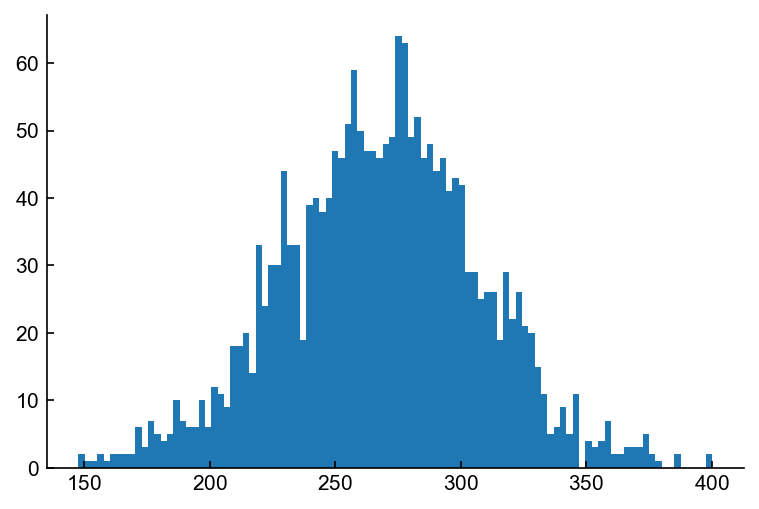

In [80]:
plt.hist(PE,bins=100)
pass

In [81]:
PL = [51.62456169691892, 59.232532572051326, 92.85083689778821, 73.26184842920202, 64.37592083018893, 169.0702160523122, 70.17798879347781, 62.75942140487759, 70.24114532419567, 69.28892222910103, 77.24061968437617, 57.95029517826912, 158.05016903244973, 66.61781586961247, 102.3805390000654, 83.22686817395376, 197.26620396653794, 115.50471004879516, 67.7425567265427, 51.6089287218822, 84.21894743540406, 139.2566334145415, 66.96308283787529, 93.23937624556223, 81.97413079724596, 133.81901164171958, 87.55058809526504, 87.12585045801887, 94.58293952703436, 108.4154421338937, 94.18018989059082, 73.79515056084978, 163.33692892389618, 306.28560215970685, 85.65574774174515, 60.899679392454374, 261.974819881476, 67.69443903361847, 80.68284765325015, 69.77365983697521, 223.53350758222675, 69.36797503404878, 62.19970245930335, 245.58099950637026, 106.77629261337542, 104.18935095324717, 48.13137404002677, 123.31877212566022, 90.93748524746094, 77.77141990306433, 95.77285909518741, 68.92961780771842, 68.830544378615, 108.54479392762644, 77.19734351009461, 88.1385638505664, 81.35587529889216, 60.58998978020942, 68.2361747686327, 82.34098640304117, 63.95552941580901, 81.79818821903794, 105.04012928128651, 62.53048282844691, 74.73581729173802, 62.169913752054484, 78.1606621104026, 91.61065755617221, 124.65292595631907, 107.91195057527905, 148.55364237879837, 49.452042276718196, 136.18622856043808, 66.61893569036938, 68.00396665248626, 70.23608200447603, 90.33843946268738, 61.934902384231826, 82.60350866986883, 64.58935358974895, 89.90665675821643, 112.25777294994523, 93.7372514270793, 143.33301277898755, 48.33472187296772, 136.33284760516156, 128.4083902208724, 80.65984946102297, 66.3313511877338, 101.59373996034786, 74.2458758861825, 54.688969620585084, 59.316226020863425, 104.39899729670483, 124.81476760524077, 36.763296343377306, 41.972452343439656, 82.96860019844293, 91.89675640377426, 225.05089673328806, 61.87475597464426, 93.81755910168847, 61.21667733604104, 90.21167721177733, 117.41665794224433, 111.39522555495083, 123.91407853807323, 70.28532816796316, 89.31117581791976, 81.54761896850943, 151.79359273625133, 69.8637179925179, 67.13945263595335, 52.761825365277346, 88.27859207529026, 73.63527086807066, 109.00462218633898, 87.98673933075337, 86.8327523192311, 98.64218475547565, 70.20680494747674, 103.68564346523301, 106.2727709630126, 60.99755411693179, 101.66274031559162, 127.14472033342604, 83.70330441695134, 124.23069794498161, 96.91306619281012, 77.32454521551668, 86.87655124573831, 68.68968158413057, 56.165357337900275, 120.35706701667739, 159.7489845583892, 56.618288165555825, 73.49212783523261, 60.952071278588804, 75.6533431906103, 137.71641766918682, 73.22305428225636, 55.41839354140937, 84.10843421293572, 41.80428763139888, 76.8771553499709, 57.68530196082886, 79.87265545907121, 75.47833078224576, 198.64480007333347, 148.75436202551361, 178.1230952882607, 61.93512989105365, 161.50578224161237, 74.75255243336875, 75.78152841050188, 123.35359754019827, 71.51920639724523, 73.07438683092461, 106.30165636437376, 111.98754485646172, 86.11337615787255, 76.56017156040922, 103.81510486687667, 80.9211153155654, 275.2061731967135, 125.4457380373098, 61.824533362138475, 51.52785343964582, 60.08445249748467, 109.00537529429296, 100.4918723095616, 51.589644250871395, 305.01386055411297, 247.0860545455338, 148.27349574650663, 83.49228797091764, 51.119974936097826, 59.44116326656591, 92.246350159138, 80.96913350370096, 104.37374146247389, 78.33228420598067, 50.30384946214222, 160.71856393057297, 80.35032303517872, 72.88338094611956, 86.02352084761414, 87.45055006744165, 117.37119463738499, 47.70757968510016, 163.85974426709927, 99.20795260494734, 57.50007091911022, 131.2826591056877, 74.5361708346175, 229.86866737958601, 54.38749129028872, 79.06983773166968, 74.97185244768914, 81.92506997185144, 109.92722937987183, 61.22294498033165, 43.8508955904738, 60.14978205203303, 84.46979702176964, 76.79649975088542, 69.6503914715424, 96.3453955908461, 97.8446518669917, 89.19251851162873, 83.0286792651355, 70.71910044609182, 118.1210132641504, 71.46589176430014, 51.97362621942731, 153.8811492567293, 124.55067344089784, 66.70791361518204, 62.60515371289087, 89.82354863168105, 89.85274208737485, 117.14970422981419, 66.27877806329464, 101.39162599130714, 145.1585735134111, 66.35335488538422, 44.1266048811165, 44.40883353947572, 70.3166712285706, 72.33722709678074, 136.93880300559562, 85.2192378920948, 79.12314190840664, 41.24387253250967, 85.34041789520398, 84.6715398330166, 104.15672213592178, 66.08349408159506, 64.54684525809961, 107.14446794869396, 88.57160429565998, 37.27857397785174, 101.31503192788053, 67.20791456449476, 50.82059783320643, 83.5633133750305, 73.44301486100139, 52.57080649876898, 137.94000335035608, 66.27457623091438, 78.92081762958951, 49.89461475956619, 80.01335871620859, 55.98545213664521, 84.33896944272232, 90.04365148570893, 45.27560213184383, 73.67856384511866, 86.25502979541886, 79.36753160372912, 76.85493031376251, 102.98656837232673, 81.71885055619958, 52.81033438197135, 204.13184595167357, 49.09853542530663, 123.95215954240425, 81.72538176576539, 113.12585651079736, 58.46559430855792, 94.6548046776489, 76.39481281683574, 95.88745784713092, 60.63006457388733, 68.38607087085214, 83.1649400809734, 120.98999183109824, 118.38261944917498, 72.8323801245254, 83.5457216509717, 63.28090400380932, 75.51355426294131, 108.0266691125105, 131.50623337595746, 61.77195136004001, 49.292813489498734, 55.87074808688499, 146.46459905958338, 82.73691604289102, 65.45187075949913, 54.40151804895544, 167.14814205180005, 91.37019466975823, 71.58672030549087, 99.27060806372403, 64.81666934000724, 79.33007416332454, 68.68372948682676, 53.185220415639826, 106.20769097723726, 82.24737498873887, 81.14027971934266, 76.95031094568677, 70.05429323134275, 133.27125891116054, 53.6731903945571, 53.08913959123487, 70.40145835429709, 144.21666002741867, 59.86329219451426, 128.7343400463027, 91.95922275099429, 66.97600999201038, 52.89689921255053, 45.91975398180245, 65.20365552340411, 88.25706519545592, 65.49738050170254, 87.50176130118857, 57.00793161638934, 61.30678827023827, 87.19803028984232, 79.85283531001365, 91.7707445262146, 76.0176409382706, 65.82806637712685, 92.53577016968686, 83.91559710900427, 75.25442961227836, 104.15381159438692, 108.80271657742078, 74.34767778123864, 75.65939207390691, 70.8678906433681, 71.61371019990978, 94.05568908614674, 58.4134589281084, 65.22933393430914, 105.45212838846929, 74.75629786435766, 165.73880271867594, 125.19041501077594, 57.58570728376641, 58.09145523914641, 89.57969221944073, 73.20463191990912, 58.55951108592941, 75.02533328541895, 48.26862329281068, 64.26935513169066, 91.66896386506464, 64.37465233570369, 70.95309008497526, 62.517330157592504, 70.27702330677516, 64.28245782923108, 69.45571397820336, 118.43094895569384, 89.91299699720662, 50.56801999220111, 61.33431431354335, 62.992574540133596, 110.63908697901205, 55.67896150539963, 102.27868339904353, 68.20183808625019, 81.58431181205027, 109.44465074938195, 87.22370170947038, 74.38769491948176, 65.1576137225578, 69.4191528400552, 134.7995187704365, 64.85661342987386, 81.14242674092338, 70.2381391580675, 77.57380697517152, 84.74236695123608, 79.43641488941614, 92.19675033657411, 52.19107959144361, 97.08884786805267, 138.4823795563574, 109.70946981840149, 49.46289432514693, 53.46002291283982, 96.34137329414197, 79.35708301308632, 82.9280493760623, 57.37040387051744, 67.8836970305037, 128.04890156340937, 100.62856199222996, 57.01044904465346, 77.50691837875776, 78.3758110322211, 129.5424273726618, 77.57031849682335, 76.31858674282672, 89.32688255572496, 53.909107217790805, 62.21466846584347, 80.17680797961928, 88.1785524818311, 121.56692925948235, 57.448827260695275, 54.11070333609929, 76.43107330610438, 98.50986532495065, 112.85008560157266, 77.22464350527511, 121.81165763912236, 133.5784780372811, 57.45548327532066, 84.93424720916647, 53.057853037023506, 50.45283000045635, 99.74573763084271, 164.34498140157308, 127.4288916190212, 76.937899291496, 214.95999232655694, 82.11677567408383, 52.52380726864209, 74.15718886217904, 134.65283765165057, 146.30600643704025, 111.61134049076517, 63.96672339626627, 138.6533975891275, 165.33922452880728, 116.28828650558327, 79.80895358710016, 121.812185997021, 81.82971453486803, 60.069119360711255, 200.45281423449646, 204.8999924139513, 84.34382136162039, 93.47119804973438, 57.76688458467346, 122.2319192931141, 82.28705930013537, 103.25886398024755, 61.79765480691354, 92.53257714500002, 211.29877440154928, 192.98469777207129, 58.93141056963894, 62.68753374160772, 94.32836336604491, 94.53741547362723, 92.93798847941416, 139.5946089702296, 95.21217137297492, 89.44119785819912, 92.75056723802508, 84.9983389957545, 74.55442899464592, 89.88742868956167, 68.84713060093, 79.00220302278278, 69.34189050666701, 75.60553674260262, 76.0236027223594, 138.1106972157204, 57.99013875958606, 50.80133785690152, 38.59428577987219, 142.21828059609624, 58.81984625431722, 63.843120667021275, 65.2742156906841, 107.32856563812628, 68.77739588513515, 58.10451157991148, 75.04763845803512, 54.60221700898151, 46.60739939832247, 55.02950115529156, 69.78051822856703, 52.911050100003166, 76.42906245494856, 143.94892311534633, 71.2060332460092, 82.35132201961233, 64.20477799836533, 51.620345871126794, 61.056839372019745, 88.07532219124926, 83.78962057779724, 75.67724650633204, 62.36431481779818, 74.55639051286047, 91.15020177162323, 76.98262957558333, 97.18643937251178, 73.66125826661178, 98.67115082095727, 83.96645564851529, 83.89312590491457, 81.82730008897576, 56.89093720494183, 84.09405467097851, 310.04820880745945, 87.4665430189781, 139.62150027150506, 45.49412160774512, 140.32148780149345, 58.217563300480435, 68.50575886606963, 84.01482037987995, 74.94013103669819, 123.76201376127354, 136.2407048624504, 59.54119925813532, 113.832443555702, 109.51042574363736, 119.70089837501519, 98.56738430482444, 80.72149082564991, 63.628393756027236, 141.55141994578423, 111.15598402374165, 58.44098526849491, 85.49145429315469, 95.46120160667519, 92.15794873913734, 65.96903507018409, 116.19943264343338, 75.24383913469138, 97.55718309303542, 50.70336730182307, 116.99999989570881, 166.27359789249, 72.1400940275011, 82.87922149712385, 139.7437739689153, 81.38044403654774, 69.47881838415802, 70.89945330341658, 102.73601619945933, 69.23948363324068, 87.9295416490015, 206.49524858295635, 71.97466089060705, 113.67646992174656, 66.20335439594058, 59.73907273307513, 58.34283360752637, 58.09112061769789, 88.94294456633627, 201.4310276284269, 74.84648072564772, 100.92620648710422, 141.18687997881617, 75.87662452426038, 125.25002189269466, 93.35267213475144, 108.7484054446803, 68.71422399292496, 127.05128071170671, 109.17844128527192, 63.276086006142044, 76.97609385587721, 112.85690575020188, 47.28765196132142, 64.04449499974517, 56.38538148133061, 88.06245501826044, 86.76013065794454, 65.45118756340453, 85.21701244864626, 49.04835165204621, 64.86653670639394, 116.50441772769301, 60.59934778650241, 82.16180427693061, 67.994289597468, 76.74928004106663, 80.05267088155124, 58.34067357038659, 86.46550079602612, 174.8870111421835, 70.07620006920234, 60.220436901510375, 89.73817665423002, 58.19235591371322, 112.33133254518516, 96.00411835859327, 98.98410936992387, 97.60332663341823, 67.494821980093, 101.99997240731047, 59.91368367745815, 101.44470014927981, 82.53492623568586, 92.02126667115974, 90.2067917618778, 98.7200718406948, 109.75040727060241, 90.0765429301102, 167.64501328221547, 68.6307991928859, 70.61765588566568, 141.95533831529673, 133.6945945969245, 132.79060461098274, 97.36113028677143, 62.54145011782287, 69.48069912490696, 68.72250705388616, 62.051806562536214, 214.28499546032805, 140.71994610519778, 240.75773492268038, 74.78885336585627, 59.07888425376036, 64.50574400750205, 68.78317419755766, 51.88576200552708, 120.46403797791292, 146.06194495958997, 84.72572321645256, 61.949993413468114, 92.06354136277295, 91.30793212340178, 79.09094703552955, 96.82447719662512, 75.51638593038143, 107.94325560880858, 58.181319058014836, 94.89336885693812, 90.32747880396425, 185.4994788635207, 50.63908427308688, 42.75819003536832, 72.28117010877284, 89.22836826274246, 134.3021439282033, 111.02345476017952, 101.86081362693233, 56.868924365569605, 42.07193133448895, 97.87257541212499, 83.37534954820273, 81.13627501984367, 147.186173116735, 121.93404297674493, 83.45421012918574, 82.9611796794841, 54.643225906015026, 94.11086843422353, 61.11650272219967, 71.45214306977277, 100.5881465361832, 88.27389694072896, 60.74446732869912, 69.25529127191587, 79.16912931078312, 99.79992300768643, 121.14456502149594, 229.12046476591468, 77.56583869607888, 87.52038255990377, 139.18329604356788, 70.42768835204258, 77.37680646904747, 56.940922235484436, 56.08497405155349, 87.32256761032788, 137.3797623635352, 41.7864555301677, 75.47992282719261, 105.82336607374074, 95.58693455666163, 109.0518551390214, 82.77928062026959, 82.03140503038782, 98.94290336010057, 132.35911975763537, 101.60307408144457, 84.93258737229287, 57.14673243885784, 90.15697970669277, 80.2271034182186, 54.222961971980986, 100.9005470433972, 45.37601614976324, 101.79368712026661, 90.9378202948571, 80.64430720052118, 140.1478168485371, 115.2100152708292, 53.43519355892333, 47.92336734926221, 52.55961070824816, 81.71862308120019, 66.89744419045351, 134.75000004530804, 55.418138730725126, 48.01671010147213, 69.74918109229117, 62.47796740471248, 76.14295254763502, 86.92380971474267, 65.14531913920788, 95.10298035545296, 229.17731245295346, 82.1698181712787, 60.49069170828004, 122.53756264992563, 287.4602659411435, 93.09434792379695, 79.80703649244016, 87.89252478645022, 137.08518882960882, 151.89909424160547, 52.55259364422611, 54.76740815079092, 158.99774754467438, 64.39770194185809, 122.9693486518945, 85.3011023069446, 63.61740538271858, 144.5405694372749, 86.43044637305567, 113.52816229337145, 129.0398502438244, 166.1277263240177, 51.05998015506879, 73.22660110973338, 80.02920685083608, 63.83525841708863, 84.35253537657631, 97.49683056802638, 109.71291356899808, 359.12229850342214, 77.6135280747595, 113.8828702033038, 102.46533350397918, 64.41993611814972, 47.9046319173896, 77.73811345723774, 69.57302456654662, 55.028089607824654, 92.09573161062596, 82.81946418984496, 63.53675572268847, 60.12409959606169, 77.73733652492389, 72.01008079188829, 52.371496555616, 106.62546518827831, 68.36243969071488, 58.31083502594835, 61.67379509658008, 109.28811207954826, 88.99985759067214, 115.857694737479, 54.8689939883796, 29.848427717772637, 81.17181834629815, 149.56056415823815, 101.71948759082564, 51.83029868254105, 68.35865189336835, 57.08719209783261, 123.43383223804307, 73.53046965365861, 72.98357596472057, 92.99620893416036, 113.88403791384997, 49.90520000246115, 77.58944942857279, 116.35218471671693, 70.00370747866913, 67.52263394867997, 66.24388531153103, 108.15067466178421, 54.34668339852422, 75.0488850560265, 58.02289787822112, 61.82963462169453, 72.94703911929713, 96.65361398237322, 72.26782476055159, 61.02645535478201, 66.87567016756033, 61.186629986374236, 96.45904784795084, 61.436875831579066, 55.04455286931594, 76.16787548078283, 215.58180716852704, 72.37089529984931, 117.94538869265091, 123.1433880264499, 103.99534824221692, 54.71371556159009, 48.74249108194646, 63.069747531838175, 93.81361481109846, 111.03882853461988, 88.86256436527272, 66.93226433137828, 80.12926306080958, 69.62241262752195, 47.50374906031904, 42.41881974745903, 103.45047530917732, 78.1731400206123, 64.40730206133148, 90.85143160708739, 88.22703624758263, 58.52348550616788, 91.73936516688593, 50.48510669253486, 68.77746669993319, 207.34747305521682, 102.56268882032045, 84.92020024359029, 83.21101200567674, 112.46095788435753, 108.9936006990393, 53.07068540960656, 68.63084641582785, 59.96145052355427, 84.41929927628073, 113.06686923226488, 75.01839939985081, 103.38010146720438, 77.25050485194984, 108.4991679304524, 53.22912021950825, 151.88290524523444, 80.94903128473061, 102.26527466721276, 93.23861598354412, 52.57399724681015, 77.46637570015167, 64.94348015967417, 76.20379797141678, 80.31923995263982, 114.51984148541793, 64.83115782539636, 72.48405364112216, 67.30468664856176, 67.45110256383585, 46.84830848034656, 153.2734908695919, 136.2707347275941, 91.78418081487493, 111.08959476496031, 48.755707886718554, 49.17207508063823, 97.47363764641526, 132.67159243761634, 78.68947386811566, 56.81805419596237, 67.2120936996925, 54.1182273812012, 54.425347814621844, 58.68365321162509, 145.77649313970173, 96.48027869443753, 102.22373267980215, 82.92185997074908, 121.92545688519077, 43.83517364985092, 80.82549497331452, 109.94650689965133, 98.24088544934013, 65.7244385828274, 266.73151774255547, 44.72245696729379, 52.60391734036846, 54.34897239004727, 65.40041003254974, 101.02845521498296, 111.14896955621363, 102.03603228532478, 69.46618231910409, 173.83512686552444, 101.57785638424002, 77.98910319841296, 143.22841232171464, 67.3078451241635, 92.2756322649013, 91.70018721815823, 84.58087483829257, 94.96416807030724, 60.38640390259235, 54.343967688283385, 81.43957553487516, 88.48809084599102, 61.73578633511858, 92.10123539029586, 80.70895302413717, 81.51395848030292, 76.34399683840667, 60.23012849605889, 101.76545178575779, 88.07285590340558, 52.713986241682164, 59.815575285118136, 143.03848196499254, 95.28808608132874, 40.40470694502097, 74.65707344398766, 55.036900779445304, 150.9373160733202, 65.88712698357703, 63.07711034380533, 91.94312449690852, 64.8143728634259, 237.96617845875545, 104.04984158437905, 64.56491955973328, 68.12952579314337, 106.72121605284885, 63.001811003100734, 67.71878815405587, 85.01524131443331, 90.20220087082785, 74.78628825740692, 81.34221475001823, 104.23905007688352, 111.18609389403751, 143.82720545130826, 64.99540982616227, 62.52443163721714, 132.2980275063103, 110.46646457092261, 93.89157577920548, 81.84301608558116, 72.256327864818, 75.71333594760489, 56.158607523125916, 64.10831390186726, 84.6485560880565, 82.07982371325126, 55.86064466114614, 132.18244984469194, 83.91801171166757, 81.26704419991663, 52.872917141013005, 84.4289912850984, 102.7359107657865, 79.32545927463308, 92.80446742000873, 76.62991056004749, 84.18733654543351, 106.55269095659594, 187.22984590489892, 84.95198453353609, 50.625072145183765, 75.45148661629935, 73.72826017947091, 209.3312337201661, 76.47055500268883, 100.50148936860089, 53.639152114698945, 67.43806732224299, 223.64214893907155, 108.69353155838338, 246.6944643334855, 62.06335357752088, 94.5803677246287, 93.79217498606488, 107.51681649191497, 87.69505757751953, 84.79746385201959, 114.60408331633099, 47.49759564654715, 91.12050727972687, 169.47191302312243, 271.98039098577254, 51.400756910992406, 64.12096559808622, 108.3012968403826, 62.98757588443441, 106.50625745764376, 107.0748977815836, 49.22600730924527, 153.0370727179472, 79.52245881511065, 81.34106760363753, 54.89669724626511, 96.23258731403463, 62.025659522558996, 84.46740207351323, 62.56033075260654, 78.48288248854708, 107.14263277234842, 197.79217681983096, 74.93538424350744, 104.21502832959516, 59.46340276880369, 69.84614340759731, 84.50990520219541, 53.584162220602245, 104.56022988489735, 89.17868634710044, 77.74088662432902, 58.049668121004224, 96.7115784412469, 92.1857233589061, 102.11004537053186, 63.41741924394755, 114.40032384993218, 96.09585081994152, 106.30174230656996, 73.88359184473309, 97.0521547021096, 90.52941447203375, 53.93176442439447, 105.08344584048837, 261.23867119805516, 126.03516706840439, 98.82908526386484, 126.4857406151063, 52.94827804903028, 86.22679231508448, 87.7091295165719, 114.07296814713492, 79.80059533335422, 66.48206892409765, 44.863590826584364, 79.95325056489034, 91.50832066787514, 145.39846919738306, 67.19075567703544, 77.88772066049219, 105.4448015922945, 122.91824098099214, 104.710204039723, 80.11144644675893, 99.6755044054206, 73.09326134061689, 57.82548051382665, 57.674697216981755, 161.52615402809886, 169.18326353107017, 64.76533438547406, 82.8473012930078, 167.8553149703949, 127.89123961509415, 184.05973083709196, 65.77082567201428, 89.4080398678374, 62.992608718830446, 89.11235239566045, 89.6130418290108, 75.37942474792504, 101.19310066059266, 97.96143190269237, 103.50679350148326, 56.4237717062606, 58.556540198309946, 69.98842919361823, 65.78013025110711, 62.43930424751298, 122.1438452670665, 118.64956051212361, 81.63717622600589, 75.09419475849614, 84.84041644304943, 48.35548752168873, 95.86850425919735, 72.03806597796782, 56.571470167516324, 98.64038230175534, 98.32884247071462, 130.05017325556133, 74.84235245846608, 60.435014434092786, 82.41426086601722, 67.85627013438612, 59.995582796356416, 75.98714111705853, 68.98995997535962, 60.95774589089647, 64.40641997228067, 64.28156442367107, 61.12967167849585, 84.79489625653599, 108.00370554063734, 90.26000782448621, 122.43299148621851, 57.01717354834633, 59.40806254999908, 70.36196442415181, 72.66285933197216, 61.51298455839999, 67.00641647397246, 68.32748456829154, 67.5198778375335, 91.3486985281172, 96.2072527667768, 72.39428030994033, 61.07991214478202, 147.97659061187173, 120.91846965897454, 72.48037723024204, 85.08450075405831, 50.022326838384394, 157.33670974065436, 168.03140240369285, 56.28009523347152, 93.30973115561844, 88.9550023929123, 95.10811372938285, 91.73981282535081, 112.46735508278002, 91.05370819100155, 110.23942896142198, 106.2653026989392, 49.1552149971327, 120.95842942817579, 58.672546237023475, 89.39630932444207, 60.77466611256651, 85.59668516852051, 168.12766508210768, 71.56858539685444, 65.71384549273587, 66.88245894817129, 99.21080749182013, 57.1779542042552, 93.06940430158379, 140.4271288407875, 80.64648952174844, 73.6039266329972, 136.15144643271825, 96.6716455084404, 53.367449904571906, 113.70562345148252, 73.02119273277299, 79.67698492459049, 218.10164043438553, 100.45972830439109, 59.85552780305594, 49.89327020490755, 96.91614861854204, 103.52802379589714, 71.30951226332525, 111.68367932740364, 69.69725097694963, 75.50490662366865, 65.57995437384216, 65.00449066194078, 62.52435612226401, 75.5339866494382, 70.37454456495423, 55.544626919117974, 103.02359584748586, 234.54920851664764, 103.97200423618696, 86.1383424869866, 130.85342075228468, 71.32088826878496, 78.56899853570135, 80.40352207394564, 62.94027069125792, 89.48652647382028, 96.48220197627383, 108.0411157771796, 72.42802947523232, 102.56248230572517, 53.36908162539985, 100.77299256927508, 85.48857455778665, 80.52820368932682, 91.94614256951905, 70.47639906607742, 182.0114928313962, 98.08279971848553, 74.24671367519227, 60.61213626840688, 78.69381327210365, 81.07731066499205, 70.72046987636688, 83.2883567663644, 80.51542770455434, 112.93754748606632, 130.2576598110379, 44.94097898301836, 63.79666398052348, 71.4071874429433, 67.6987213067461, 66.35727734300457, 71.25774110082841, 100.52504321504173, 74.37090539018085, 104.09600156649982, 79.4619237635165, 82.20944294710918, 88.91000984134443, 61.41740014215395, 59.81770316530158, 100.40696323243485, 125.19337073056501, 52.28705279870719, 65.4063398713929, 71.80793638012182, 189.53055432518488, 63.581883969304265, 85.92083192570442, 64.64957014845426, 63.83374362352269, 106.14431168701641, 96.22085418423308, 75.42424327334227, 78.85090761898836, 115.10806166351607, 114.70284560481278, 80.00095188369842, 125.02437528521389, 54.27055375574879, 63.54064184010613, 210.73444639459206, 86.22776204727904, 115.73809519644122, 63.01239337485785, 145.3331375861244, 108.05252082759534, 226.14540996415508, 131.484465615961, 66.83206395383957, 69.05257483076821, 225.7854060484277, 41.57095784000537, 76.999286346003, 110.77007717071169, 65.90921412601543, 62.47190260671812, 166.33866629135048, 146.41567452237425, 85.97444555393382, 141.2483163298797, 63.978072762636884, 102.61213711657545, 93.20279533534215, 99.51024948189344, 80.6835879014699, 167.85004225215698, 106.67236331686193, 70.57805255654159, 81.15260932993984, 53.987463141345415, 81.08409418757506, 67.89780993727214, 53.676357303822975, 100.69503965645873, 62.39664604638803, 61.67085346303361, 116.78901654849977, 106.03541668408131, 61.55923673536632, 57.742407995845014, 114.76979654217712, 81.22706227805993, 78.3148061923751, 66.17071364463362, 68.46074656817727, 76.20838862122565, 76.98323239797261, 70.81939691724955, 89.29480928134336, 89.48094636857427, 55.20439854164769, 112.78299727598981, 61.18836160369265, 163.0619462333291, 103.49106112439664, 101.43570369981768, 91.45474528684578, 43.8224175602464, 54.318790708394616, 55.92060840467168, 108.83250539633335, 51.82599109248188, 86.68962952137277, 110.32316964322389, 78.15241113910623, 69.79906952506325, 108.01247006788736, 86.64119655724753, 60.92767236350378, 97.01380236321377, 80.11021767890773, 47.321723941183855, 117.39143982448306, 62.47352783198702, 57.93998182968867, 91.90831405553642, 93.43368894145699, 86.24593692253704, 79.10933410054955, 150.2628025233438, 70.91366079726801, 80.98589948950568, 71.53514130464939, 73.06774841777519, 118.29275811047964, 80.44571503949615, 73.14961039566812, 62.059860732358075, 81.75127619893607, 48.68244424474763, 94.72948969408031, 66.33177622421947, 60.659886010156015, 88.96959257285059, 100.42383046454027, 106.60542706746244, 86.89612188846237, 72.85522280602393, 60.69181259741686, 71.84978594480778, 81.04733548450129, 95.5857951083697, 75.6080969492235, 64.87310120761389, 86.51144669431609, 125.60599572632253, 58.66027947603861, 131.15281233582996, 68.63382828904919, 132.12390596895426, 71.82529212252459, 83.15186220939414, 79.03395408014339, 68.23576627711, 133.4300441291303, 76.50226669438646, 107.16261164580176, 74.16177626707534, 169.123403491209, 86.3880240327392, 68.98598050864003, 56.78872243139618, 100.43841652719068, 101.16943848675363, 106.66266972928983, 68.44506381821587, 143.18776581903455, 113.90049654496977, 54.66631370890318, 95.78969988457682, 76.85459402936206, 270.1925968194193, 89.3577520066652, 108.85048221974, 103.52010831712576, 92.78027235103849, 77.92706908968016, 63.70893162951358, 78.81785866503972, 146.90742042098617, 61.849096530641084, 88.39191534430093, 113.59517913528649, 67.13432728191121, 77.74103819523357, 100.94758345430898, 54.416253711266016, 41.821637825977014, 59.54445185305189, 145.91063893147316, 89.21431274239906, 110.09808282285498, 109.10831476142789, 83.44765679110446, 83.49921942703503, 81.88682925110257, 226.8609320804532, 56.8972357338853, 84.41157338795915, 35.540722913332104, 85.13506393159378, 55.65739671672807, 205.4766362769405, 83.99817902765876, 95.24887863897087, 98.81256597200809, 81.00702916211114, 126.11906424157016, 131.94580100855458, 76.0071455113059, 97.45448932854353, 67.36233059448858, 127.64544907621837, 89.21870948594972, 71.42485455057209, 90.09232650003419, 69.08714121528558, 94.23685353808507, 148.70002803334887, 92.32886688800167, 49.875557132159145, 126.00582507009443, 99.38782258720522, 83.53121589921126, 53.82477693768136, 208.00605209986378, 102.24946160164306, 117.00120677968332, 61.77914270561155, 83.228127996934, 69.72638387179641, 66.63302082415815, 54.02879228232912, 56.62757531391773, 55.32692191336987, 72.99607118666533, 206.17770435587326, 52.352997969957734, 46.49025915053789, 98.2611823429985, 101.54029416230355, 82.74795815714957, 80.47660429214349, 64.06914924262605, 104.62664928415631, 108.45949154743204, 85.8149153844405, 57.77569626035031, 105.30692056435203, 91.67132889924915, 80.02532129149901, 65.75142606593135, 96.34499632544377, 112.71328393407781, 81.31000313939235, 73.78089920360833, 51.83994975891696, 94.36452841678542, 126.46240415575377, 98.03225724227337, 62.692165290363874, 113.05809811313752, 91.4896981644272, 101.26946649778183, 102.46719749529353, 167.4545481320639, 89.71569024765726, 67.23323607587974, 65.40878479092554, 71.76320658322403, 69.04295373061862, 80.77499247646325, 68.10048430457785, 84.77370896563714, 83.6370018953075, 77.99401489446325, 92.23387959358031, 109.75079201883787, 172.47163998558028, 84.62196938579434, 140.87277042941, 107.5010475894347, 78.85605683379376, 112.58710892469617, 54.16662292887579, 79.12283291977968, 248.5435283264677, 91.77170469724608, 78.38682604390625, 67.6575967387879, 80.82473994852646, 173.8599607450995, 81.70361692683437, 54.82449172631894, 79.68408825132687, 97.02300044007424, 74.27171704231807, 98.8752361224696, 101.47205675482684, 68.37761259255055, 60.34064242375947, 64.46332477893154, 93.85979996159894, 76.16575056932048, 73.12295842322666, 65.95640285365045, 70.71194338008367, 44.64194213125216, 93.78006070736146, 99.10567807845318, 79.03397887960878, 49.49197033845027, 49.00236938936282, 86.65763458110644, 71.51016939191028, 45.345558126448665, 97.60482087846455, 60.83957693593578, 69.34871697912335, 69.62917263851493, 89.79182246687618, 93.72083527272707, 141.65868681408244, 80.68688772367491, 293.1455473965446, 104.44639892039307, 39.35469507238974, 208.5567541357816, 84.52137473716678, 71.84826432038359, 94.20558725232293, 98.23050247014717, 86.0494833043114, 126.27269088635403, 130.11916303377131, 111.07191083539767, 61.18580616904109, 148.98721736607322, 117.43705279788317, 243.32899942325642, 69.09696391973192, 106.25826204974301, 87.71092803952692, 122.44765452219008, 50.48625761999528, 72.96839035411243, 86.78506201087072, 129.0599708056069, 77.65753809917221, 125.47814717996663, 110.8221916247625, 103.11044046055338, 63.410284690270444, 66.60808537634601, 96.23380126792124, 133.4721287032809, 65.29724907192102, 75.32026993860585, 78.91623656813283, 66.83333429964797, 82.7332325731418, 92.64316734467934, 65.74628504710229, 85.48207084791366, 69.28686763864205, 136.52636593403625, 45.19836345838554, 71.97551912884938, 61.08758614162252, 88.32955612782769, 60.69806183573483, 81.76522705457515, 81.94256408942412, 97.81931226012017, 64.41298158740504, 140.93312805796467, 85.76182736282566, 67.86395659433161, 48.53410626726585, 79.58572539530715, 102.58453171837012, 84.70552996441461, 82.3315145289018, 80.75594372437736, 69.9300160920229, 89.00926331911334, 58.80119268736662, 92.37102488748401, 76.52081809774766, 84.24354314373822, 67.3238156682677, 91.31402061743705, 120.54687752712577, 95.48387944842185, 40.121417895407156, 108.08877567463368, 59.31779896896005, 121.82002816720947, 56.45042990101086, 76.20949377269459, 70.14841459444392, 71.27674317608368, 92.85223897608982, 103.29447124830332, 64.46912297934034, 83.49306252851795, 94.69270800219655, 57.498222810876285, 110.47776959047124, 256.0499975614253, 119.6953601144384, 92.81328387177489, 194.13612362397794, 71.61631316920464, 56.33684342971439, 82.44577850653367, 69.573102014393, 51.310087804793106, 76.81318845618118, 104.57733935946233, 55.82523723687326, 110.90812633974919, 173.8678107741704, 104.8358123935946, 53.23779314854852, 133.652104449392, 114.38599326572502, 102.2399289224327, 104.53196602860177, 43.83802869394259, 87.43009110691294, 123.45282806564892, 78.3824457861946, 88.44127608334334, 66.03763310535838, 99.38269816522978, 83.06899437066362, 73.55159425296692, 79.82948025197531, 63.651879094961075, 105.30971686295308, 109.26146343440459, 79.59668174584225, 55.17358627774161, 85.97687788885779, 78.32207447535356, 105.88651588860095, 82.80549308443584, 76.89604626330085, 63.780211838353864, 87.30714582600177, 127.1626618056292, 53.72816043925092, 82.61732945147534, 70.74355365225276, 164.69557661305493, 71.98667073584497, 89.78267190940083, 76.2742378749289, 75.56988767088527, 58.790469058678575, 81.22076532484331, 77.02107455802543, 66.34999222682116, 75.87425439632251, 92.1313204667714, 99.71240131252743, 98.43561460769381, 94.4826309454391, 43.23714295535654, 91.47997778128939, 68.19569153006573, 71.42493777704162, 92.03221976718875, 168.64994888428558, 74.6416030032881, 64.80199695209522, 63.87380295588104, 72.47902812467136, 58.98393013037465, 107.74790387129771, 91.82547341554327, 104.45176789924365, 119.72550198859683, 95.70292013160022, 75.4134631744371, 83.52001139471489, 127.17544227358574, 65.98598518667993, 62.683686117664905, 165.93359987191099, 57.884576793182674, 110.7775125986509, 118.05720292749042, 134.62133647512593, 79.72291807160143, 88.63320723000162, 141.52006062366564, 47.91291280442737, 80.03492423552792, 139.46964777162813, 111.2828759684259, 69.95484244071682, 120.94945299160807, 80.52003953641336, 84.01410363987671, 108.13599661244143, 124.12422094399311, 108.97149134697864, 83.30315816648897, 178.0374565507981, 90.2999768953622, 162.6365449778385, 77.40526867245765, 120.01593743124289, 86.31363976590744, 76.43230575362894, 63.30835117324643, 137.1887385752379, 57.53706777454449, 100.5953465947362, 76.15940510487279, 47.8074299617599, 60.02622482958996, 58.471670485127255, 112.58464473742202, 169.40699503284614, 102.98255585833937, 64.1648218127635, 69.40690163777319, 80.936522853803, 78.32906074471367, 91.08055884552577, 208.64331495101527, 100.21531771782841, 70.29076597914933, 134.3972832481324, 79.25664968730936, 123.0398337718941, 156.42592838542768, 78.72648316238754, 250.00074558025585, 136.8924731564676, 60.443276355118236, 91.54320629807202, 245.03898114503826, 75.30860505010675, 119.41132789827874, 86.10003532704773, 85.78624218665932, 97.42282995317825, 73.10808135036329, 62.904116426605476, 44.57308816373785, 49.52030787943472, 119.9436288226337, 85.38273847215056, 114.41666683908028, 61.42923684054116, 90.1838929461258, 104.29888820396482, 77.33934159994647, 48.698071605579976, 103.56034014678221, 102.99618440566773, 96.30466574072581, 60.74202545602106, 132.86421250201101, 94.25173376166855, 122.20639533028852, 90.71282461384803, 70.47618039516321, 99.36911998730426, 113.31515433113, 76.51277874906121, 90.22725340127792, 250.99224818346656, 81.3586749750486, 57.69963995053157, 88.55621146530586, 93.80492516080409, 90.78045867761121, 69.78833472786243, 48.39471870987335, 76.8544997696898, 114.904862534289, 63.400031854366105, 63.91485030059221, 69.16826506634945, 131.94213266731597, 80.69968969535225, 63.34865044352719, 102.69998052935928, 69.9018412327374, 72.66988909520596, 81.32693989640387, 140.86231990799183, 82.66829944607227, 147.519284186198, 107.67966138250713, 62.108407566770204, 82.1667551632444, 91.4475498665287, 49.667556592850914, 67.6417989679712, 67.24466049796322, 38.864666748488446, 81.65970274334919, 113.3171926553097, 75.93738826901226, 69.48772839104608, 117.16177077400755, 102.11070576546629, 126.01707490748593, 87.40198970853808, 36.60228938039738, 92.76426724402447, 99.65196985180951, 70.36728977313814, 86.74606667540598, 102.27155327064106, 57.684954370982084, 322.8206364104764, 90.42409837357086, 148.1382699020616, 56.759036382342806, 112.20591988061659, 77.71132188001529, 63.99364167524003, 90.91123059079906, 71.35086637471429, 98.53719088350141, 61.39474119339269, 73.49543554002555, 64.59021978423958, 149.3437924531572, 122.9604510447114, 137.9076725479041, 139.34366918438914, 74.58091649138868, 71.51390346755794, 91.37592371353688, 106.12055871896821, 117.47335698708437, 64.49768849493978, 92.87577587077811, 111.67878840438257, 70.14802173242464, 79.25436392265637, 97.421306152133, 115.52903042024, 117.330673220162, 143.84279662197878, 101.31009832537629, 126.35499775245795, 95.10622976166086, 78.13985021485931, 99.41471645084937, 90.22955664888251, 88.95996674672152, 60.97773275334316, 93.63004646018504, 116.06141928544614, 77.93150633021133, 141.92062783096978, 141.89714254048056, 106.59089292485729, 96.8575078398907, 86.79284875460243, 92.9200849370903, 154.7543383909834, 74.42899924367539, 42.40901214080817, 77.10969833397625, 99.45009135977266, 74.27815812844241, 60.58646499339866, 93.0167414300911, 117.77113772912745, 65.2145753210112, 113.60578911833461, 87.04580755148052, 109.76402883363485, 78.70418726808956, 72.23982459988054, 77.79050919922408, 62.54135541003278, 57.798031939959515, 61.05707936854149, 163.77164652977194, 59.035176776040075, 67.9445685969684, 190.69063821075582, 82.18626506435879, 60.332353086601934, 212.37592715818198, 68.31379450736975, 64.93518806727027, 101.24391570421157, 70.76276770573945, 80.95527409528532, 51.820882047159834, 53.451628219725436, 143.35766524097116, 57.79333582021231, 56.650399691499835, 144.5258741118087, 64.04230219087529, 71.54607461968887, 77.9932647200147, 103.29550551250851, 59.67128075796424, 81.53179502997841, 97.01617669076255, 68.56650788513502, 89.10253806304252, 60.3177700018534, 228.32611251259564, 77.71739567527388, 69.55134202720566, 112.59879667390703, 152.62989165751, 69.2185543440163, 65.25597527638236, 82.87118554911487, 64.3200302880957, 142.44156810279983, 74.92036942175413, 75.23014466796073, 79.5313382097963, 81.817883820049, 95.66615575167638, 73.55915761985017, 91.70020085318427, 130.71830315851673, 115.00543784429509, 110.53763988971437, 99.18914848514406, 116.85335149262401, 73.88124904690882, 97.26609714063876, 90.60126310027897, 48.554942196439484, 72.4882769294688, 71.95148634374866, 41.19842671995631, 84.9726315194775, 72.55807796497257, 77.16208871079478, 71.14717287121344, 86.77575003204562, 71.41218537121784, 51.16664087156042, 124.99554809971565, 33.25106917802503, 111.81060365340794, 65.40041681756065, 89.70524829438381, 68.90492463397626, 69.50790017459654, 83.86794894415054, 115.27480827803105, 65.02604350731944, 72.67861236820805, 85.67289654408792, 64.75093625251922, 138.3837725614302, 44.129178169987064, 111.42213422062123, 48.907680595017965, 58.24597204569609, 125.19053494551414, 86.78142290023499, 135.42081785808085, 105.27554764612631, 112.7780404950262, 50.03689644740822, 57.57327910716564, 76.99266517511273, 152.24778784311837, 76.2492251383648, 53.004102541491, 61.75382818810827, 252.03055080749147, 80.51901554664204, 67.56813971120647, 51.24813858791328, 38.694748966466726, 75.64611791123288, 65.49911026643737, 93.82143116520182, 102.19587144770982, 130.60201608238984, 149.22365048944837, 199.92838846747804, 90.14737199641954, 97.22998501058534, 77.70336118546861, 54.12457168564594, 200.18742233718964, 114.54844529498529, 75.30742456018646, 98.44141926704116, 80.95774368502256, 60.04000848916108, 183.82608357904488, 59.07829347226981, 116.85473871761569, 70.56289149152826, 72.83256221244037, 69.52756364470501, 65.98504573818785, 77.81130507247398, 69.86678419066384, 42.47546209069039, 82.29517344137044, 64.14364993724782, 61.31831204358185, 70.5446146183203]

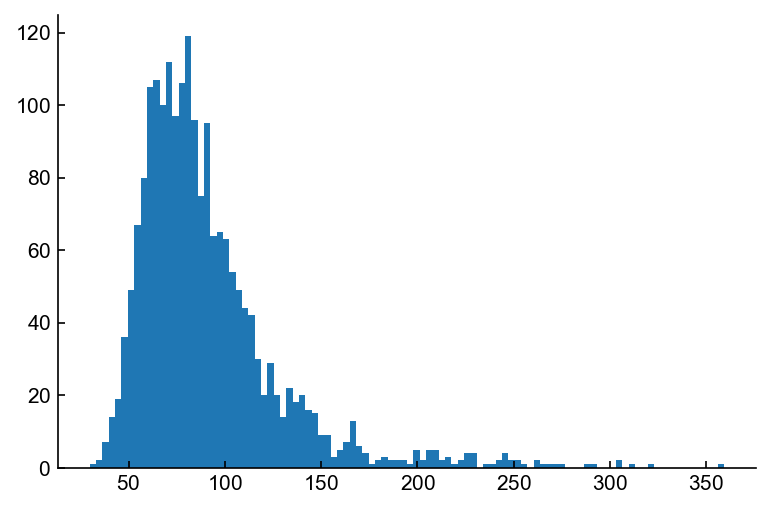

In [82]:
plt.hist(PL,bins=100)
pass

In [83]:
PEX = [179.40078133417381, 201.32835738229247, 174.8603892083664, 141.95970005526215, 177.8172896928969, 313.2489087296536, 282.76932915433287, 171.9123039864434, 187.06398852428703, 94.0126341657185, 103.75121743295986, 91.80776348483998, 163.1261709101334, 113.8926440010817, 253.69015648663557, 176.1815224313842, 139.5854936769907, 216.37454232251523, 270.75130829971386, 169.49395576873775, 288.4571704381007, 252.49182798433822, 104.56554623187138, 224.7623725255907, 76.3754066665204, 103.92268217378155, 97.63972478920893, 160.00723678005048, 98.82532459101732, 406.44092746332063, 73.83820756034093, 121.32082358141558, 104.5023142007813, 89.07489972293665, 299.70304394073617, 143.6111468164283, 141.40541906663063, 180.76863347545003, 134.2589135744861, 134.8183849061759, 254.61180131171326, 131.09432852378535, 176.09805497950055, 229.5988131680841, 730.2516000510626, 175.41491896653193, 115.95177582047748, 206.14219624447105, 184.8578696915814, 231.93649392165423, 181.71691461305198, 178.62428267519184, 134.70195292990314, 157.3126083798668, 100.84470854483561, 501.2433970852558, 178.20522642993143, 151.8350363982612, 302.4403115645201, 206.49656647815345, 121.07446344981648, 195.7729941782579, 278.3966031956941, 219.88134897551896, 149.58811985442597, 143.36464323325274, 232.6243290875422, 171.49028588289875, 161.68427359638633, 185.9231189760438, 230.67017533591618, 113.3755388441206, 121.48023271189754, 166.4331567215985, 67.08215271527787, 288.75046864616763, 179.17656652821384, 184.54011680085733, 80.65068823848247, 156.58563246790916, 127.29659516371677, 157.82132394096718, 269.7852107581062, 184.84699380143522, 248.536152173977, 283.01989424266657, 244.90084183225235, 96.54045815618773, 138.93819004233893, 235.57743529063143, 132.3495346285869, 86.3546601079024, 155.410219015643, 306.39930692557334, 195.14619718559334, 203.9872074347308, 113.13774681402352, 220.55986655314052, 82.86936857608416, 86.20989568290288, 131.8959549677031, 84.56128483782959, 105.2798151052237, 227.05153124467768, 89.03997213437343, 170.0017122669387, 103.76392412501552, 212.4084675014814, 164.68801841236152, 78.78495467285052, 86.0097814684327, 103.56611259746668, 450.3872180513881, 129.9709646803472, 123.31282241299819, 237.88788698315764, 158.282518084437, 106.67293953569272, 185.46163584754362, 185.3665194383034, 413.6979629947073, 211.98226455303345, 169.57045912395367, 293.7795125172193, 130.85464626048824, 151.85762204135875, 134.81731388370235, 243.7627535302952, 241.1383011151033, 202.35746233786756, 83.32931270459251, 127.5011107811299, 106.23295759089929, 106.4220936279103, 144.10364245850653, 166.98332991033922, 276.65625980026385, 209.86560342069856, 208.01862032628696, 107.0586492551368, 152.7925693061356, 396.8140472513912, 159.2946285683181, 114.65036178255855, 229.13607274161467, 159.8681799725487, 112.7155752047207, 163.06096782712396, 148.5190788496947, 146.15070461816538, 67.93339016230402, 69.67360295981254, 156.13623470329543, 236.99228112658517, 194.4036130350525, 72.06527547096353, 237.52200722090078, 489.2985272914814, 214.56032660236275, 218.6560934466408, 166.4019175042896, 181.0200895279279, 153.98074006450767, 94.47823144751663, 113.07344446567613, 335.1505467761429, 160.39582714897568, 335.3571446417017, 272.84373667698026, 268.0591778185629, 263.1838297364584, 151.4869272746513, 345.45869153131014, 205.64770271254199, 159.66498738122291, 92.07416608213506, 172.800838523435, 237.8439376025171, 141.59140771915818, 216.99463542399496, 366.48203291811063, 112.88370616081609, 134.74128949130022, 396.4005008481342, 123.24711349440582, 148.35741405014457, 343.1595394081947, 329.5460136806367, 139.762247357761, 119.15402967194518, 175.05983089780946, 107.98748256224944, 214.09841266175732, 167.29025973810857, 302.7923570911759, 177.48767572440053, 117.64967664483034, 153.93282946147036, 71.90450442874075, 89.32467050675389, 171.26818304061922, 149.99929223503963, 306.3302265967503, 170.29969344500307, 348.4591970868602, 128.90129619544305, 351.62799677131574, 75.98582554913824, 104.28393552694625, 272.53722774673395, 118.85214829714448, 206.7239346169863, 114.55535106891205, 151.00609974674828, 103.13875606181679, 110.94759773460484, 213.36891212410137, 181.4740430530669, 116.07982525945638, 103.96736546610062, 116.29784598152105, 119.11321685848675, 153.51975561382966, 98.42489899839828, 123.77439642455158, 297.2718120186265, 118.2653568985438, 132.9788544347461, 199.15774085387687, 101.97667694964929, 163.57755809860248, 85.9819237461208, 124.21794433516226, 302.2763476346373, 110.03077383639965, 132.82247433294285, 210.30781318789718, 154.94082818927387, 177.31119412924275, 136.40079869195125, 133.44839372299077, 151.83875058037484, 149.07130378781883, 146.14042107142026, 108.38219993688007, 261.823630406979, 136.07789623092782, 100.24607604875033, 146.1276636910357, 119.23080037237084, 130.00773844341873, 128.35143297219014, 227.24805118031065, 155.27853700637004, 97.55366307439832, 184.78625016555742, 73.67988308201953, 170.02185433577694, 85.8684551250151, 59.510463117944006, 209.08503870268223, 308.5717412683813, 135.00136128031235, 155.4504037090216, 86.13975090202709, 124.09974276785536, 144.60588201764637, 190.93535650481934, 226.76605789025226, 155.2888230907474, 112.92857134617334, 123.75677312103711, 136.5160757825202, 178.24524389402444, 170.3747308082528, 138.08849225834635, 130.16805110010827, 87.10761103633052, 222.90380447575956, 116.92008973632649, 113.87724188672854, 312.08889388153267, 157.43827987878825, 125.53762645109117, 156.0332221360387, 140.88472785994927, 149.79315831956413, 159.3315118995218, 216.766791415292, 184.72219326314593, 176.30476418699908, 161.5930682127021, 91.34890172473435, 197.60690568166157, 222.36629134936095, 169.82309179907924, 192.11557484859185, 138.60024050677728, 128.0557699739948, 144.2379944871953, 206.2868174196824, 321.4436072846719, 270.9870370979554, 184.89955584401915, 85.35698977188316, 163.62645121318235, 248.68838500696828, 274.0364298512449, 120.75551497081607, 221.84181576642152, 121.91341305434445, 176.32372130896673, 94.34026478205612, 126.79988282421333, 72.36340624107189, 97.23208615325962, 59.095559789692686, 153.57828385560612, 193.55050138084562, 295.0783151598958, 75.16640255778263, 118.33668111744417, 83.96504716144804, 121.17934816617021, 125.4325920805284, 146.72101630998563, 157.07060438830771, 84.84254644997344, 93.1511177432931, 201.7112181127464, 150.61097758584552, 239.8717892455053, 102.76775132888659, 102.10324297110492, 127.54199265802194, 107.57234660540205, 107.08388089067701, 74.94097966103956, 107.69295845201921, 98.3629831748226, 245.193582935583, 118.39827838749771, 370.0657546815593, 142.7785451303613, 101.80440608529106, 120.11346790588158, 321.1518108951934, 350.5319035059896, 324.09469409046704, 86.87126661805603, 235.23159307605832, 227.3317247776712, 290.1227681416321, 240.4783297432038, 158.45149109299282, 196.0664537065563, 167.3764743949692, 107.65198195335321, 133.8094505842936, 164.44020913902546, 216.67313238808032, 74.74487141549196, 201.6477331864861, 217.44244529358522, 173.68336176659656, 293.611851074046, 213.67508617452845, 83.8336077074551, 100.64376693429978, 126.35835962378808, 224.62885331154112, 230.95598168781865, 186.45266411349684, 250.10771796104066, 73.56383823514854, 260.25416235848445, 83.22793691042875, 165.53928715299676, 161.09363503242733, 373.93278379922174, 214.2531580612204, 232.7410550927486, 250.16629497652653, 185.5091976061679, 113.33532544022944, 357.5511804361567, 119.79418537040844, 127.90857167270413, 365.6181346041387, 119.07187308457242, 90.40466002647294, 114.52731441252537, 164.18992259631924, 176.61603085950702, 162.98155921387027, 128.59513224813924, 102.94318880210486, 68.1505252318534, 169.9949629483585, 99.76234707045705, 188.9409200209133, 228.94909745103254, 172.2281124145593, 142.5037364410435, 234.23815963170932, 102.33669183733518, 125.71836561357252, 199.04845510885215, 387.2089493172246, 173.21725089489138, 305.209465434463, 135.82285306132016, 106.94034425157308, 125.86251759188478, 104.11245328880409, 104.78139108582727, 59.89866610018728, 251.50198819085387, 274.75719679469523, 147.25374270757797, 101.2660257015753, 187.82717933758246, 101.74658759257522, 106.96896281727221, 234.53577998753602, 150.90734818488363, 134.32938460433246, 160.01273025320634, 133.20805194169677, 151.04093284699687, 82.10499001960923, 383.73695066620434, 239.24080031307582, 189.7840225951756, 100.15646766159479, 115.21227906411742, 73.23462378500973, 325.42177900872696, 214.0982098067761, 142.23548144704685, 208.0392324139085, 228.38255338259023, 105.46779425268055, 120.37905806256087, 195.10905512592723, 218.44068335752092, 242.74155698179516, 128.96839435720472, 118.51650938427277, 123.3798905928653, 198.19512577269555, 112.27926980509864, 106.21432606339337, 91.83547503982969, 198.65388295604, 249.6336728345839, 99.955715787275, 172.0243035901598, 143.33413243094878, 374.0130737066761, 226.65691600564358, 146.12844477128343, 161.12143255943076, 140.78510182020827, 102.82022169383511, 103.36259259750331, 127.49106778728563, 221.4655962051086, 129.01940053793842, 195.35297234550433, 124.82636913265041, 230.64921943059815, 81.42601110104987, 103.3647521135354, 243.8110504307418, 491.386414497457, 211.82820527199812, 282.3228743769616, 352.38289837591094, 144.3052059230616, 196.2762075692092, 74.4938895795819, 108.60060668626078, 146.4244089861936, 95.40217603995191, 118.14577068513442, 87.68421934190856, 107.53933899001309, 176.3542567976699, 107.79549270805454, 198.11135569987724, 220.9351622750104, 91.18608144357371, 197.64544255285708, 115.16961827192895, 97.3034738798907, 124.41169488383507, 111.16710850628832, 125.89678240025809, 123.0267755560089, 140.52165838613726, 84.23051974900346, 149.8684524553495, 152.12130504023835, 415.5280147317223, 127.8321739136416, 167.41220177034876, 114.24221885001705, 248.75290291647966, 129.99427473385236, 119.11887235266929, 159.12725060949694, 152.31516287898506, 86.64375149688166, 71.29257730756848, 96.53903942286853, 127.85914109192446, 224.76140882195122, 173.42507396261445, 217.20968795172482, 101.67148494312919, 313.883503697908, 113.6241534896493, 166.15587430473957, 91.75376479314856, 345.87590839652495, 247.76173387031895, 119.6122513352937, 92.28341633230549, 117.24798021727254, 166.46920374130627, 198.41155622182438, 188.42524378364197, 108.47848062768279, 112.69454720672937, 146.9383115383216, 309.8798360988138, 130.91754310983063, 181.07794198514523, 157.284935363271, 145.27661075325688, 317.7679882410615, 196.61470060125603, 257.72577583233004, 178.44643790189605, 125.52677158433048, 115.98350265595913, 136.4610079312091, 157.27906764434277, 397.1328276456253, 170.0948117110046, 97.30471898970967, 92.8484004017291, 395.3664695842056, 304.6441448330467, 151.11317107391136, 161.6949996942263, 125.86675976713653, 223.2810622183437, 52.545532710862894, 127.41152835361034, 143.71801153471395, 315.7520304543255, 225.31621649188912, 173.1181146412829, 152.6085293791288, 230.28615892796395, 108.07318350721397, 69.90638672165723, 223.87403094428873, 104.06014412376248, 213.07882622227493, 186.39736709392946, 125.49588962695778, 84.87136117385488, 183.44372516051797, 139.49977212684553, 152.45242575155876, 163.89944993344685, 215.89973904046002, 119.18725010790521, 191.22324849937678, 290.4561724328398, 104.54153856773061, 99.79723739347261, 130.96905434074472, 294.8611021134632, 132.81820928548748, 138.25613706230084, 287.6059307609514, 111.5606277308108, 410.5386391544636, 154.95707810208498, 148.17203021884146, 134.19372777002167, 182.063782032812, 109.6635093620448, 82.79291886093321, 183.74731166378845, 195.6613660231228, 158.99973313872485, 95.22097149745763, 214.0427820820997, 92.35316644847717, 128.4274957072699, 134.44067069127902, 100.42398173459877, 359.9328495711463, 255.39964002683084, 260.70937795333253, 170.4036827195649, 259.3060429436184, 298.10461397927605, 87.30547933965528, 179.77050831412697, 171.93713789189204, 145.5539768813981, 141.48482056473077, 122.70649861637546, 207.17366003232593, 183.75968572180466, 127.48602332830444, 254.31746793901382, 116.40838005796189, 208.89039399978276, 221.61502777292452, 75.06767899057742, 146.92961358789114, 100.9635467093544, 145.92134583435637, 117.55997513831397, 590.3985498408158, 259.26991536511855, 118.58698501821088, 173.0092833400173, 88.03457933163237, 269.3138194657936, 281.27763940406714, 158.3522845212232, 173.73584685886718, 89.11665688992214, 158.77170601800233, 145.5302333524201, 138.33345939420397, 163.84583259029674, 152.0605662077086, 187.911712505638, 106.15224650582256, 246.6846888533707, 248.585413985912, 151.17652366718585, 232.46185690469304, 174.15159094108444, 152.0450095129169, 71.47578768701547, 218.8740205831613, 114.07449061795982, 234.30767728109421, 233.33293347898805, 117.69882892075123, 130.0939113718199, 281.3594574322553, 154.5882733060647, 257.6783985789333, 107.01275142084233, 184.0774712197356, 95.4285084726159, 181.52598685850637, 152.64313033876306, 363.8853551619862, 141.65848568197066, 242.63610164290907, 415.3622698670766, 100.54625590855825, 139.99811356501448, 187.15873128933615, 104.64221995723383, 139.196844856044, 295.9910595508929, 73.10232931052528, 460.55173623104224, 121.30079622647902, 185.38151077627484, 175.2912462623222, 196.839748432518, 318.6397310970237, 109.29942471662288, 436.2583889383798, 131.62859704441553, 83.16889793009227, 204.91217662771282, 110.44146736713492, 171.42291230638793, 74.34447724290513, 244.37833549902908, 140.6135163746542, 126.35339245931742, 115.60821238042145, 162.20023116107902, 401.59383748264526, 166.79257633404677, 138.21870199557154, 145.59959719835217, 264.36522919094955, 289.4351484048987, 192.94201453089244, 233.98088465748438, 102.1534875731564, 188.5734209285417, 146.59239001382082, 50.56461211552164, 121.0970139258793, 181.9472896608268, 338.79596986936525, 122.07821113305486, 292.0727403976171, 129.21662335994708, 106.58632283985224, 302.5362706837152, 126.12912609228496, 102.8854040182386, 91.26903525560357, 126.34091680756744, 251.36517627450118, 65.37788594973263, 185.97966486437704, 167.4986958129406, 431.09463786729464, 127.78299428645586, 174.67717945939046, 112.84412263984721, 223.9205091137743, 152.20326865867204, 268.8602134828182, 424.6107242574671, 137.85581550069023, 217.67218636248563, 131.91011281990666, 193.39646727409811, 162.84967293844906, 116.1953121674579, 286.0559388507518, 81.2577020484186, 111.50110982816577, 119.90640940418575, 131.2621130730634, 79.76320806508042, 62.62951865368757, 192.6995389907395, 179.17253140695948, 203.50026699247223, 140.3466466335484, 186.36489866203078, 121.07735373653233, 393.46392667284243, 261.87146729218296, 228.61265681157167, 86.28617596904029, 142.49005324554855, 147.1270938383897, 241.39552169093847, 199.0556561142355, 354.4045590596056, 134.19492748950327, 115.94876644486644, 164.40539711009748, 324.02413937061857, 102.90995019754607, 132.6727503574411, 126.5874347827952, 138.16977815168005, 197.91419142834675, 113.42710700457862, 217.3462834998444, 164.8206836989899, 103.76446106324308, 158.28819675686807, 158.85080189266122, 191.37956445019722, 131.8676789336713, 222.93532089388543, 110.18070254173314, 137.36113698271458, 94.95112344975168, 138.07461969100305, 108.45401145342558, 284.9657135688036, 182.14983303247286, 374.5951565657452, 188.74394489993077, 102.79221229975053, 186.43641359640907, 99.74046331382856, 162.38406266894475, 93.5724183229679, 109.27322278993708, 137.90215140626034, 329.2803561523389, 176.86191298889003, 247.98058997896734, 157.68382742645005, 123.69873081942372, 130.66983341910236, 115.71288466355126, 306.1868615170992, 87.73554137790619, 230.03877355760451, 98.40348953645157, 96.56858827170707, 118.98024242581597, 94.78417459301855, 96.42993937982155, 419.36685468282514, 145.21738336316304, 120.71778506687272, 83.2244377554038, 127.73522147163116, 96.92676418301251, 190.46513863906353, 96.58884638385013, 141.30994360480707, 102.02215037269892, 277.29218587597677, 193.67746457749425, 148.9553782061624, 112.91496581431588, 212.2190745408933, 70.55499732878658, 78.80890537368697, 263.91395187259445, 130.8437094511343, 99.975965780354, 346.2439861348979, 142.03620089033117, 87.9609949401624, 200.75437044274378, 314.14761515361045, 180.6426431841451, 147.635303480908, 129.20931146316977, 111.21681314478502, 95.464775039989, 107.96987724917594, 204.0758638213114, 152.66302278071902, 167.24137304194895, 136.39316027902188, 138.43545732232408, 125.2626660449539, 125.29500611262839, 172.96510377248956, 340.6576038370283, 178.0277915010424, 213.97956346998106, 97.51221068440468, 211.04406209623804, 90.0736810659831, 103.93125132335595, 118.89164404360186, 141.23052232678975, 176.5342018127872, 181.94333323760378, 86.3758861595663, 108.92071563491368, 101.47819433116338, 205.52351251472012, 207.37926303739158, 145.06129154222842, 165.64231590037346, 120.63719713950805, 138.4810626164776, 195.99693192528792, 124.12643721719688, 106.0520359560405, 297.0858316308171, 128.18993277969992, 313.6350124916686, 208.15847238801524, 152.38969063149491, 132.09463838161025, 122.71787981300449, 171.32285217790863, 140.46824974148072, 147.84627722159055, 117.04402405900343, 116.61184562507243, 177.02168403243778, 166.51385509128903, 341.98891206419023, 97.46916758904, 339.29685220090437, 163.15124396743659, 176.00914084685553, 254.64861961011866, 139.011366288684, 78.57445774329781, 87.96807765763369, 107.35315768948217, 304.0335752495671, 102.38788010089873, 242.21446860013705, 469.7606265936056, 100.06732745074959, 109.75010155003162, 270.4605160312286, 193.70622575022452, 116.3165081006478, 260.93659740925096, 120.53737883381783, 52.04752533508085, 93.12290982373014, 125.43005143429943, 94.57890724409147, 209.33252324446613, 128.6428703373921, 186.29770188094832, 167.11151320434973, 117.27040264163661, 154.31081343601565, 137.2180465101793, 132.3251629693859, 67.23181225225957, 206.89252846957842, 241.46083483459907, 57.582013747309865, 115.45830734621211, 126.5565184221225, 76.83834456304858, 258.6128979679559, 85.39911005271149, 167.95999909564398, 173.36679472751962, 230.09319889026014, 78.26285075583654, 408.86001976616154, 300.16049701350454, 168.95033880089036, 103.71677485998649, 119.7387198699243, 143.30379055503406, 232.81913616779764, 91.93934746508036, 123.62961193083609, 67.59693765834895, 130.34116104289157, 359.0108751329166, 646.0274017337855, 174.57903277961427, 116.97271725217509, 131.4530918953563, 198.98939396726954, 172.11639031780643, 145.34693167806822, 308.47619726317254, 100.42969955693833, 97.67679797289479, 259.68911398222014, 298.37786152111136, 140.62867199497978, 106.15608675701671, 106.14900746999369, 531.3839633982701, 127.55562507841631, 154.21690327402035, 223.05711140585623, 122.97127234952076, 118.161048615191, 121.75772369316165, 122.81507799386198, 87.48838332376812, 165.18238154333469, 94.941145515119, 86.25362428694802, 86.41895533196242, 83.55986637398037, 163.73018118396857, 199.51274670680783, 109.07740486905367, 145.24745273384517, 147.80905123011715, 108.34801447066128, 212.3787422776238, 74.39681440135435, 104.217140645014, 252.7509520115093, 138.1274041216809, 312.4628016762675, 286.67210491058154, 109.50251449947064, 266.11965632177447, 267.02192786921427, 181.71590646872843, 161.67429799806945, 149.78948320518464, 359.50381875193636, 158.73048344655382, 115.55540194615422, 157.39294386023104, 123.06958975843558, 188.19014019306348, 78.83501893686868, 127.87572027666964, 305.92713502015954, 80.21001348438787, 158.36492888233266, 120.5911614676665, 267.10797626242964, 144.02720960053355, 158.4553026174905, 240.91866322466362, 114.51513718158284, 240.90628620410877, 452.51586223074173, 264.39650060462253, 175.44460051077021, 220.1004852006098, 370.9523856779631, 378.19701067749776, 255.44037998306226, 122.68457630038866, 158.5071817174397, 125.30083429046189, 298.4285310909322, 330.01192041292643, 175.7611709105811, 156.25575263161937, 137.7360671047269, 187.7880447643544, 187.37843641278175, 106.79154671490238, 183.72010669212247, 76.14780610844988, 190.41161193297788, 113.95549227878938, 177.6220462907096, 141.27992367334969, 559.7579264915267, 122.5473602748108, 206.75123751301282, 179.0367081212341, 169.41240604136223, 170.30011449773585, 179.47801415885965, 96.35050075798186, 432.058377648113, 204.9661048536535, 122.21070483088712, 357.8959709035593, 139.67031189993799, 140.10015346820785, 196.84472435542176, 166.43168051094645, 97.9822176753157, 248.4195278535509, 164.87513064056995, 238.57026884622772, 201.87282205966443, 133.1146280406691, 219.63009206947916, 221.22728808665698, 132.92490374342665, 164.5377811690041, 129.2627184200703, 132.40611415101765, 123.51082399064813, 136.38302386289428, 122.37757424225109, 116.10264767747691, 133.70262374000552, 160.7355648880103, 308.87763216377306, 94.39457715753487, 435.06705964995535, 93.43999322160936, 93.35922581582389, 142.9455673649784, 232.58344173021504, 218.44965179209643, 196.1623511738413, 345.7359611605338, 318.0920768912667, 155.56405990047276, 92.59308318170413, 204.26839653053878, 457.6740018080587, 300.1170456243779, 172.06584282118484, 118.46384827403482, 150.9544461462631, 345.56174191047745, 300.6910134946121, 145.65451336046854, 161.2139094946743, 130.0589350129462, 142.80668453508125, 144.53408991858709, 192.43021328095602, 169.17093830305762, 118.87921913797177, 100.74129710547919, 103.18747322841206, 132.91123918969328, 89.55086182697757, 189.26069961701742, 562.8868255747534, 191.29772452190585, 460.16819327623125, 124.08001718732473, 229.381654399607, 549.2863180838029, 100.88383087607455, 181.00368177543135, 235.5601937321067, 147.1325354534753, 249.67936226662775, 329.57029074993994, 179.2233276891162, 152.7920989868577, 279.55044331046537, 153.451975846411, 103.9172656857361, 143.79949736277345, 203.78522682153263, 92.9333950095582, 174.67200088402092, 115.42822485908522, 286.0051157833175, 158.34915908122866, 94.8823922955011, 241.18556325580195, 351.2866505994555, 98.89017682510337, 103.30980315391545, 116.35610084208835, 104.25417305393034, 99.01282233687049, 119.00020531072838, 364.3261317101234, 109.36985625589813, 145.0215209233131, 164.42235309295012, 98.25369128889484, 136.38514206916867, 153.54765311191878, 208.3527144580653, 94.98034360070729, 236.12158559386364, 149.50634569336145, 149.36810761897772, 111.3487739329129, 210.03882581693784, 192.7175216642782, 365.49927508482875, 202.87912944893694, 155.16085170680614, 302.4195138429675, 241.5757909205089, 209.47043947387624, 112.18946132350484, 72.70614903200645, 161.148307560396, 114.68865334349073, 123.47351814808583, 73.78117924799427, 200.7063679183716, 139.23648012844433, 81.46169936917265, 108.95444820464873, 133.02084419540714, 381.47972733587414, 97.32146879168735, 175.71145290210742, 138.18813488486862, 85.14822559136461, 177.2299869916527, 217.03157424165346, 125.89669642124944, 233.60982850362046, 167.7231104157642, 195.5881586352574, 208.9388975338089, 170.86766718102686, 197.47937304665822, 374.5242295158506, 118.18577242883828, 330.35865925920154, 141.67853541582397, 86.93147741430157, 99.97708541230496, 116.34952825010168, 116.05077559656466, 189.93887586567604, 106.66877434637543, 118.29142992565482, 108.52433489882831, 112.99729962894422, 176.30717338150478, 103.52412281558311, 274.55642472316845, 95.80011762596624, 200.86991706194172, 191.69274991767045, 145.4001544871862, 85.03163099517516, 149.4365216017398, 152.72500504381688, 92.88432322511603, 207.97325130537578, 111.113711467958, 105.21127869561057, 295.31880027186276, 113.4454408373463, 103.78274993413363, 219.0374973195683, 179.00522156472158, 136.45158167069042, 64.52749481585083, 167.55904465979486, 118.78742897408401, 88.88783824842302, 98.50775338372274, 101.91761851298399, 126.12197918948605, 261.9997298493887, 155.58802975415705, 102.58925512777844, 197.74144373484035, 184.34156344763244, 241.34956413485898, 116.88901108883735, 154.2953819141704, 97.89708340024421, 195.20605579435124, 199.05013803912007, 239.7568884287171, 127.50269871865159, 277.5865297590116, 117.3976248155543, 74.46224923905946, 169.78671277791454, 103.57633651098865, 116.08129280705384, 160.78886856632747, 374.65806740576255, 266.6054905945278, 135.47097994999194, 129.73423052040974, 104.4586076393588, 211.0741055315915, 349.182395968395, 383.6051750230719, 633.4356235722657, 347.0277834339995, 191.20863341611462, 442.13110458347256, 263.6543033405561, 137.56799215228847, 139.08483878710553, 128.57968941229078, 155.2940274848335, 293.51328783208714, 125.95721957426846, 252.01384345387936, 133.15086067289462, 111.22173874687964, 318.5855659250094, 168.3813964761762, 127.5719670444444, 101.91010216357014, 198.3286994316734, 295.64381949284865, 120.83694142395538, 162.7858095424963, 261.1942128550851, 121.52002749944832, 191.09237853388854, 186.99229515362478, 132.74182445564617, 90.50655358526983, 63.38228921047739, 239.26990097575458, 151.47716356657818, 189.43472089818295, 178.29743716243783, 447.8576573113438, 241.12114867613266, 287.19151873674963, 221.06971450357543, 208.21240048072949, 176.65067488529132, 63.377872263922725, 209.70967737732883, 140.6406798712063, 423.58166497722976, 57.39306986303154, 126.02361835491487, 100.28807760346473, 406.30455441112355, 333.55120792617845, 270.44556418475486, 174.19440798369135, 120.92322598256621, 179.83343543183344, 130.48568572439157, 301.9758879295955, 83.35143030303877, 135.06398493750928, 156.33102109210733, 185.96970742056425, 130.33970503664202, 212.0457552351612, 135.31793868932368, 387.52544787051363, 346.94410409223264, 148.3395045623181, 174.5188682255777, 292.52963116403936, 170.54646410834445, 126.36322480752591, 132.1134687999756, 239.496352604656, 102.00198864089681, 145.95139611753007, 286.6214638942942, 184.2309470611024, 154.95851485237185, 215.22339826732588, 78.43475538851895, 119.85555073235847, 184.5618002588376, 172.47473334467946, 197.95083465973946, 154.99599567815952, 104.68580773087741, 117.36697218781435, 215.3424117119808, 99.73680906046087, 216.96502888761248, 145.08401679612814, 285.3318227513591, 189.72858941739133, 154.33515757264726, 263.58965840256093, 80.6836340504643, 85.84781540187574, 144.75022566989156, 110.66205405516567, 212.3394772830803, 156.9390107488632, 361.0716578547222, 104.71610610499697, 201.26808730850834, 132.60013754438447, 79.32498231129254, 120.9972044623841, 147.26110023347587, 242.35323119698032, 127.69160570454586, 105.39277867892106, 226.7438344107508, 203.7334850667084, 84.11176319369622, 166.95480957734426, 104.88193461679099, 236.07140785304944, 114.84724202874426, 192.83641346455397, 185.63977985010084, 167.87792086267225, 107.57676185659581, 343.4682500884368, 82.14755580108692, 135.53565416789974, 92.99184686325226, 162.33841541472162, 161.4203307834165, 105.02214429338633, 424.612433848231, 153.40535371759194, 92.90503645680192, 199.21073236938665, 120.83255236566619, 101.58996171137048, 218.44733190174705, 107.52721648254251, 87.11686383225248, 304.75396537092473, 87.08976716241928, 143.4438066605358, 288.33987798911716, 137.13836816834768, 245.89843455899762, 180.1574002833363, 189.47756420145126, 261.7343815330827, 92.47692523811286, 152.93552030262512, 155.5912005190712, 178.27086535935095, 233.3731726446669, 122.93797525093163, 89.9395605008874, 229.18107475993054, 169.90492243675507, 169.49178456179644, 117.42852706269926, 206.1608291855661, 121.90073529754729, 152.8817535222299, 107.97556184882458, 90.0356439041636, 251.01529227650965, 101.2178626888848, 126.62193160099423, 111.63200171351589, 190.6844748592599, 119.91988267489877, 100.87825485026553, 316.6078179945964, 258.38454486604974, 77.8087406043539, 133.021477577566, 93.35825193282206, 178.772513093253, 211.0765545138444, 133.05427829322772, 111.10786671874213, 134.94790903988658, 186.95879108928338, 176.74507109083905, 136.2859629702763, 110.22399514163352, 109.45947526429396, 351.0786000791219, 107.45842376364448, 211.57741033810944, 120.38817778928004, 165.23094114180716, 264.8274035866172, 386.266796662168, 117.45485869383539, 287.52953126626517, 89.66235335849329, 122.57214981984959, 107.12858050121916, 96.55243534056939, 292.2786165784133, 110.29276037991959, 111.80094525747988, 159.65294593416027, 129.25802477502035, 108.45269326449234, 129.1369415207766, 129.14057393882646, 175.02874865954456, 82.09940901993973, 123.43427878791103, 272.95047474505014, 74.44352690531825, 79.02569211694106, 481.65367315981786, 152.0783705537009, 256.72509458112955, 125.56886409281034, 148.38781645196443, 119.66828400790993, 296.76821123013764, 149.73766011081247, 419.33904845304346, 119.59186681768617, 287.0918060654356, 104.959509586759, 151.6178278200508, 121.86428083668213, 164.9018769078406, 346.5261678491952, 142.68410361257693, 108.6055297141275, 127.5382908513782, 128.40802199915152, 94.10638319335207, 163.59719087358724, 154.47268672704777, 73.68177958122605, 111.0307097767172, 300.3564731756977, 170.68358333872655, 126.54947298242428, 92.23174466926993, 160.3080866770428, 152.26933732997296, 123.62146940516037, 323.0559756691203, 132.35237180710115, 99.07781032347187, 233.2764651857114, 224.53387781452076, 250.14600278778795, 195.14008654487697, 364.00391015178957, 115.17875534486434, 121.3667850838001, 222.1634195132225, 239.1143429973627, 245.93357787307596, 196.44279625679738, 121.80356452729079, 159.17666378979237, 167.7653045787436, 197.89154912478378, 135.85352139929506, 118.26269685091216, 61.353778369503296, 145.40480914153804, 122.95092554342706, 89.02351897906165, 98.9990550748278, 102.99874045281273, 220.67658046778985, 149.52498131920117, 108.40886225205779, 111.710761081691, 133.25141850998114, 119.27849321401918, 400.7619414129137, 132.13625244953104, 327.54989923424847, 124.20708789015838, 169.8285450336207, 199.3779190575856, 331.78440792865405, 241.1381465047608, 119.34814582247824, 132.7107475612047, 178.30412027462228, 125.3818800565621, 380.7859836149977, 84.69584485474977, 206.5451598085347, 92.5366826385374, 92.18619866681651, 231.64613844964833, 201.3552529597909, 422.77043710903905, 206.2700326682714, 135.3866013857919, 165.80724449265063, 182.09798119669068, 101.99950527115789, 263.15871622691833, 163.74959773748606, 117.22904954814442, 118.250132049788, 187.3536444859805, 136.5931240027935, 267.33016394699786, 156.44508436170474, 452.9302446421233, 280.3201370545916, 214.36096655101687, 201.822931712602, 231.47906846583936, 165.7888372523641, 134.463843771799, 421.8959190187997, 290.8180911417541, 112.96460315414916, 330.77191211464344, 89.87866966438047, 326.6532915098607, 93.0293443461992, 137.83799134100497, 124.19014148729956, 100.9337773223358, 92.11927916076388, 243.1981550117299, 65.69034548471042, 121.06029900555873, 293.0430414000697, 150.13956072654676, 234.3147121813725, 144.04876503432175, 199.36859564263176, 157.89467843516218, 527.7148388201551, 127.19790785792571, 167.61688192237082, 199.98959865106522, 138.66676459708526, 138.70139834614048, 256.2563397693795, 133.33100623505294, 612.764191729153, 109.47314826376909, 183.0612692350562, 168.74763258292444, 219.44015857348776, 115.31966987687414, 227.21785549972412, 102.37134423973907, 97.55081427144724, 185.38083533182999, 214.47801762268227, 327.05422996878946, 151.5779242765839, 119.16738102981984, 132.32637208584015, 127.36291087533382, 195.69433887450353, 176.14713671870788, 262.184847136554, 174.5978067141144, 134.5374314004063, 140.80021680676685, 132.76839831916337, 162.858407739318, 189.09491062501004, 182.61536527159365, 164.05987045510258, 340.8648889711112, 339.76431192780313, 334.92431044996306, 157.18385614460115, 140.03682632430252, 130.64703127903167, 150.77822556838507, 347.3301801019842, 234.1079454245837, 145.12817787500597, 151.45078169858223, 107.14069500909416, 202.64300948402746, 127.85995321190666, 449.1483639857193, 149.09870667925398, 108.30136873523853, 132.685671769766, 149.18231871950678, 178.4726431230212, 102.86342536526723, 103.19750648127204, 178.53404835536804, 234.2698852429962, 156.72944689708027, 131.01561532157356, 120.40079613678648, 208.46705287365108, 156.027945846279, 144.36302601997096, 51.09489834745138, 123.51342442458231, 610.8949467594573, 202.78398384385244, 234.69414380766847, 185.51259312278924, 114.02270740878323, 126.27568839964594, 255.60406708965579, 208.2766149881429, 167.74414477936074, 127.12224860873049, 188.28750667880178, 98.85442320860224, 100.79736988942585, 317.2778151906626, 412.00406242124427, 87.68213024918103, 255.89866306425594, 166.6996967674928, 124.27964737269623, 166.9392145715668, 158.06169962257886, 228.76614148684845, 210.84800790983238, 94.16210291704937, 247.82714768765902, 103.63572404686656, 141.36217414307114, 102.32100168118772, 134.68519630345244, 79.32963046829406, 224.10445717281823, 127.45989153839345, 144.29696909104976, 467.4708319283357, 183.23470693656404, 84.51429652477181, 174.7112054589009, 144.14640909681495, 87.03494661802752, 185.5887918718967, 200.4798013945505, 273.9774705675188, 122.36166611684085, 304.00642968773184, 123.94158119899556, 99.82298921815982, 358.507255944675, 186.48545456761212, 129.75702419213124, 558.6678637251421, 204.48493643920997, 111.14315044623538, 199.14089166329512, 146.08829199204868, 156.61735923258726, 318.76508623132503, 148.88805855707662, 226.76926916453536, 86.5787860370838, 141.584047088332, 64.07497036151862, 223.7694554660087, 243.72904796914673, 111.60978618806435, 442.9803265187876, 242.87691410784387, 134.68111617091395, 107.87594336635331, 283.227522181577, 315.2580183469994, 129.79388131617648, 99.67936382457863, 251.47759637387605, 134.36908031231818, 147.79638145541819, 86.14056916781776, 74.15233206570994, 224.29288874028094, 146.34245927814962, 126.35497027704736, 112.30214639110285, 150.0666917923633, 356.1421688116846, 111.36082928584835, 262.8788290519988, 98.46855151313792, 479.7594232601479, 416.0371818285522, 122.64464365244355, 101.97095800749813, 126.33921420628221, 199.46781002486043, 73.13218702919401, 134.29514743764582, 430.9423120079834, 179.28466625913785, 175.1159643182335, 130.12694570150256, 347.48419984503505, 183.52125478279572, 284.66639400246527, 105.74947370859681, 440.95613666385503, 147.96919505922787, 91.29563937116204, 119.83860620290604, 136.8511513213509, 145.91032774495116, 140.21190946169506, 87.85594633194782, 128.2987673430007, 120.87364499059959, 129.9236174487589, 174.7140176174533, 237.3340455071481, 138.48540121591356, 194.3235535590115, 96.38205989440289, 182.0947741488672, 122.26307635640607, 128.5804210758059, 139.63094181158357, 115.823483140365, 215.73682962007075, 131.53625050403113, 66.31691365046437, 123.91490714542971, 198.12746346863875, 162.27329319668803, 152.78073861037416, 253.56348602615424, 264.26175348982616, 291.7302377929074, 182.02614507748675, 82.68528366655006, 173.4794172807883, 150.236567283474, 126.08683382915265, 108.1660222678408, 149.62610853050475, 175.83233218953706, 205.83664680757832, 72.0916491766882, 125.03777598791862, 125.30894741669984, 190.2611344145728, 585.9517461526488, 138.3935260685709, 288.2828962796635, 146.89652700228982, 101.88480895131674, 172.99111914239296, 154.29335923937904, 83.60587428049006, 190.9005650094368, 308.96037402855984, 133.139151136123, 183.3919019803707, 92.86565329739243, 549.3825356849276, 125.21148755193515, 168.87714404636006, 148.79214380813994, 70.0475965387948, 99.97666887633257, 165.02416168675057, 86.78563468654887, 208.07332209172046, 190.72288678667883, 129.7988427081827, 154.9377357478064, 92.8777102524269, 236.9935255959064, 80.402237066851, 140.37402401354478, 146.8043305890393, 122.40294087574532, 106.57954372333143, 89.31892216801823, 138.4971183523048, 127.57388654003125, 112.31444185061234, 201.93535972075065, 279.29210530904766, 215.6404938432055, 157.99257086109594, 140.90688113302508, 95.59595723331276, 107.50514774844392, 114.61822305709889, 106.54406136373736, 132.95605558001523, 236.65375203892017, 140.36258529510997, 231.62384036434327, 110.7864230003702, 73.93633895575346, 371.7828186343668, 89.45862254001639, 282.47651534808915, 234.6373196994465, 299.72746193760076, 129.6665831338838, 92.21926638170434, 458.9011539992691, 359.1837283351095, 92.502273908439, 357.66414106057573, 172.0587301841749, 261.9787326472466, 107.6952009816628, 363.5660002817767, 107.34085341576358, 278.4582724102113, 123.2718562859286, 147.7321817515695, 164.37192970348286, 207.97229874827732, 242.3865911580271, 125.2626454259258, 151.44265470103085, 360.9184608515769, 105.89284866284241, 144.63886197388447, 156.3474702414082, 182.52881881593348, 80.1057776869952, 75.16348621582831, 225.1943866435417, 113.48696923084076, 140.6927374031213, 174.40755640114986, 117.47664287848858, 94.192249476653, 318.24524820975853, 215.01422632976207, 321.07478994242354, 105.03805782421992, 261.4642344029249, 129.85753244923802, 318.7200649324232, 118.03144469037655, 162.67396511901407, 123.37522188803607, 384.5963802863024, 86.2322776258892, 216.35468188045087, 159.28180053203002, 261.1158107808908, 90.04911799511508, 140.84385931001256, 177.28941620585803, 188.56942666133816, 143.4867294614652, 157.7893319891413, 139.24137777926958, 283.9491859281728, 394.6034625600085, 173.4267707893639, 363.7914522918886, 123.57554577373904, 88.56502531446169, 184.0817972534539, 197.4360294671491, 160.24034921411987, 225.8429788232621, 150.3962551185494, 110.5385445882348, 437.4387032967664, 168.49020129025314, 166.51817284711913, 238.21038967874512, 124.00793567005469, 164.684694510478, 84.80097358577643, 181.60468932165088, 213.76086169218482, 165.76123428998145, 221.15772001039898, 218.9869129348787, 151.0782199502893, 73.13118900909076, 277.9242249432721, 302.00502108266903, 160.31894086987398, 172.34300374440244, 287.23807784584363, 257.1495461645534, 291.94289647153073, 140.3862892413497, 108.08491934001775, 121.26938797660972, 121.9733339472718, 133.07266471211562, 217.8728229993069, 181.72151119883102, 175.4641771425468, 155.93061996725137, 148.30622535154154, 127.6648149580065, 88.86370454285466, 399.3322066059339, 296.909222695943, 112.98446237615201, 114.66484073343375, 157.7504003793863, 110.0389933806675, 163.50834633961148, 197.98795817788272, 101.6099944859284, 414.2767399930633, 268.3506018230452, 165.8129835180891, 106.86634575008678, 126.64670571774717, 189.24925785420848, 72.10515016251162, 125.83167216127062, 102.84055071053811, 99.25615675578477, 133.22716225794304, 140.97539583628264, 129.4862905138122, 160.25161474678512, 146.83354363842915, 167.17697375893283, 140.30483288818064, 120.56683943490911, 262.04237876132805, 267.95704057831307, 132.58402487098746, 137.28235155625075, 150.15865842918842, 105.61847551502946, 104.88445057340297, 218.63891900150657, 138.1041360309071, 107.07643997384797, 317.8116580368066, 96.49060034882268, 464.9281339142907, 147.04970093932062, 173.05481998095456, 156.06481644299743, 159.27211511897224, 132.21111027053675, 141.6231704591992, 114.6591185298262, 352.5971088242963]

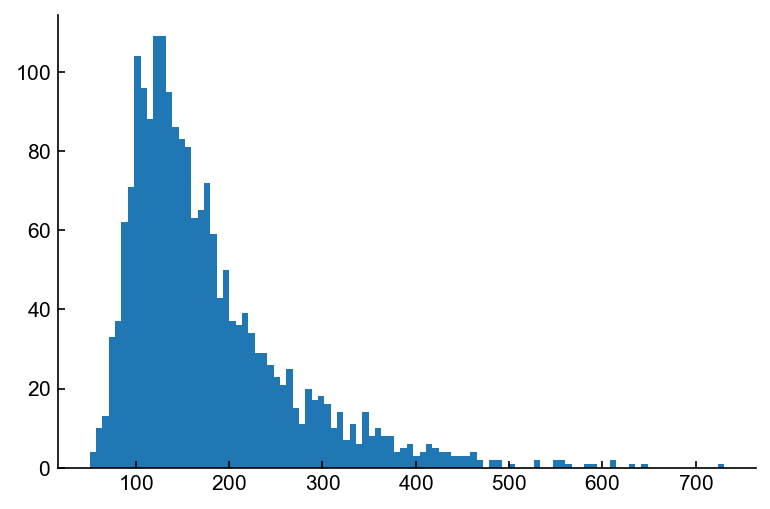

In [84]:
plt.hist(PEX,bins=100)
pass